# Auto Insurance Fraud Claim Detection with Machine Learning.

## Problem Statement

The goal of this project is to build a model that can detect auto insurance fraud. The challenge behind fraud detection in machine learning is that frauds are far less common as compared to legit insurance claims. This type of problems is known as imbalanced class classification. 

Frauds are unethical and are losses to the company. By building a model that can classify auto insurance fraud, I am able to cut losses for the insurance company. Less losses equates to more earning.

**Relevance to businesses:** 

Imbalance class problems are common in many industries. Many a times, we are interested in a minority class against another much bigger class or classes. For instance, classification of other types of frauds, classification of defective goods, classification of at-risk teenagers, identifying high potential employees, identifying people of interest such as terrorist, just to name a few. 

**Criteria for success:**

The model should be able to classify if a claim is a fraud or not on a data set that it has not seen, accurately. This is measured by the F1 score and compared against a baseline naive prediction of F1: 0.397. The area under curve of the ROC (ROC AUC) will also be taken into consideration in model selection as a secondary criterion as it is important to distinguish between fraud and legit claims. This is because investigations into frauds can be time consuming and expensive and may even negatively affect customer experience. As a compulsory criterion, the ROC AUC must be above 0.50. On top of that, I aim to have a ROC AUC of at least 0.70.

## Executive Summary

The goal of this project is to build a model that can detect auto insurance fraud. The challenge behind fraud detection in machine learning is that frauds are far less common as compared to legit insurance claims. This type of problems is known as imbalanced class classification.

Several models were tested with different methods of handling imbalance datasets. The top models were also fitted and tested with different ensembles. 

The final fitted model is a weighted XGBoost which yielded an F1 score of 0.72 and a ROC AUC score of 0.84. The model performed far better than the baseline F1 score of 0.397 and ROC AUC target of 0.7. The model's F1 score and ROC AUC scores were the highest amongst the other models. In conclusion, the model was able to correctly distinguish between fraud claims and legit claims with high accuracy. 

Prior to modeling, the data was clean and exploratory data analysis was conducted. After which, the data was pre-processed for the modeling. After modeling, the models were evaluated, and the best fitted model was selected using the F1 score and the ROC AUC score. The performance of the final fitted model was discussed in further details and its top features were displayed. The project concluded by reiterated the importance of the research and what had been done and finally, with some limitations. 


## About the Dataset 

The inspiration for this project was to perform classification on imbalance class data sets, in particular fraud. Fraud datasets are very hard to come by and often unlabelled due to its sensitive nature. 

The current data set was labelled with n=1000 samples. Unlike many other data sets, this one was less popular with only the author and one other having a notebook of it on Kaggle, making this data set one that was rather novel in nature. The data set consist of 1000 auto incidents and auto insurance claims from Ohio, Illinois and Indiana from 01 January 2015 to 01 March 2015. Before any cleaning or feature engineering, the data set has a total of 39 variables. It is not stated if this data is from multiple insurance companies or just one company. However, throughout the report, "the insurance company" will be used to refer to the origin of this data.

The obvious con of this data set is the small sample size. However, there are still many companies who do not have big data sets. The ability to work with what is available is crucial for any company looking to transition into leveraging data science. In the 2017 MIT tech review, EmTech presentation, Professor Andrew Ng penned a cyclical diagram on the white board and explained that many companies start off with some small data and develop a product which have users, which in turn leads to generation of more products. In similar vein, companies may start off with a small data set and build towards a bigger data set as time goes by. Compared to a company that waits for the day when it has a huge data set, the company that started with a small data set and worked on it will more likely succeed earlier in its data science journey and reap its rewards. 


In [5]:
!pip install mlens

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install imbalanced-learn

from scipy.stats import pointbiserialr, stats
from imblearn.over_sampling import SMOTE, ADASYN 

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

!pip install xgboost

from xgboost import XGBClassifier
from xgboost import plot_importance

from mlens.ensemble import SuperLearner
from mlens.visualization import corrmat 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


%config InlineBackend.figure_format = 'retina'
%matplotlib inline


pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

     ------------------------------------ 227.7/227.7 kB 992.8 kB/s eta 0:00:00


[MLENS] backend: threading


In [7]:
df = pd.read_csv('insurance fraud claims.csv')

## Data Cleaning

In the data cleaning, every features' percentage missing of missing values, number of unique values, and percentage of biggest category were considered. 

In general, the data set had no missing values for any variable but \_c39, which had 100% missing values. Since a row with no values have no value, it was dropped. 

There were 4 variables (collision_type, police_report_available, property_damage, auto_make) that contained values "?". I decided to impute them with the word "undocumented" instead of dropping them as they may be important. Missing information from these variables may be a predictor to fraud.  Missing information on a collision type or on a police report seems suspicious, for instance. 

There were date variables which where extracted as well. A new variable 'policy_bind_year was extracted from policy_bind_date using regex to reduce the number of categories the variable had. Moreover, the amount of granuality may not be required and thus I made the decision to extract a year, which we may use to count number of years later. As all accidents happened in 2015 (Jan 01 to Mar 01), I extracted months out of incident dates. 

I also inspected the data set for values that may seem out of the blue. For instance, umbrella limit has a negative value. Umbrella limit is an insurance rider that pays your liabilities in case you get sued for example. Thus, this cannot be negative value. The single negative value was edited to become positive from deduction that it is an error in data entry. 

Data types were then identified (nominal, ordinal, interval/ratio). Ordinal variables were coded in ascending order and treated as quantitative. For example, incident severity was coded from 0 to 3 in order of severity. After which, nominal data were inspected. Those with too many unique categories may not be useful. variable with more than 20 unique categories was inspected. Some of these variables were dropped. For example, incident location which had 1000 unique variable, insured zip which had 995 variables. One of the  variables that had smaller number of categories exceeding 20 was auto model. The variable's correlation was inspected against fraud_reported to see if it is meaningful to keep this variable. As auto make was already recorded, this variable was dropped. In sum, all nominal variables with more than 20 categories were dropped after investigations. 

In [8]:
df.head()

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1                 228   42         342868       2006-06-27           IN   
2                 134   29         687698       2000-09-06           OH   
3                 256   41         227811       1990-05-25           IL   
4                 228   44         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip insured_sex insured_education_level insured_occupation  \
0       466132        MALE                      MD       craft-repair   
1       468176        MALE                      MD  machine-op-inspct   
2       430632      FEMALE                     PhD              sales   
3       608117      FEMALE                     PhD       armed-forces   
4       610706        MALE               Associate              sales   

  insured_hobbies insured_relationship  capital-gains  capital-loss  \
0        sleeping              husband          53300             0   
1         reading       other-relative              0             0   
2     board-games            own-child          35100             0   
3     board-games            unmarried          48900        -62400   
4     board-games            unmarried          66000        -46000   

  incident_date             incident_type   collision_type incident_severity  \
0    2015-01-25  Single Vehicle Collision   Side Collision      Major Damage   
1    2015-01-21             Vehicle Theft                ?      Minor Damage   
2    2015-02-22   Multi-vehicle Collision   Rear Collision      Minor Damage   
3    2015-01-10  Single Vehicle Collision  Front Collision      Major Damage   
4    2015-02-17             Vehicle Theft                ?      Minor Damage   

  authorities_contacted incident_state incident_city  incident_location  \
0                Police             SC      Columbus     9935 4th Drive   
1                Police             VA     Riverwood       6608 MLK Hwy   
2                Police             NY      Columbus  7121 Francis Lane   
3                Police             OH     Arlington   6956 Maple Drive   
4                  None             NY     Arlington       3041 3rd Ave   

   incident_hour_of_the_day  number_of_vehicles_involved property_damage  \
0                         5                            1             YES   
1                         8                            1               ?   
2                         7                            3              NO   
3                         5                            1               ?   
4                        20                            1              NO   

   bodily_injuries  witnesses police_report_available  total_claim_amount  \
0                1          2                     YES               71610   
1                0          0                       ?                5070   
2                2          3                      NO               34650   
3                1          2                      NO               63400   
4                0          1                      NO                6500   

   injury_claim  property_claim  vehicle_claim  auto_make auto_model  \
0          6510           13020          52080       Saab        92x   
1           780             780           3510   Mercedes       E400   
2          7700            3850          23100      Dodge        RAM   
3          6340            6340          50720  Chevrolet      Tahoe   
4          1300             6

In [9]:
df.tail()

months_as_customer  age  policy_number policy_bind_date policy_state  \
995                   3   38         941851       1991-07-16           OH   
996                 285   41         186934       2014-01-05           IL   
997                 130   34         918516       2003-02-17           OH   
998                 458   62         533940       2011-11-18           IL   
999                 456   60         556080       1996-11-11           OH   

    policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
995   500/1000               1000                1310.80               0   
996    100/300               1000                1436.79               0   
997    250/500                500                1383.49         3000000   
998   500/1000               2000                1356.92         5000000   
999    250/500               1000                 766.19               0   

     insured_zip insured_sex insured_education_level insured_occupation  \
995       431289      FEMALE                 Masters       craft-repair   
996       608177      FEMALE                     PhD     prof-specialty   
997       442797      FEMALE                 Masters       armed-forces   
998       441714        MALE               Associate  handlers-cleaners   
999       612260      FEMALE               Associate              sales   

    insured_hobbies insured_relationship  capital-gains  capital-loss  \
995       paintball            unmarried              0             0   
996        sleeping                 wife          70900             0   
997  bungie-jumping       other-relative          35100             0   
998    base-jumping                 wife              0             0   
999        kayaking              husband              0             0   

    incident_date             incident_type   collision_type  \
995    2015-02-22  Single Vehicle Collision  Front Collision   
996    2015-01-24  Single Vehicle Collision   Rear Collision   
997    2015-01-23   Multi-vehicle Collision   Side Collision   
998    2015-02-26  Single Vehicle Collision   Rear Collision   
999    2015-02-26                Parked Car                ?   

    incident_severity authorities_contacted incident_state incident_city  \
995      Minor Damage                  Fire             NC    Northbrook   
996      Major Damage                  Fire             SC     Northbend   
997      Minor Damage                Police             NC     Arlington   
998      Major Damage                 Other             NY     Arlington   
999      Minor Damage                Police             WV      Columbus   

       incident_location  incident_hour_of_the_day  \
995   6045 Andromedia St                        20   
996     3092 Texas Drive                        23   
997          7629 5th St                         4   
998        6128 Elm Lane                         2   
999  1416 Cherokee Ridge                         6   

     number_of_vehicles_involved property_damage  bodily_injuries  witnesses  \
995                            1             YES                0          1   
996                            1             YES                2          3   
997                            3               ?                2          3   
998                            1               ?                0          1   
999                            1               ?                0          3   

    police_report_available  total_claim_amount  injury_claim  property_claim  \
995                       ?               87200         17440            8720   
996                       ?              108480         18080           18080   
997                     YES               67500          7500            7500   
998                     YES               46980          5220            5220   
999                       ?                5060           460             920   

     vehicle_claim   auto_make auto_model  auto_year fraud_r

In [10]:
missing_stats = []

for col in df.columns:
    missing_stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_df.sort_values('percent_missing', ascending=False)

feature  unique_values  percent_missing  \
39                         _c39              0            100.0   
1                           age             46              0.0   
22               incident_state              7              0.0   
23                incident_city              7              0.0   
24            incident_location           1000              0.0   
25     incident_hour_of_the_day             24              0.0   
26  number_of_vehicles_involved              4              0.0   
27              property_damage              3              0.0   
28              bodily_injuries              3              0.0   
29                    witnesses              4              0.0   
30      police_report_available              3              0.0   
31           total_claim_amount            763              0.0   
32                 injury_claim            638              0.0   
33               property_claim            626              0.0   
34                vehicle_claim            726              0.0   
35                    auto_make             14              0.0   
36                   auto_model             39              0.0   
37                    auto_year             21              0.0   
38               fraud_reported              2              0.0   
21        authorities_contacted              5              0.0   
0            months_as_customer            391              0.0   
19               collision_type              4              0.0   
9                   insured_zip            995              0.0   
2                 policy_number           1000              0.0   
3              policy_bind_date            951              0.0   
4                  policy_state              3              0.0   
5                    policy_csl              3              0.0   
6             policy_deductable              3              0.0   
7         policy_annual_premium            991              0.0   
8                umbrella_limit             11              0.0   
10                  insured_sex              2              0.0   
18                incident_type              4              0.0   
11      insured_education_level              7              0.0   
12           insured_occupation             14              0.0   
13              insured_hobbies             20              0.0   
14         insured_relationship              6              0.0   
15                capital-gains            338              0.0   
16                 capital-loss            354              0.0   
17                incident_date             60              0.0   
20            incident_severity              4              0.0   

    percent_biggest_cat     type  
39                100.0  float64  
1                   4.9    int64  
22                 26.2   object  
23                 15.7   object  
24                  0.1   object  
25                  5.4    int64  
26                 58.1    int64  
27                 36.0   object  
28                 34.0    int64  
29                 25.8    int64  
30                 34.3   object  
31                  0.5    int64  
32                  2.5    int64  
33                  1.9    int64  
34                  0.7    int64  
35                  8.0   object  
36                  4.3   object  
37                  5.6    int64  
38                 75.3   object  
21                 29.2   object  
0                   0.8    int64  
19                 29.2   object  
9                   0.2    int64  
2                   0.1    int64  
3                   0.3   object  
4                  35.2   object  
5                  35.1   object  
6                  35.1    int64  
7                   0.2  float64  
8                  79.8    int64  
10                 53.7   object  
18                 41.9   object  
11                 16.1   object  
12                  9.3   object  
13                  6.4   object  
14              

In [11]:
df.describe()

months_as_customer          age  policy_number  policy_deductable  \
count         1000.000000  1000.000000    1000.000000        1000.000000   
mean           203.954000    38.948000  546238.648000        1136.000000   
std            115.113174     9.140287  257063.005276         611.864673   
min              0.000000    19.000000  100804.000000         500.000000   
25%            115.750000    32.000000  335980.250000         500.000000   
50%            199.500000    38.000000  533135.000000        1000.000000   
75%            276.250000    44.000000  759099.750000        2000.000000   
max            479.000000    64.000000  999435.000000        2000.000000   

       policy_annual_premium  umbrella_limit    insured_zip  capital-gains  \
count            1000.000000    1.000000e+03    1000.000000    1000.000000   
mean             1256.406150    1.101000e+06  501214.488000   25126.100000   
std               244.167395    2.297407e+06   71701.610941   27872.187708   
min               433.330000   -1.000000e+06  430104.000000       0.000000   
25%              1089.607500    0.000000e+00  448404.500000       0.000000   
50%              1257.200000    0.000000e+00  466445.500000       0.000000   
75%              1415.695000    0.000000e+00  603251.000000   51025.000000   
max              2047.590000    1.000000e+07  620962.000000  100500.000000   

        capital-loss  incident_hour_of_the_day  number_of_vehicles_involved  \
count    1000.000000               1000.000000                   1000.00000   
mean   -26793.700000                 11.644000                      1.83900   
std     28104.096686                  6.951373                      1.01888   
min   -111100.000000                  0.000000                      1.00000   
25%    -51500.000000                  6.000000                      1.00000   
50%    -23250.000000                 12.000000                      1.00000   
75%         0.000000                 17.000000                      3.00000   
max         0.000000                 23.000000                      4.00000   

       bodily_injuries    witnesses  total_claim_amount  injury_claim  \
count      1000.000000  1000.000000          1000.00000   1000.000000   
mean          0.992000     1.487000         52761.94000   7433.420000   
std           0.820127     1.111335         26401.53319   4880.951853   
min           0.000000     0.000000           100.00000      0.000000   
25%           0.000000     1.000000         41812.50000   4295.000000   
50%           1.000000     1.000000         58055.00000   6775.000000   
75%           2.000000     2.000000         70592.50000  11305.000000   
max           2.000000     3.000000        114920.00000  21450.000000   

       property_claim  vehicle_claim    auto_year  _c39  
count     1000.000000    1000.000000  1000.000000   0.0  
mean      7399.570000   37928.950000  2005.103000   NaN  
std       4824.726179   18886.252893     6.015861   NaN  
min          0.000000      70.000000  1995.000000   NaN  
25%       4445.000000   30292.500000  2000.000000   NaN  
50%       6750.000000   42100.000000  2005.000000   NaN  
75%      10885.000000   50822.500000  2010.000000   NaN  
max      23670.000000   79560.000000  2015.000000   NaN

In [12]:
#a row with no values have no value

df.drop('_c39', axis=1, inplace=True)

In [13]:
#extract out the year as 

df['policy_bind_year']=df['policy_bind_date'].str.extract('(\d{4})\-').astype('int32')

In [14]:
#extract the month out 
#all accidents are from 2015 jan and feb, so year isnt very important

df['incident_month']=df['incident_date'].str.extract('\d{4}\-(\d{2})').astype('int32')

In [15]:
#replace "?" with undocumented 

df['collision_type'] = df['collision_type'].replace("?", "undocumented")
df['police_report_available'] = df['police_report_available'].replace("?", "undocumented")
df['property_damage'] = df['property_damage'].replace("?", "undocumented")
df['auto_make'] = df['auto_make'].replace("Suburu", "Subaru")

In [16]:
#incident_severity can be seen as ordinal
#code them in order of severity 

df['incident_severity'] = df['incident_severity'].map({"Trivial Damage":0,
                                                       "Minor Damage":1,
                                                       "Major Damage":2,
                                                       "Total Loss":3
                                                      }).astype("int32")
df.incident_severity.value_counts()

1    354
3    280
2    276
0     90
Name: incident_severity, dtype: int64

In [17]:
#umbrella limit is like an insruance topup that pays your liabilities in case you get sued
#cannot be zero
#this 0 is an error

df['umbrella_limit'].sort_values(ascending=True)

290    -1000000
0             0
623           0
624           0
625           0
         ...   
657     9000000
458     9000000
975     9000000
430    10000000
115    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

In [18]:
#edit to positve
df['umbrella_limit'].iloc[290] = 1000000

C:\Users\parul\AppData\Local\Temp\ipykernel_7192\3924530982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['umbrella_limit'].iloc[290] = 1000000


In [19]:
#check
df['umbrella_limit'].iloc[290]

1000000

In [20]:
#check
df['umbrella_limit'].sort_values(ascending=True)

0             0
622           0
623           0
624           0
625           0
         ...   
700     9000000
88      9000000
975     9000000
115    10000000
430    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

#### Identify by data types

In [21]:
all_var = list(df.columns)
len(all_var)

41

In [22]:
#continuous variables = ordinal, interval, ratio

cont_var =['age','incident_hour_of_the_day',
           'number_of_vehicles_involved','total_claim_amount',
           'injury_claim','property_claim','vehicle_claim',
           'months_as_customer','policy_annual_premium','policy_deductable',
           'umbrella_limit','capital-gains','capital-loss', 
           'auto_year','witnesses','bodily_injuries','policy_bind_year','incident_severity']

len(cont_var)

18

In [23]:
#ordinal var

ord_var = ['policy_deductable','witnesses','bodily_injuries','incident_severity']
len(ord_var)

4

In [24]:
ord_var

['policy_deductable', 'witnesses', 'bodily_injuries', 'incident_severity']

In [25]:
#quan var = interval or ratio 

quan_var = (list(set(cont_var) - set(ord_var))) 
len(quan_var)

14

In [26]:
#norminal aka discrete var

nom_var = (list(set(all_var) - set(cont_var))) 
len(nom_var)

23

In [27]:
#check for norminal data with vevry large number of categories

for col in nom_var:
    print("###", col, "###" )
    print("  ")
    print(df[col].value_counts())
    print("---------------------------------------------")
    print("  ")

### incident_type ###
  
Multi-vehicle Collision     419
Single Vehicle Collision    403
Vehicle Theft                94
Parked Car                   84
Name: incident_type, dtype: int64
---------------------------------------------
  
### collision_type ###
  
Rear Collision     292
Side Collision     276
Front Collision    254
undocumented       178
Name: collision_type, dtype: int64
---------------------------------------------
  
### policy_csl ###
  
250/500     351
100/300     349
500/1000    300
Name: policy_csl, dtype: int64
---------------------------------------------
  
### incident_state ###
  
NY    262
SC    248
WV    217
VA    110
NC    110
PA     30
OH     23
Name: incident_state, dtype: int64
---------------------------------------------
  
### policy_state ###
  
OH    352
IL    338
IN    310
Name: policy_state, dtype: int64
---------------------------------------------
  
### fraud_reported ###
  
N    753
Y    247
Name: fraud_reported, dtype: int64
-----------------

In [28]:
#for those that have not too many unique, we can plot them out

large_cat = []

for col in nom_var:
    if df[col].nunique() > 20:
        large_cat.append(col)
        print(col, df[col].nunique())
    else: 
        pass
    
#incident location, insured zip, policy bind date, policy number too many unique to be meaningful

policy_number 1000
incident_date 60
incident_location 1000
auto_model 39
policy_bind_date 951
insured_zip 995


In [29]:
#get a data frame with var that have large num categories
#only auto model 
large_dummy = pd.get_dummies(df[['auto_model','incident_date']], drop_first=True)

#put in the DV
large_dummy['fraud_reported']=df['fraud_reported']

#numerical code the DV
large_dummy['fraud_reported'] = large_dummy['fraud_reported'].map({"Y":1,"N":0})

#unique to each case. wont be useful
large_dummy.head(10)


auto_model_92x  auto_model_93  auto_model_95  auto_model_A3  auto_model_A5  \
0               1              0              0              0              0   
1               0              0              0              0              0   
2               0              0              0              0              0   
3               0              0              0              0              0   
4               0              0              0              0              0   
5               0              0              1              0              0   
6               0              0              0              0              0   
7               0              0              0              0              1   
8               0              0              0              0              0   
9               1              0              0              0              0   

   auto_model_Accord  auto_model_C300  auto_model_CRV  auto_model_Camry  \
0                  0                0               0                 0   
1                  0                0               0                 0   
2                  0                0               0                 0   
3                  0                0               0                 0   
4                  0                0               0                 0   
5                  0                0               0                 0   
6                  0                0               0                 0   
7                  0                0               0                 0   
8                  0                0               0                 1   
9                  0                0               0                 0   

   auto_model_Civic  auto_model_Corolla  auto_model_E400  auto_model_Escape  \
0                 0                   0                0                  0   
1                 0                   0                1                  0   
2                 0                   0                0                  0   
3                 0                   0                0                  0   
4                 0                   0                0                  0   
5                 0                   0                0                  0   
6                 0                   0                0                  0   
7                 0                   0                0                  0   
8                 0                   0                0                  0   
9                 0                   0                0                  0   

   auto_model_F150  auto_model_Forrestor  auto_model_Fusion  \
0                0                     0                  0   
1                0                     0                  0   
2                0                     0                  0   
3                0                     0                  0   
4                0                     0                  0   
5                0                     0                  0   
6                0                     0                  0   
7                0                     0                  0   
8                0                     0                  0   
9                0                     0                  0   

   auto_model_Grand Cherokee  auto_model_Highlander  auto_model_Impreza  \
0                          0                      0                   0   
1                          0                      0                   0   
2                          0                      0                   0   
3                          0                      0                   0   
4                          0                      0                   0   
5                          0                      0                   0   
6                          0                      0                   0   
7                          0                      0                   0   
8                          0                  

In [30]:
#Color negative numbers red, positive blue
def color(val):
    color = 'green' if val ==1 else 'red' if val < -0.3 else 'blue' if val > 0.3 else 'black'   #write like lambda
    return 'color: %s' % color


corr = large_dummy.corr()
corr.style.applymap(color)


#no correlation with make and fraud. drop var

In [31]:
#drop this variables from analysis 

df.drop(large_cat, axis=1, inplace=True)

In [32]:
#redefine the norminal var
#remove dv from the list

nom_var.remove('fraud_reported')
nom_var = (list(set(nom_var) - set(large_cat))) 
len(nom_var)

16

In [33]:
#check columns add up 

print ('total var count:{}'.format(len(list(df.columns))),
       'continous var count:{}'.format(len(cont_var)),
       'norminal var count:{}'.format(len(nom_var)))

total var count:35 continous var count:18 norminal var count:16


## Exploratory Data Analysis

### Dependent variable
Exploratory data analysis was conducted started with the dependent variable, Fraud_reported. There were 247 frauds and 753 non-frauds. 24.7% of the data were frauds while 75.3% were non-fraudulent claims. 

In [34]:
#count each level of the Dv

df.fraud_reported.value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

In [35]:
#proportion of each level of DV

df.fraud_reported.value_counts(normalize=True)

N    0.753
Y    0.247
Name: fraud_reported, dtype: float64

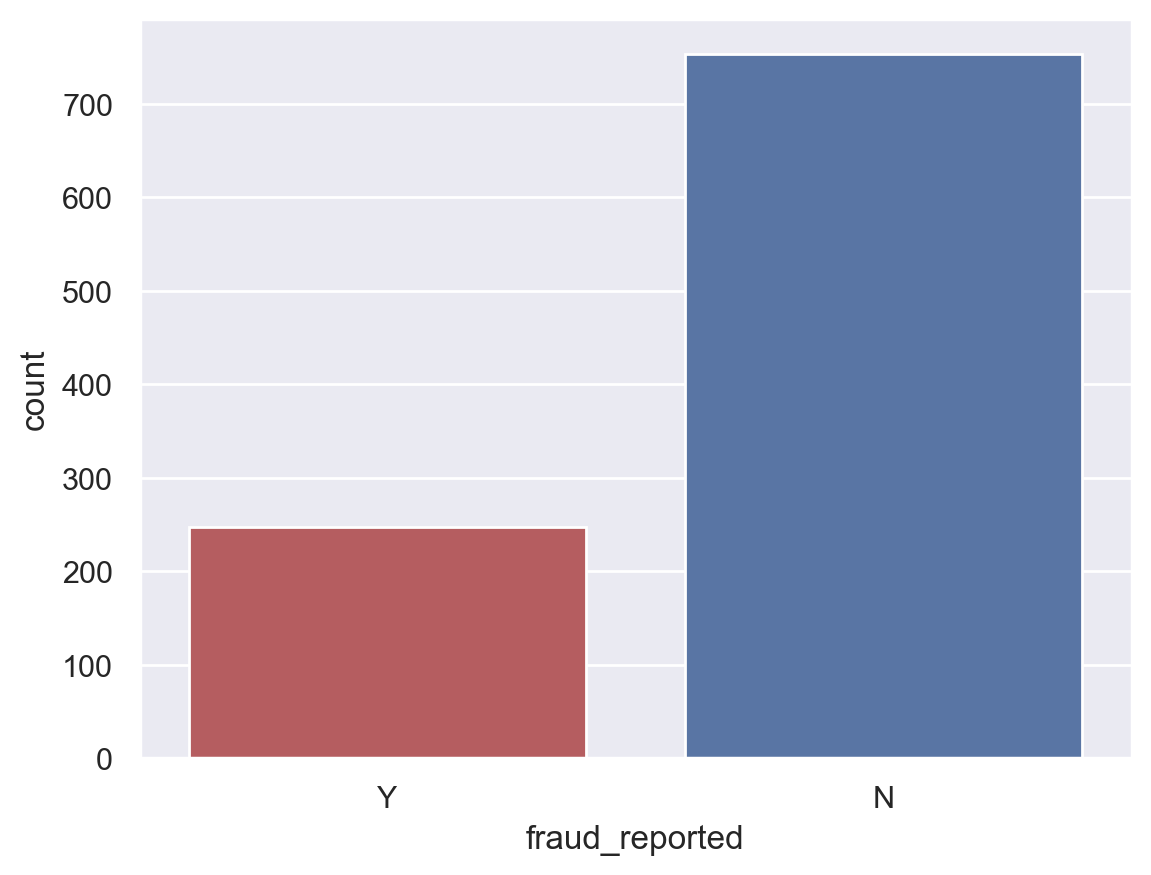

In [36]:
#dist of dv
#plt.style.use('dark_background') for ppt 
sns.set()

sns.countplot(x ="fraud_reported", data=df, palette=['r','b']);

### Correlations among variables
Next, correlations amongst continuous variables (ordinal, interval/ratio variables) were inspected. Heatmap was plotted for variables with at least 0.3 Pearson's correlation coefficient , including the DV.

Month as customer and age had a correlation of 0.92. Probably because drivers buy auto insurance when they own a car and this time measure only increases with age. 

Incident severity and different types of claims have a clear correlation ($r$ = 0.36 - 0.50)

Apart from that, there don’t seem to be much correlations in the data.
There don’t seem to be multicollinearity problem except maybe that all the claims are all correlated, and somehow total claims have accounted for them.
However, the other claims provide some granularity that will not otherwise be captured by total claims. Thus, these variables were kept. 

In [37]:
#Color negative numbers red

def color(val):
    color = 'green' if val ==1 else 'red' if val < -0.3 else 'blue' if val > 0.3 else 'black'   #write like lambda
    return 'color: %s' % color


corr = df[cont_var].corr()
corr.style.applymap(color)

C:\Users\parul\AppData\Local\Temp\ipykernel_7192\333585979.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


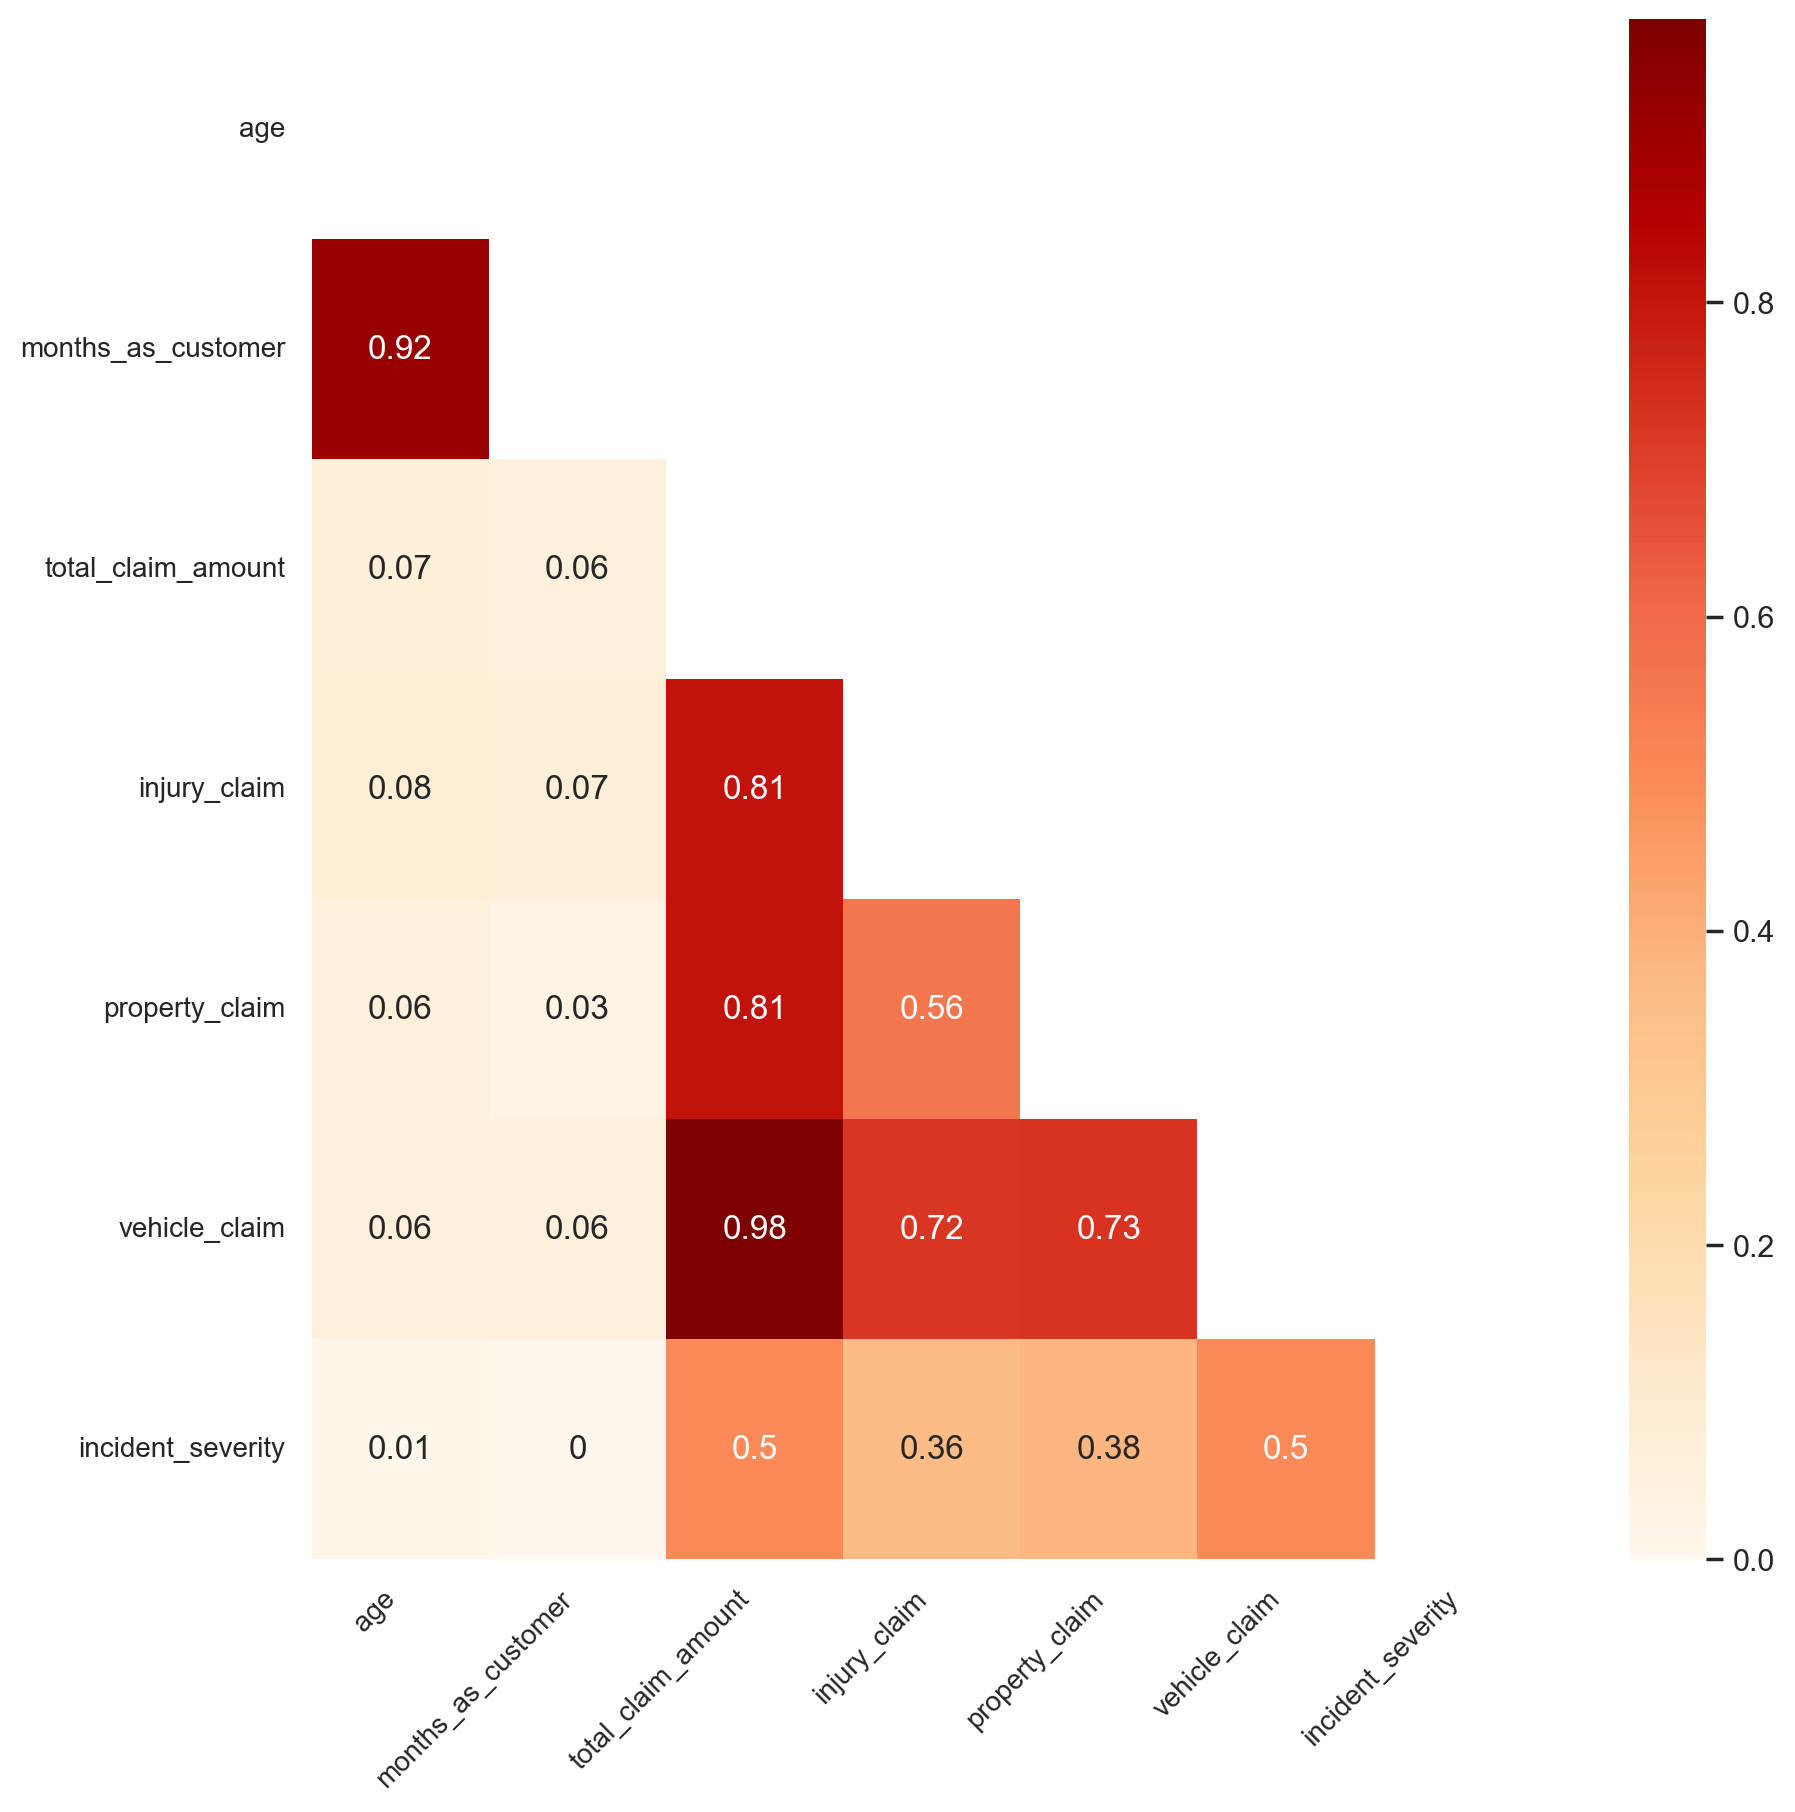

In [38]:
sns.set_style('white')

# heatmap from those with at least 0.3 magnitude in corr, includeing the DV
corr_list=['age','months_as_customer','total_claim_amount',
           'injury_claim', 'property_claim','vehicle_claim',
           'incident_severity','fraud_reported']

corr_df = df[corr_list]
corr=round(corr_df.corr(),2)

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(10,10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  #triu triangle upper

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap='OrRd')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha= 'right', rotation=45 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

## Visualization

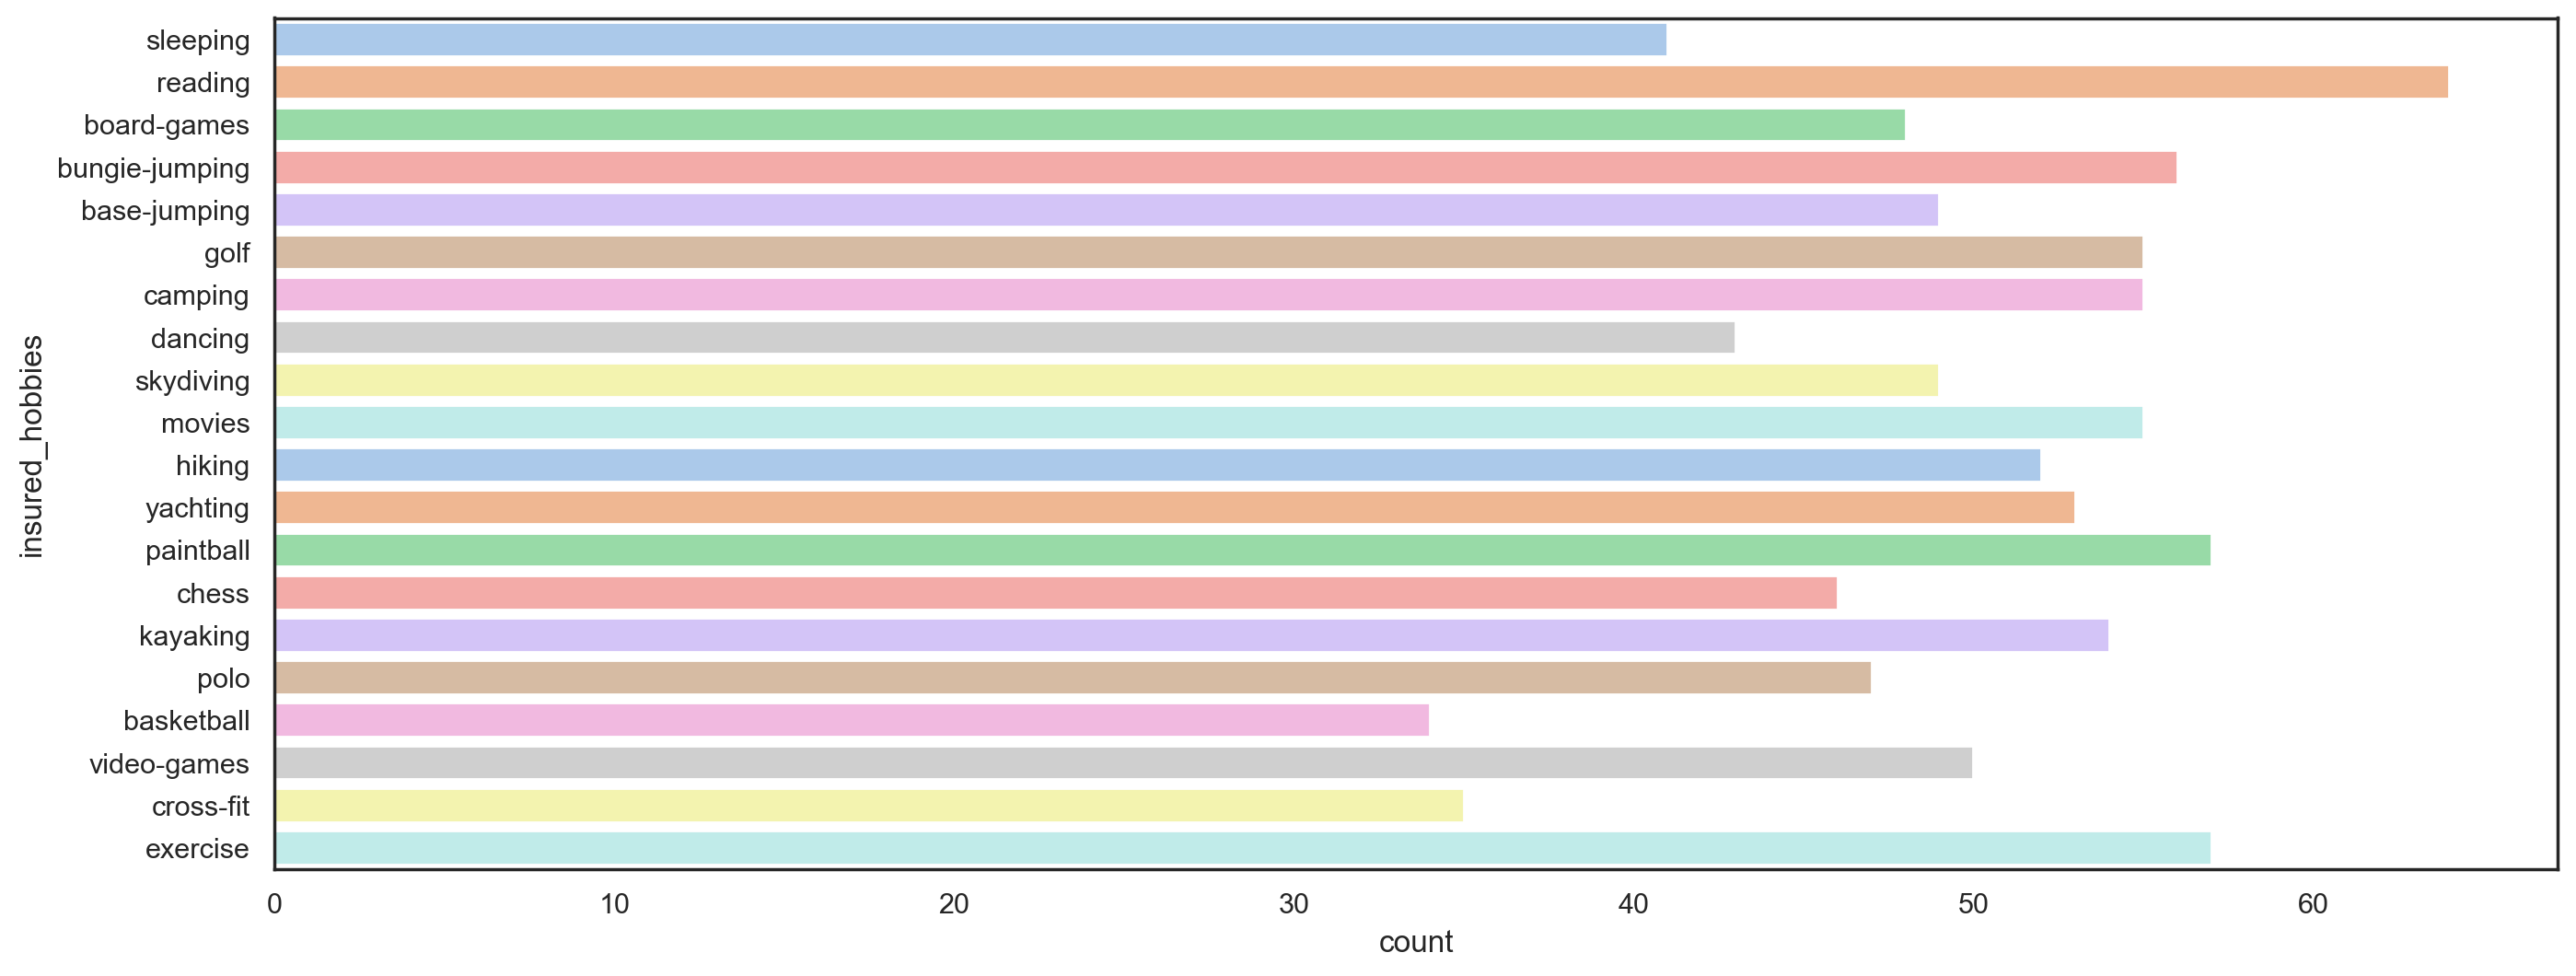

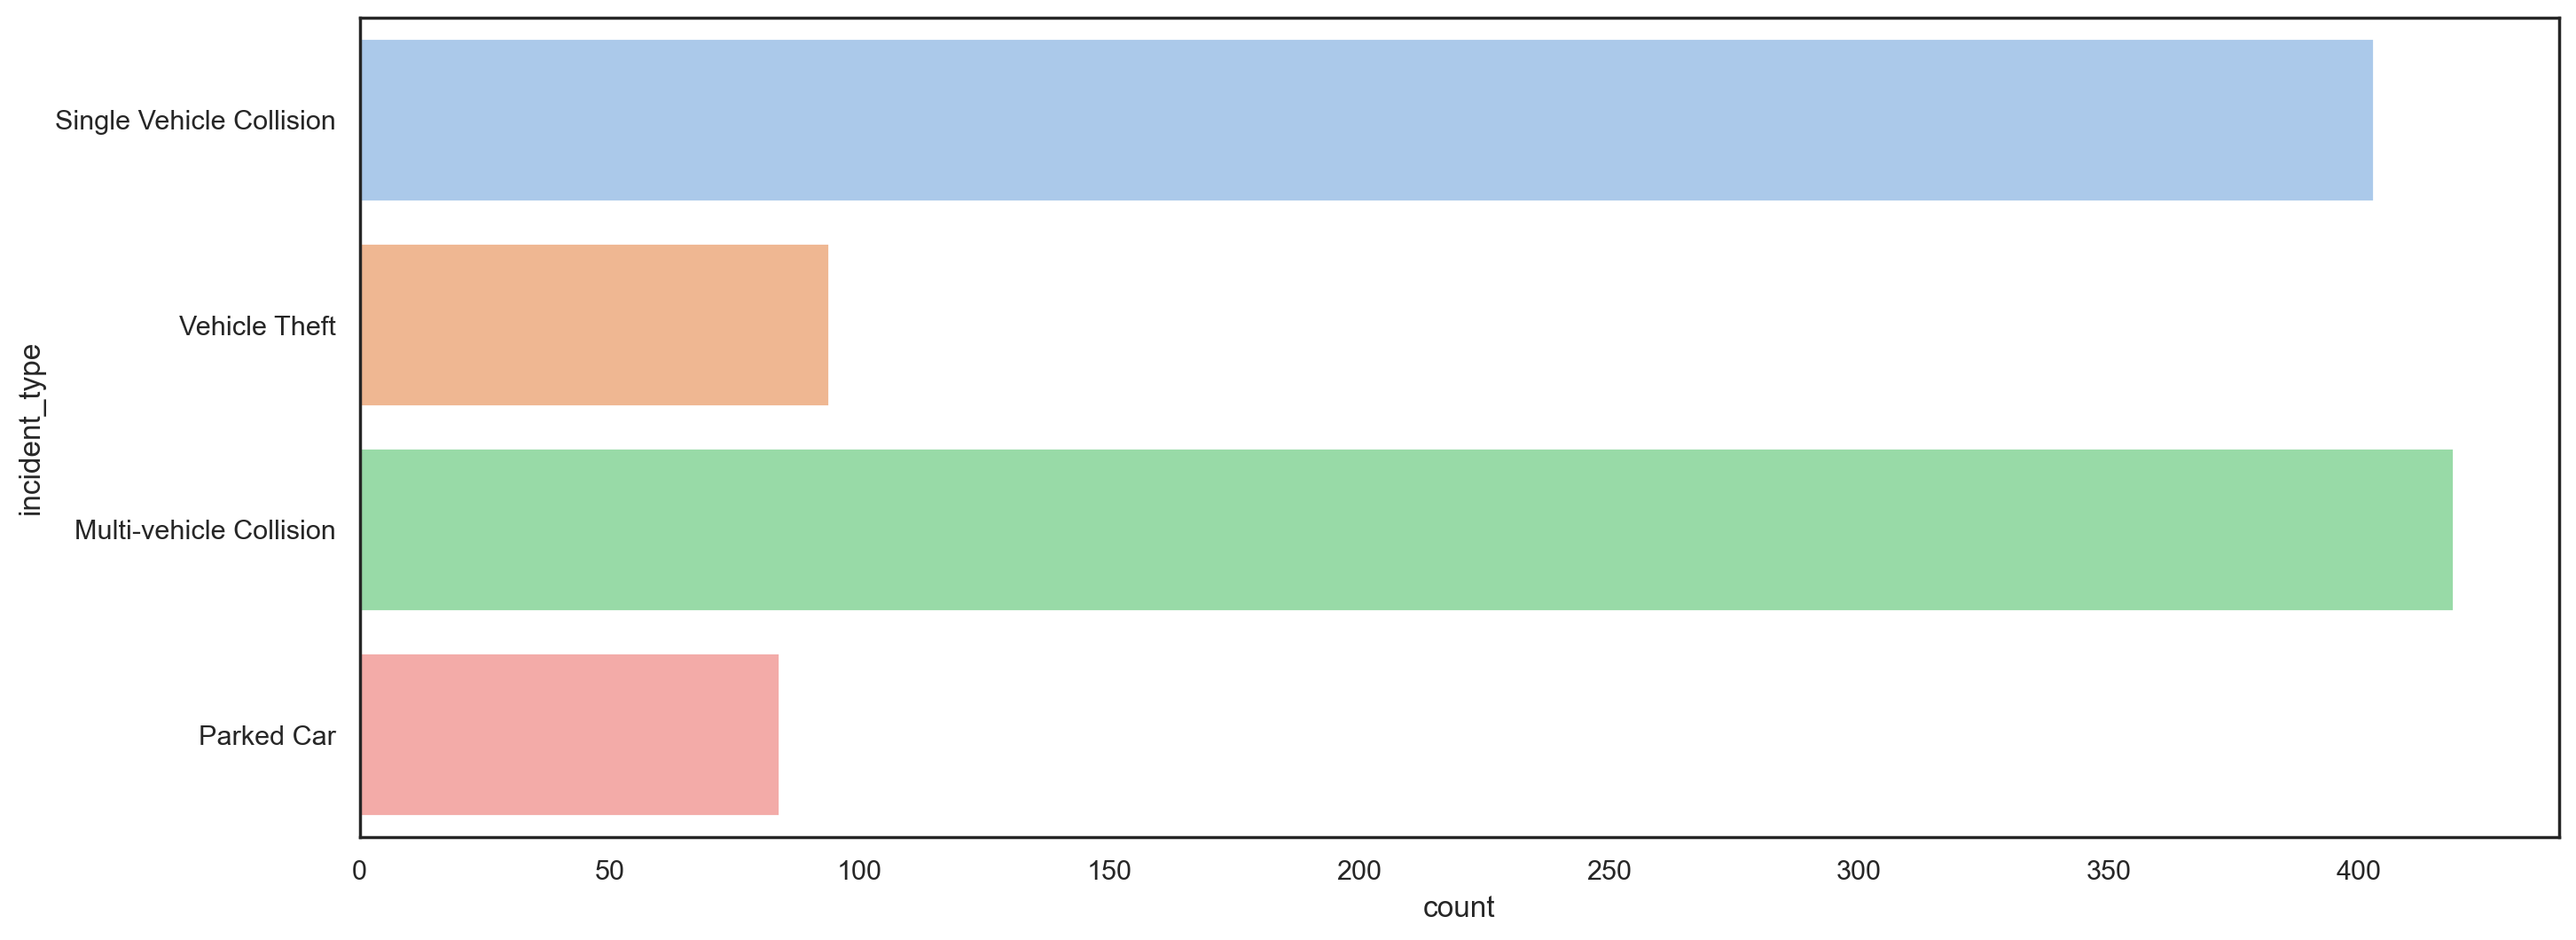

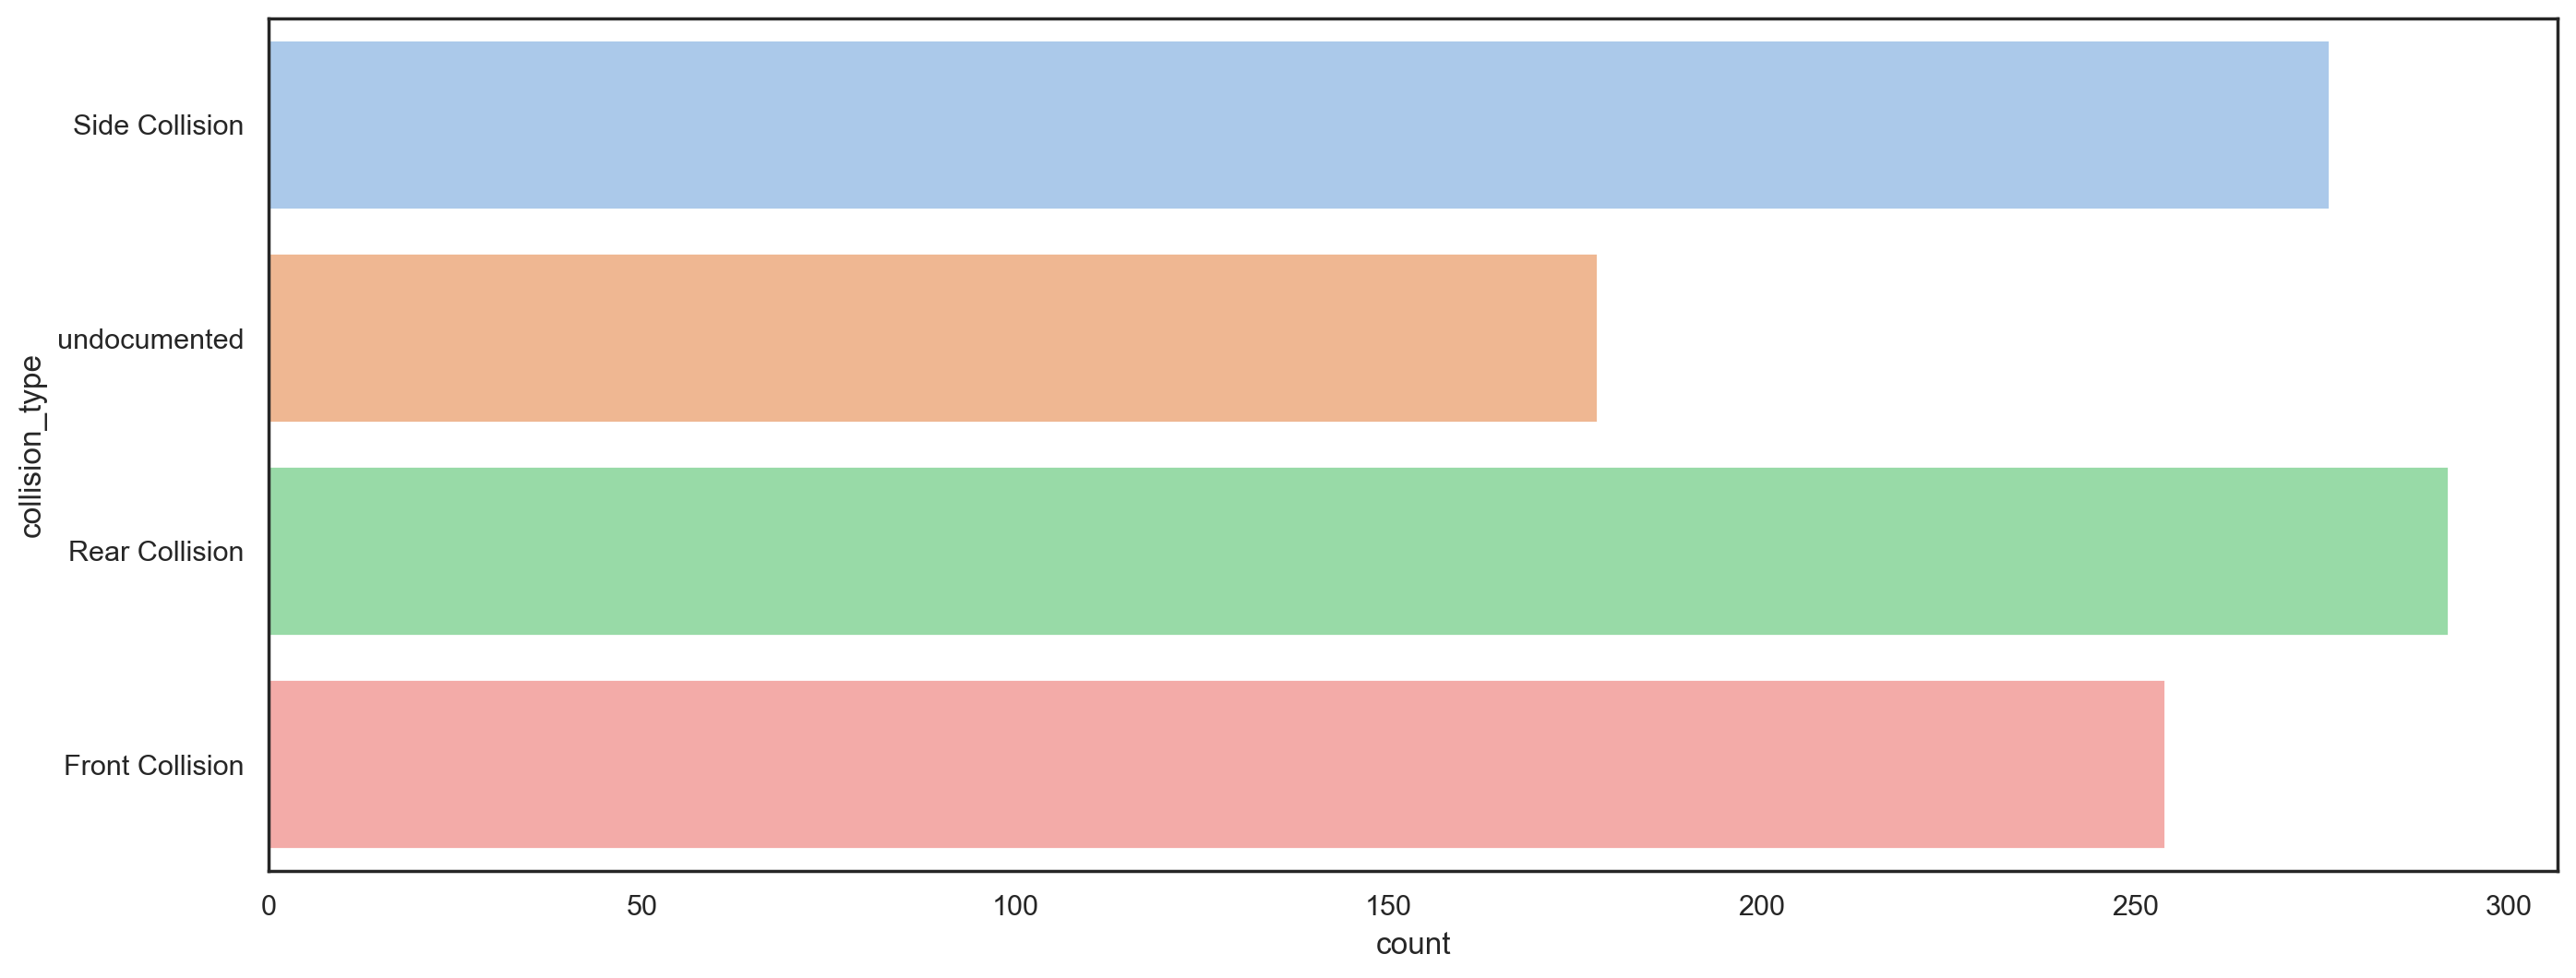

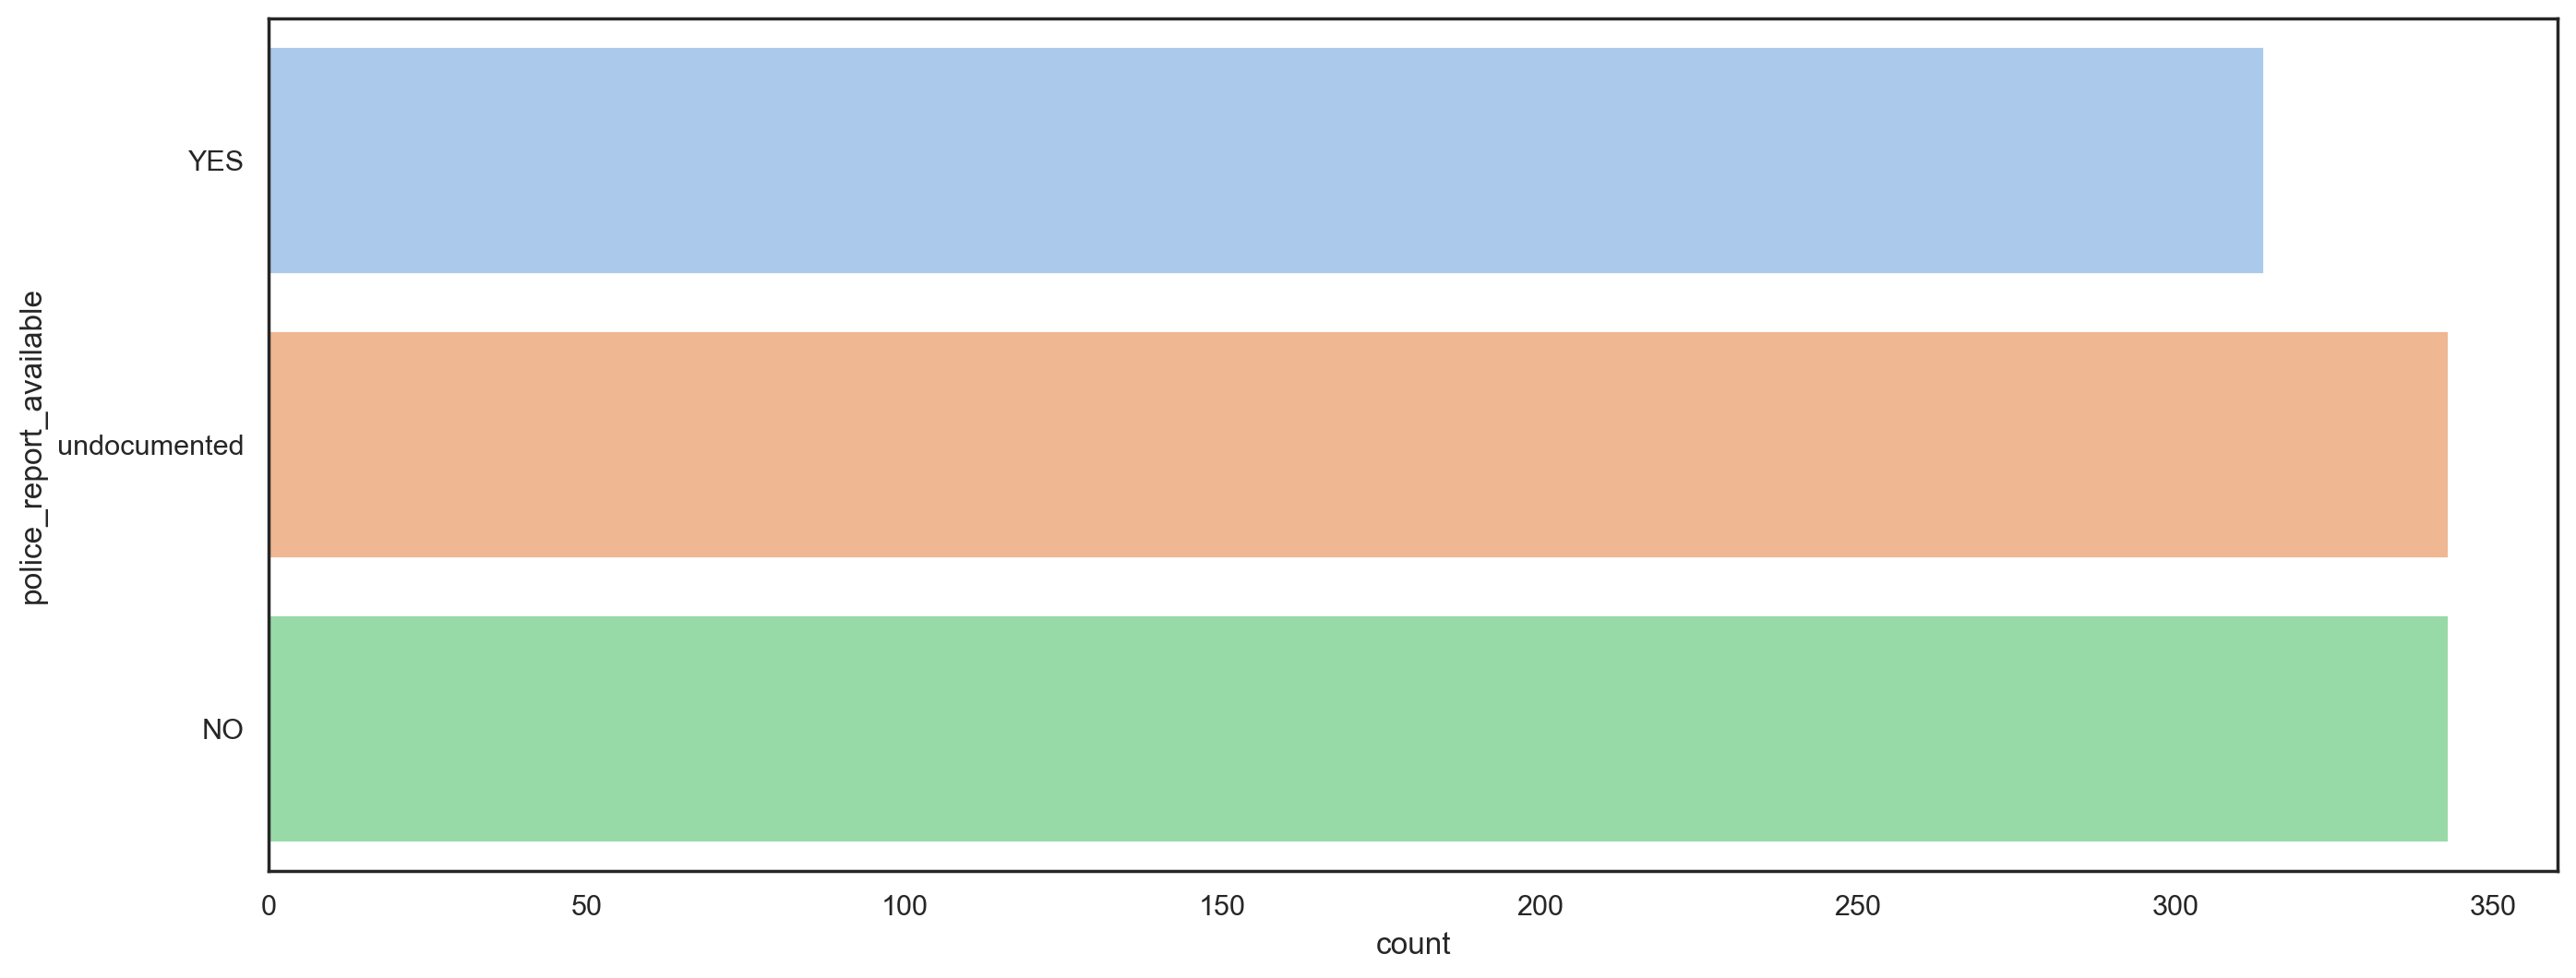

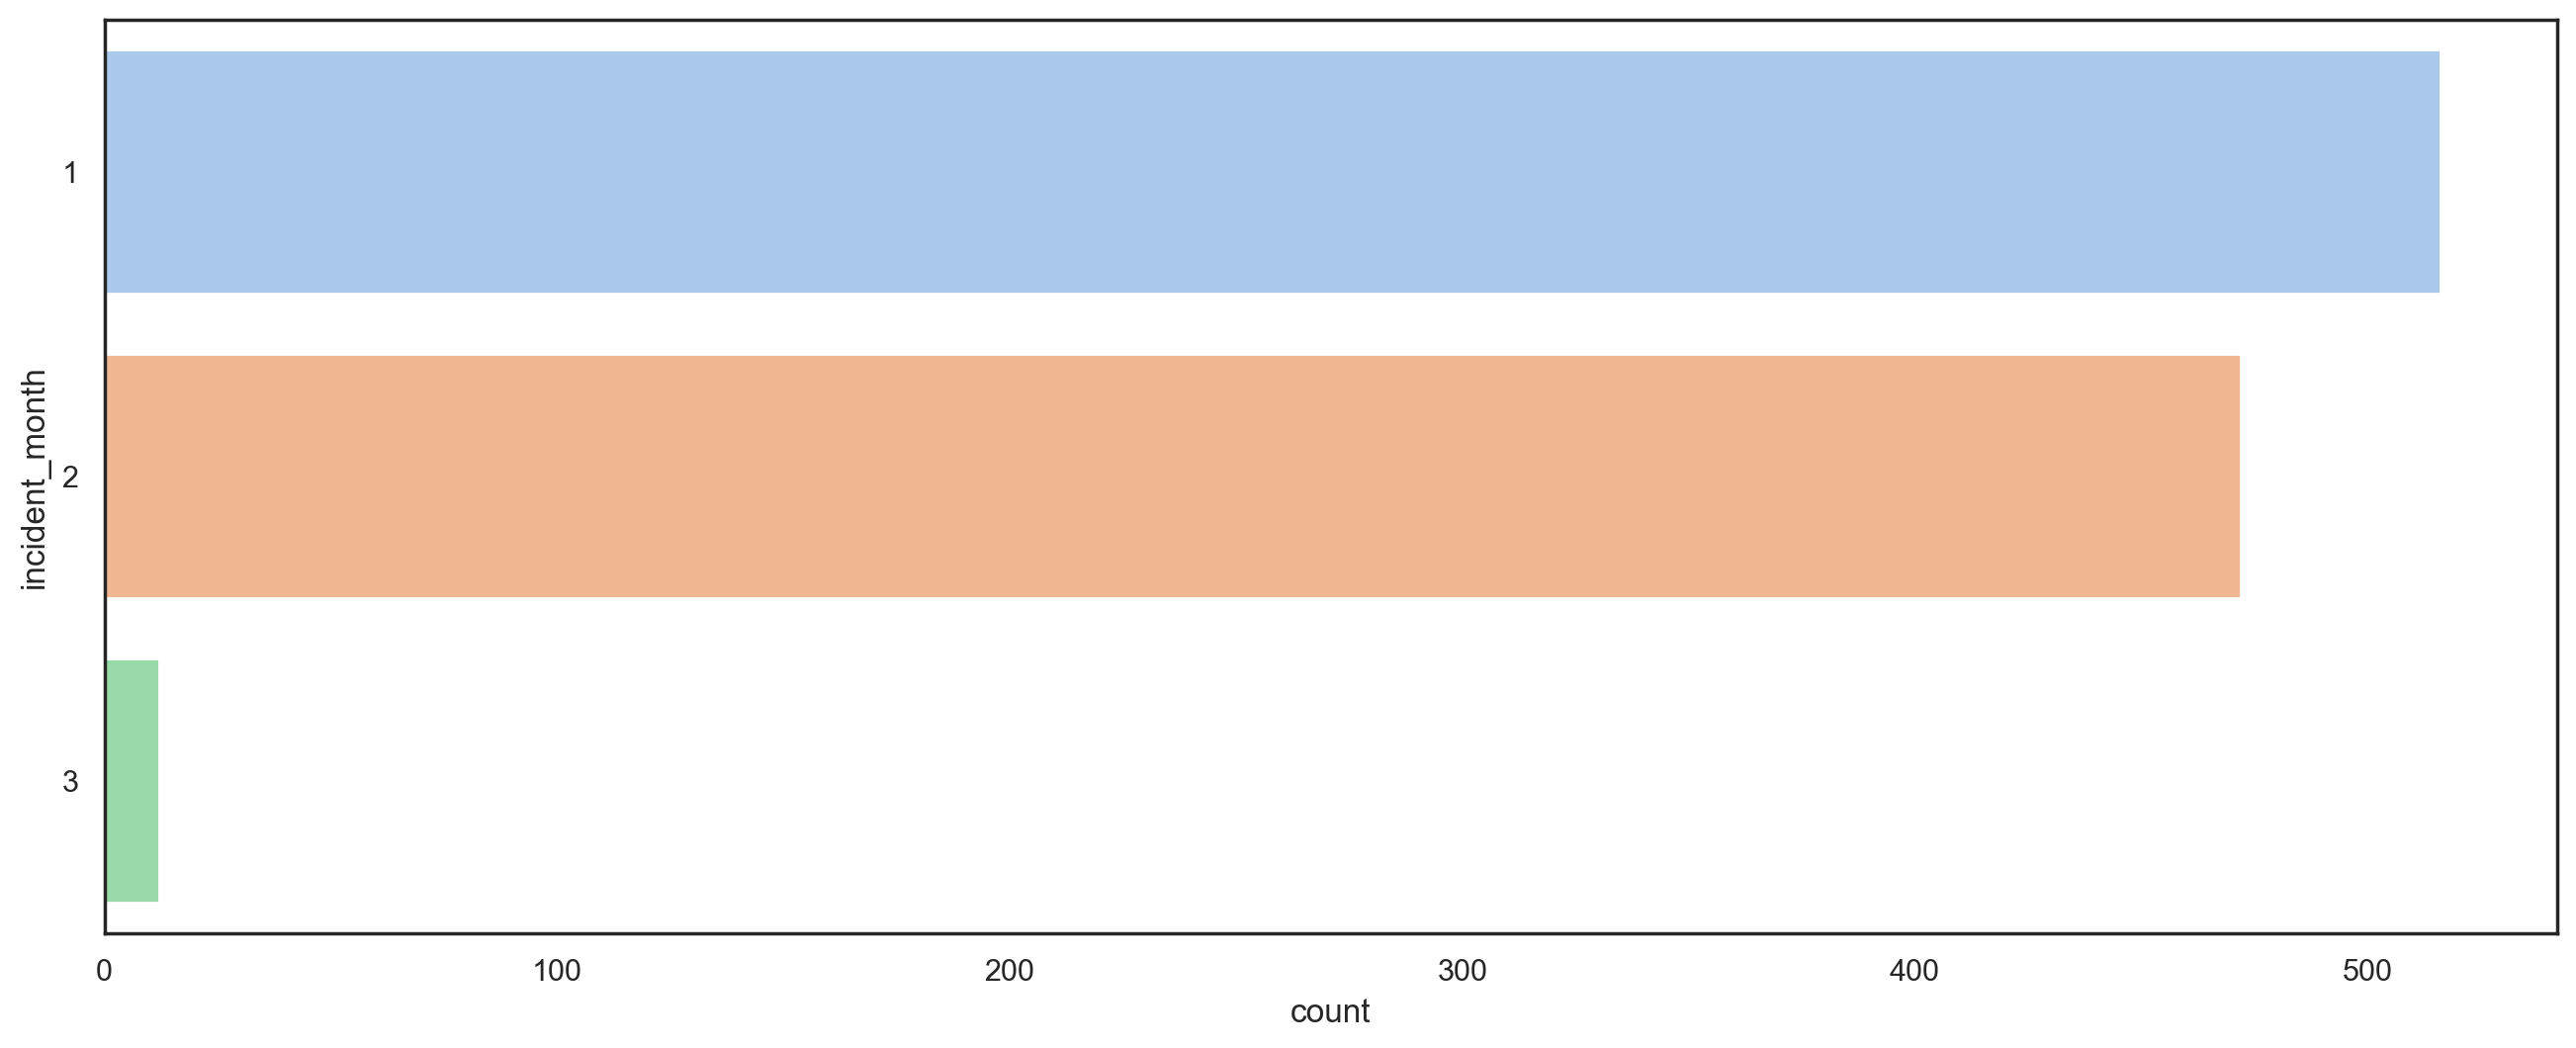

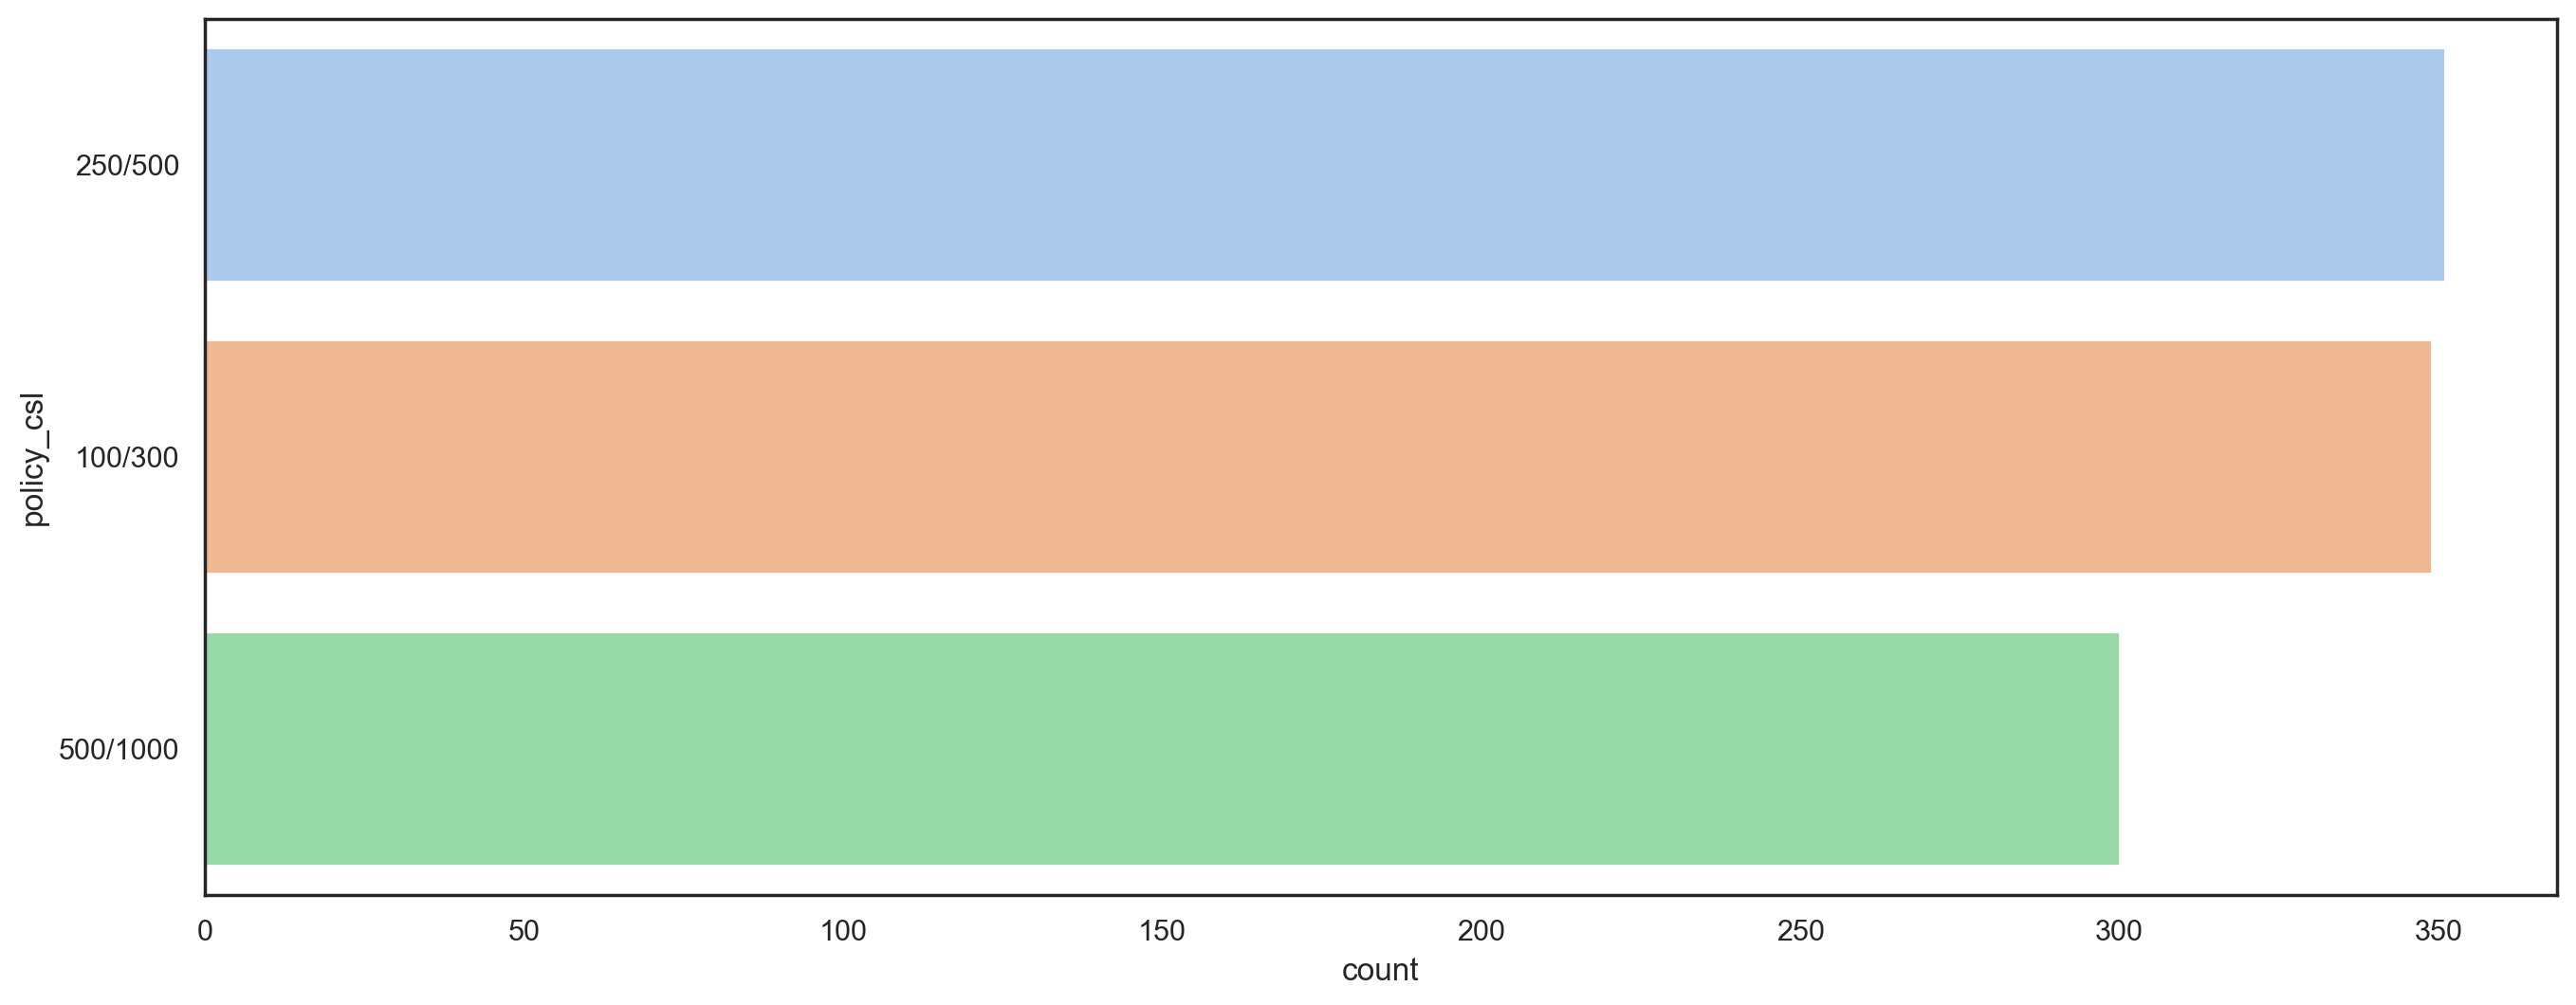

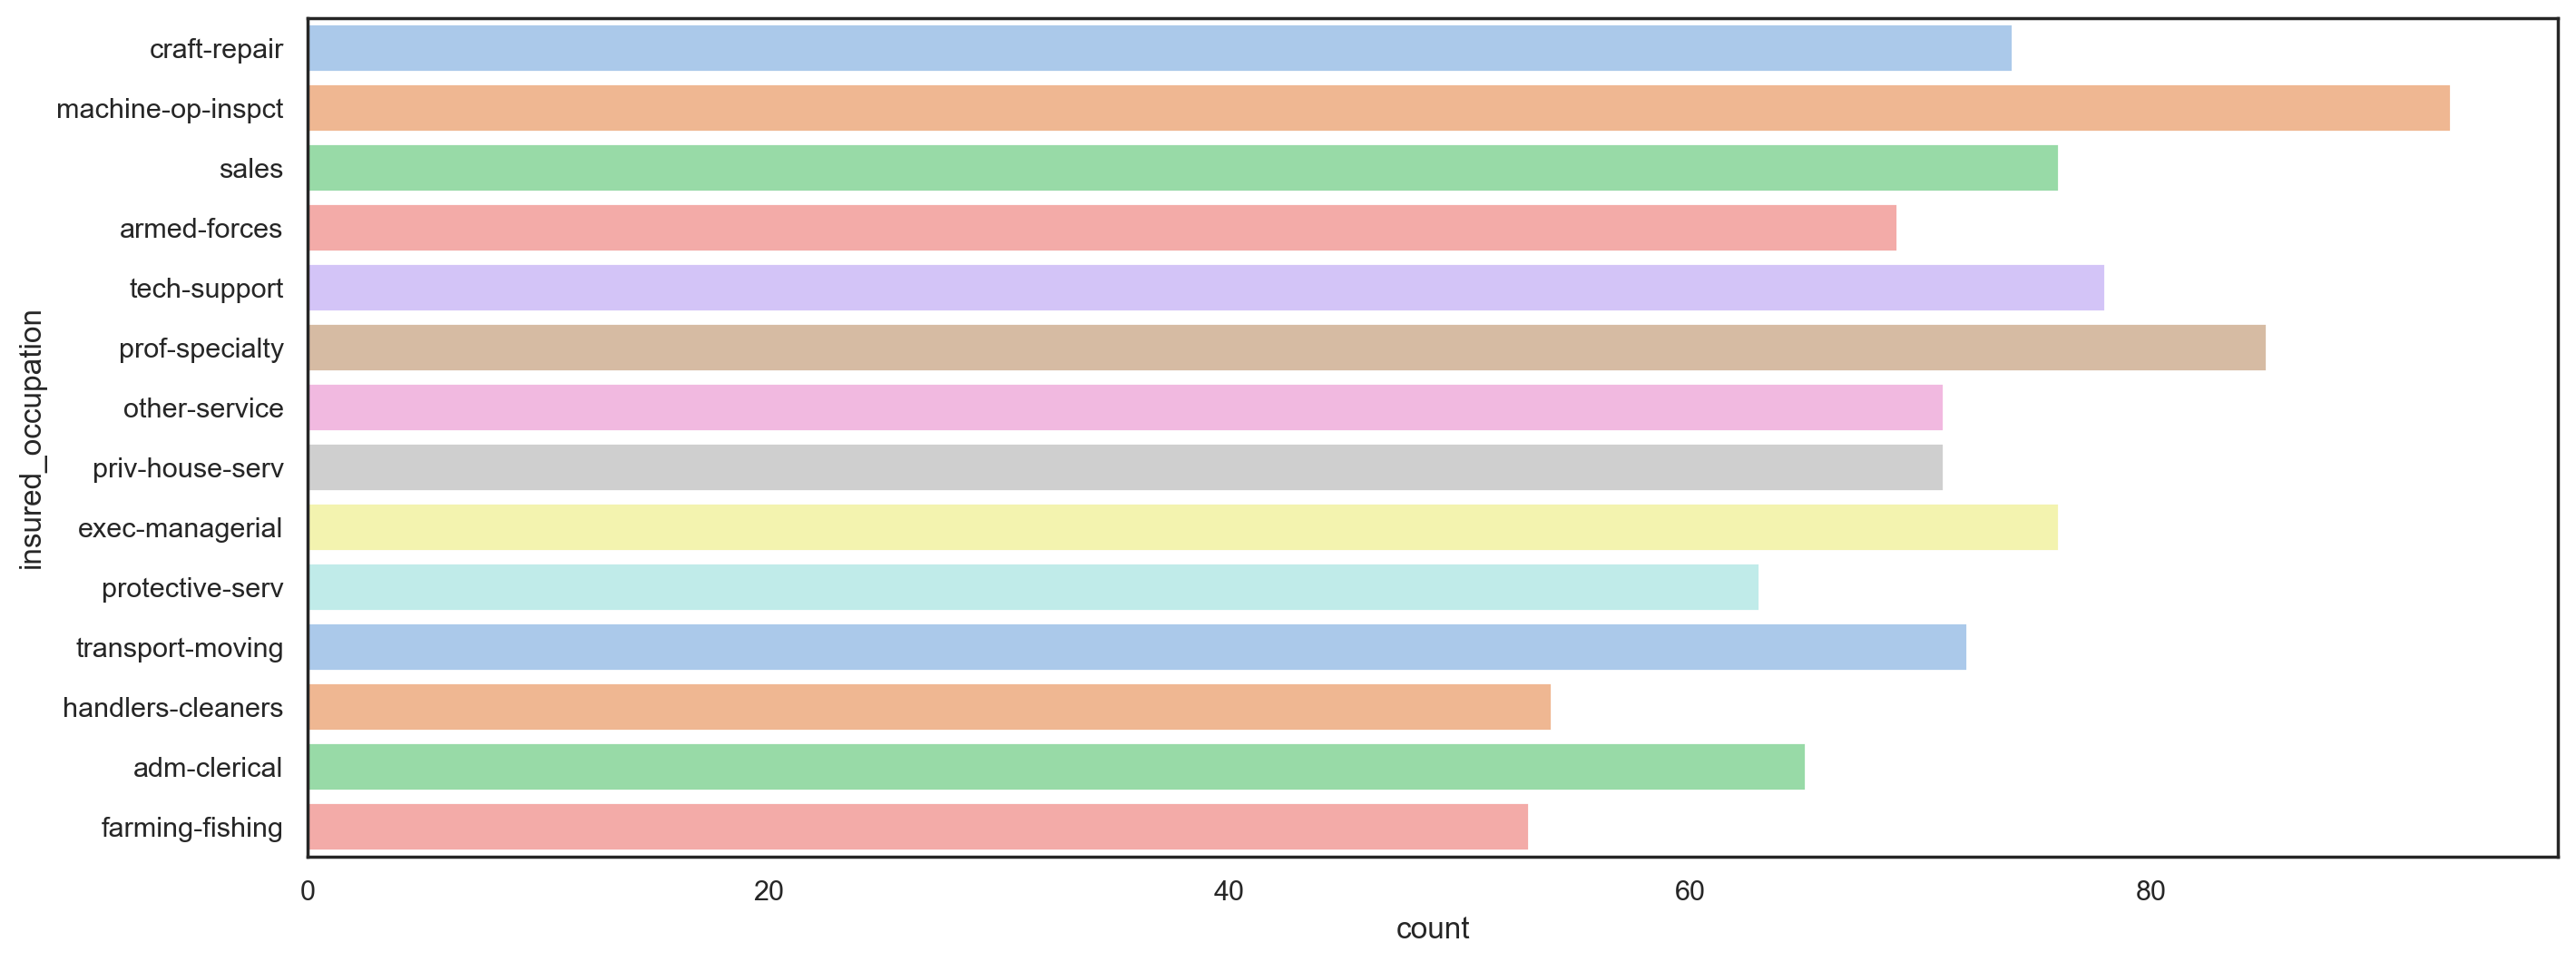

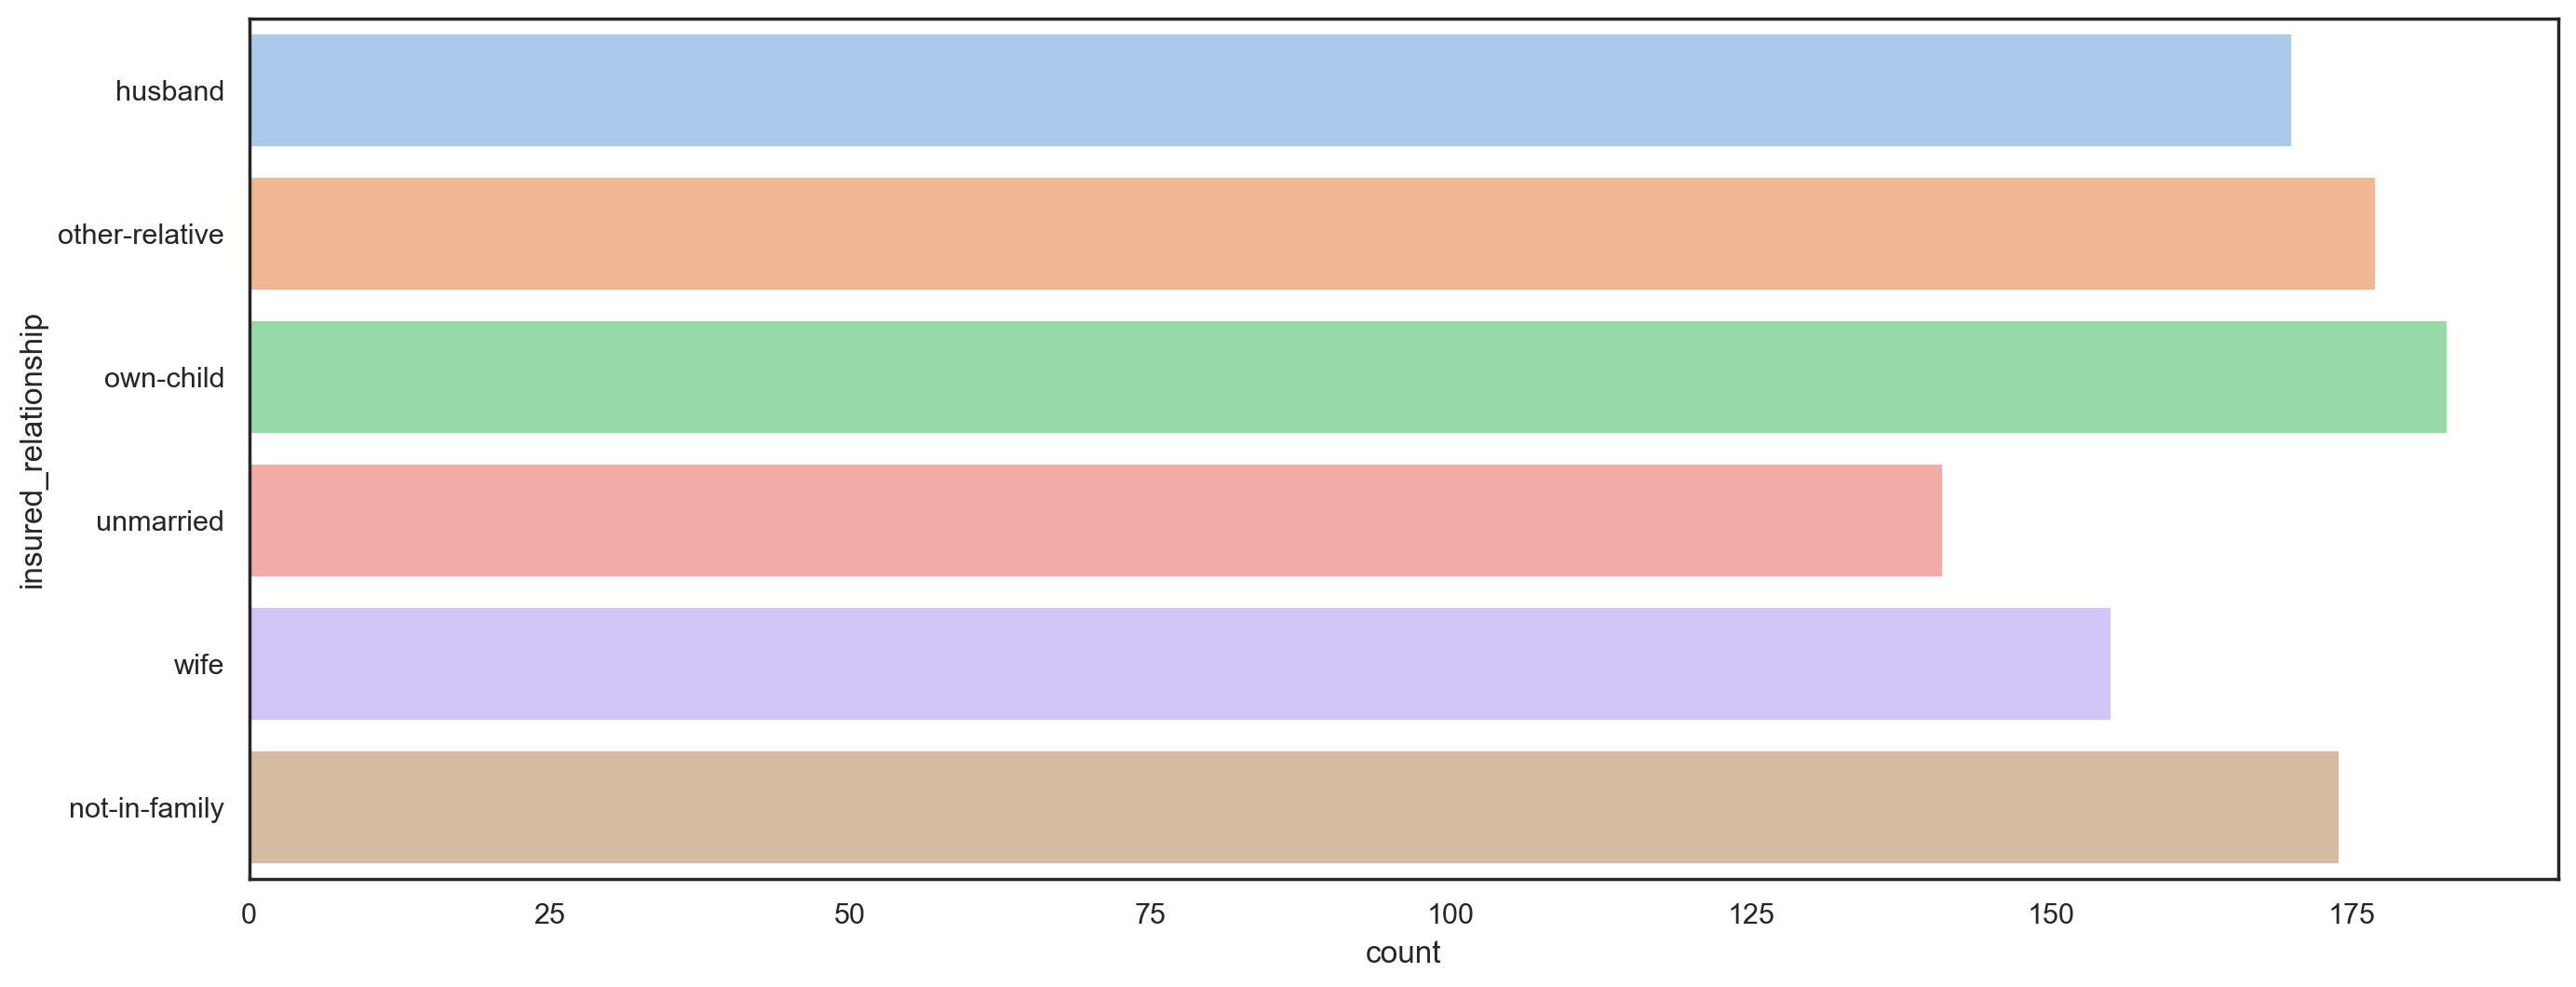

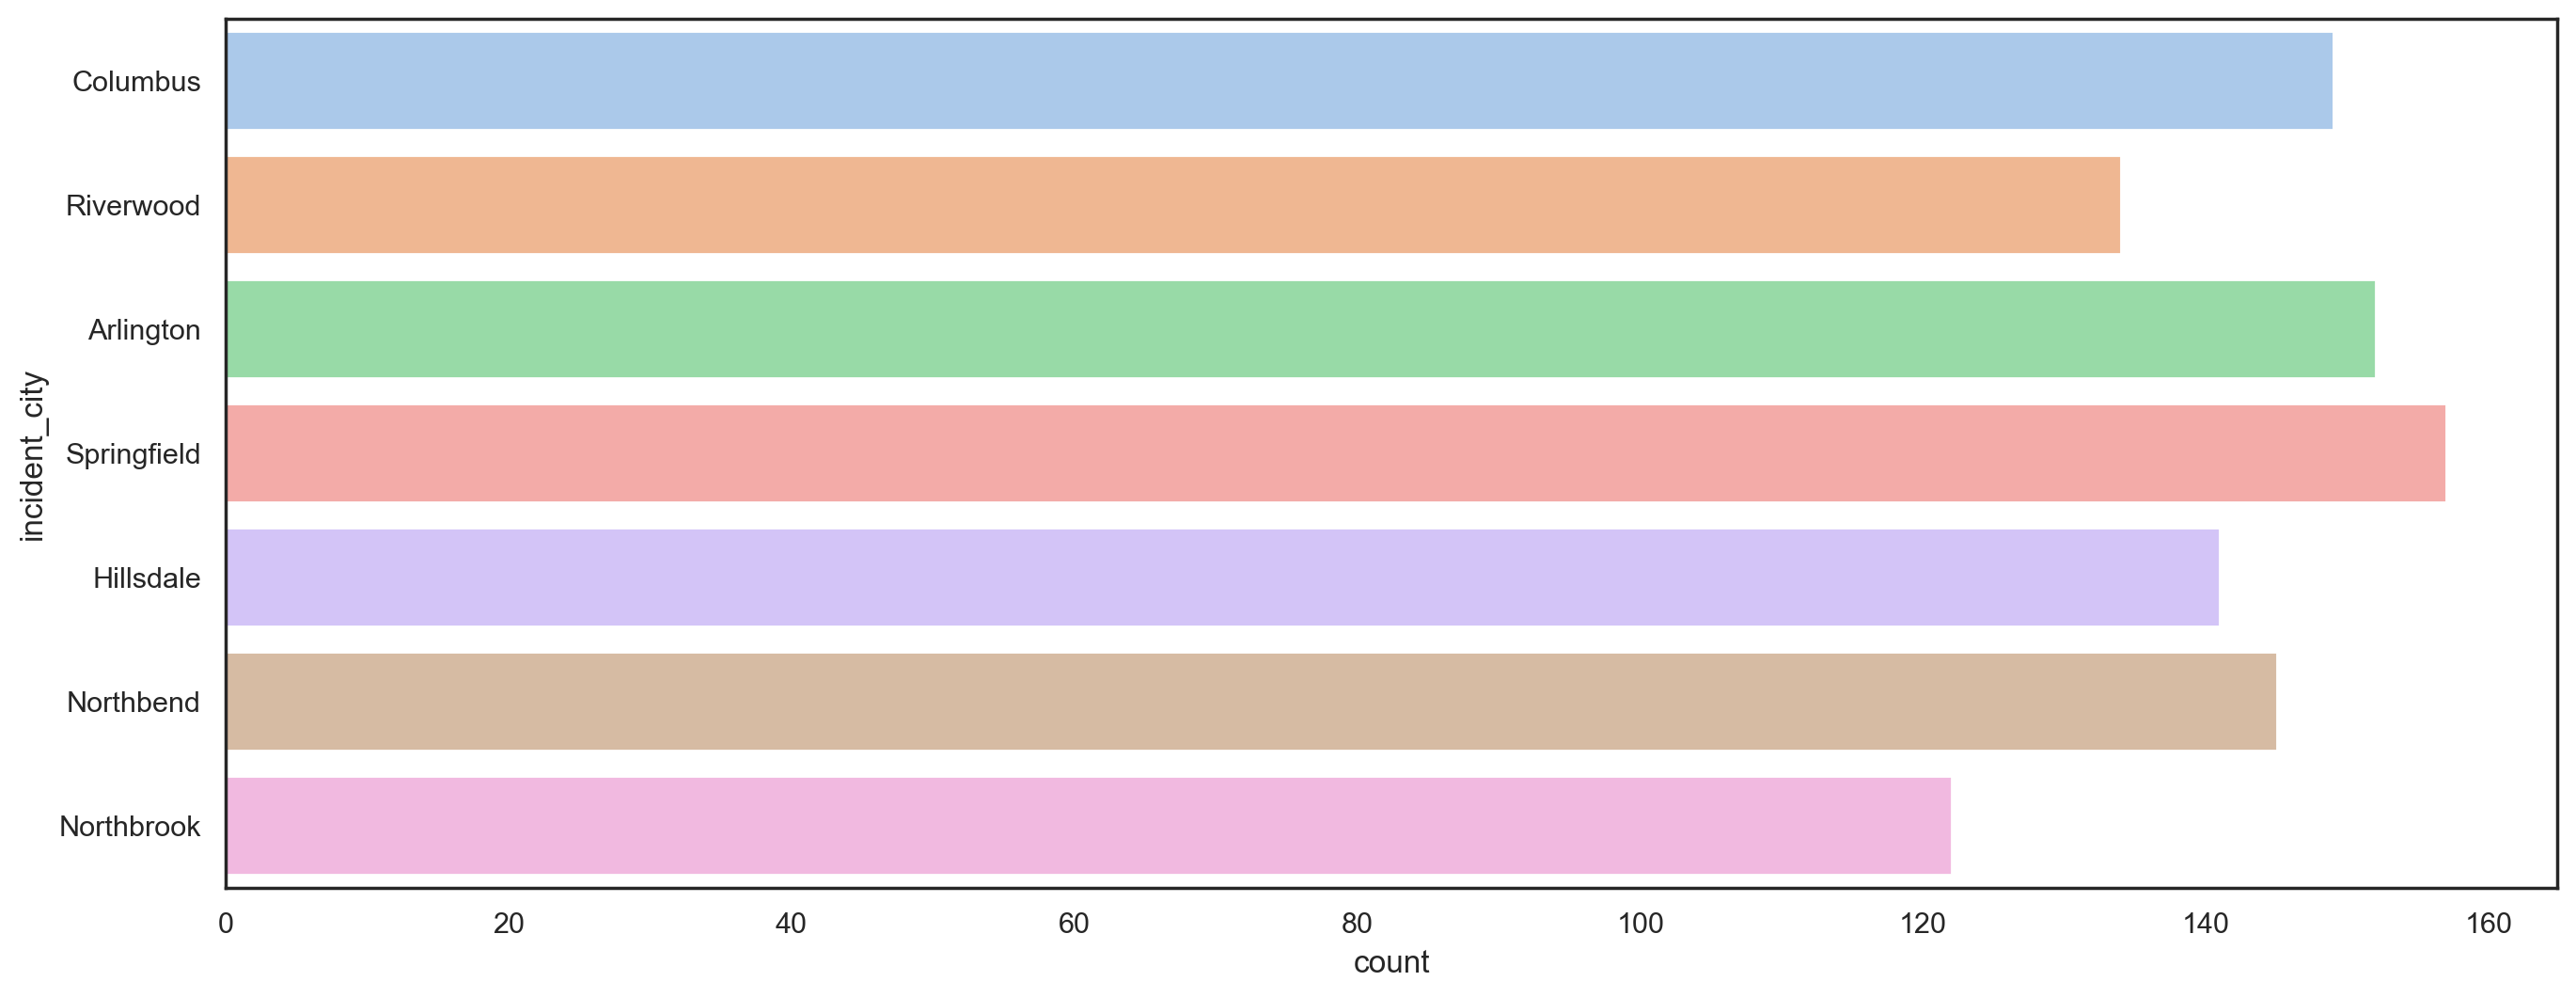

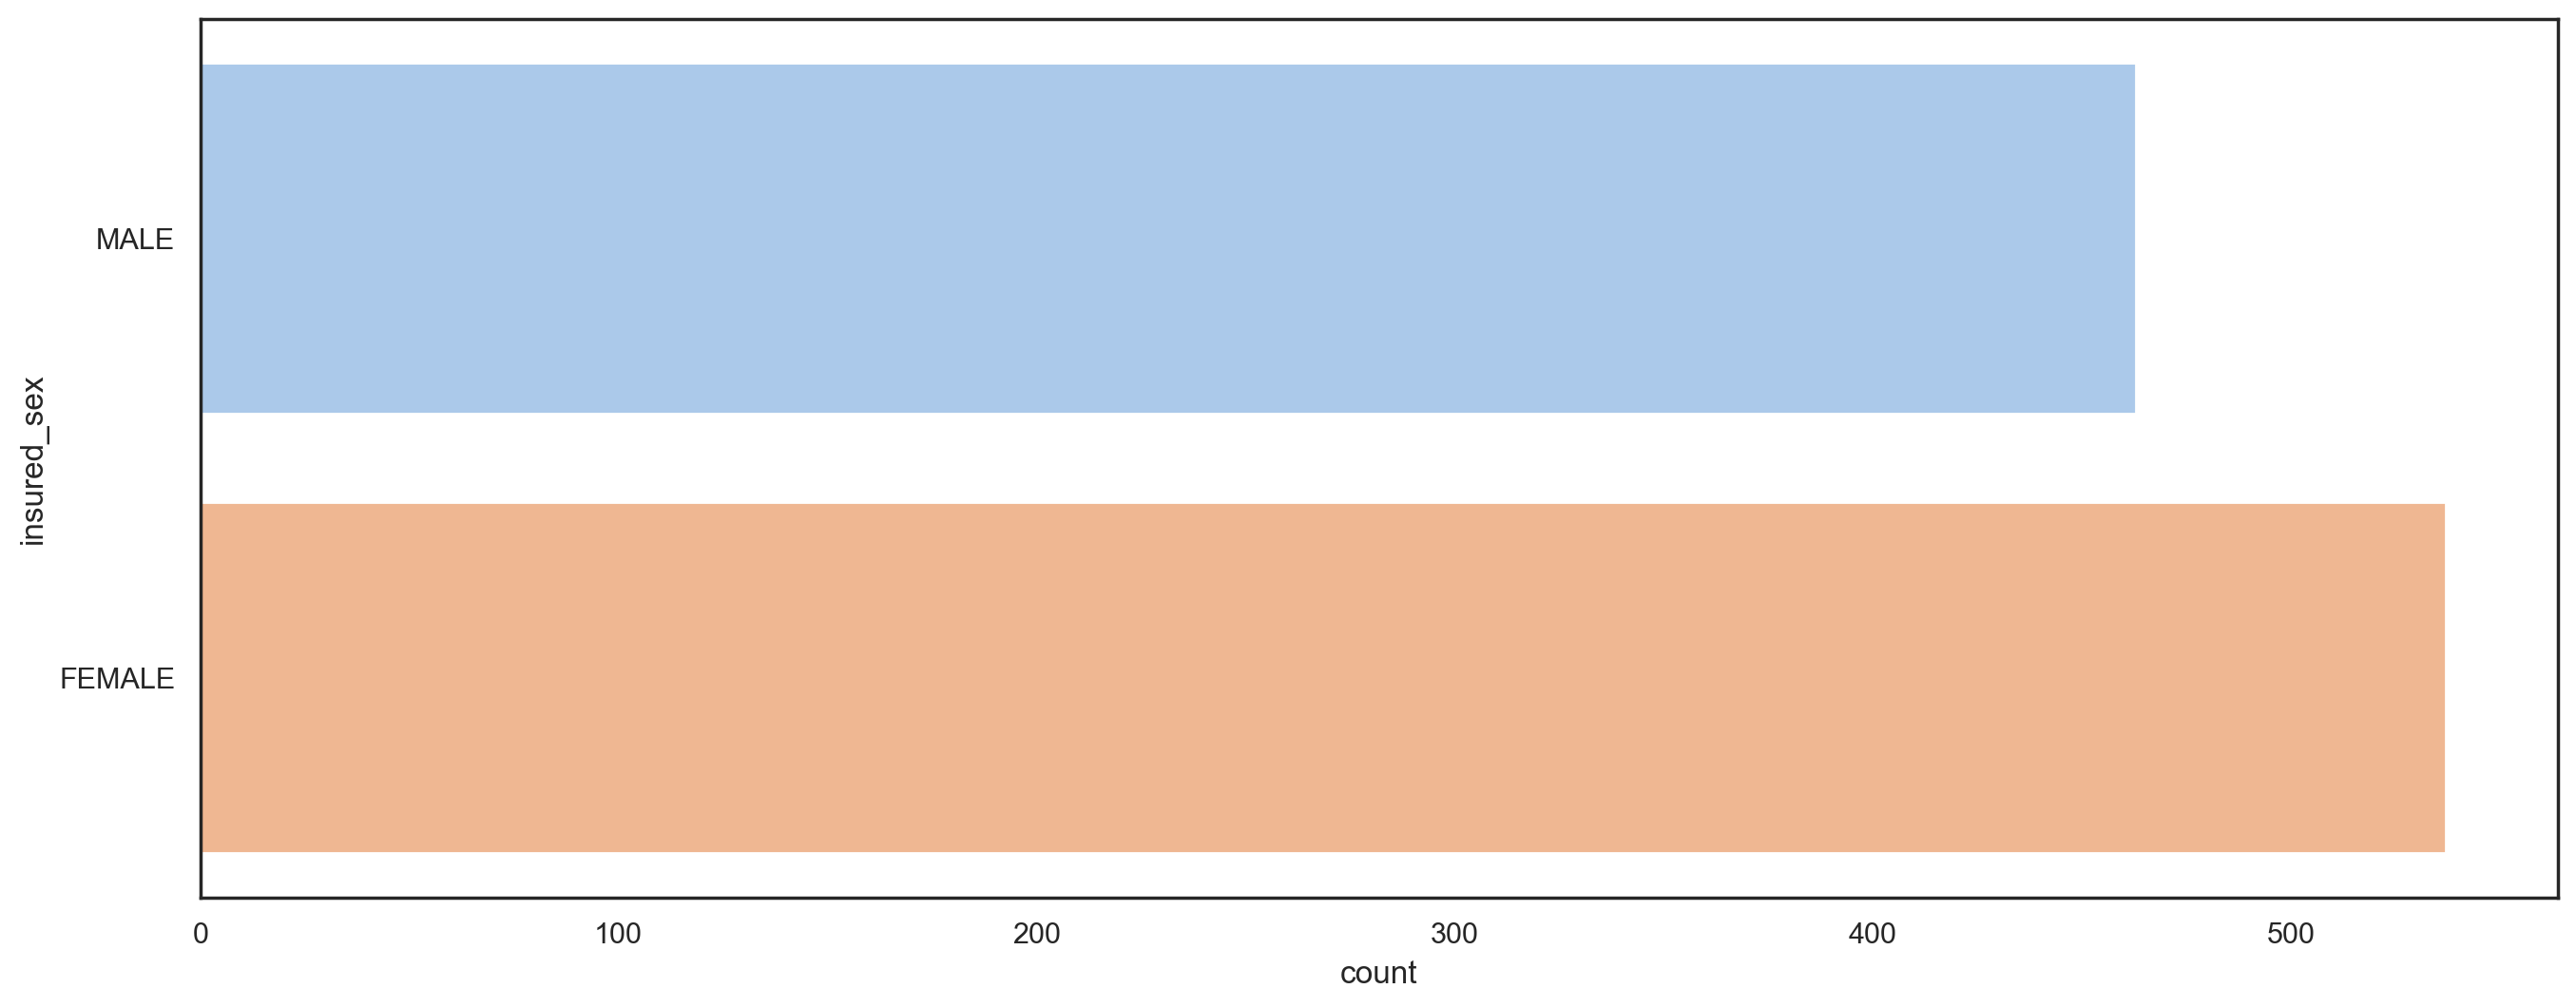

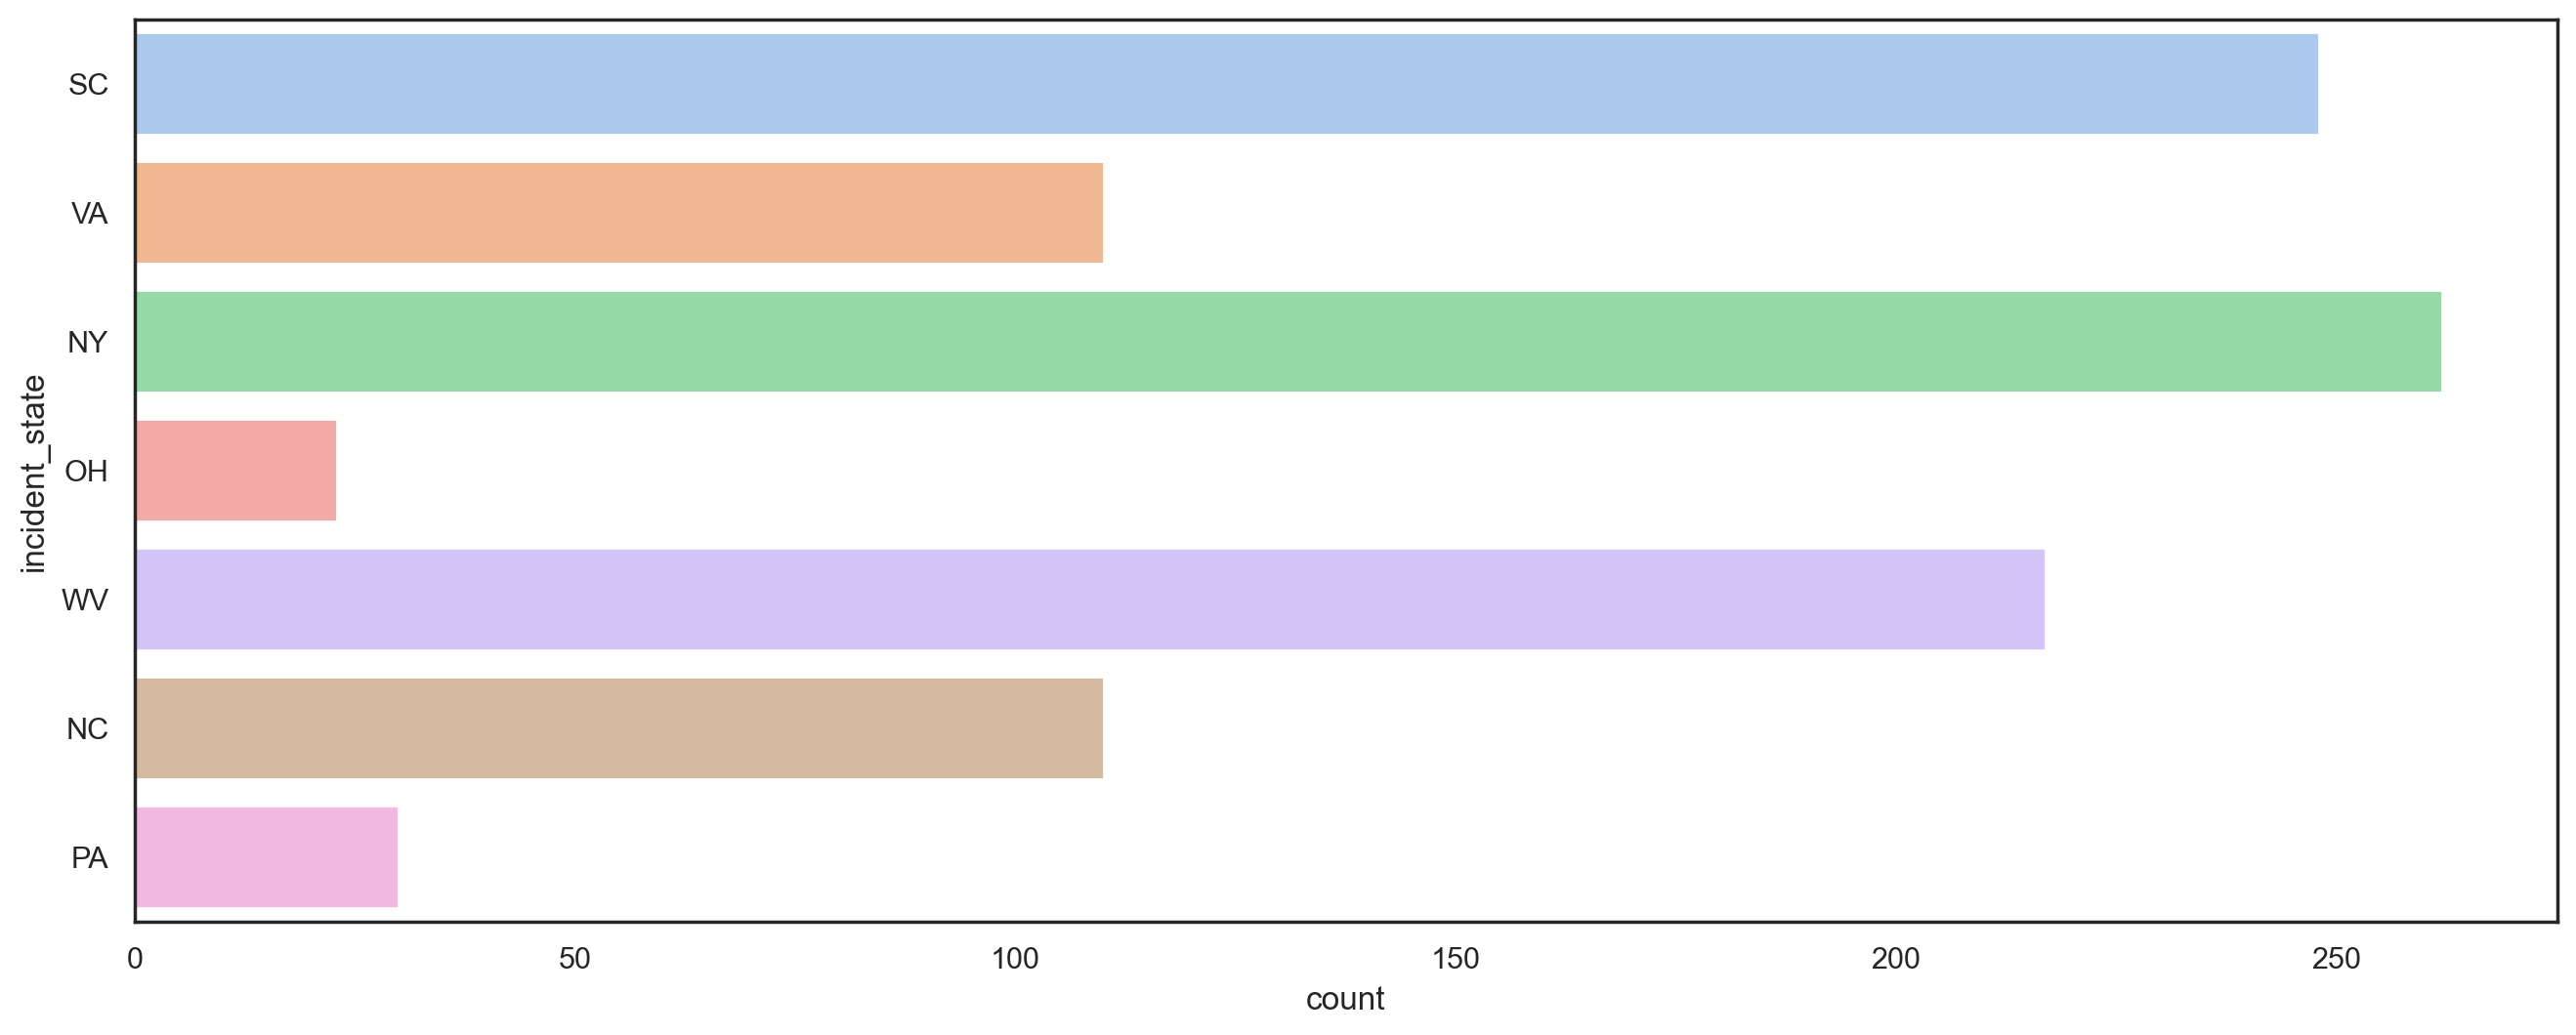

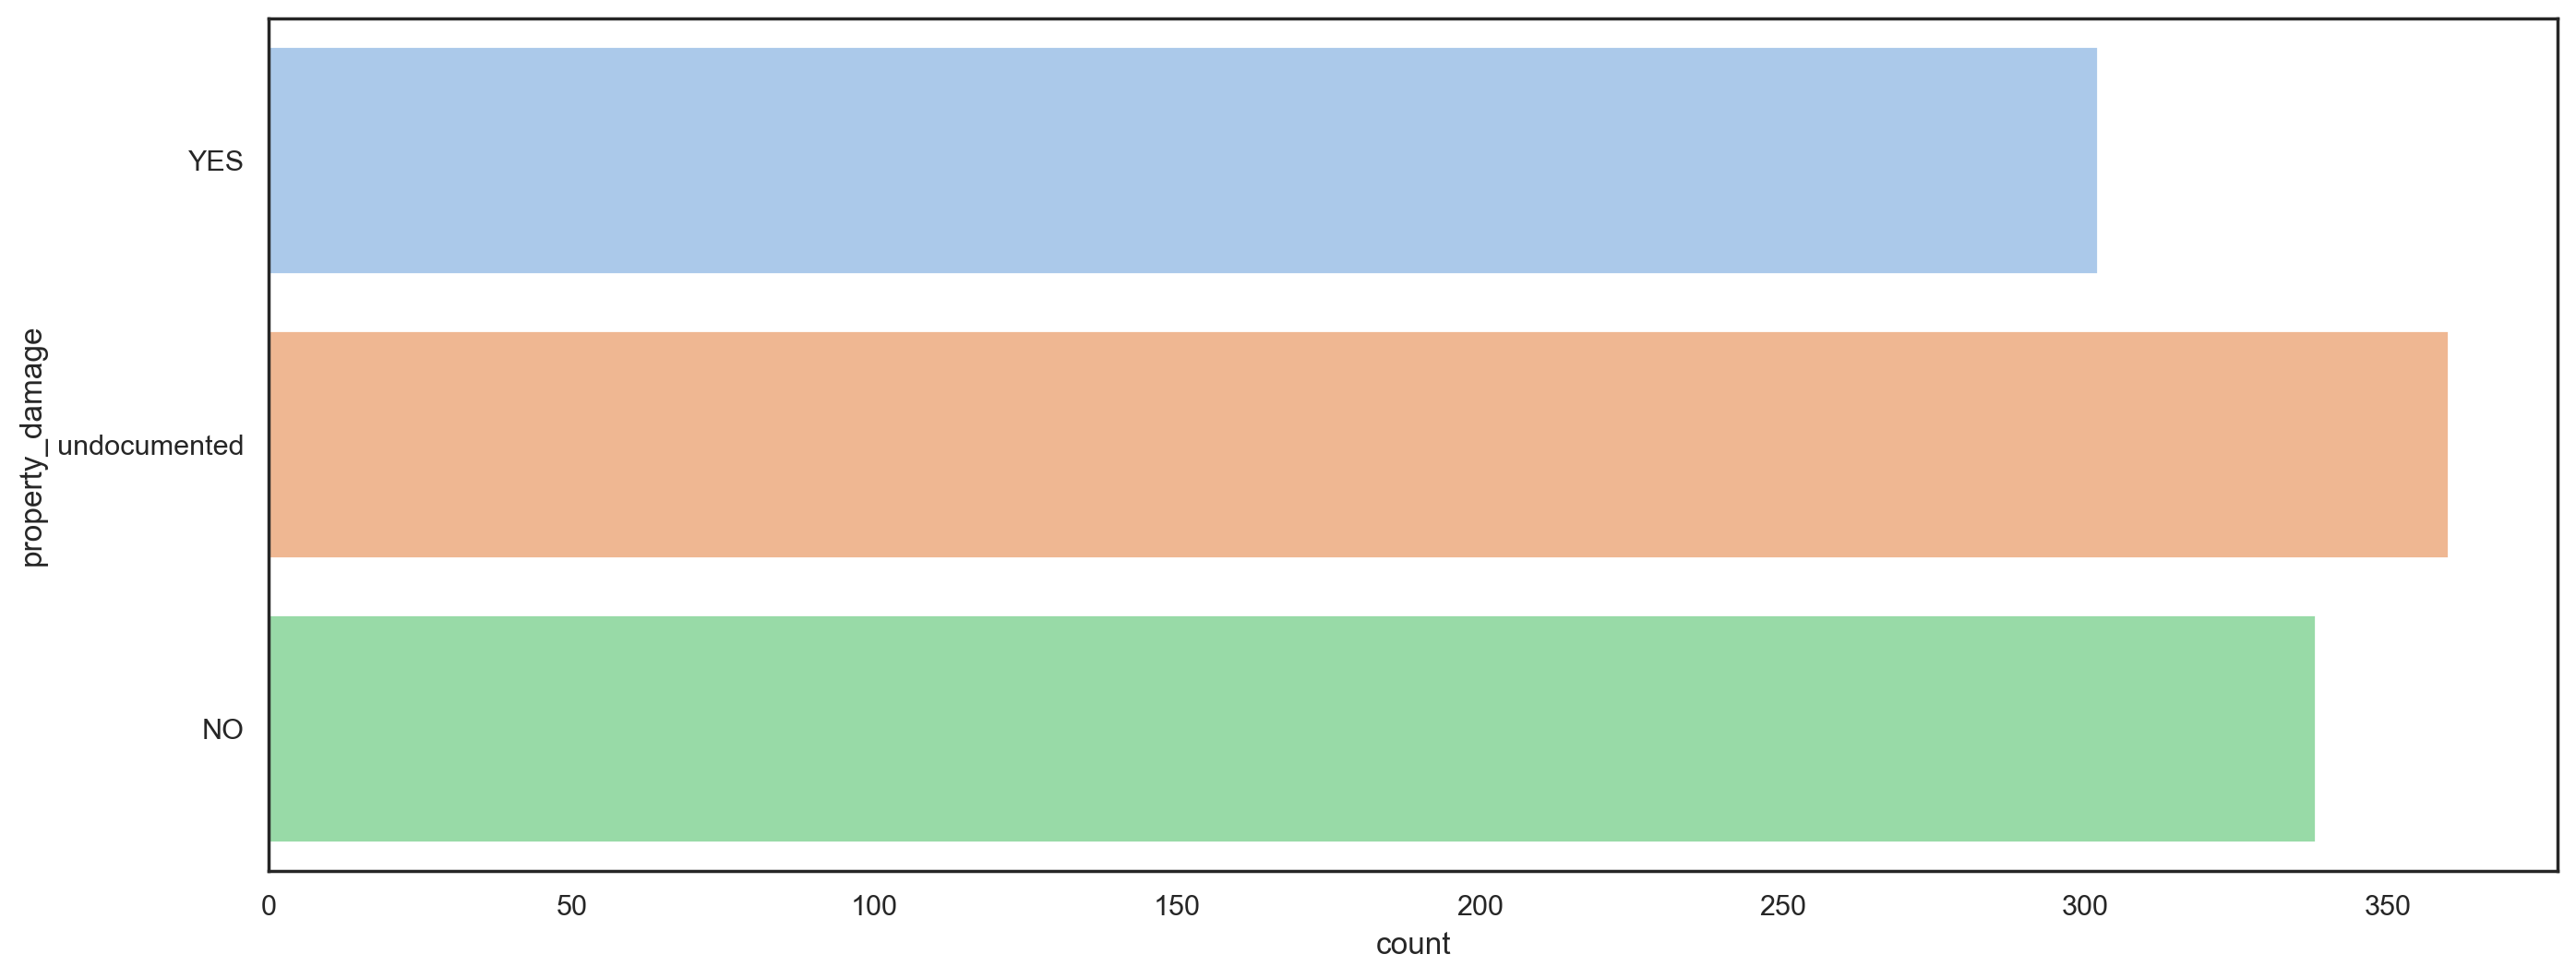

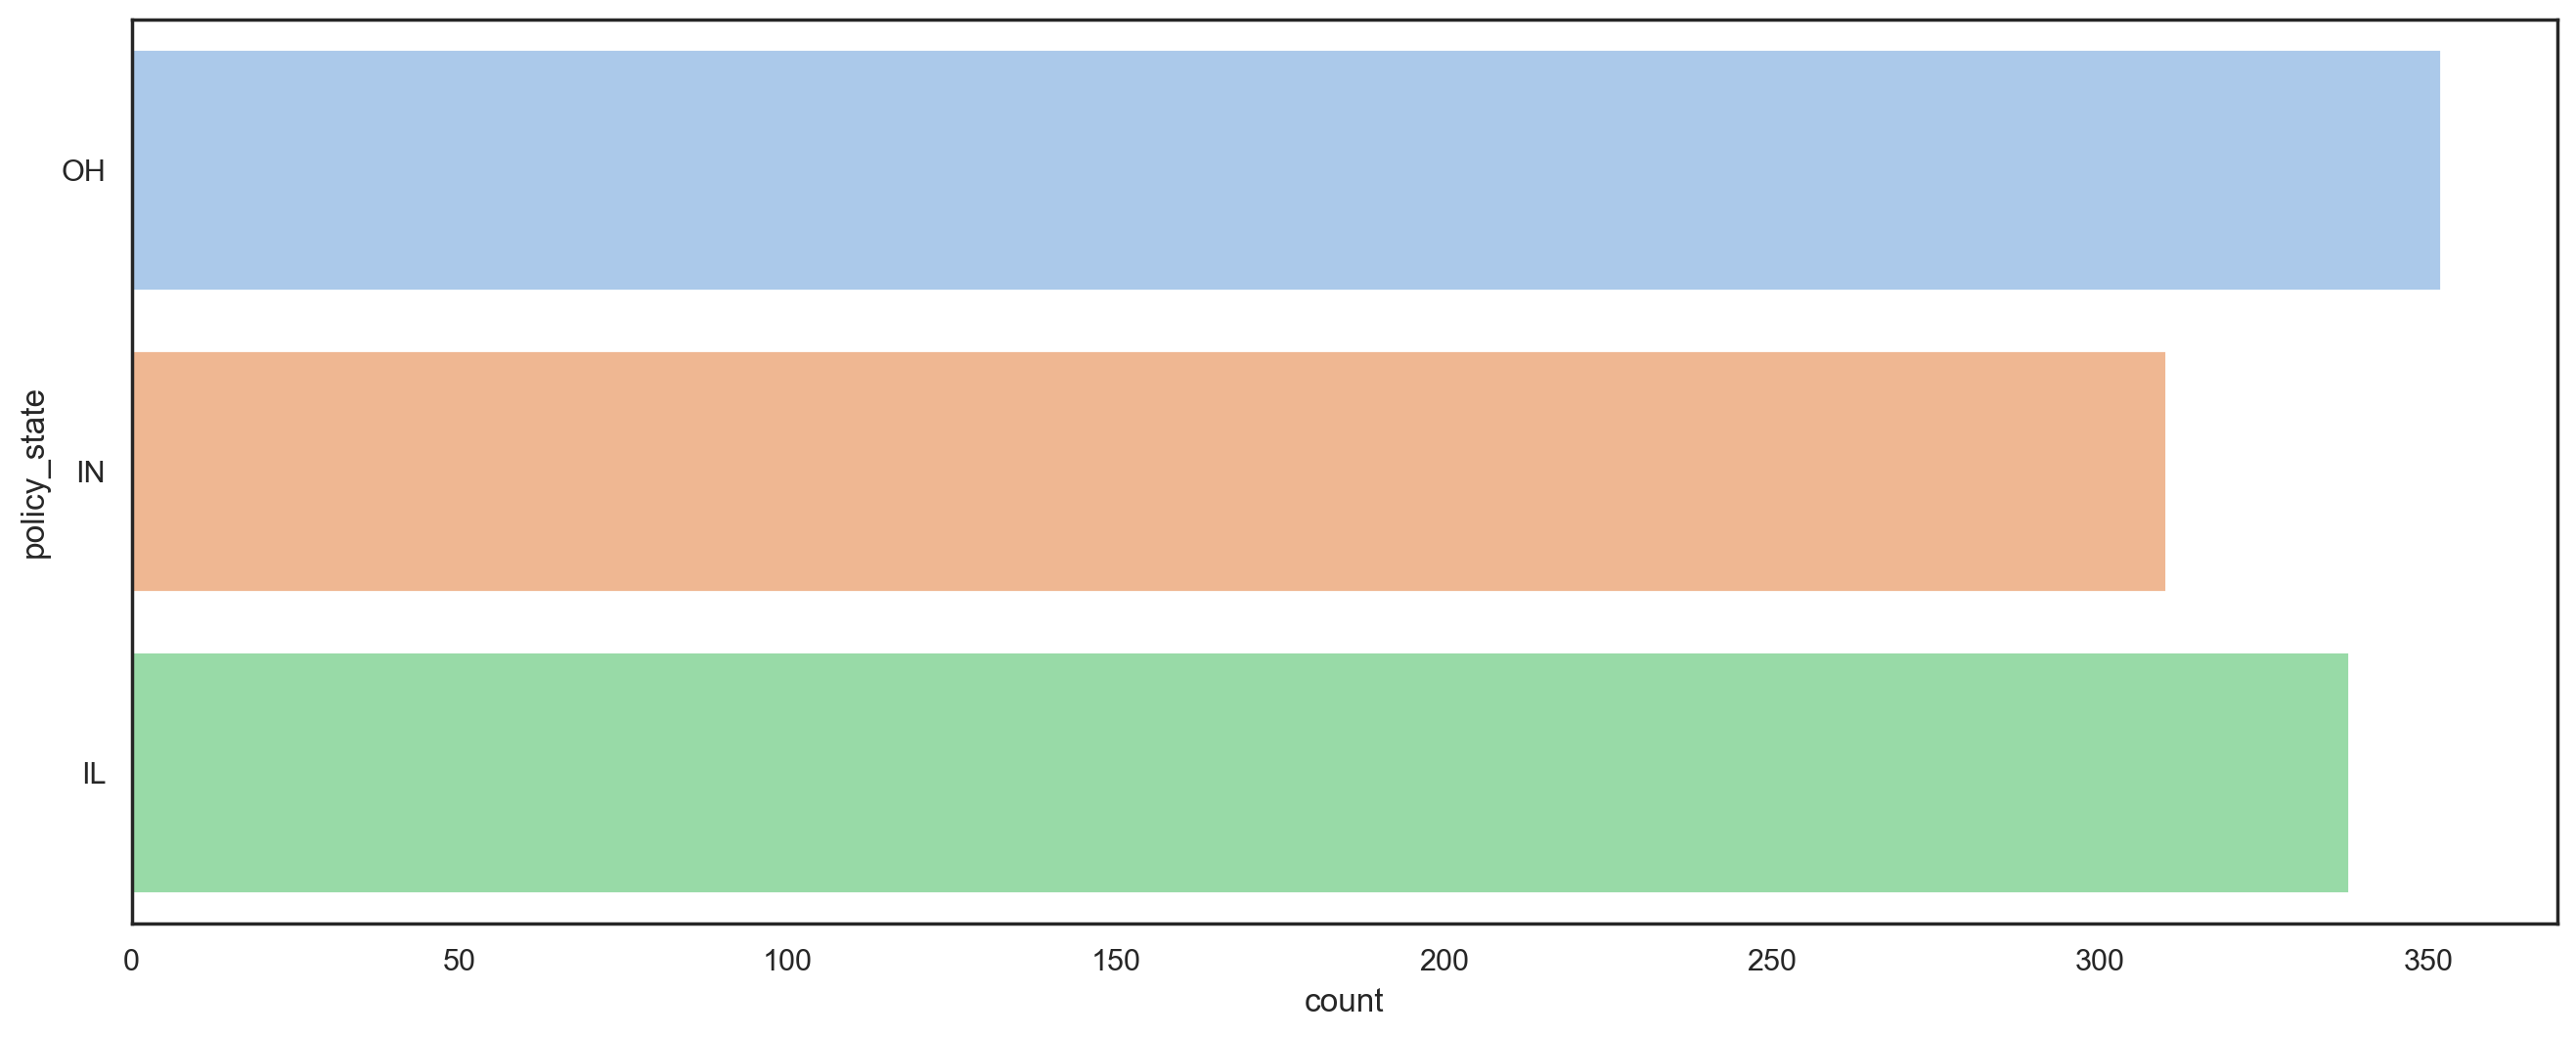

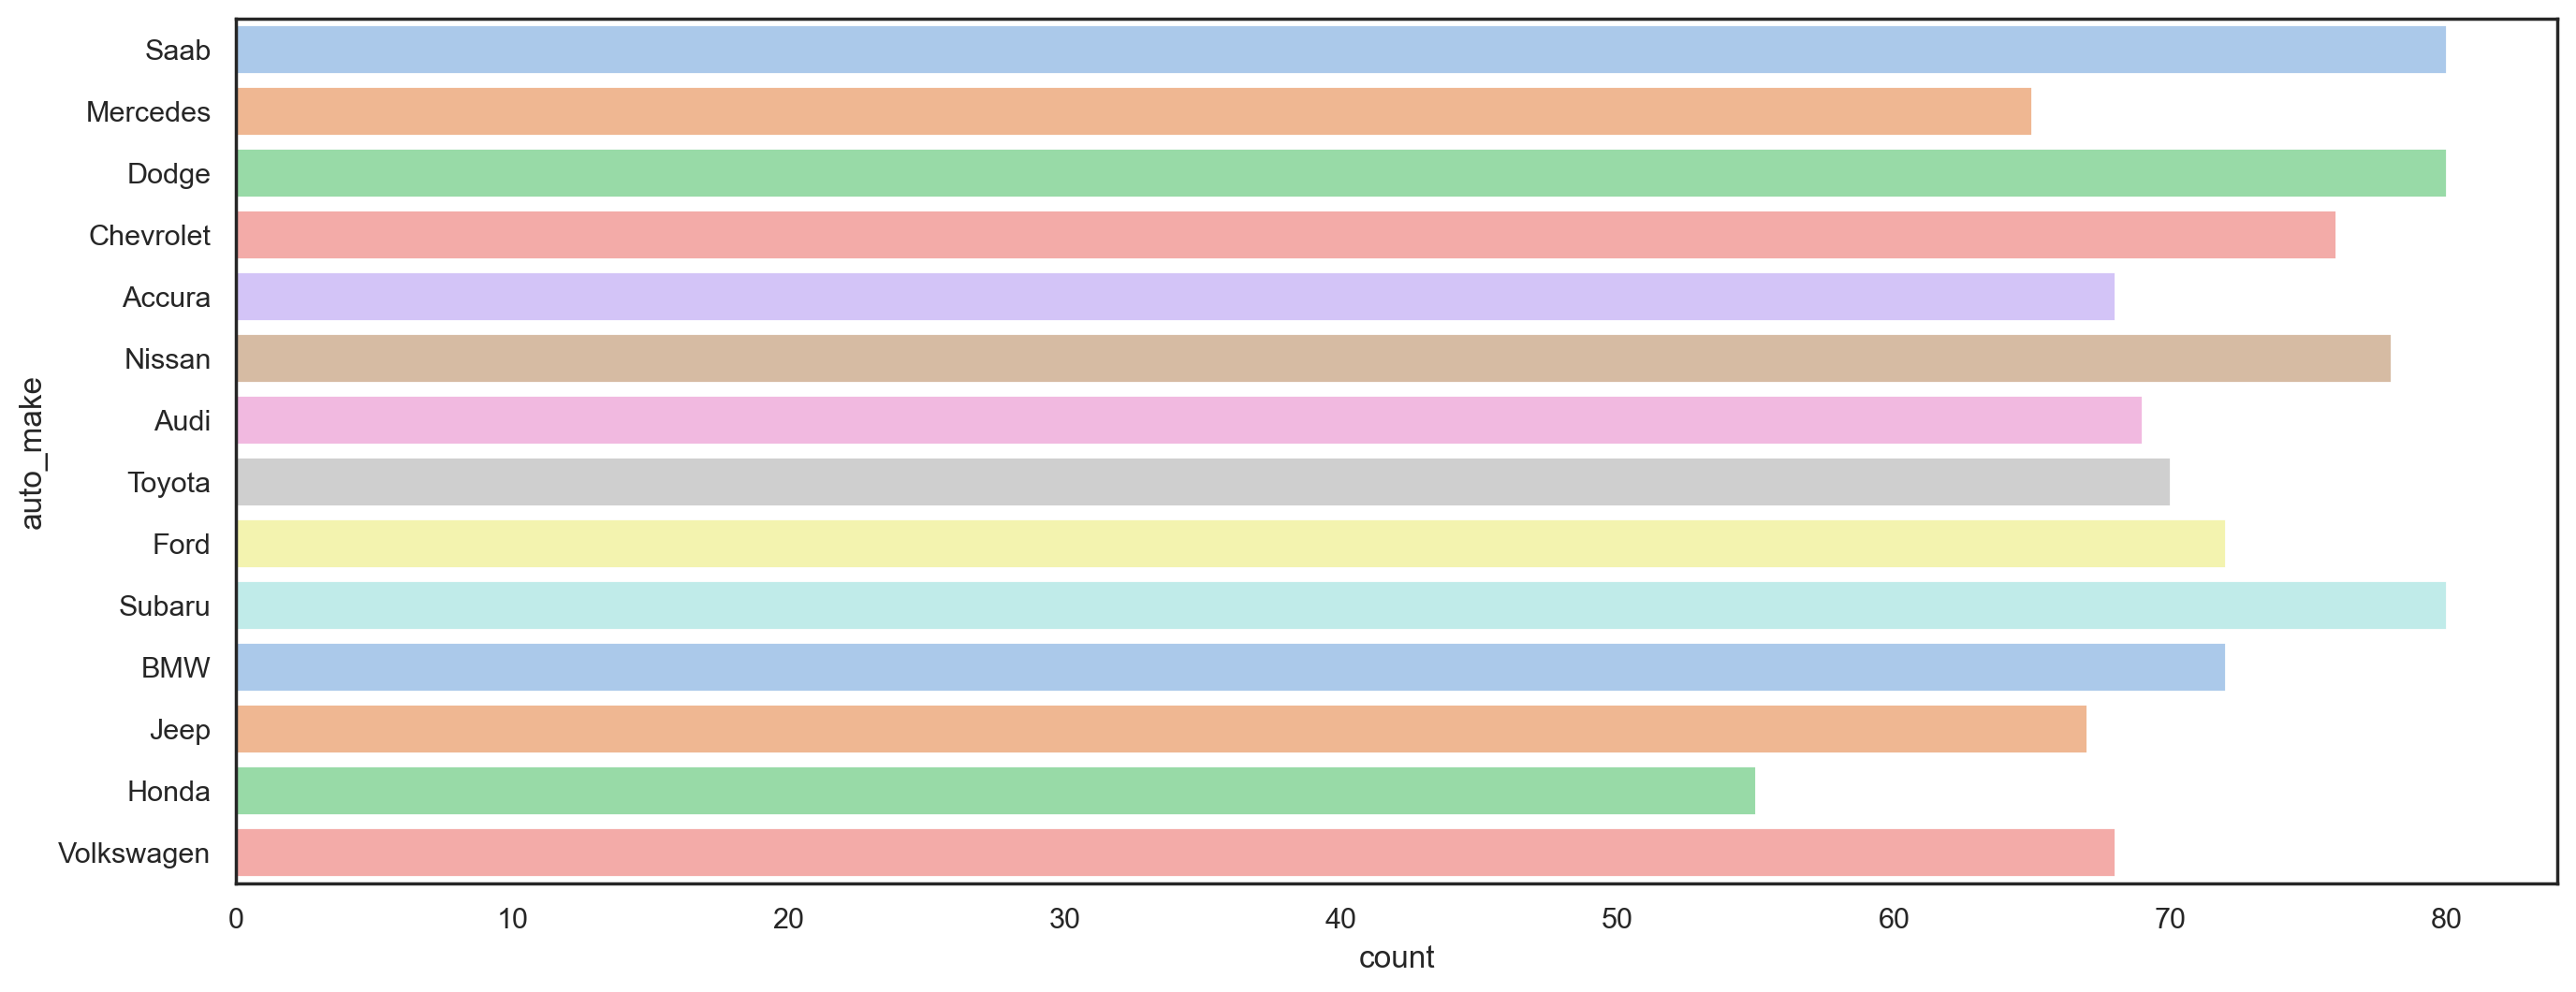

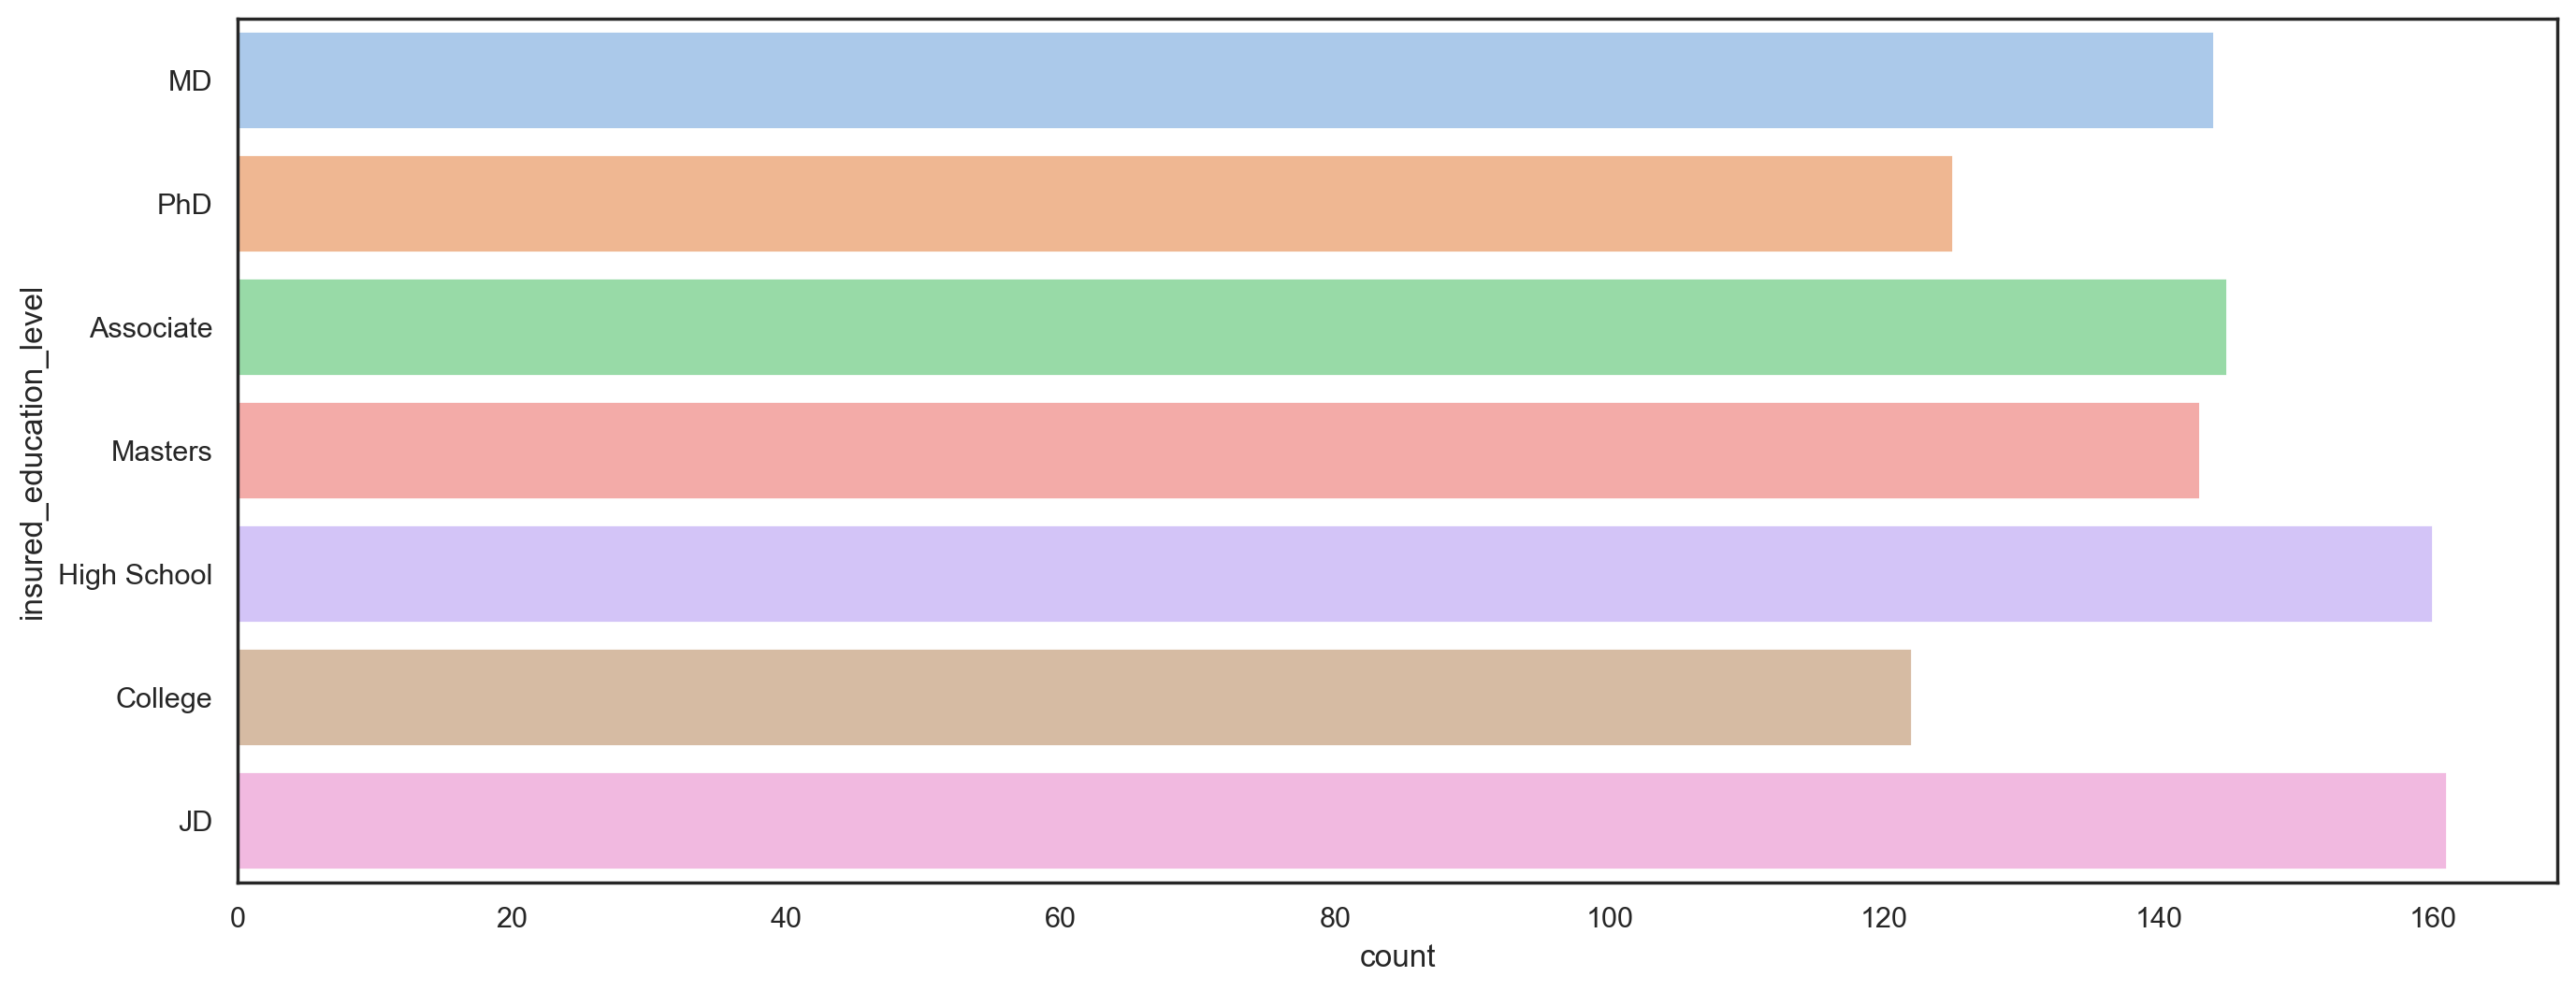

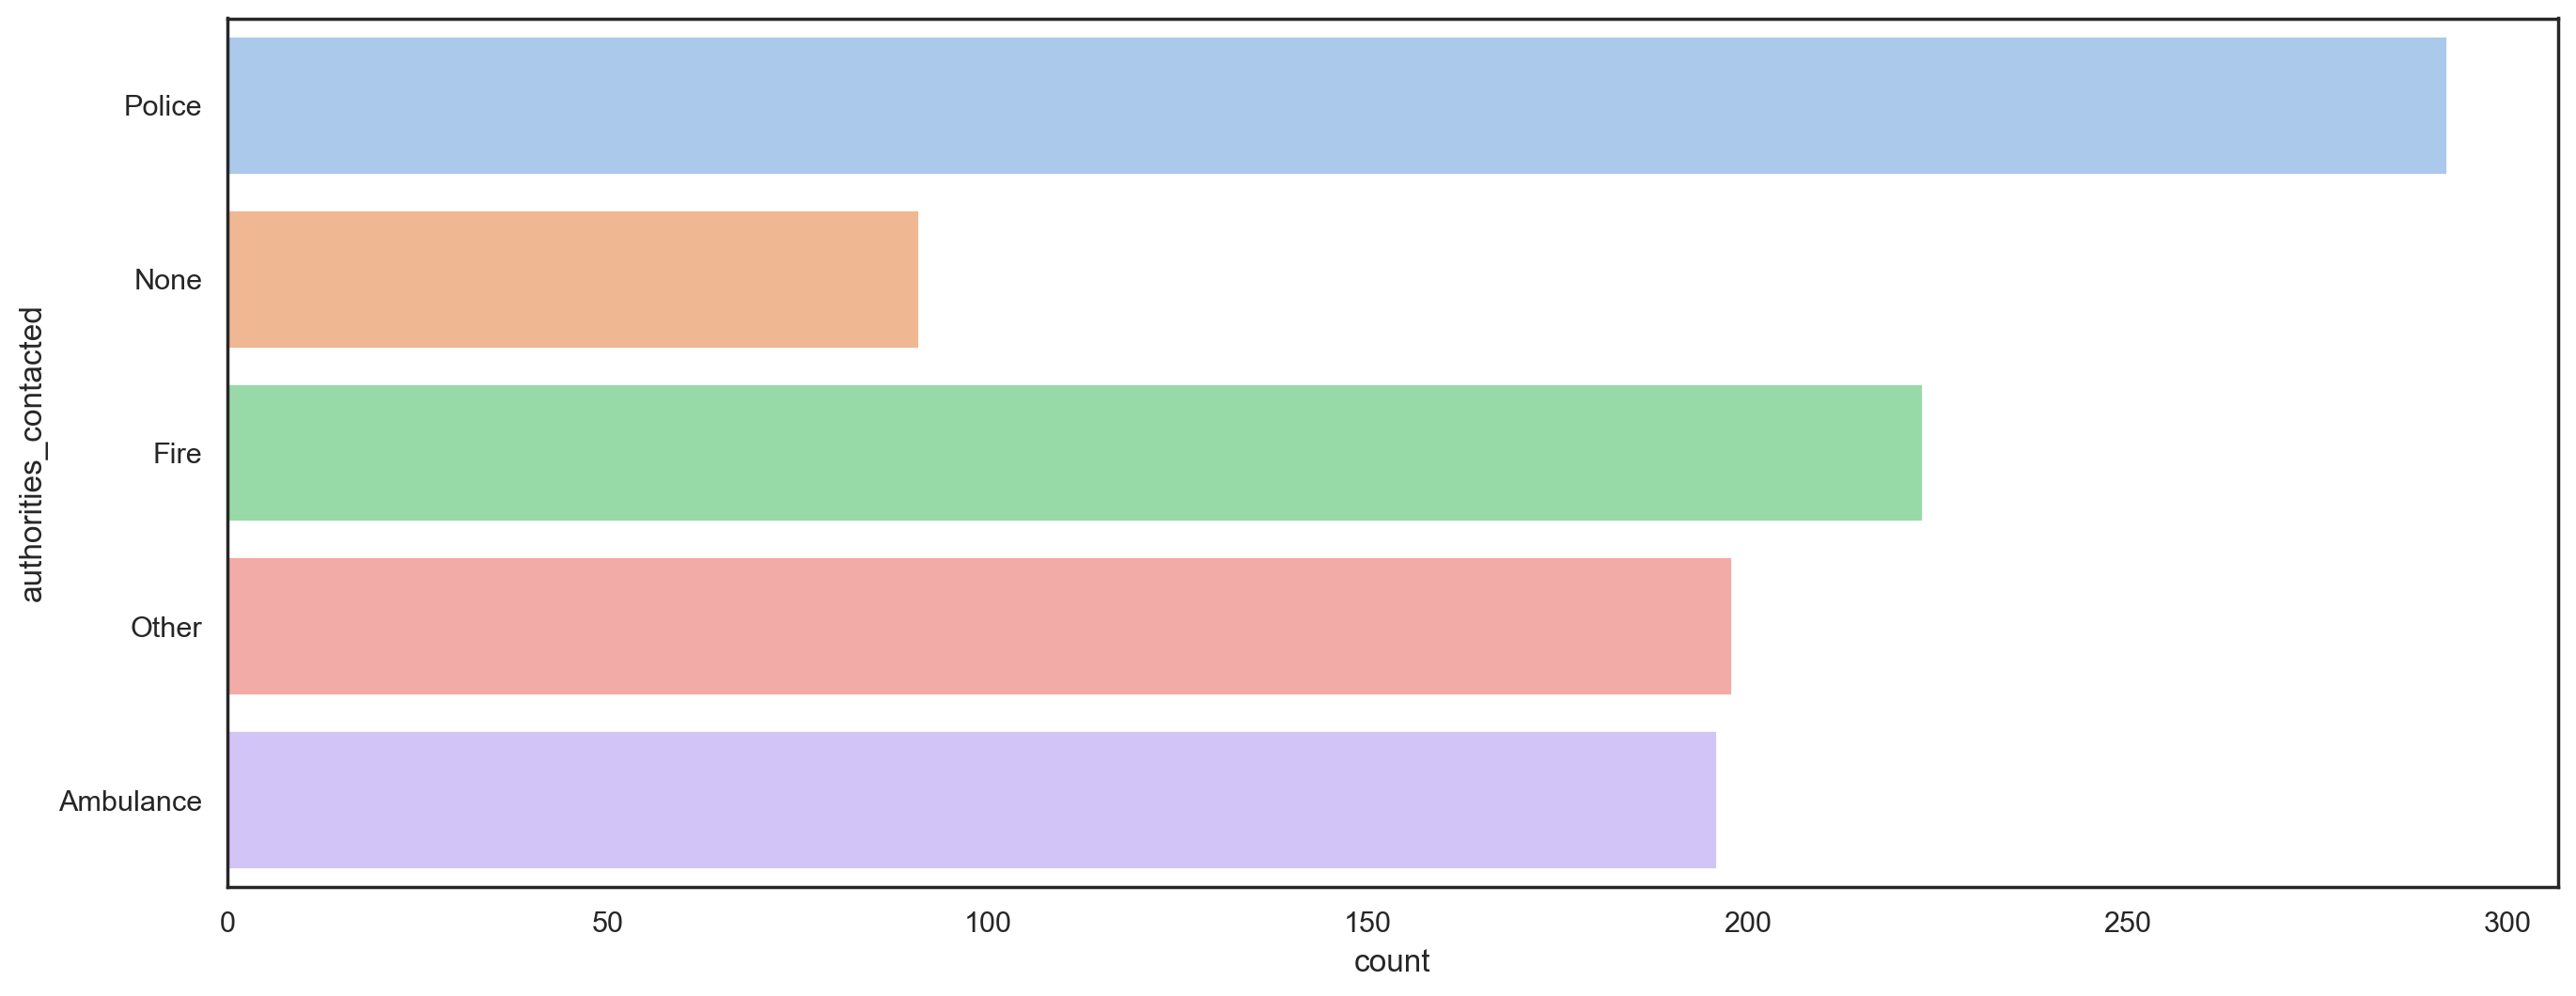

In [39]:
#countplot of discrete var , 

for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(16,6))
    sns.countplot(y=name, data=df, palette="pastel")

Nominal variables' counts were visualized with bar plots. I sum up some observations in point: 

- **Authorities_contacted:** Police are the most frequently contacted followed by the fire brigades. 
- **Auto_make:** apart from Honda (least), most are relatively even. 
- **Collision_type:** the distribution looks evenly spread across the categories. Most are rear collisions. Smallest groups are the undocumented collisions. we can explore which collisions will be the most expensive and have the most frauds.
- **Incident_city:** relatively even with Springfield and Arlington being the highest. 
- **Incident_type:** very few incidents are by theft/parked car. Most are by multivehicle collision and single vehicle collision. We can explore how claims and fraud differ across them. 
- **Property_damage:** relatively even but undocumented damage has the highest numbers

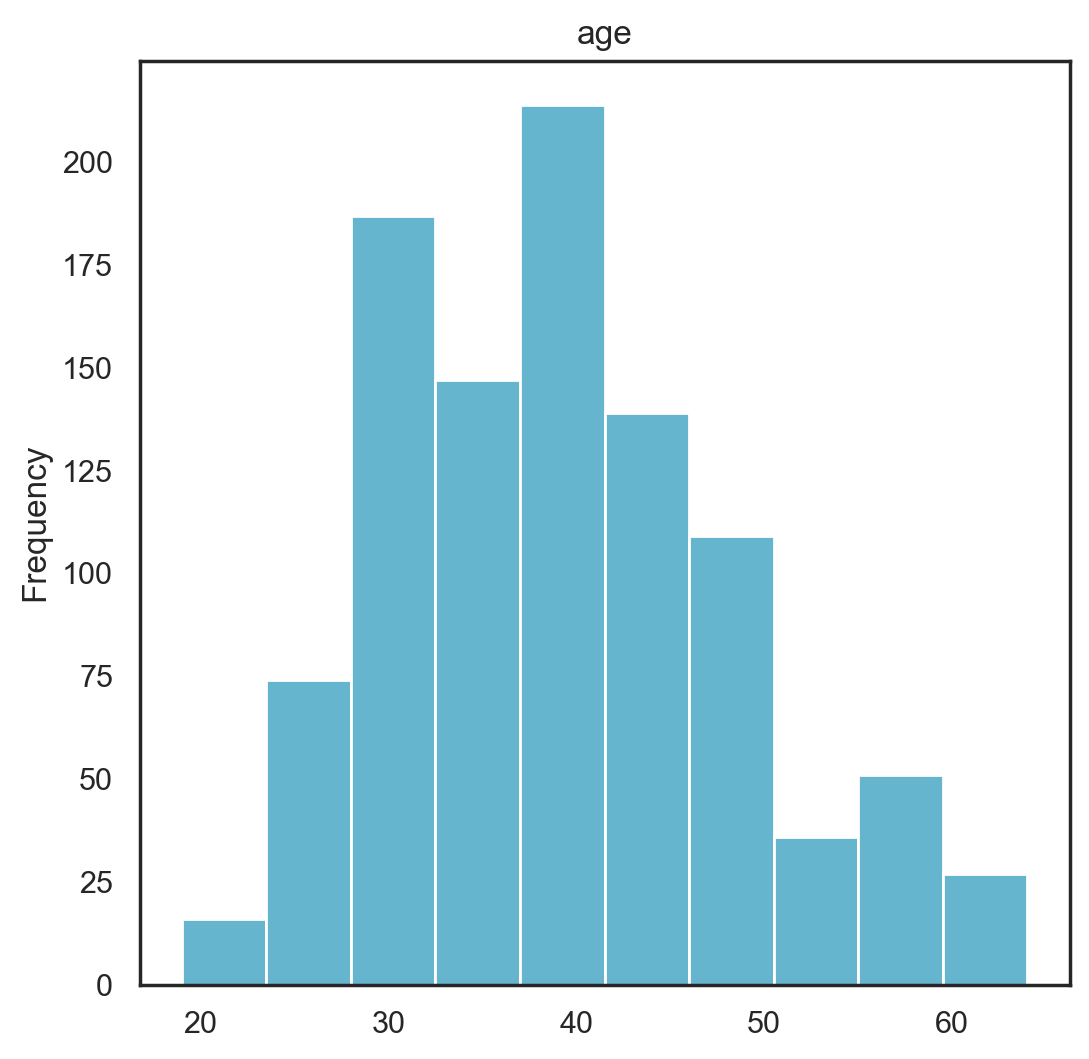

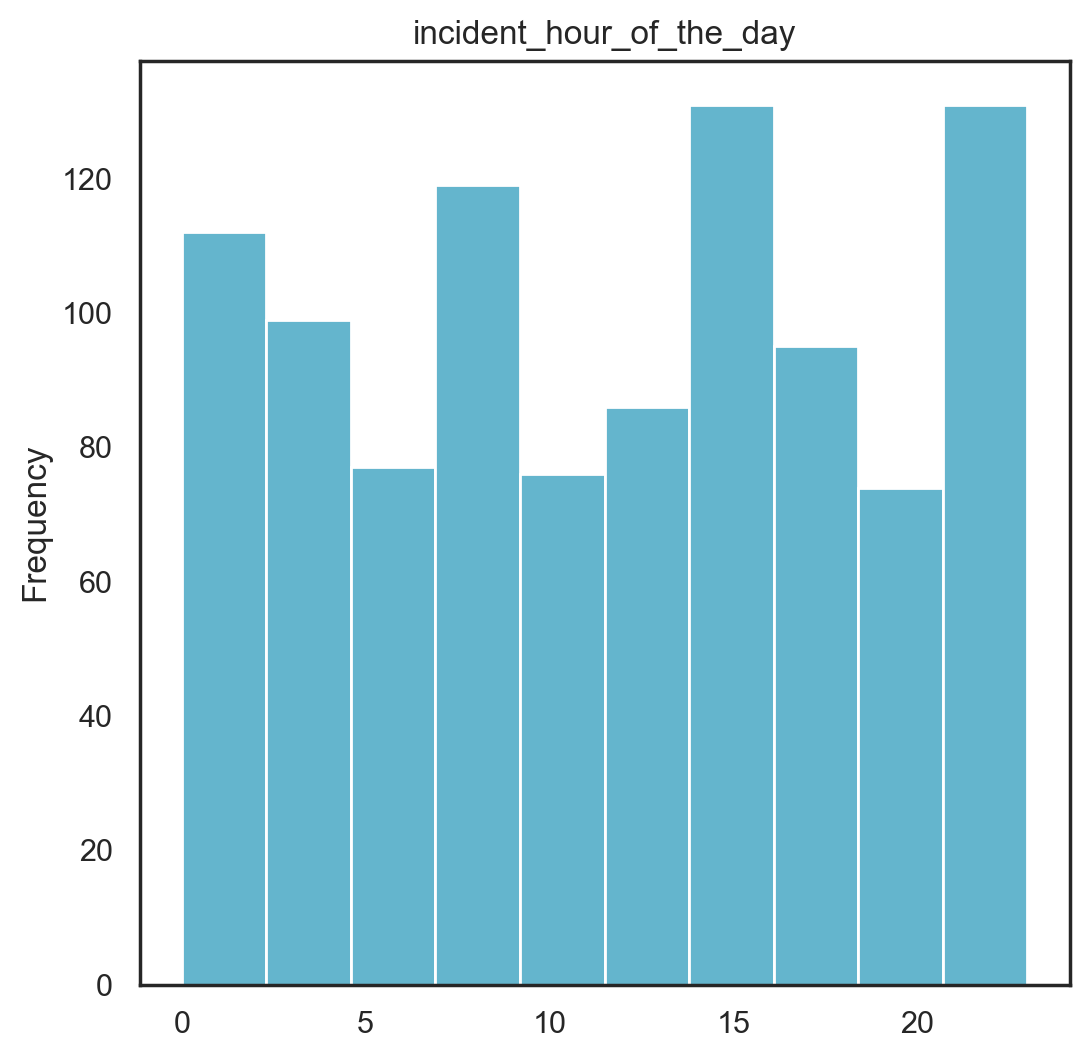

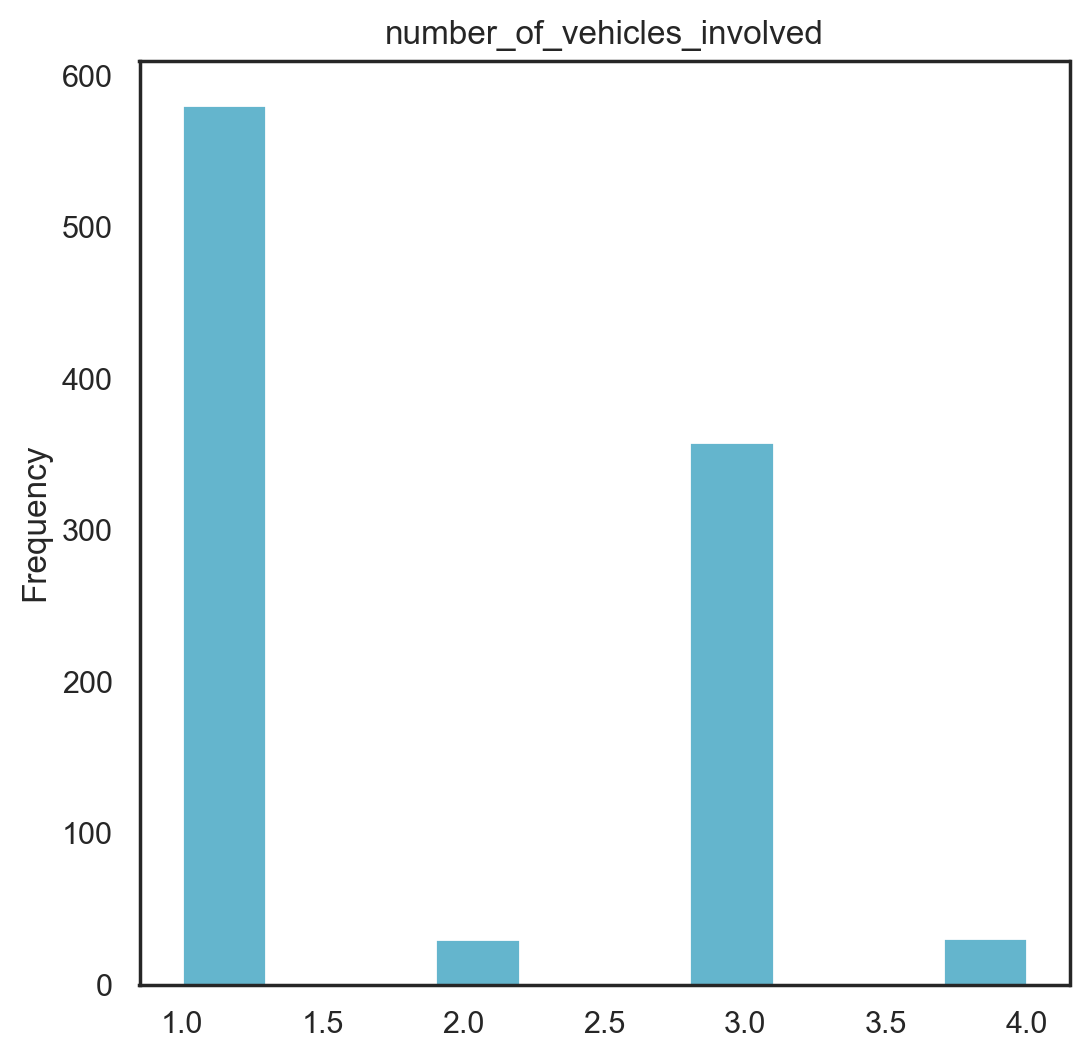

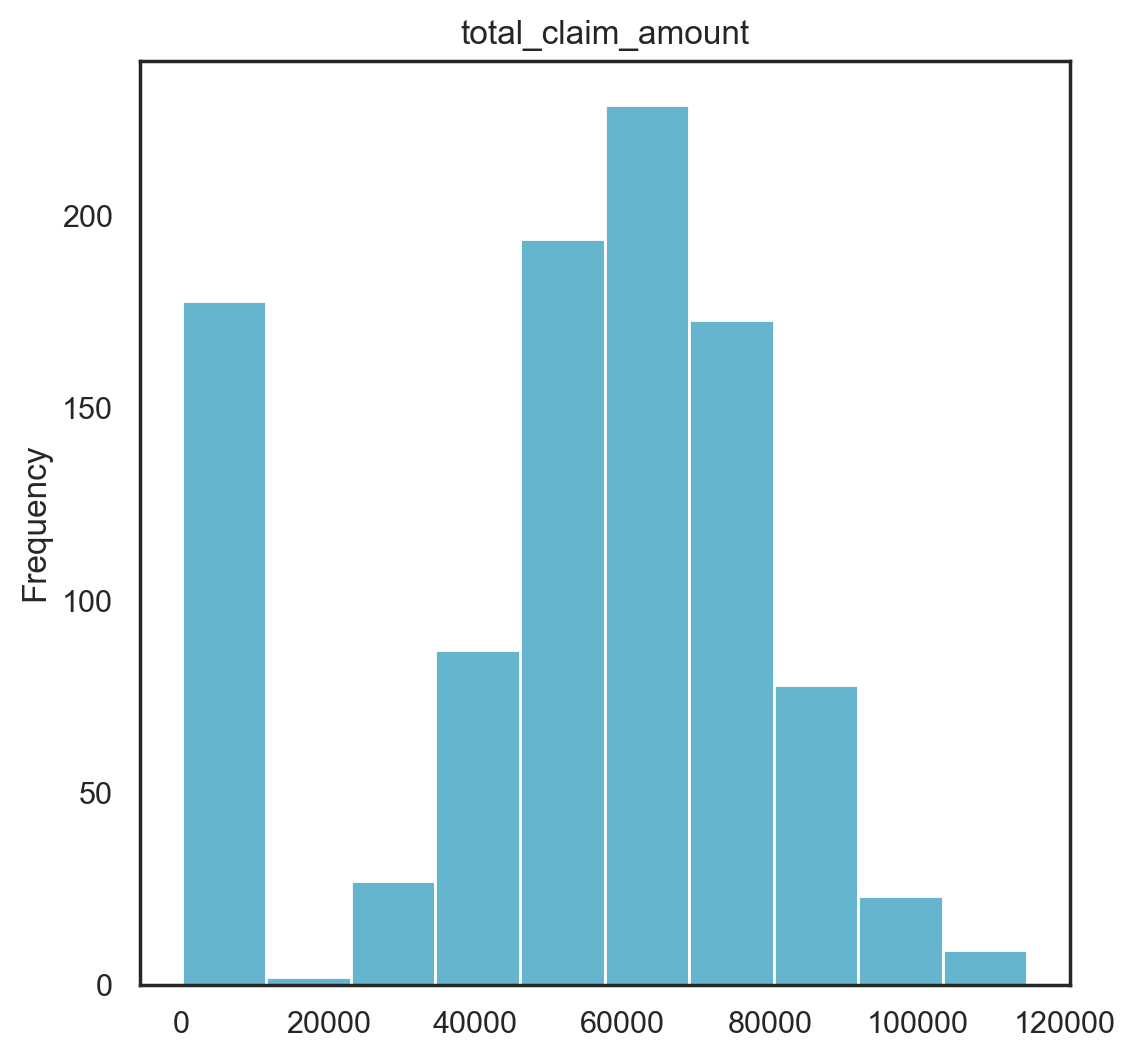

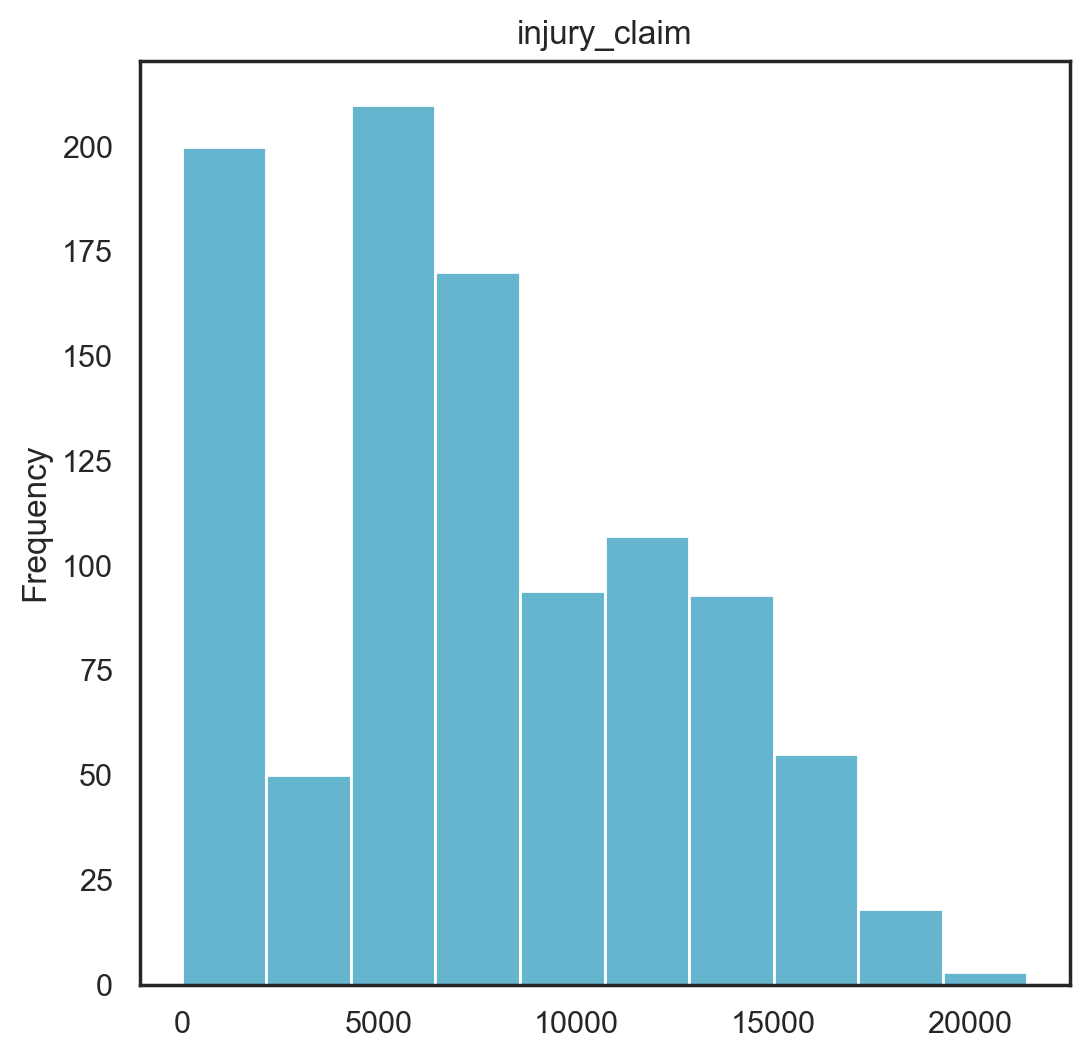

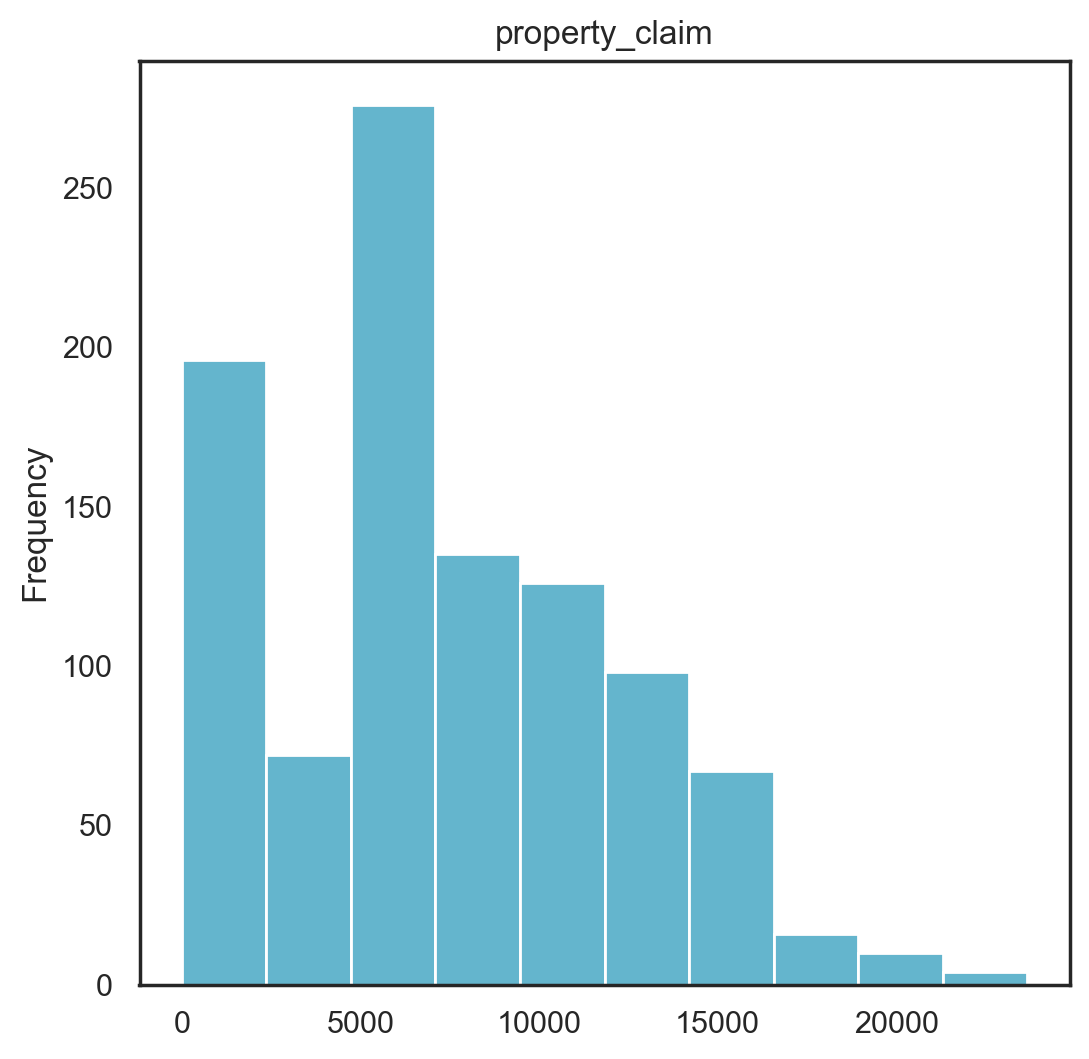

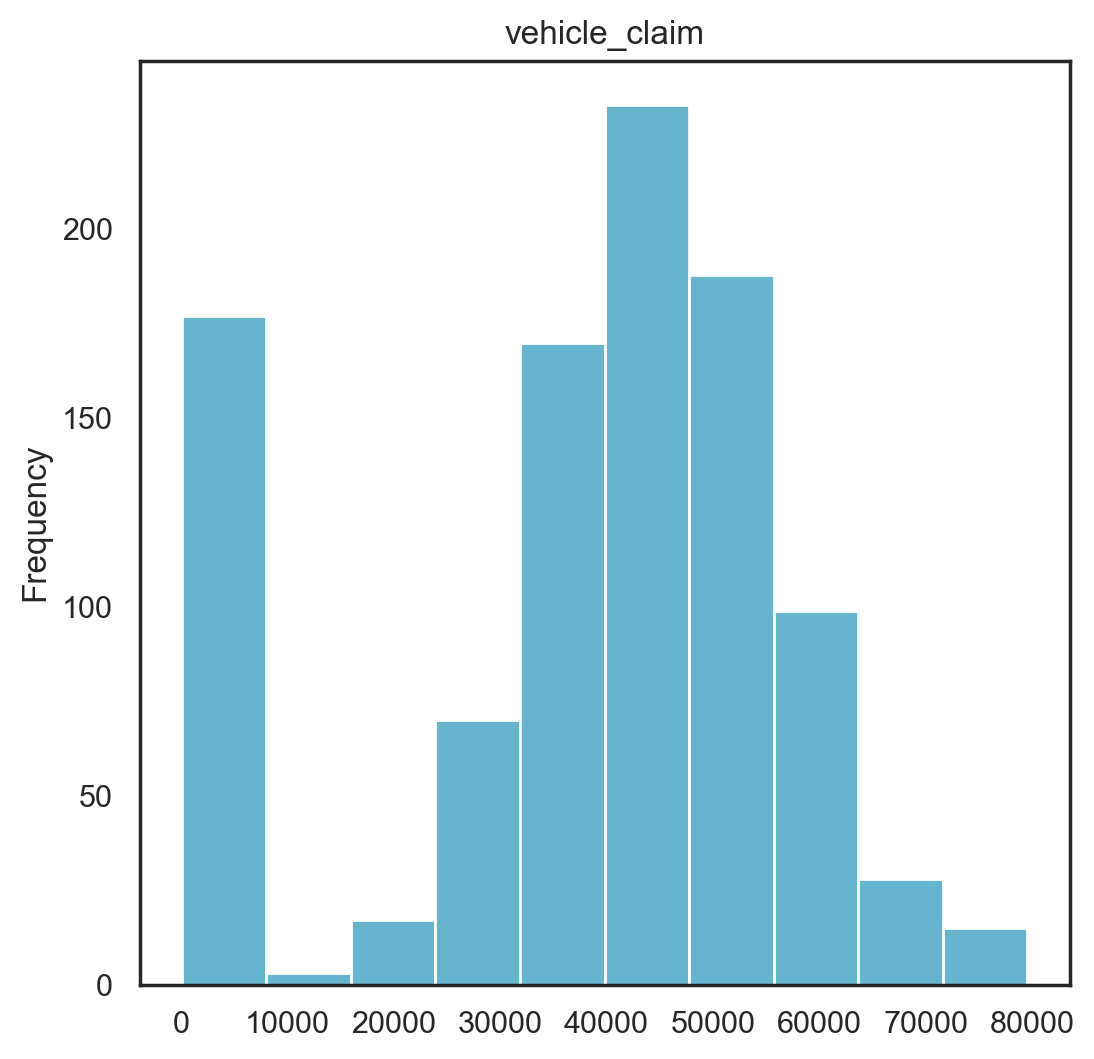

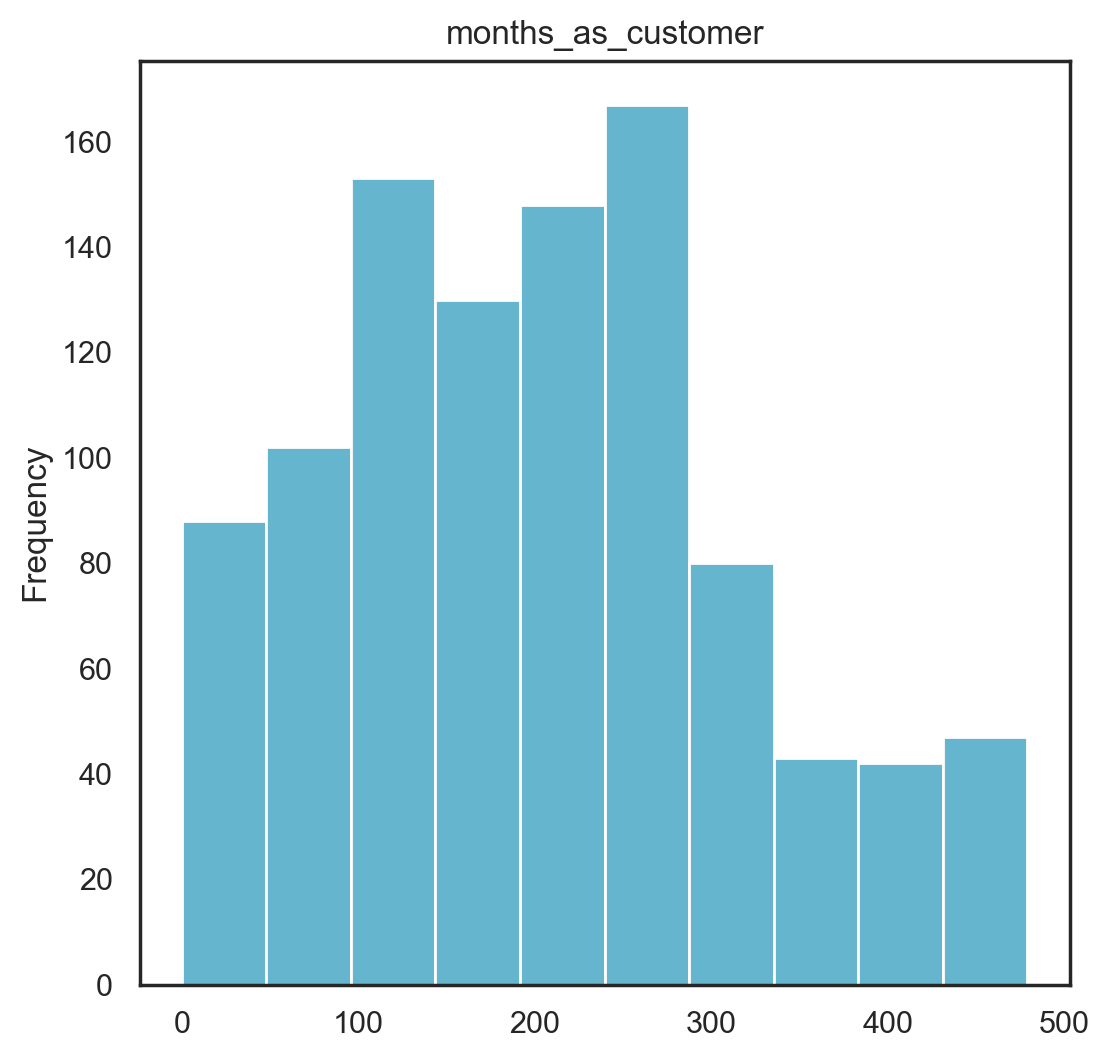

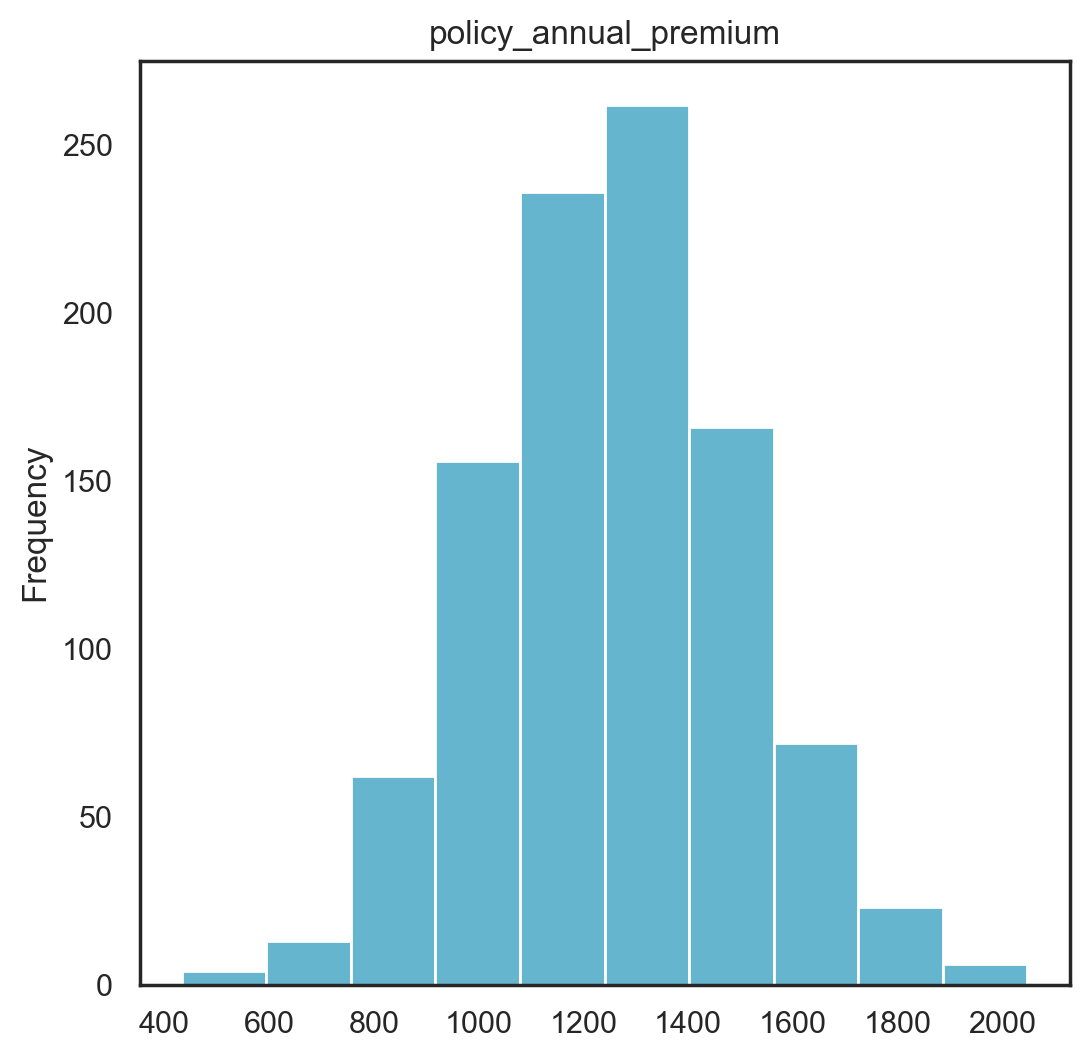

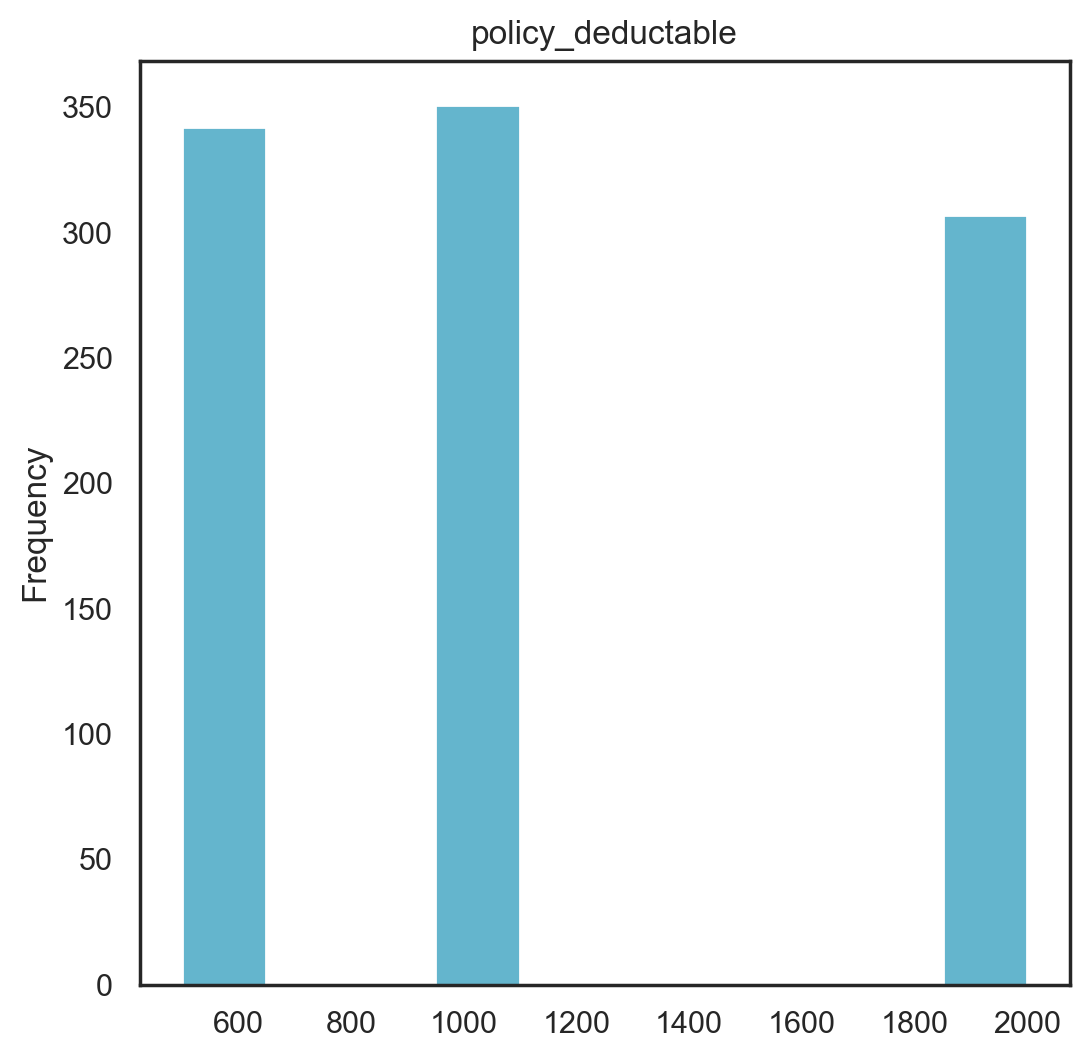

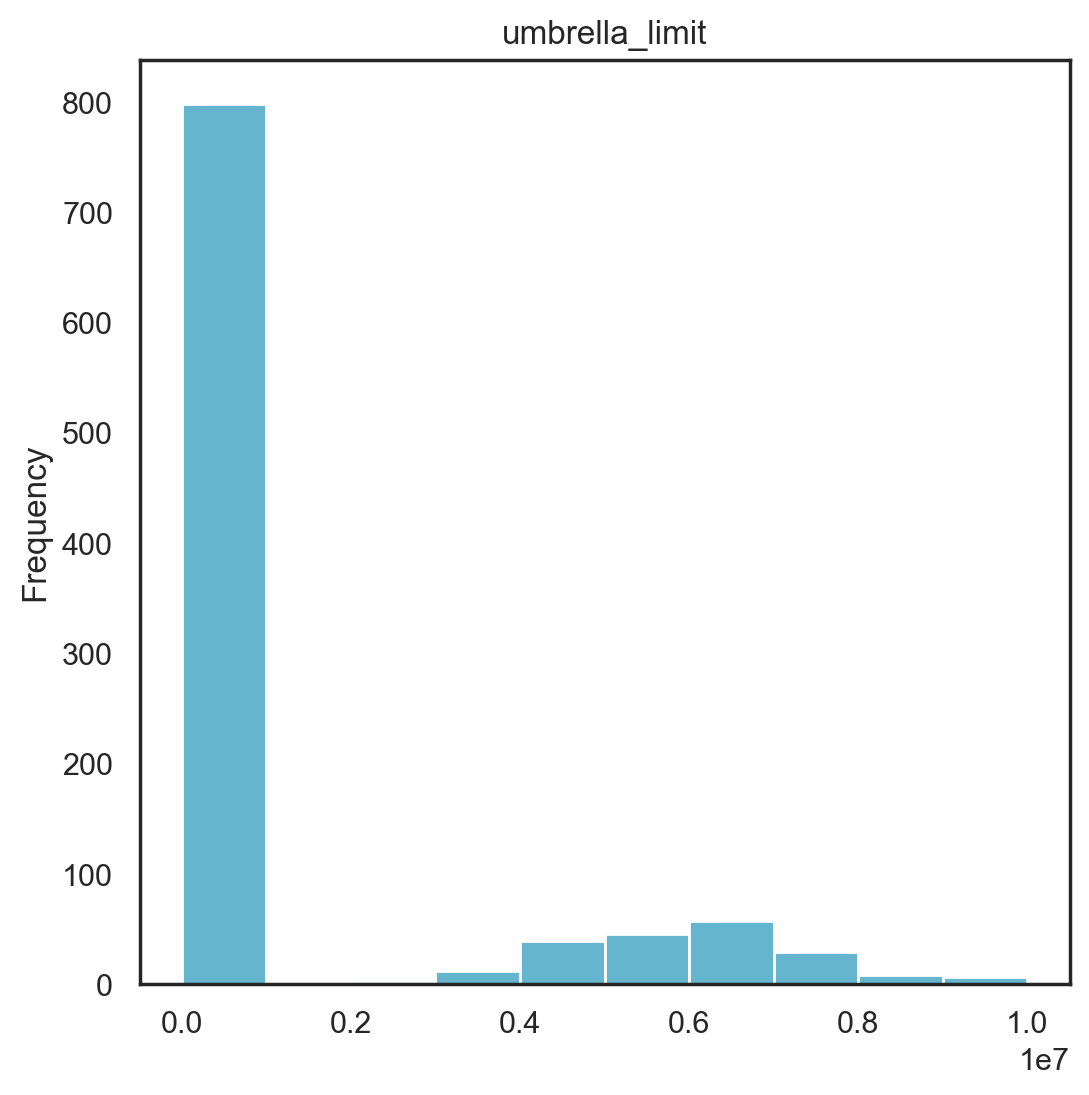

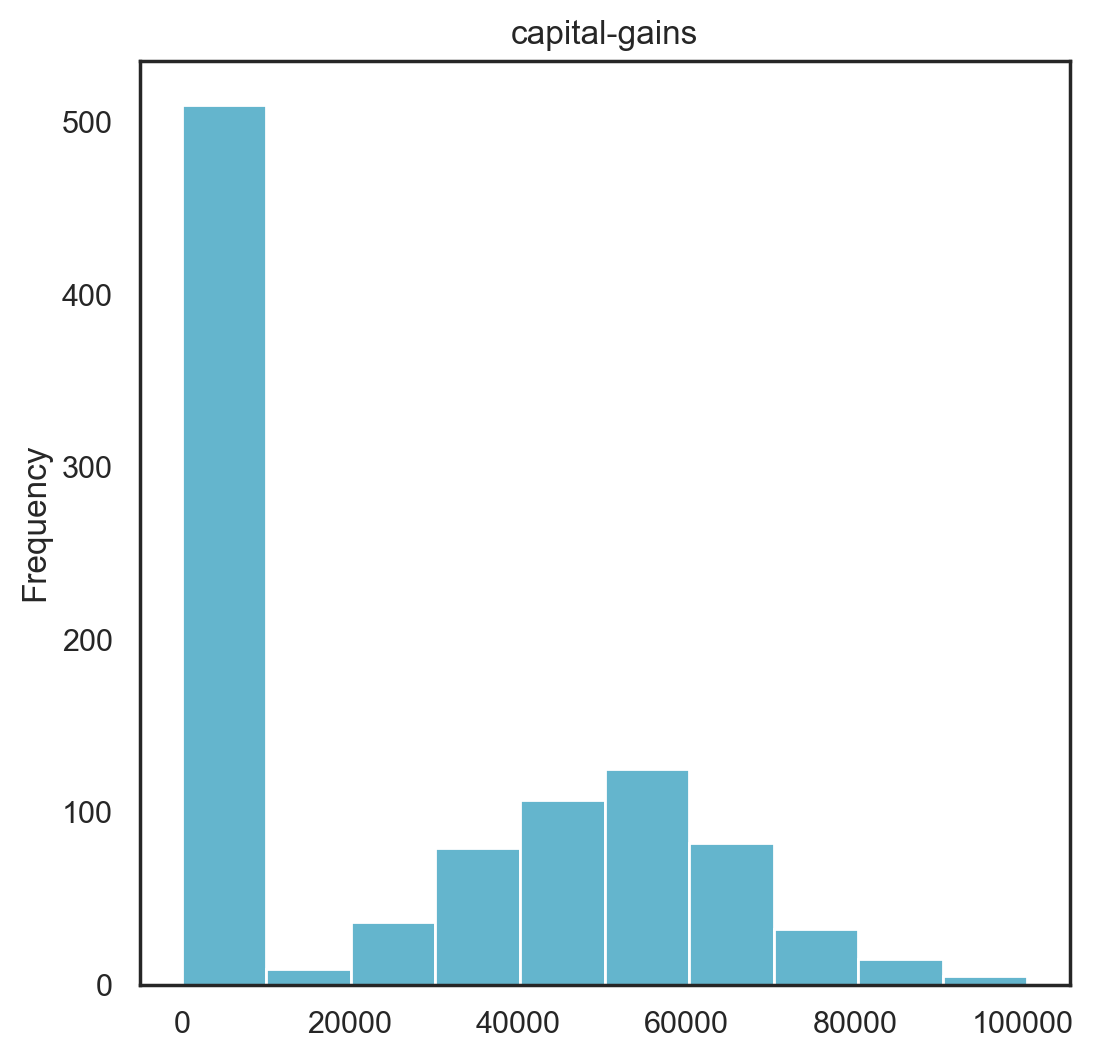

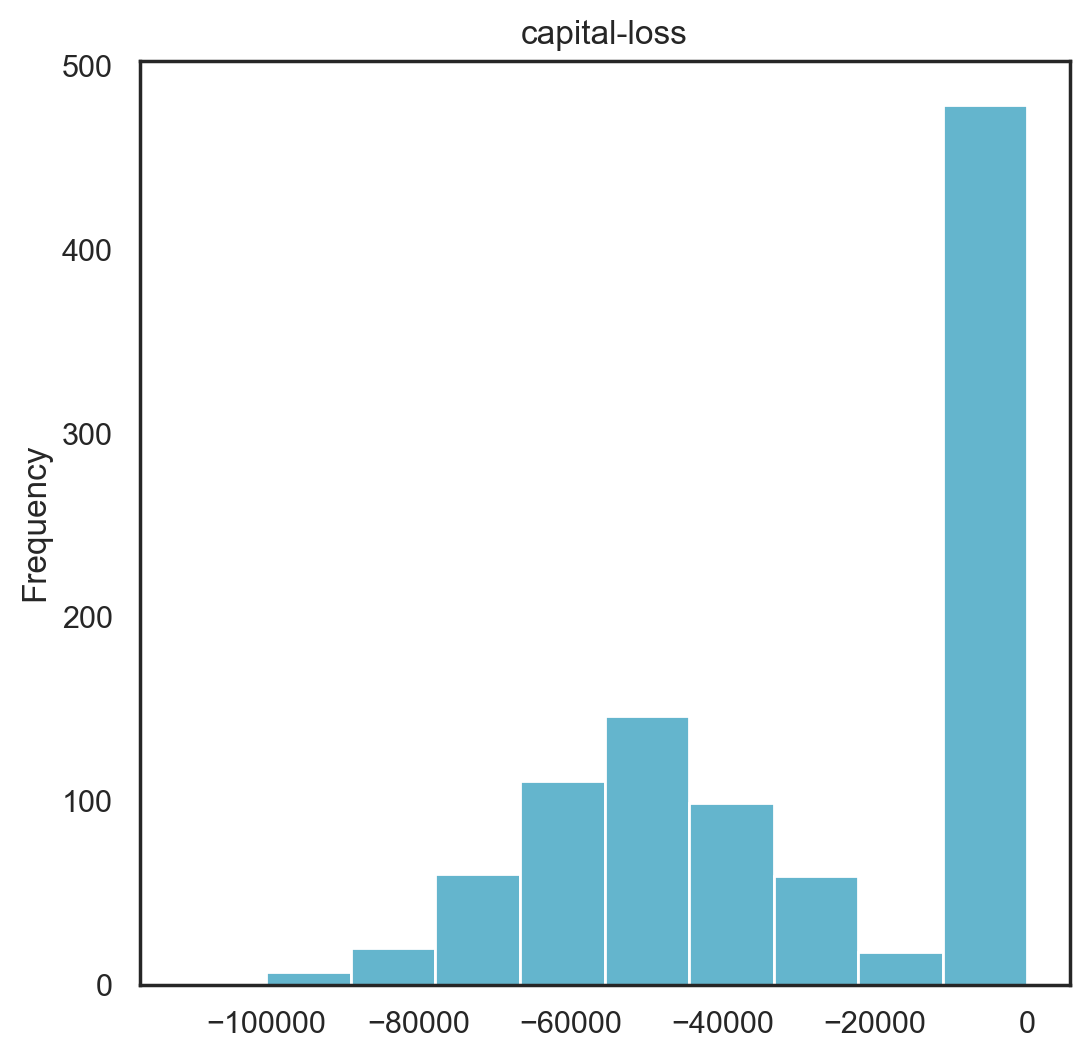

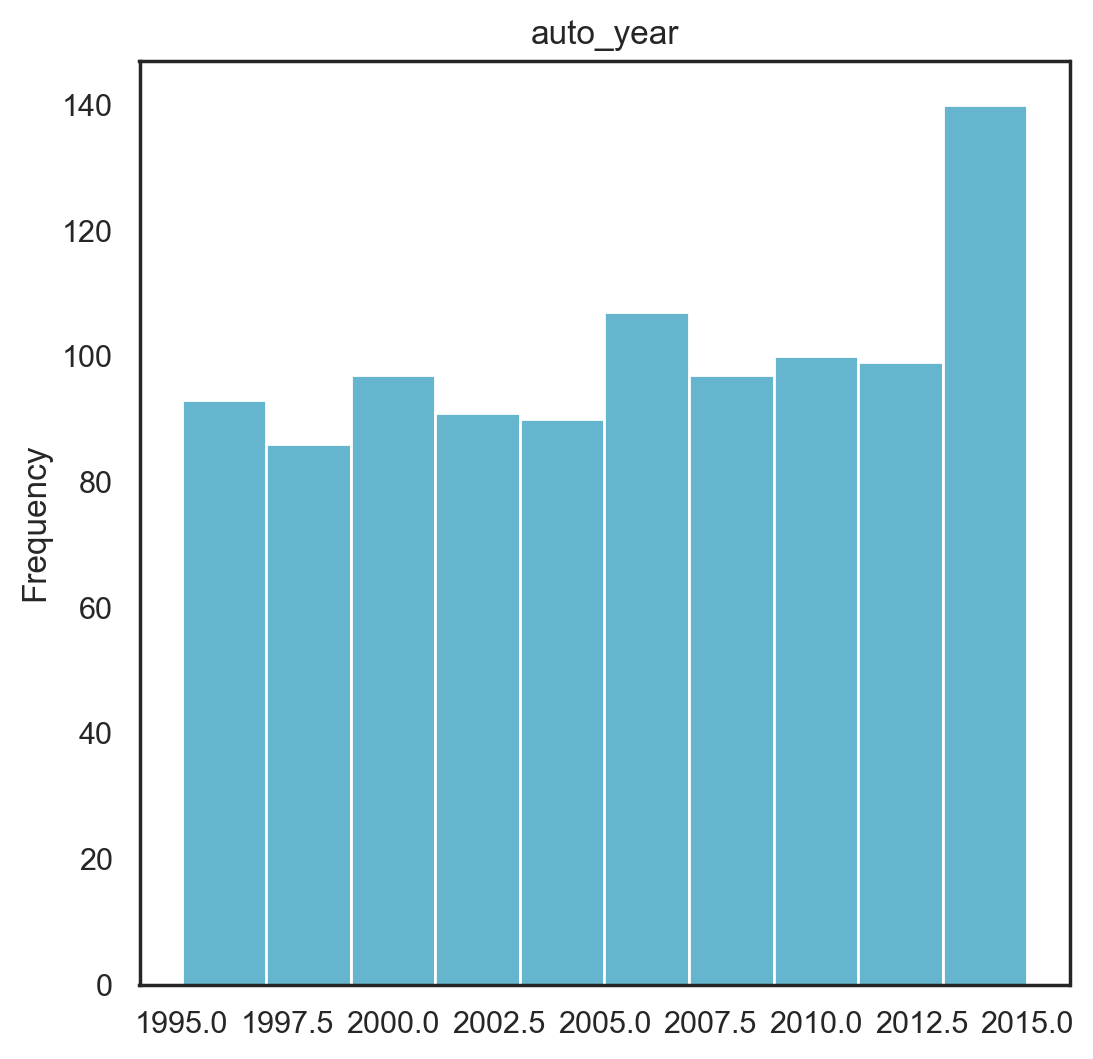

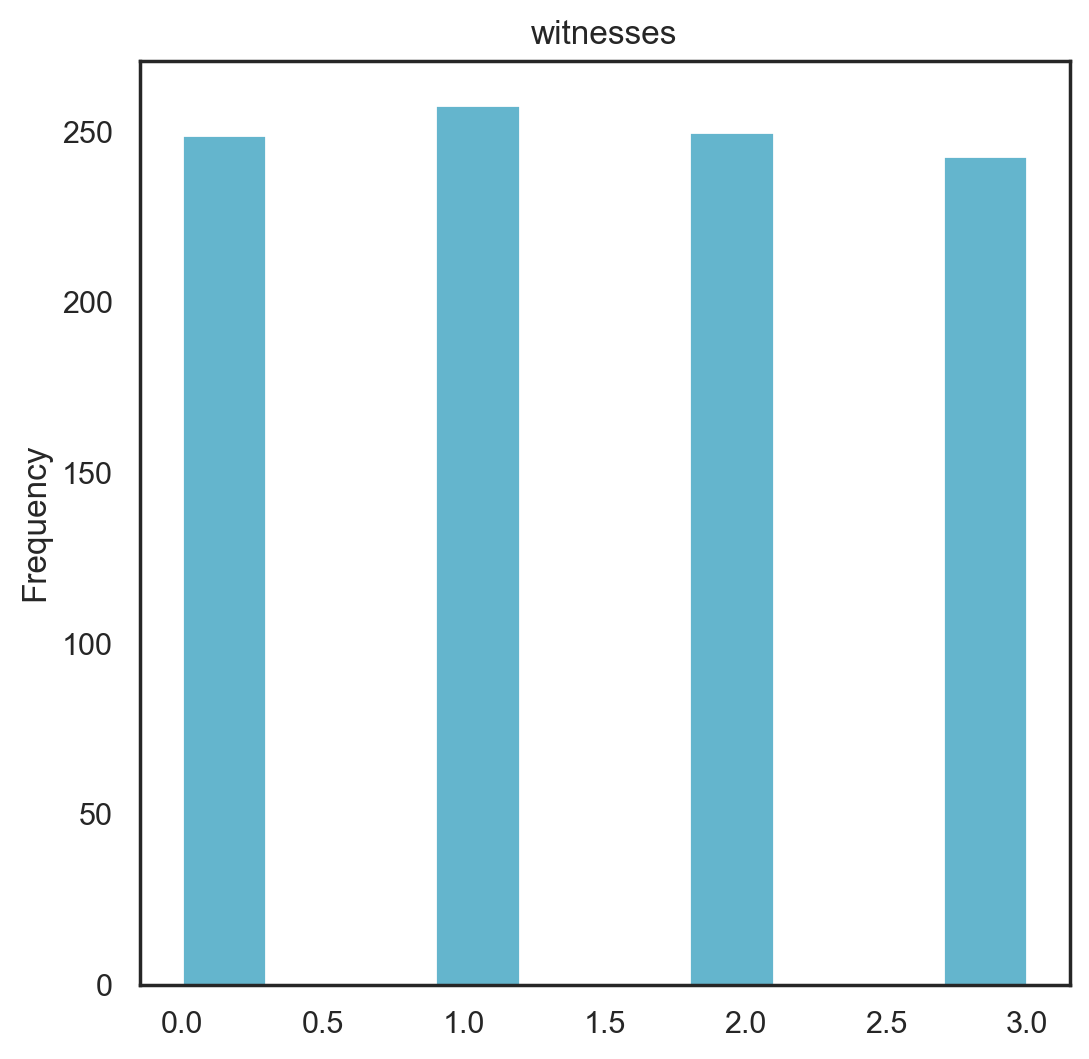

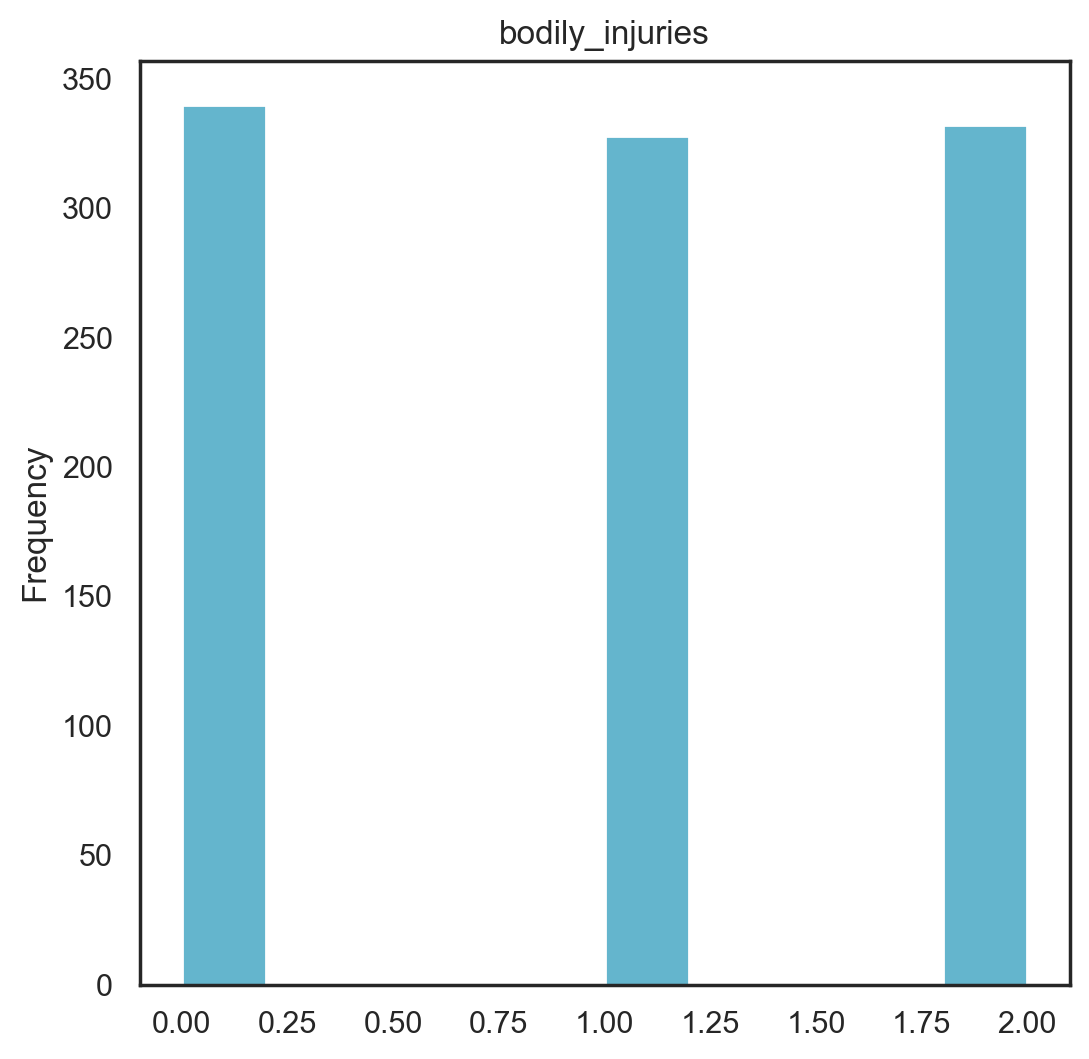

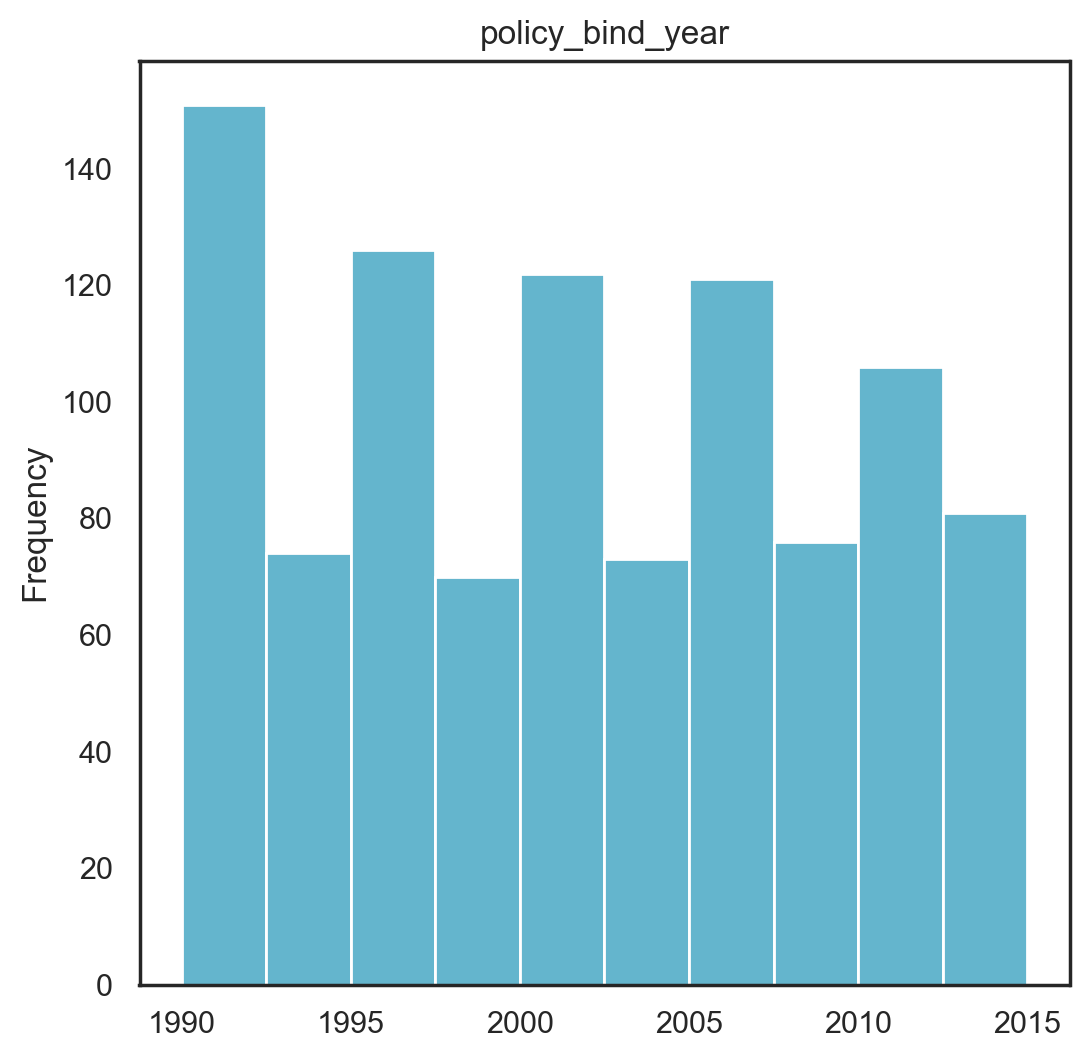

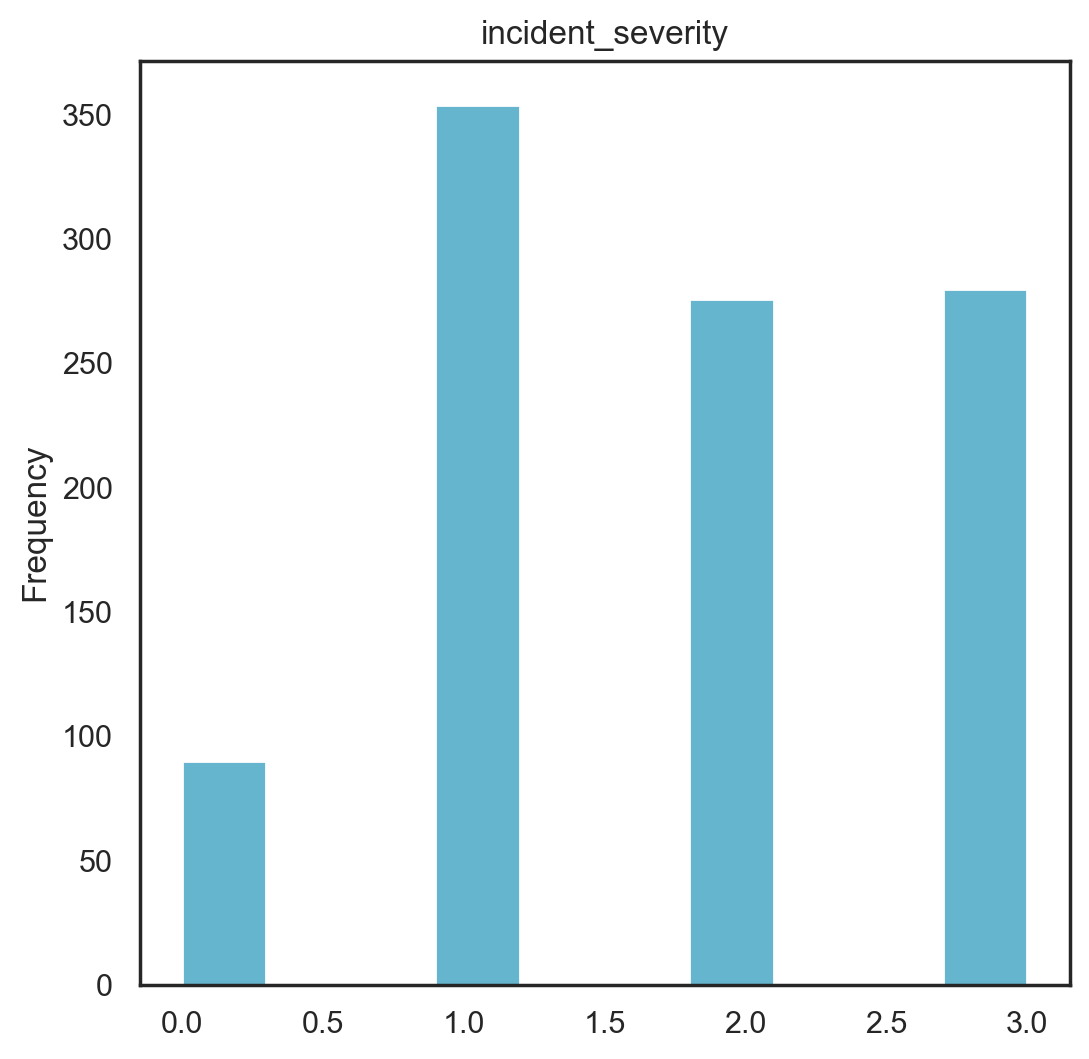

In [40]:
#distribution of ordinal and continuous variables

for i, name in enumerate(df[cont_var]):
    plt.figure(i,figsize=(6,6))
    df[name].plot(kind="hist", color="c", title=name)

Continuous variables' counts were visualized with bar plots. I sum up some observations in point: 

- **policy annual premium:** looks like a normal distribution.
- **policy bind years:** have staggering frequencies with some range of years more popular than others. This may be some auto market cycle. 1990 to 2992 is the highest.
- **capital gain and loss:** are mostly 0

### Visualizing variables against the DV

Counts of every variable split by the DV was plotted. Below are a few notable plots.

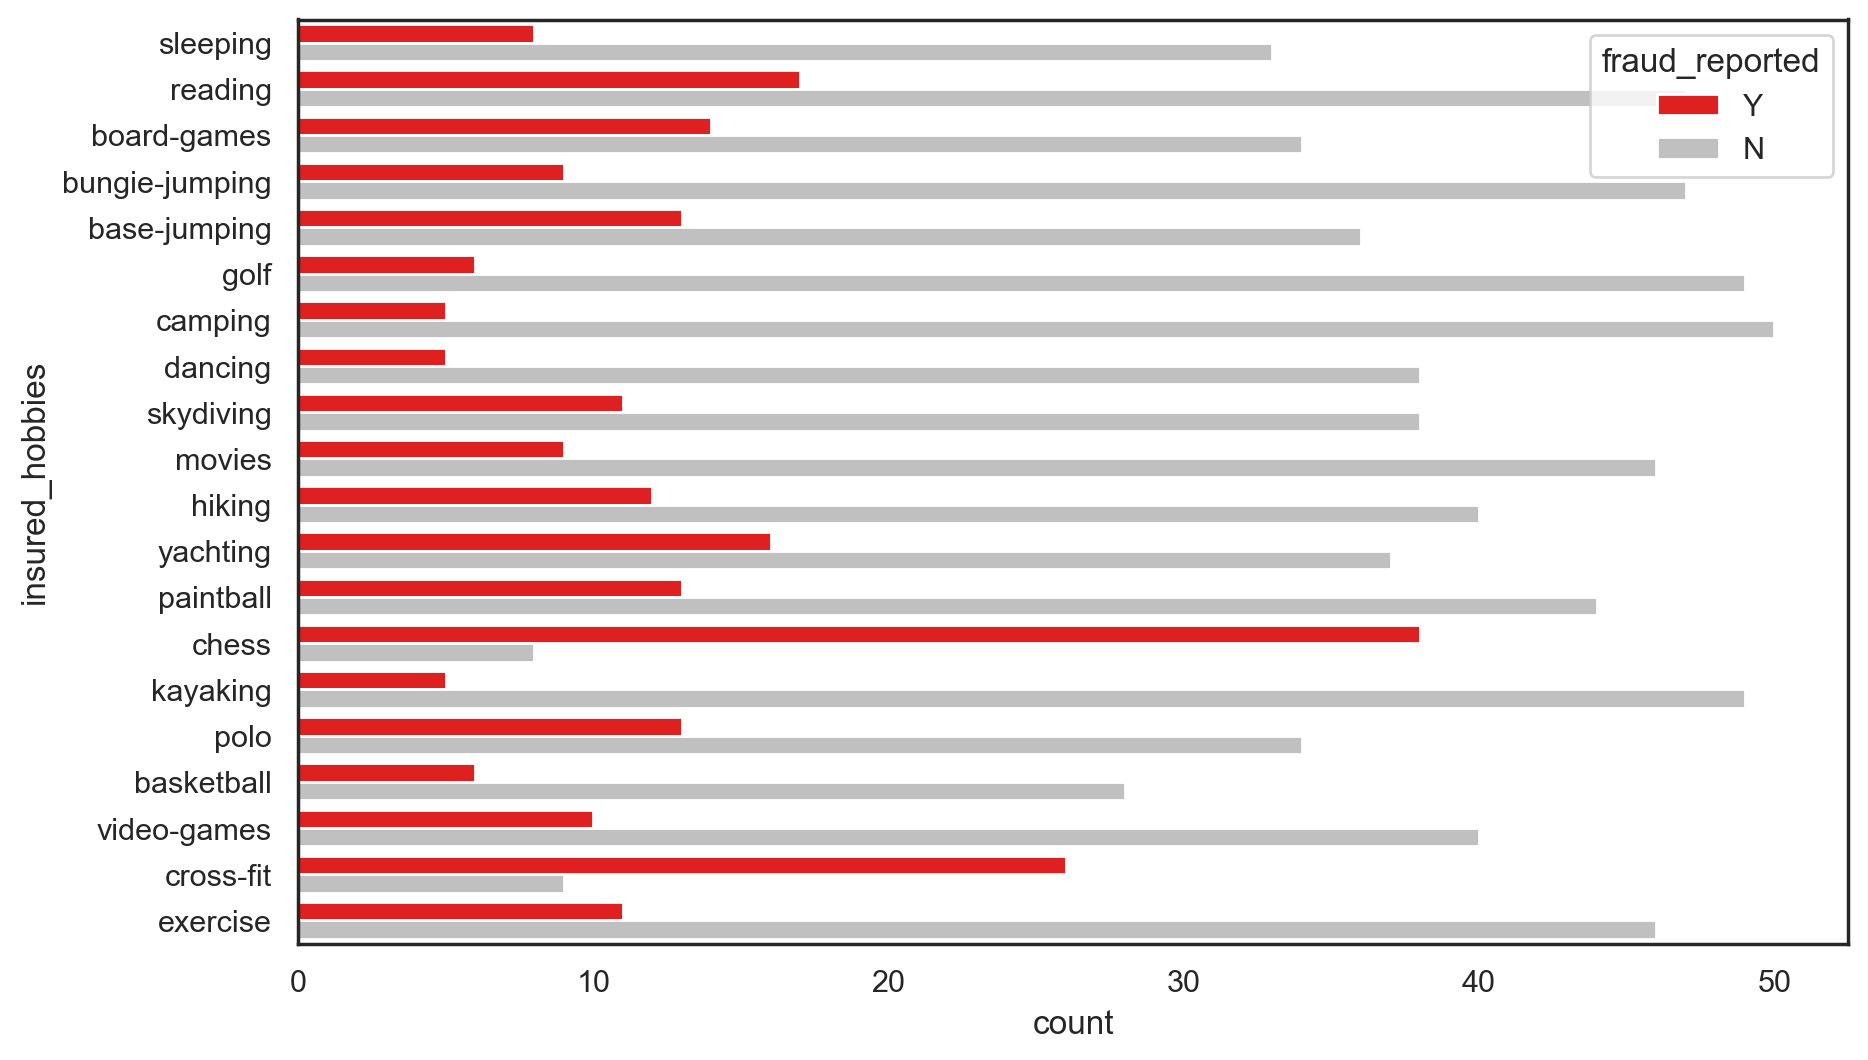

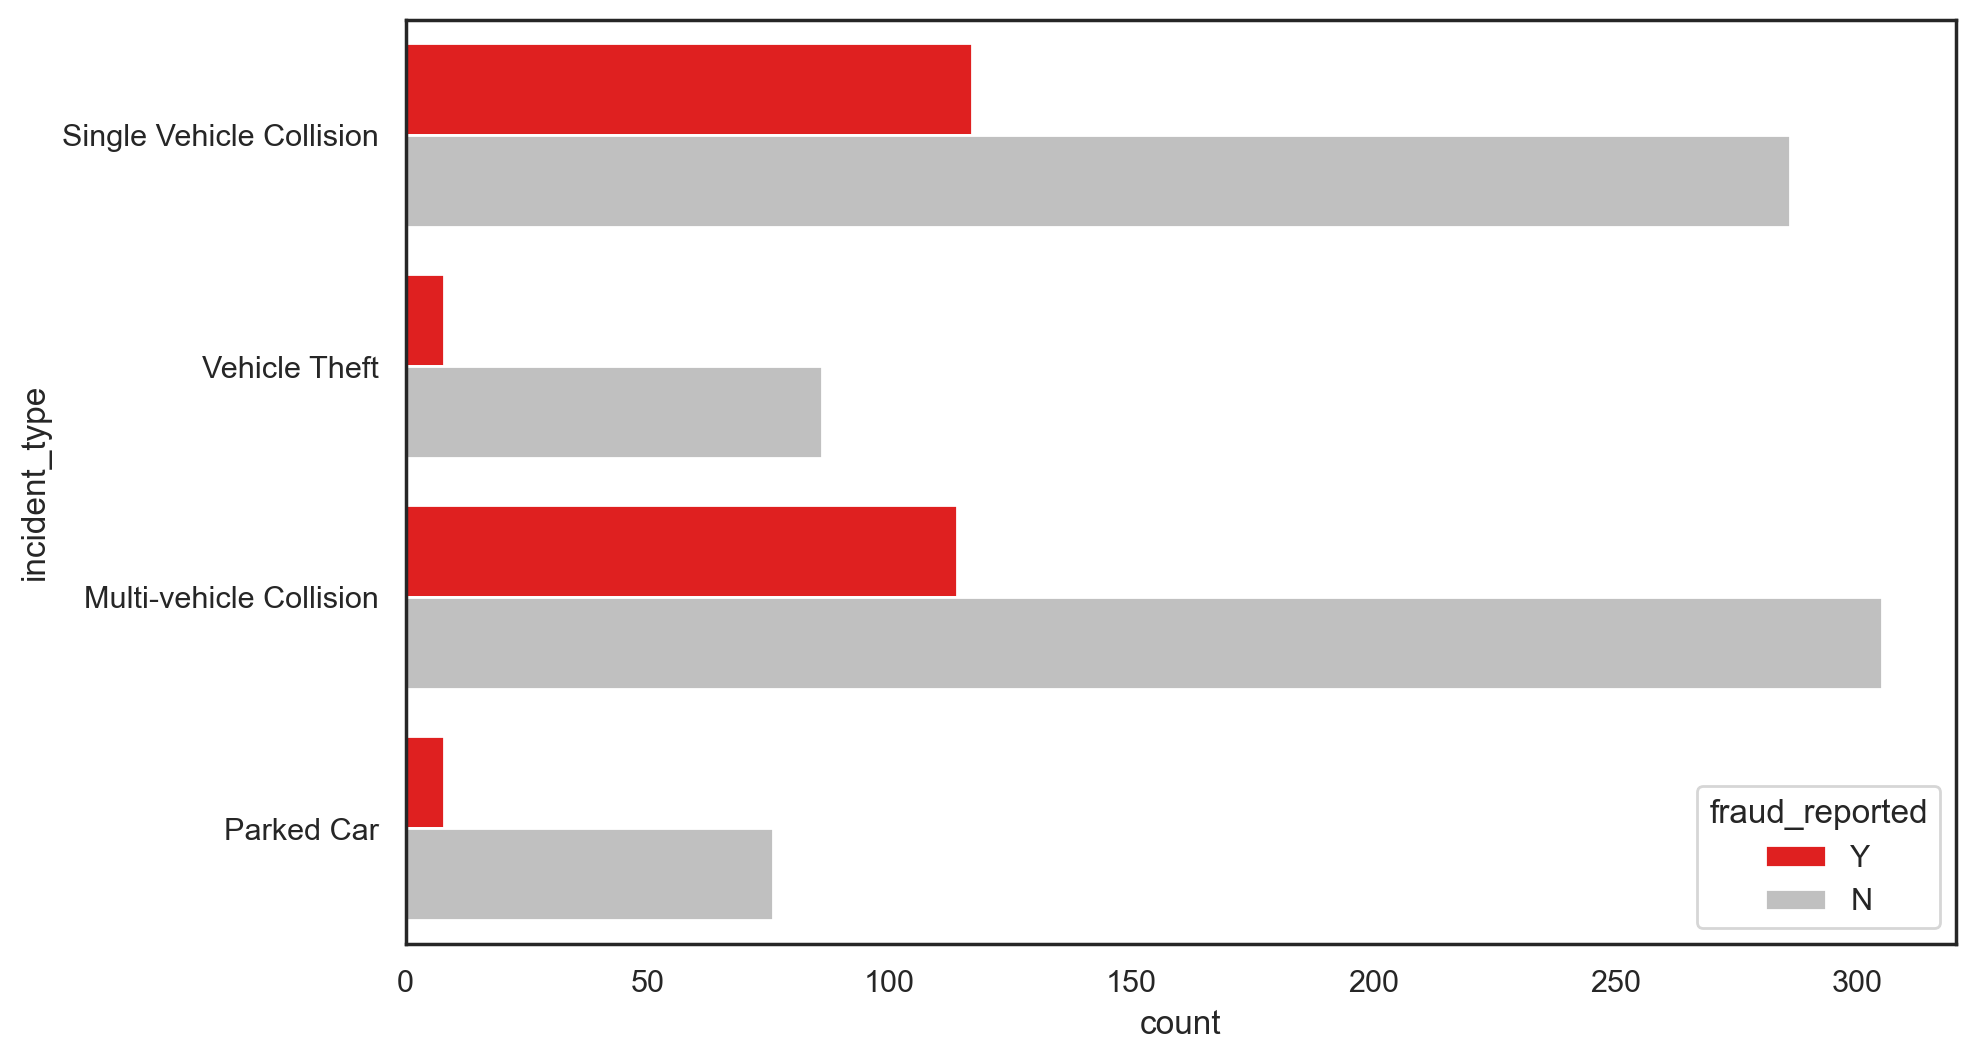

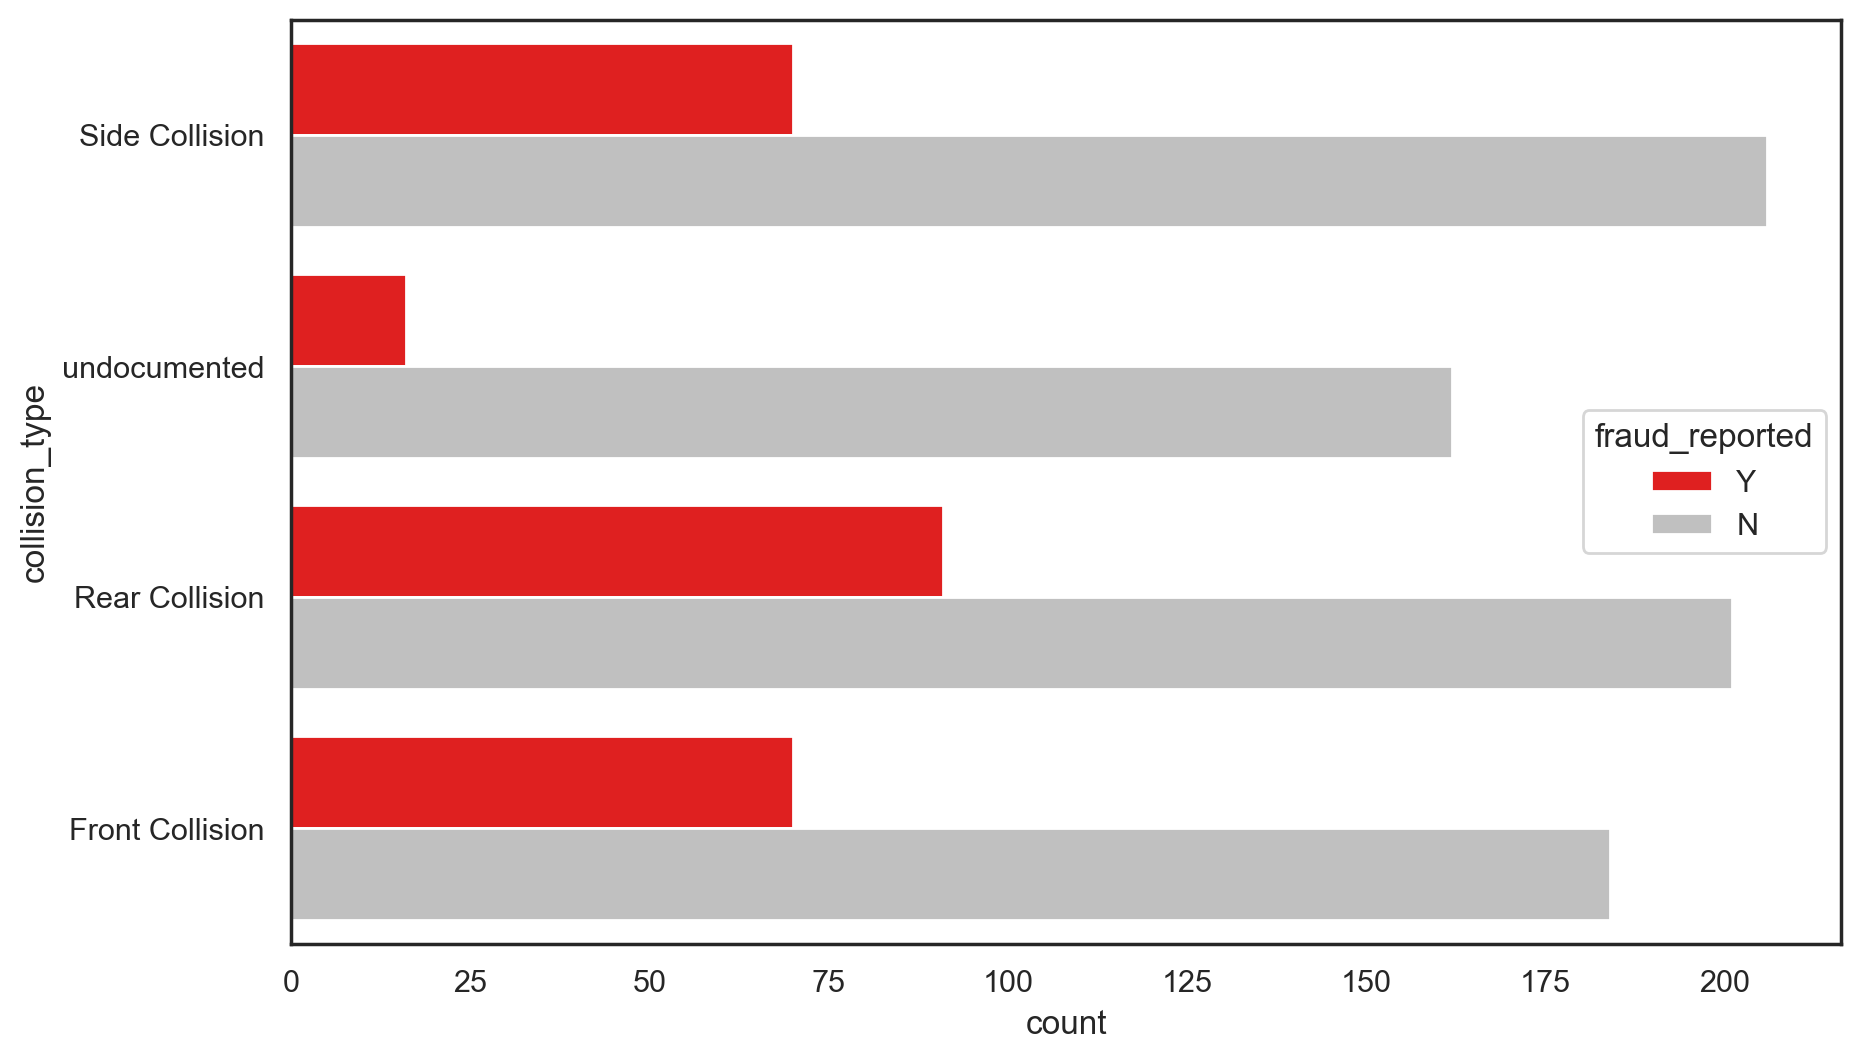

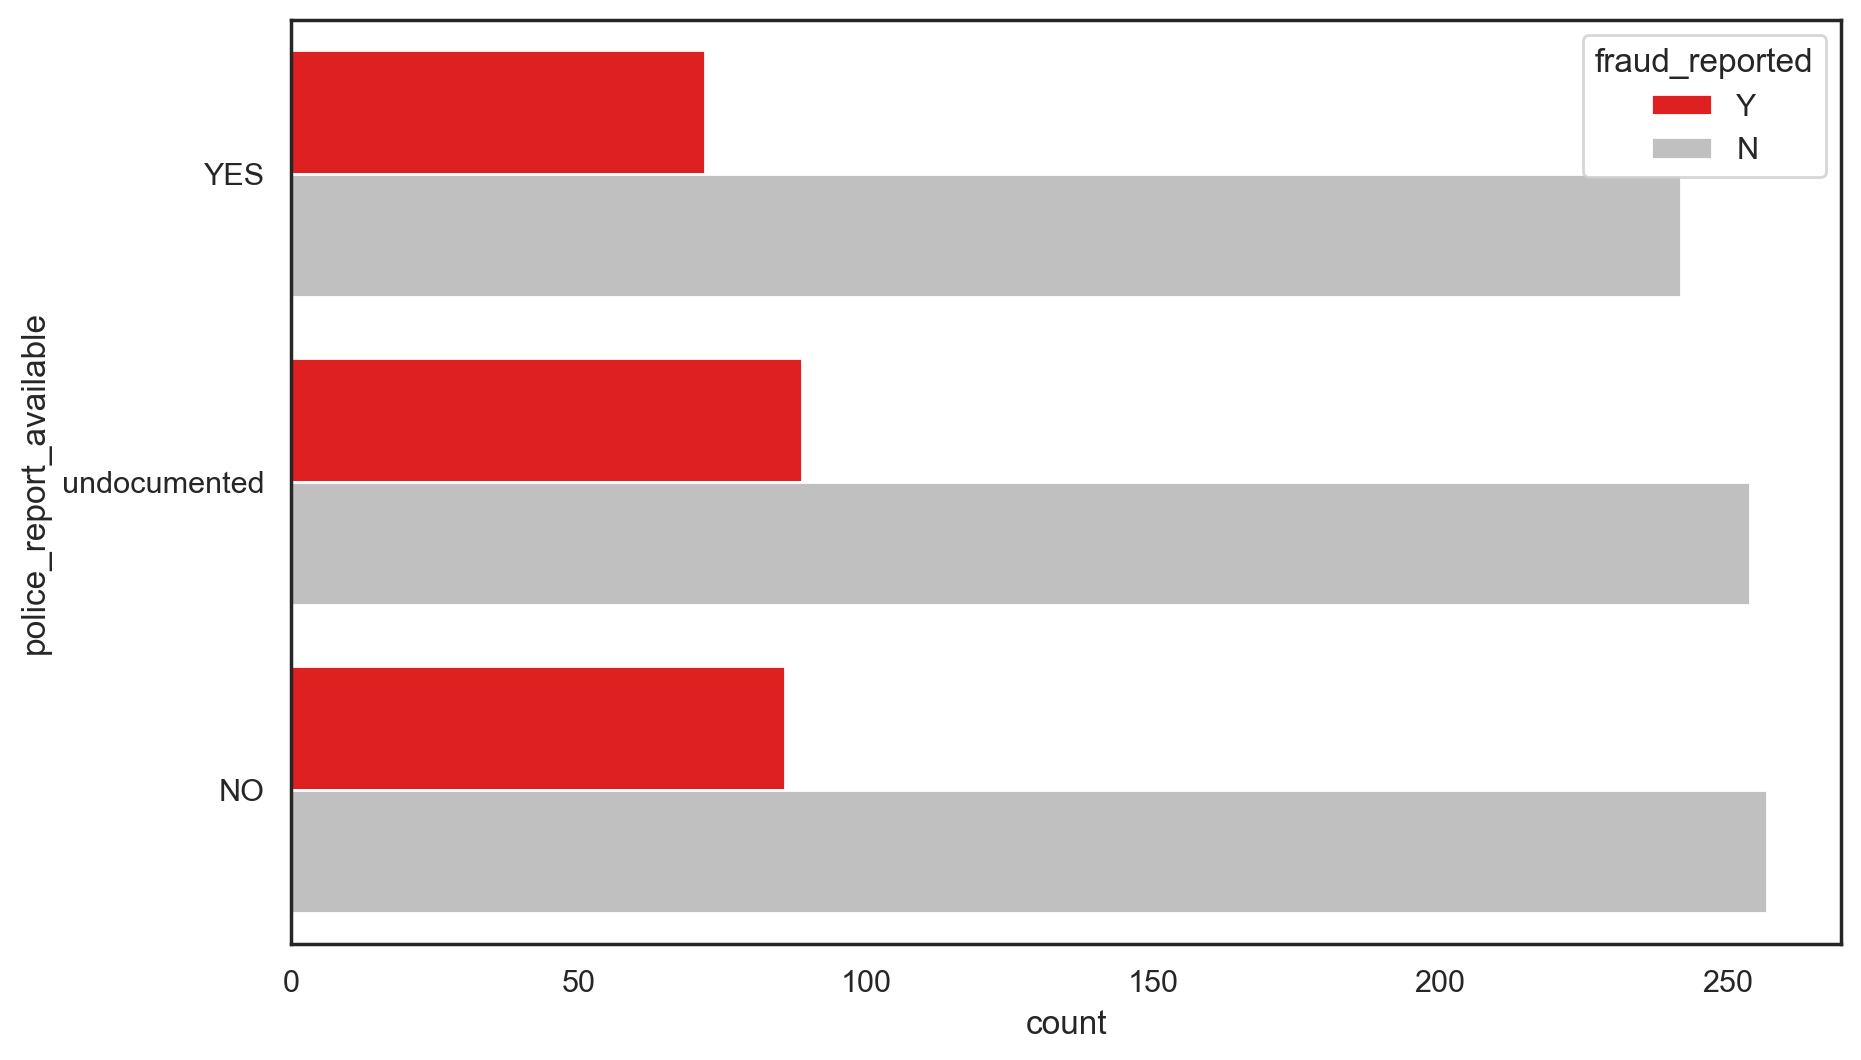

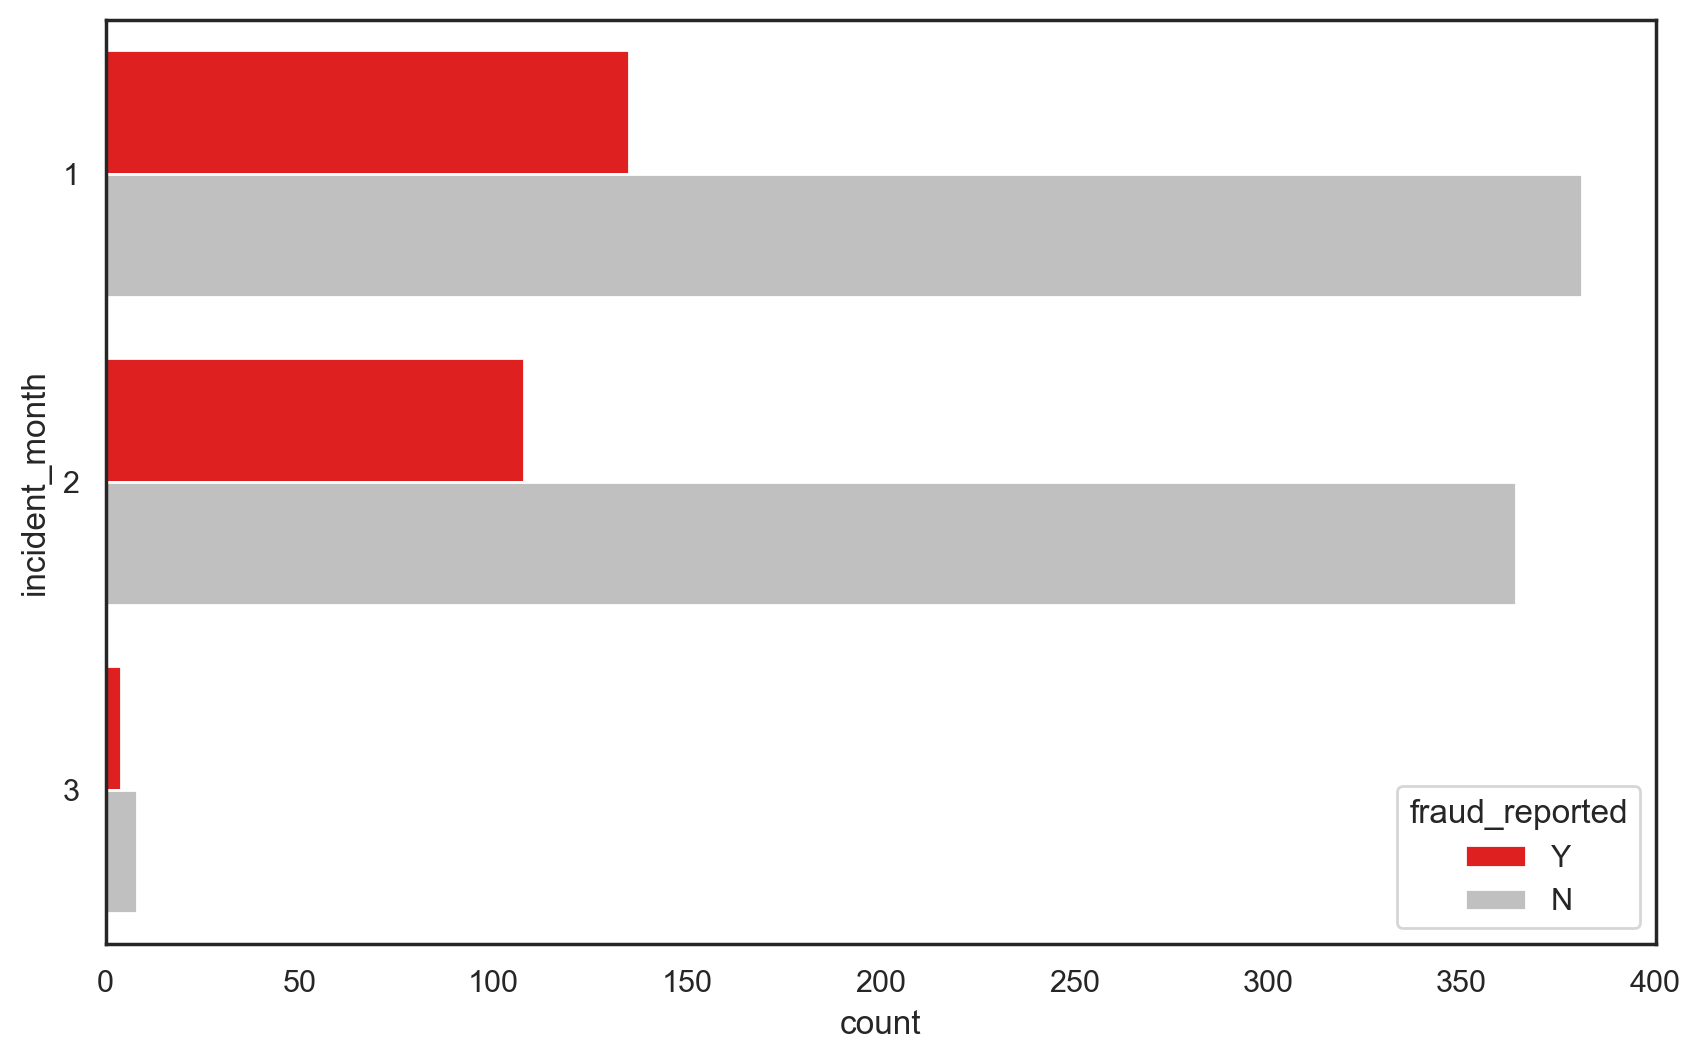

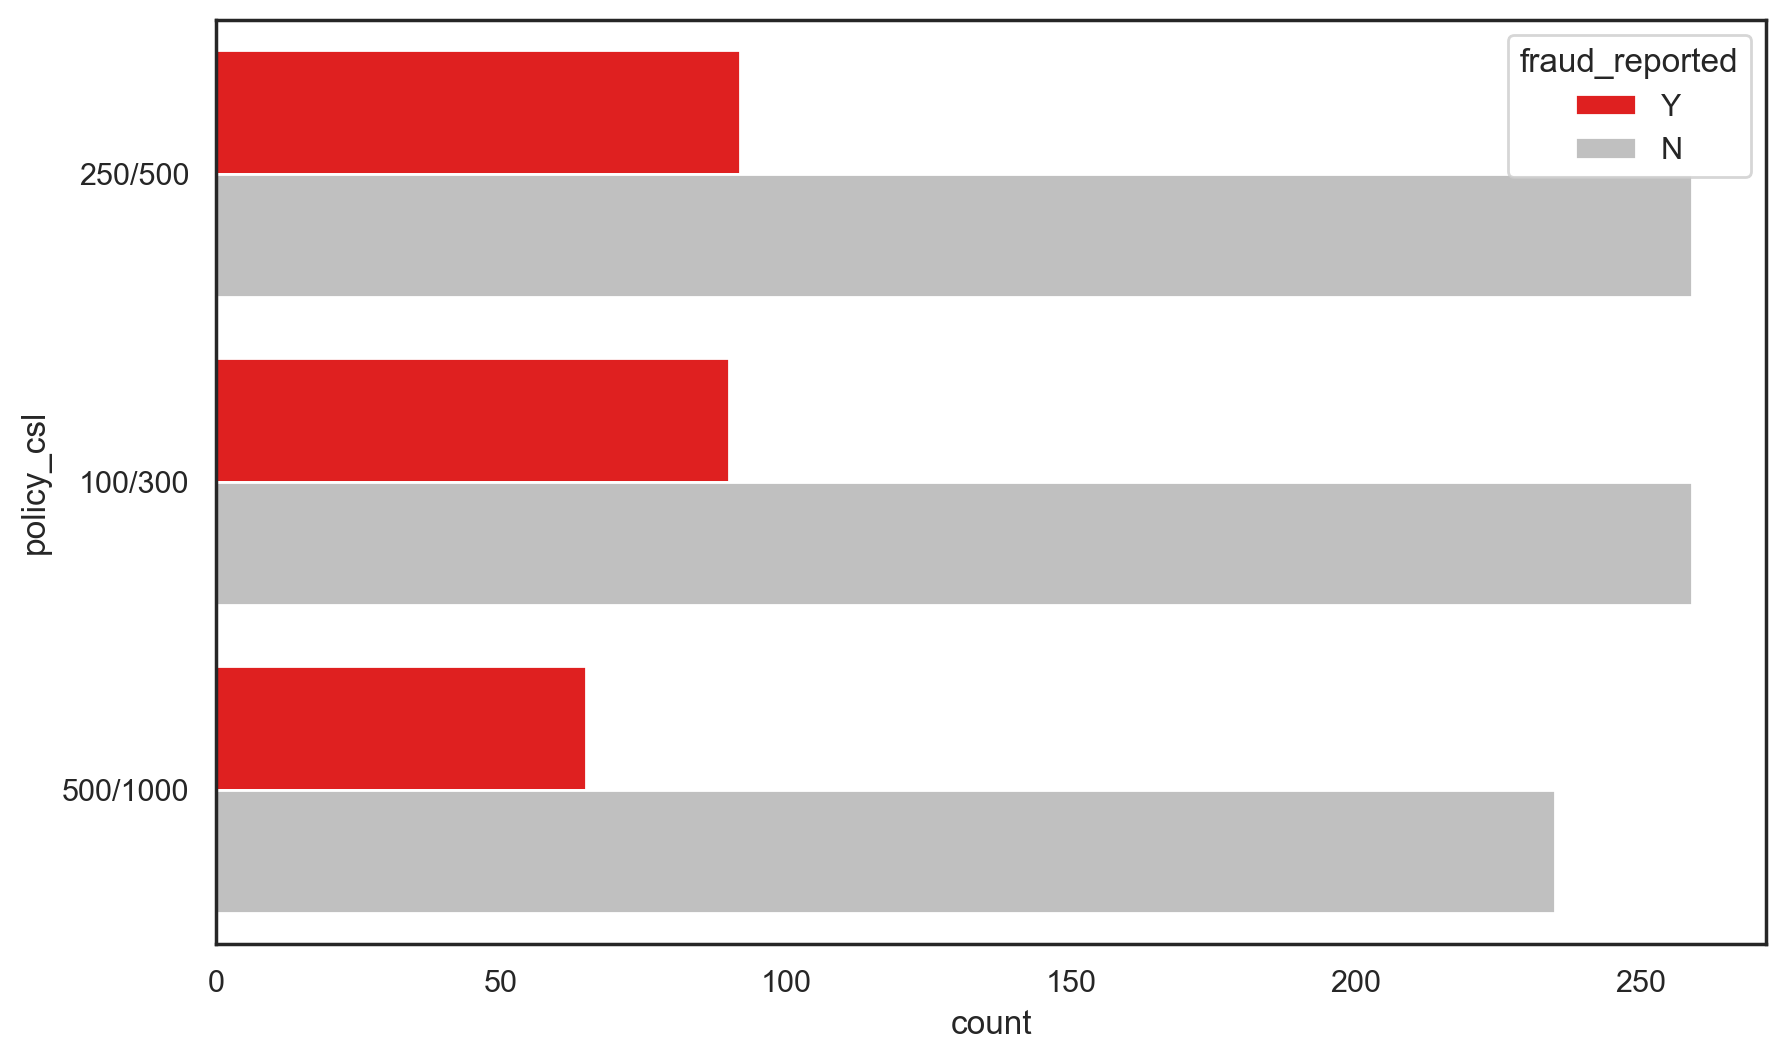

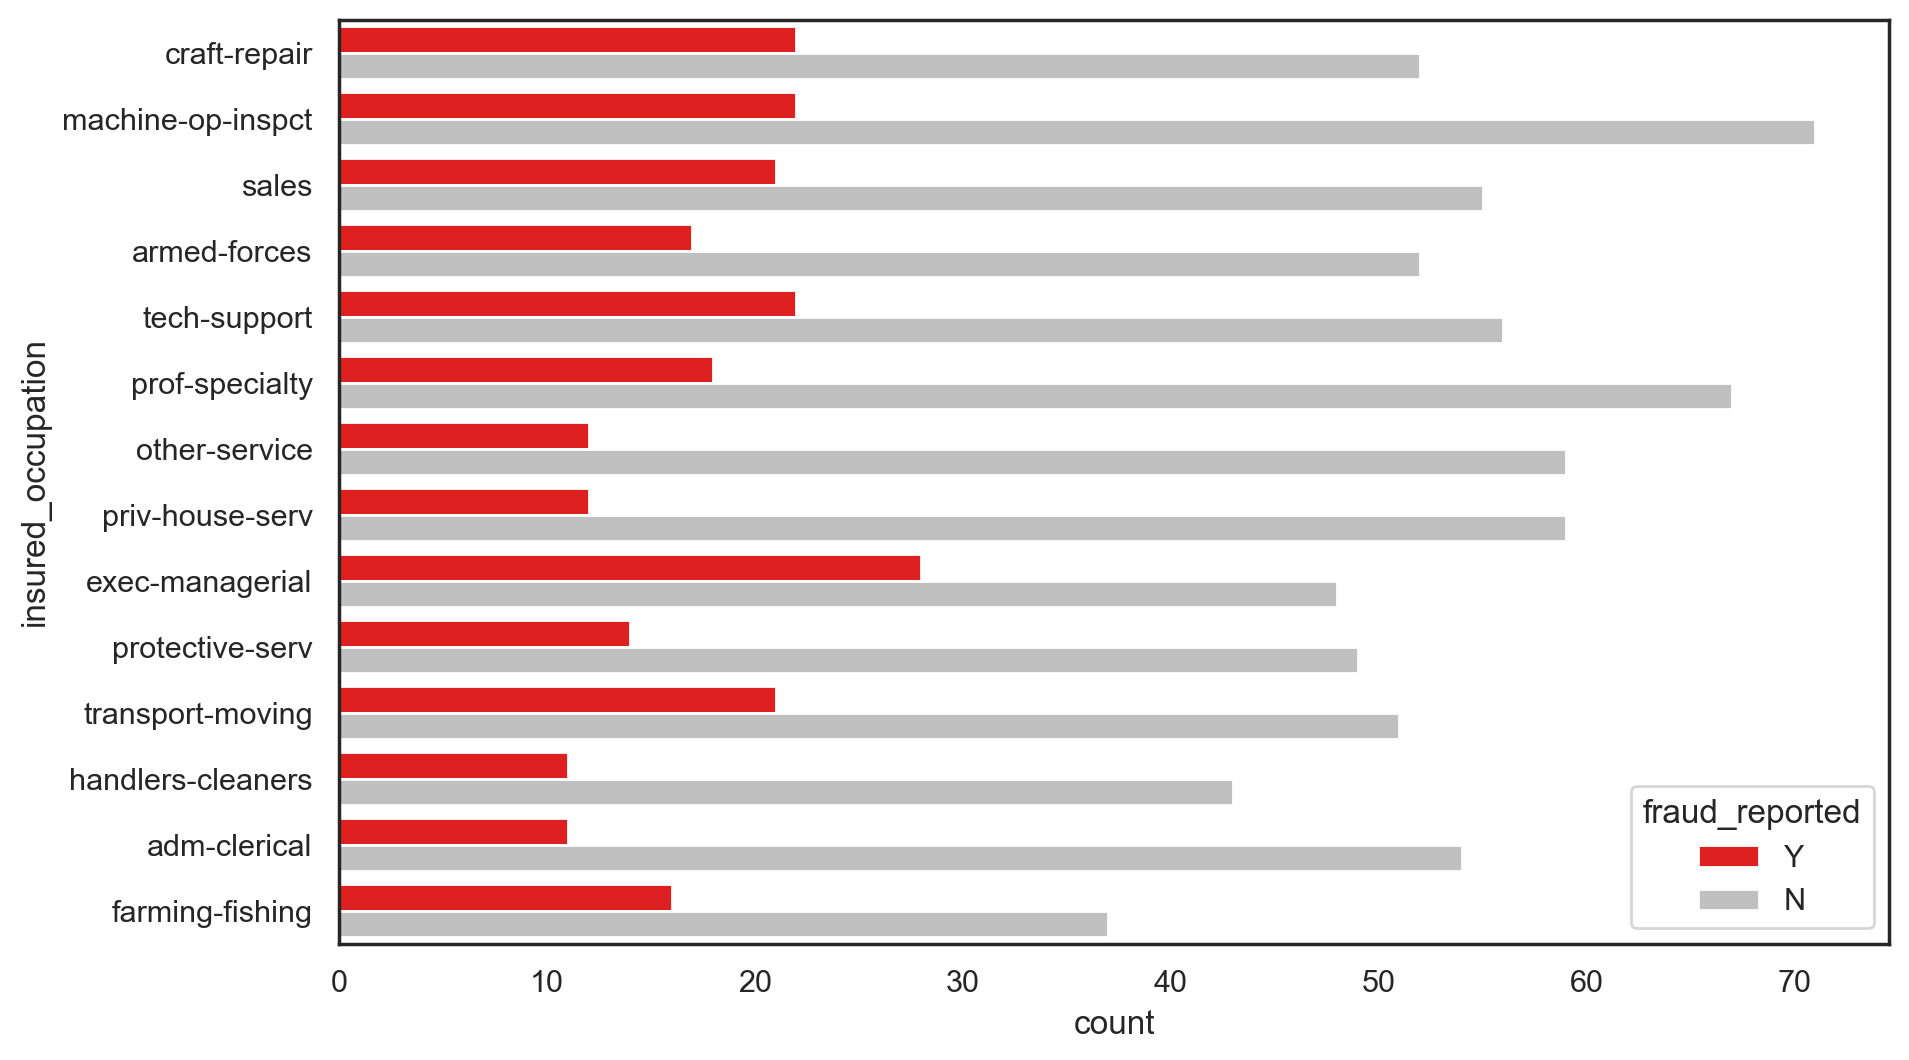

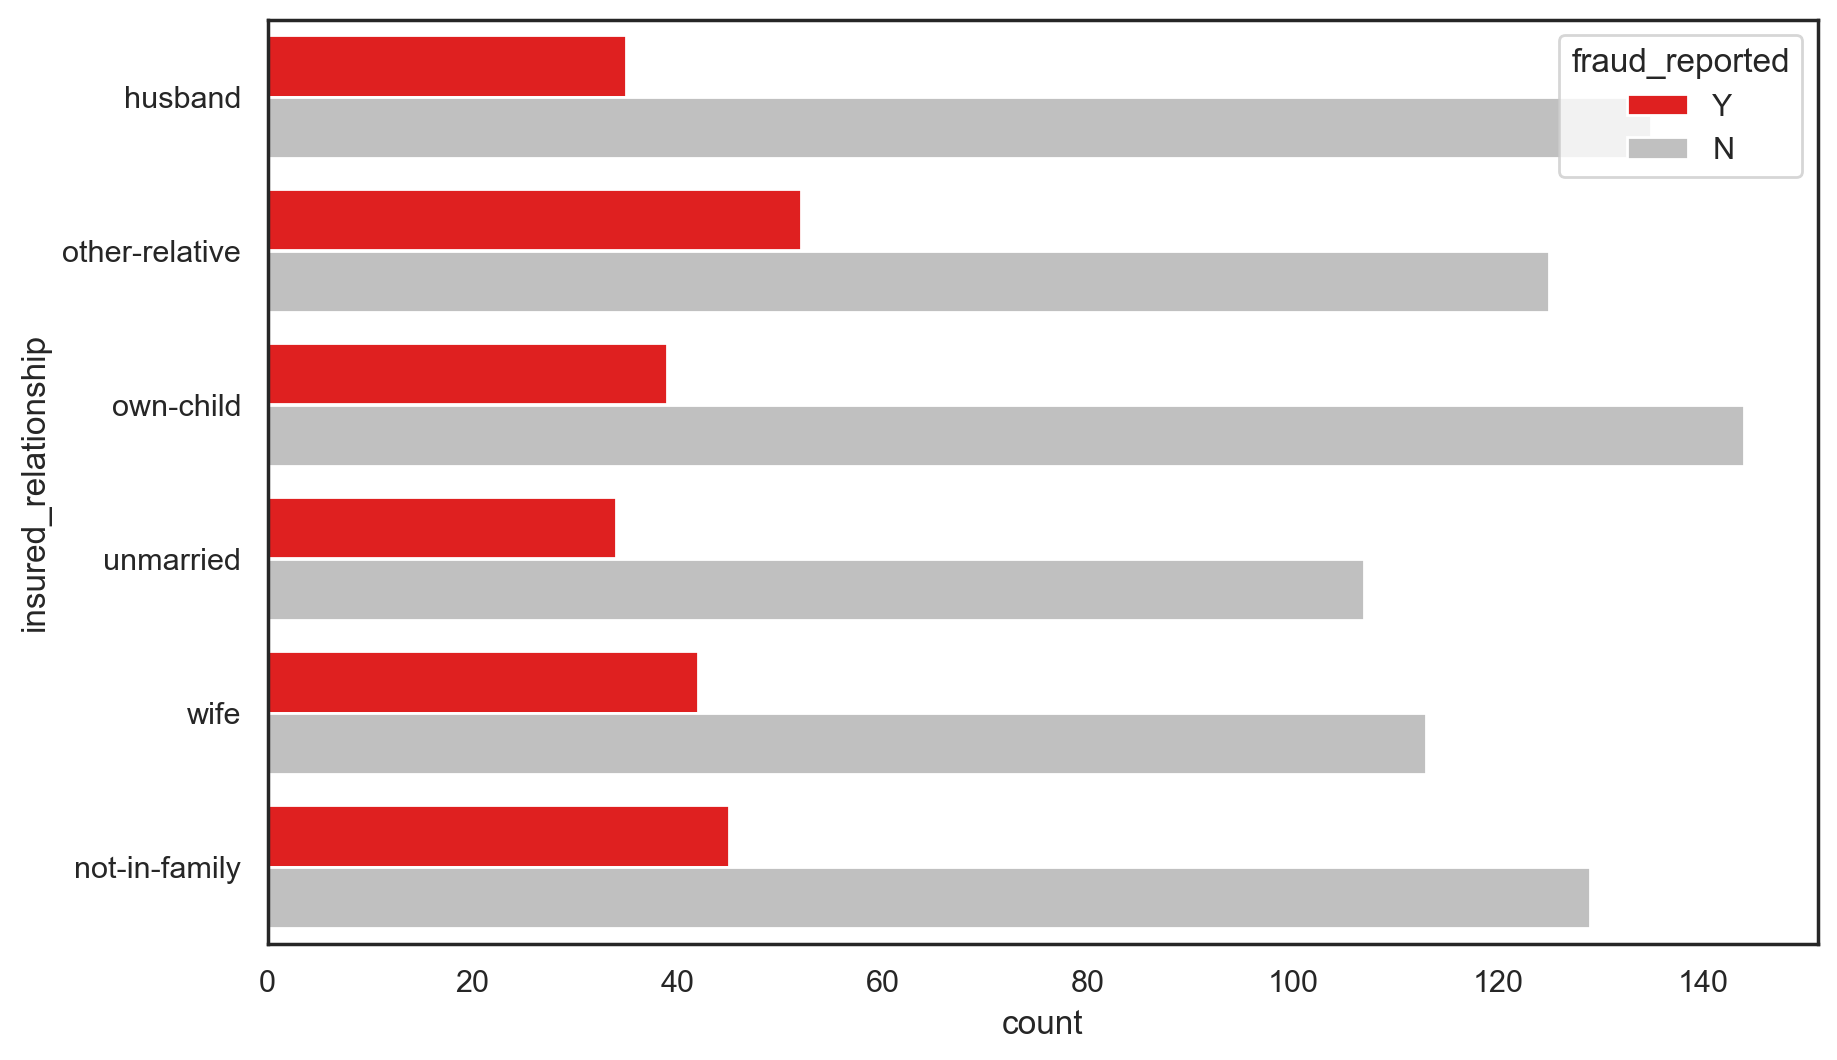

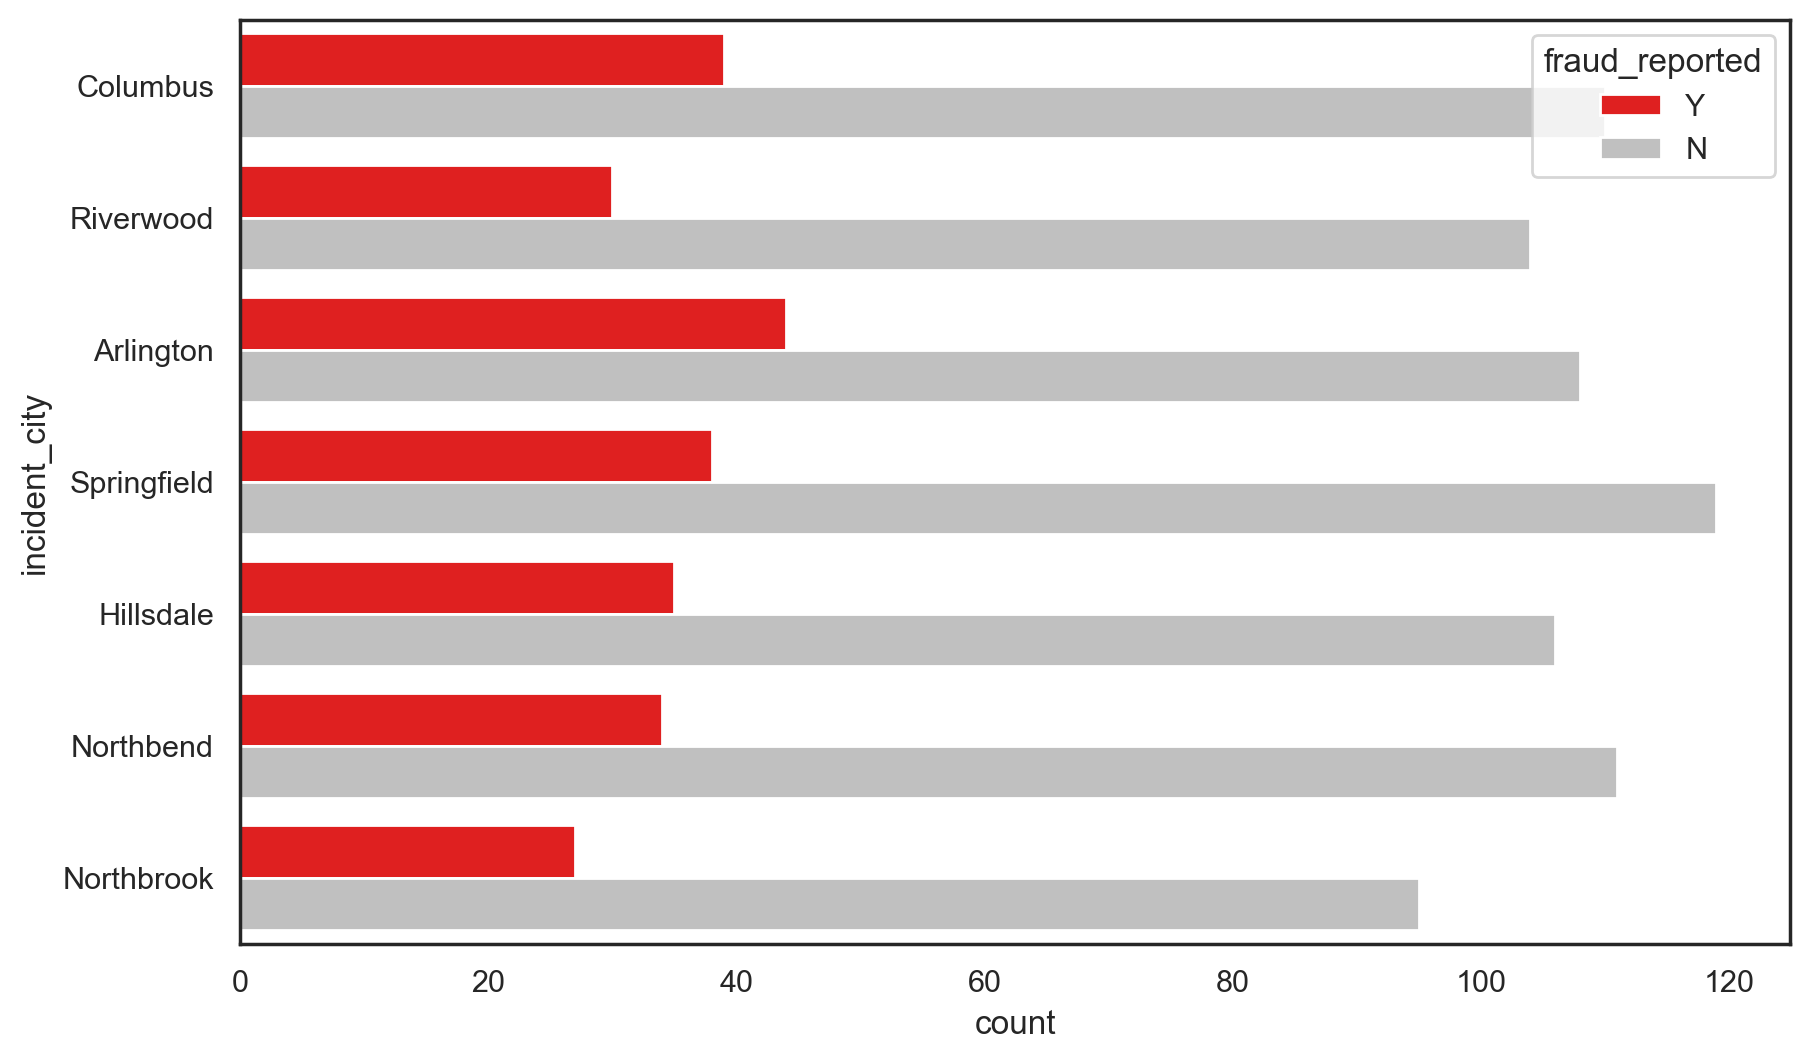

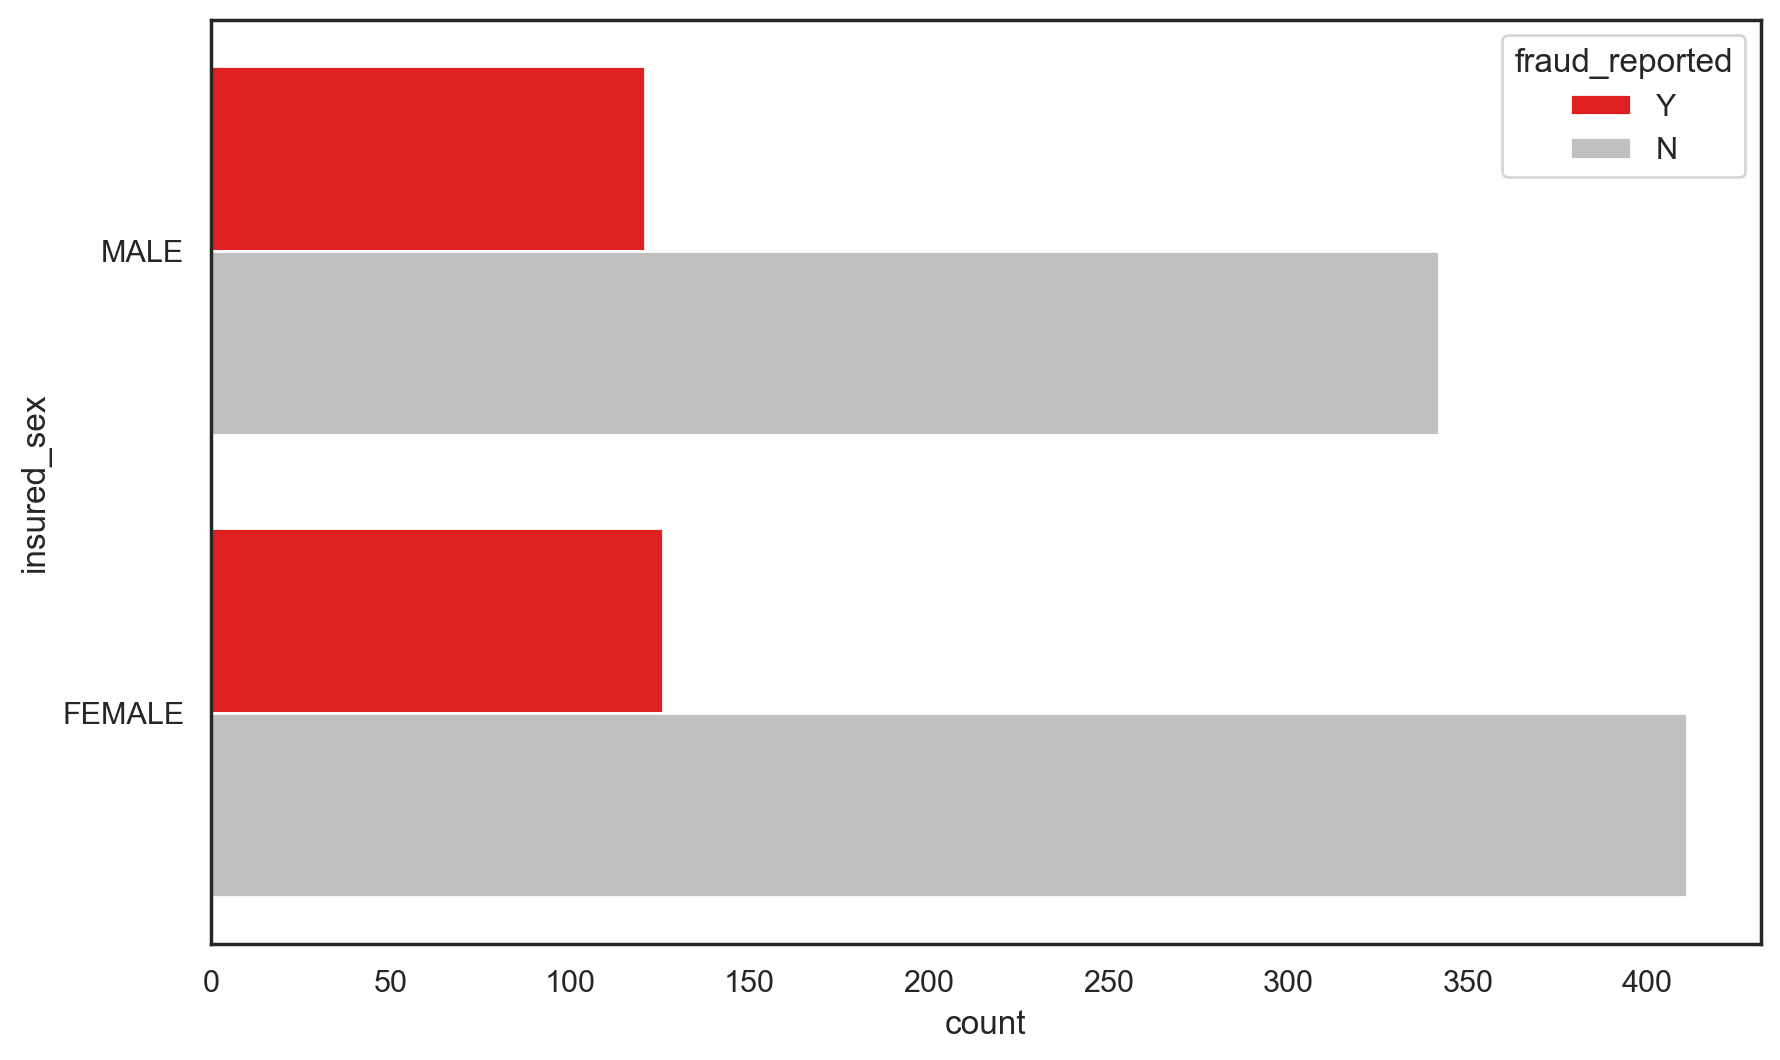

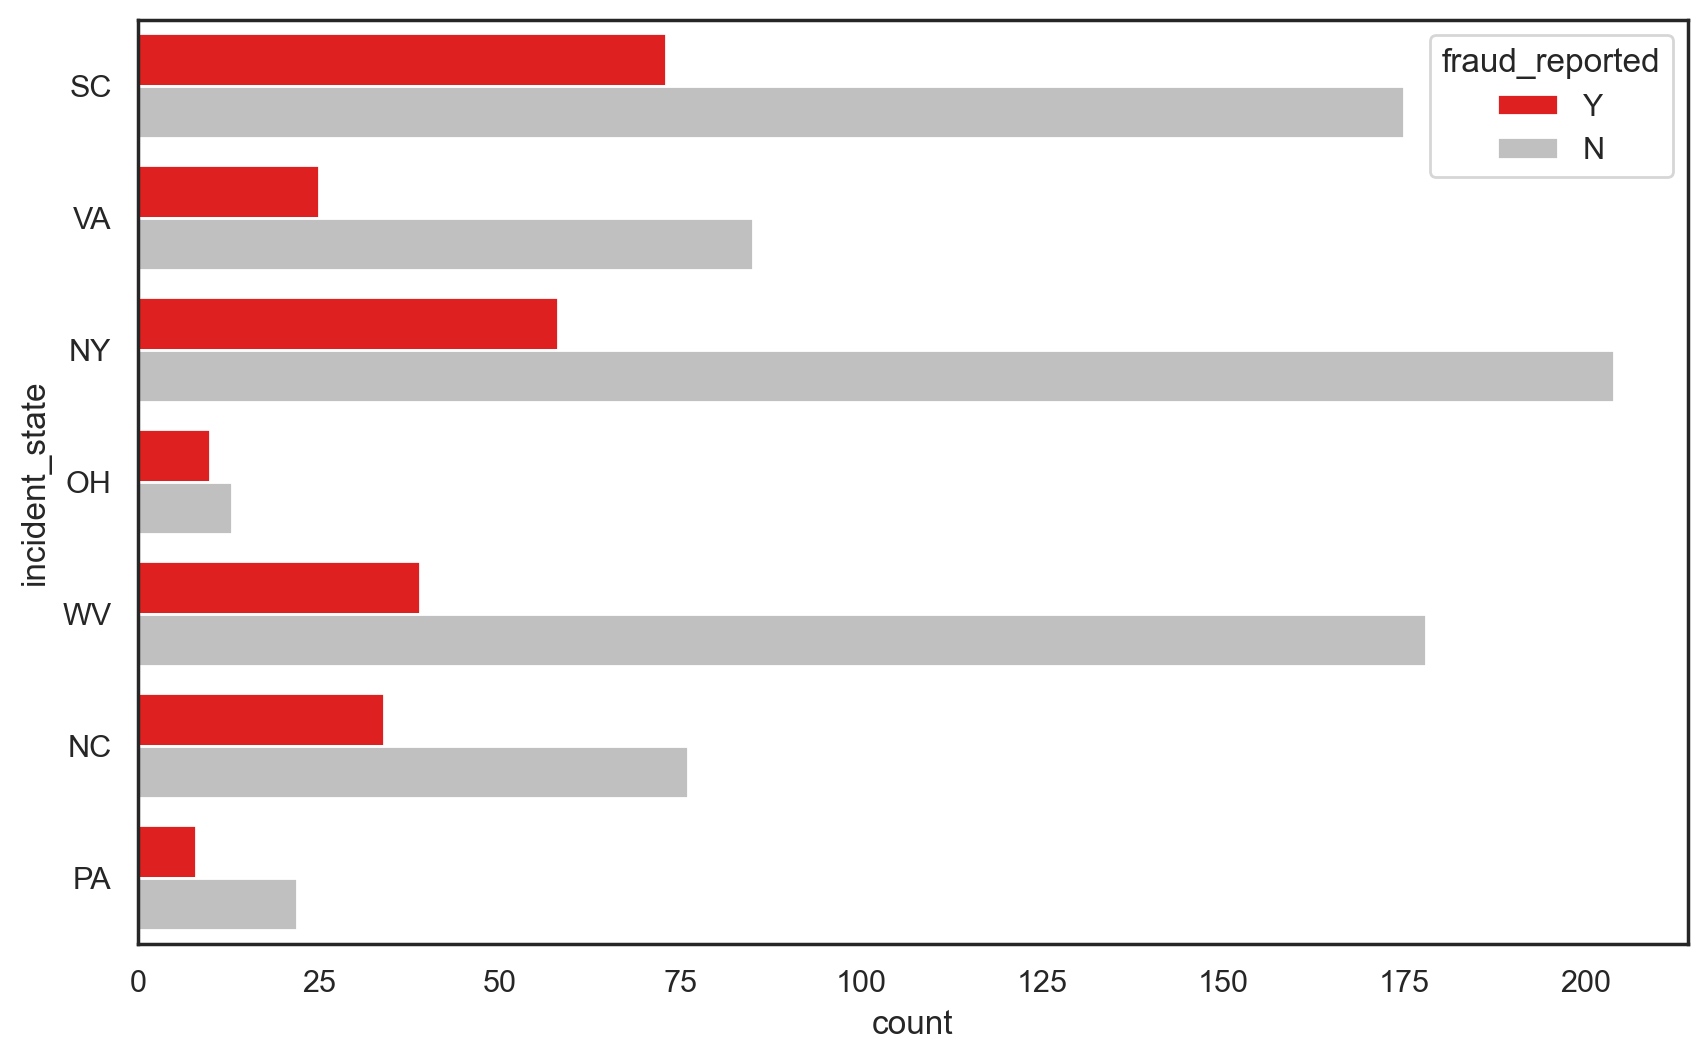

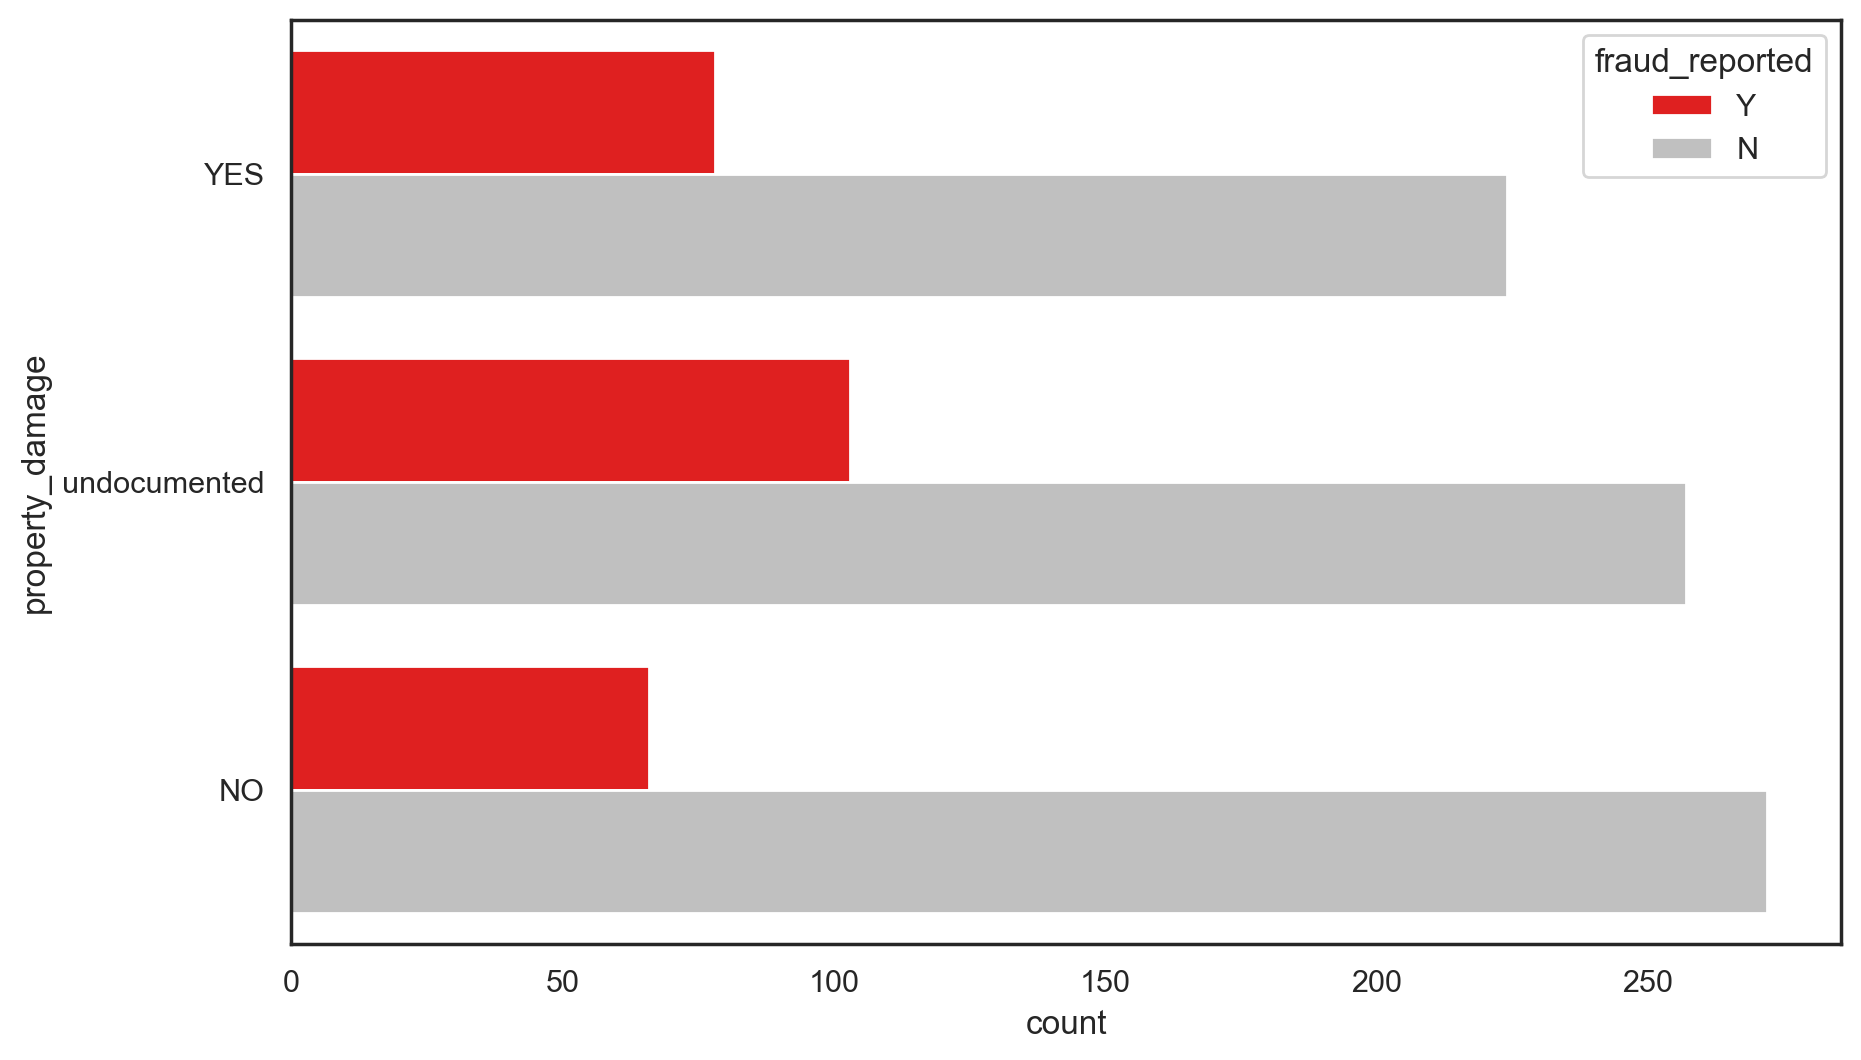

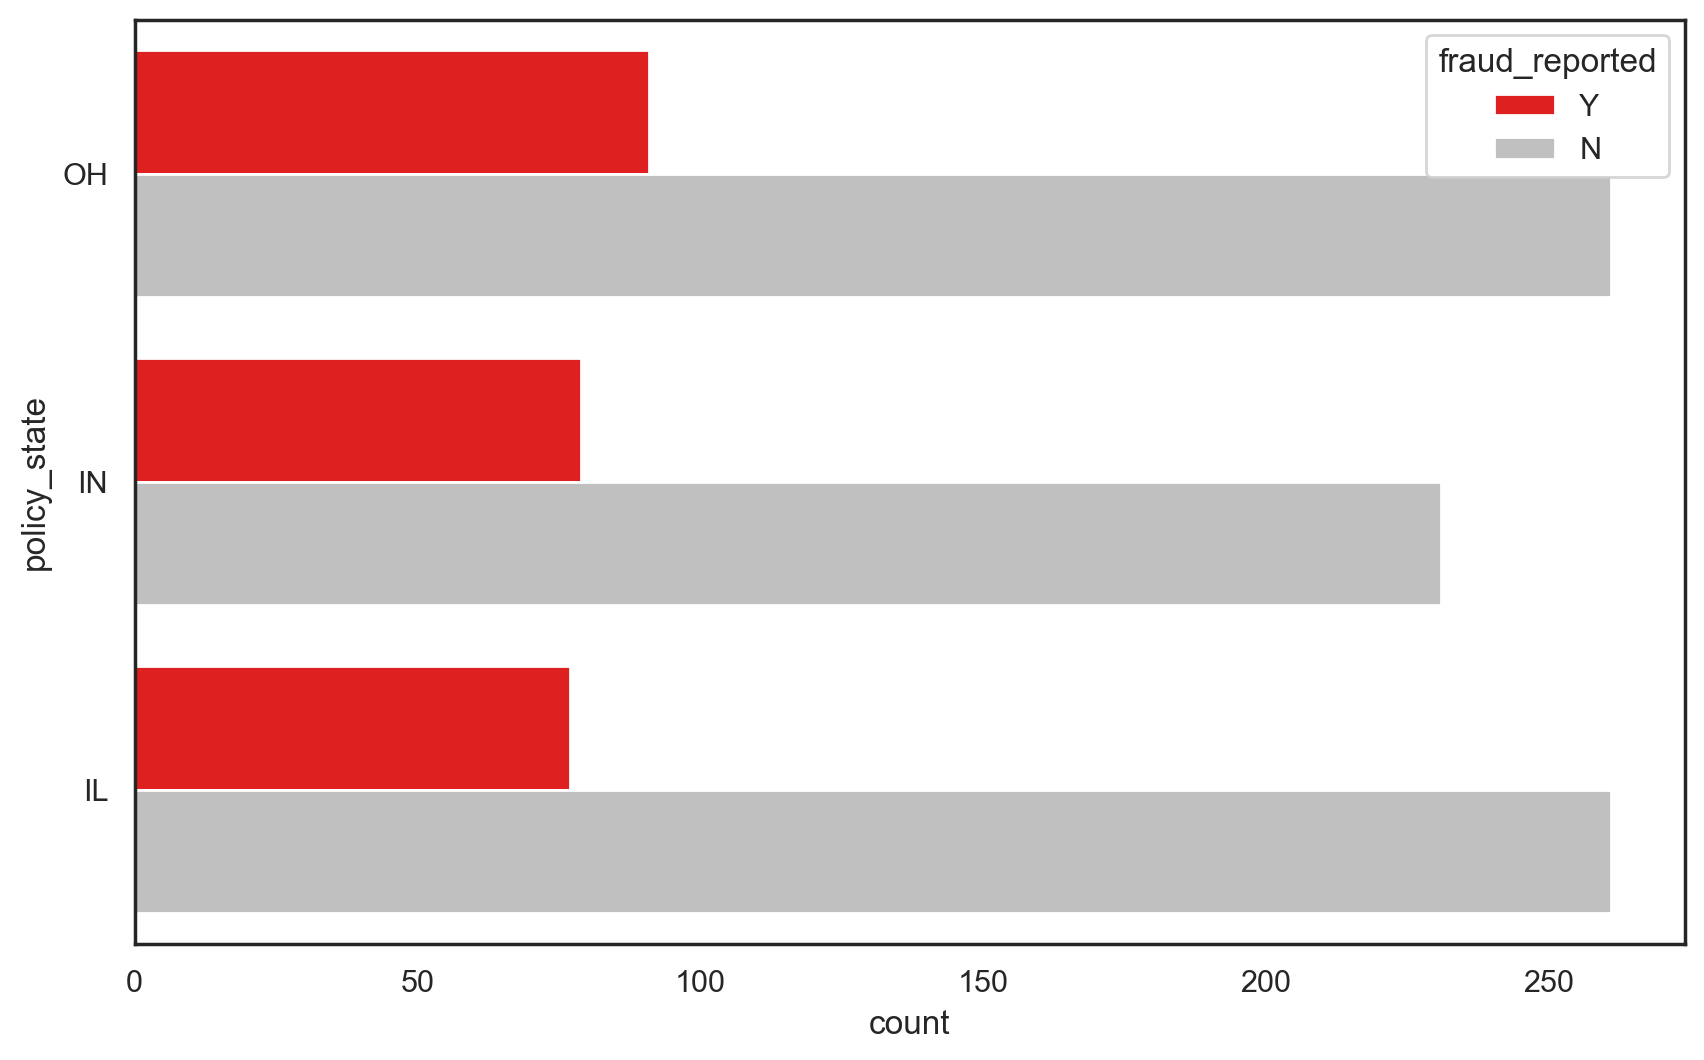

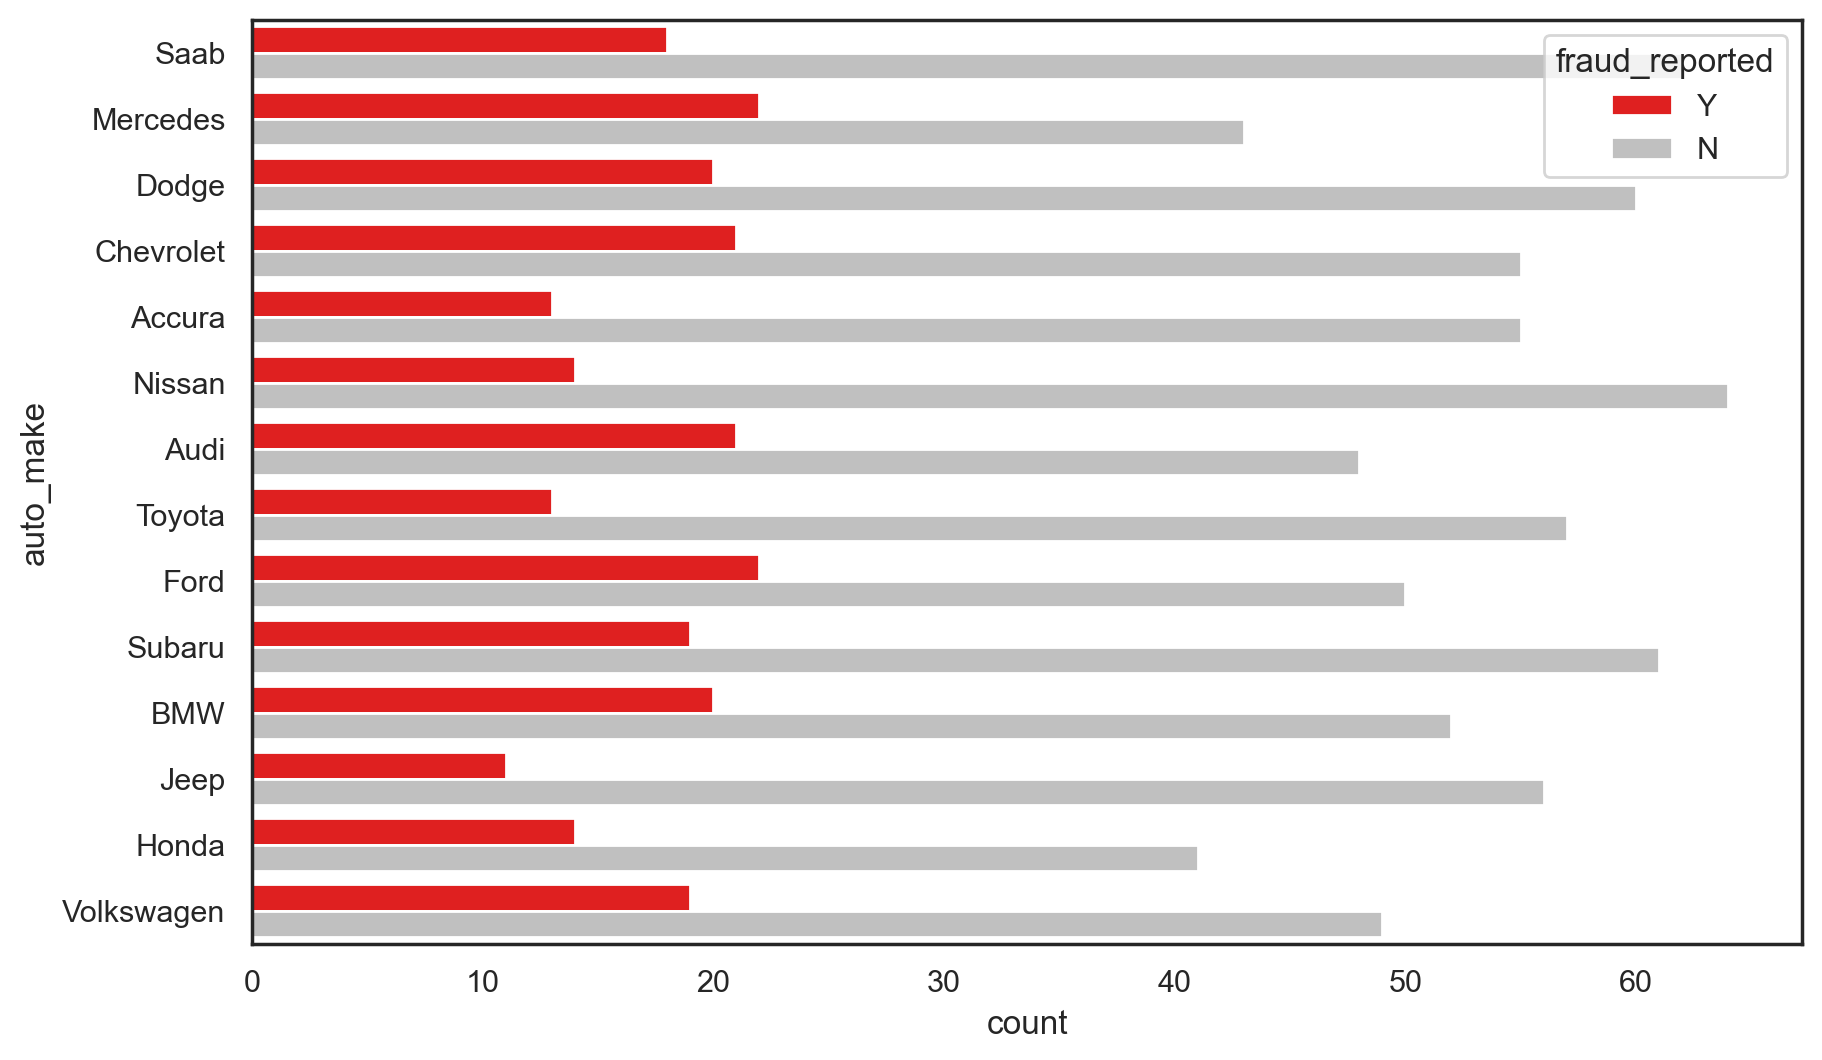

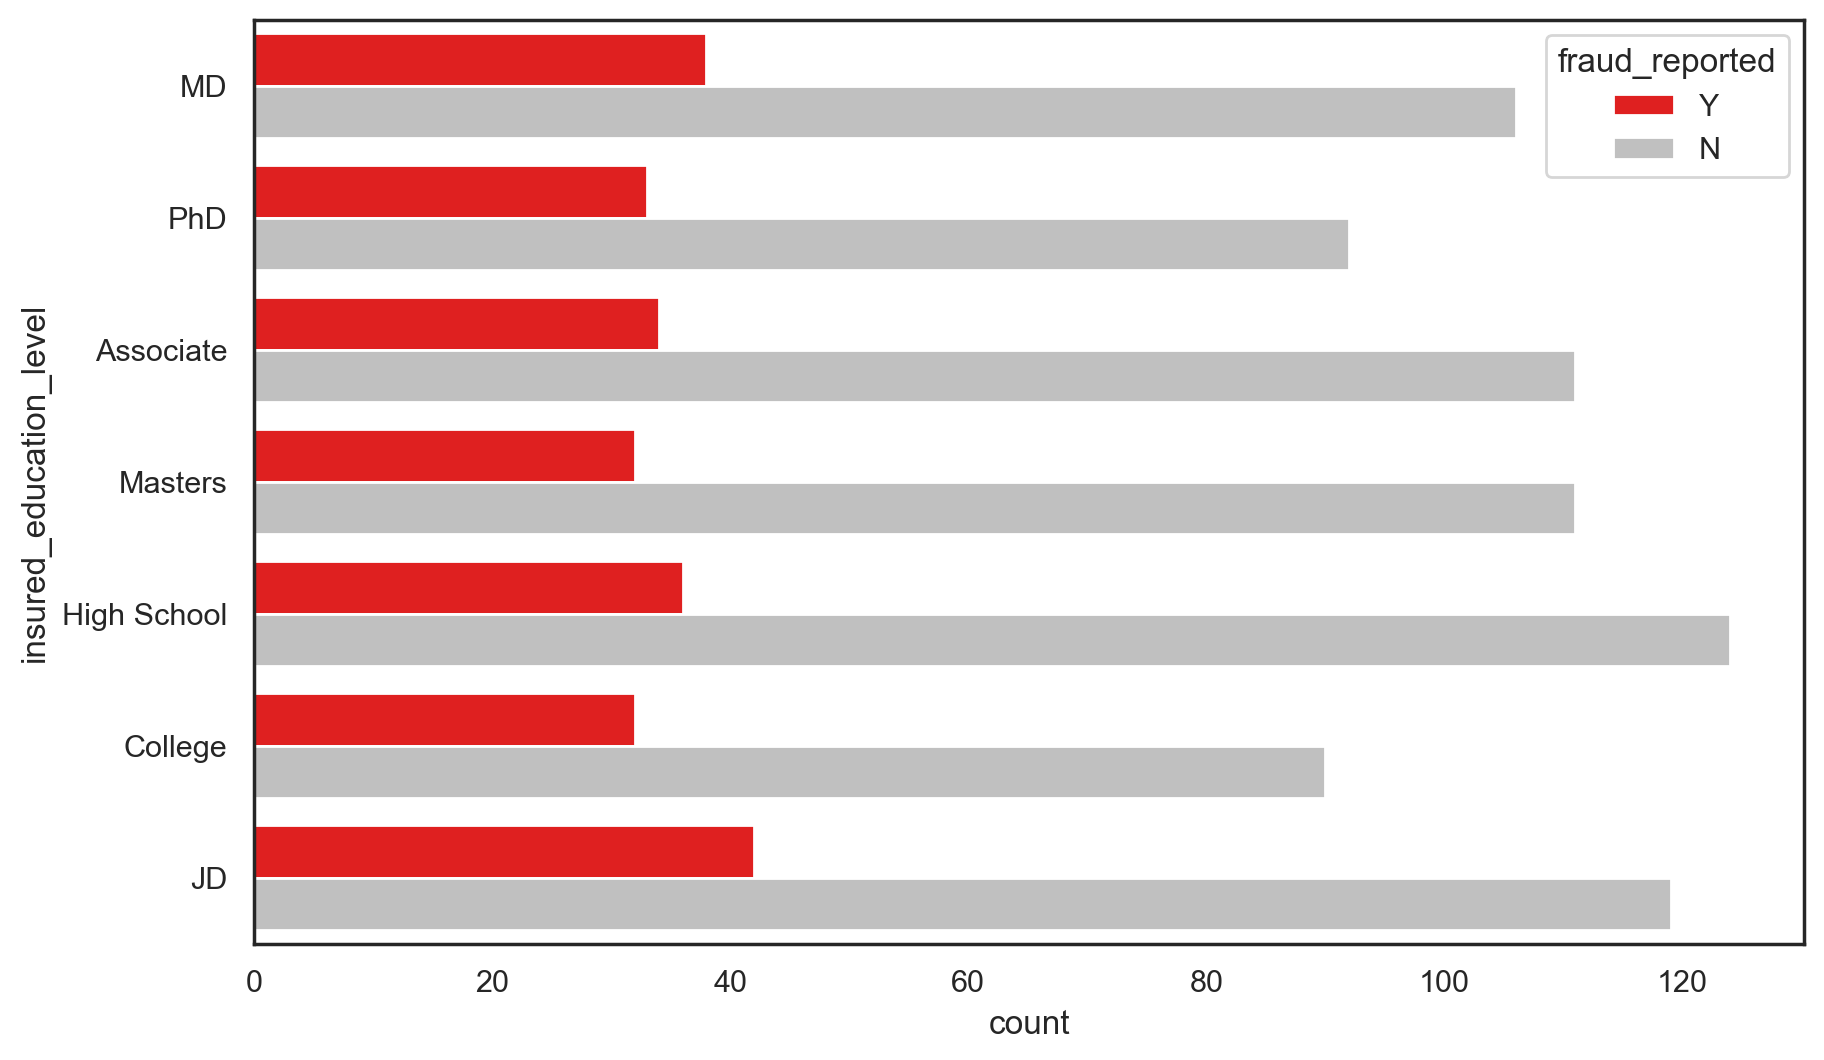

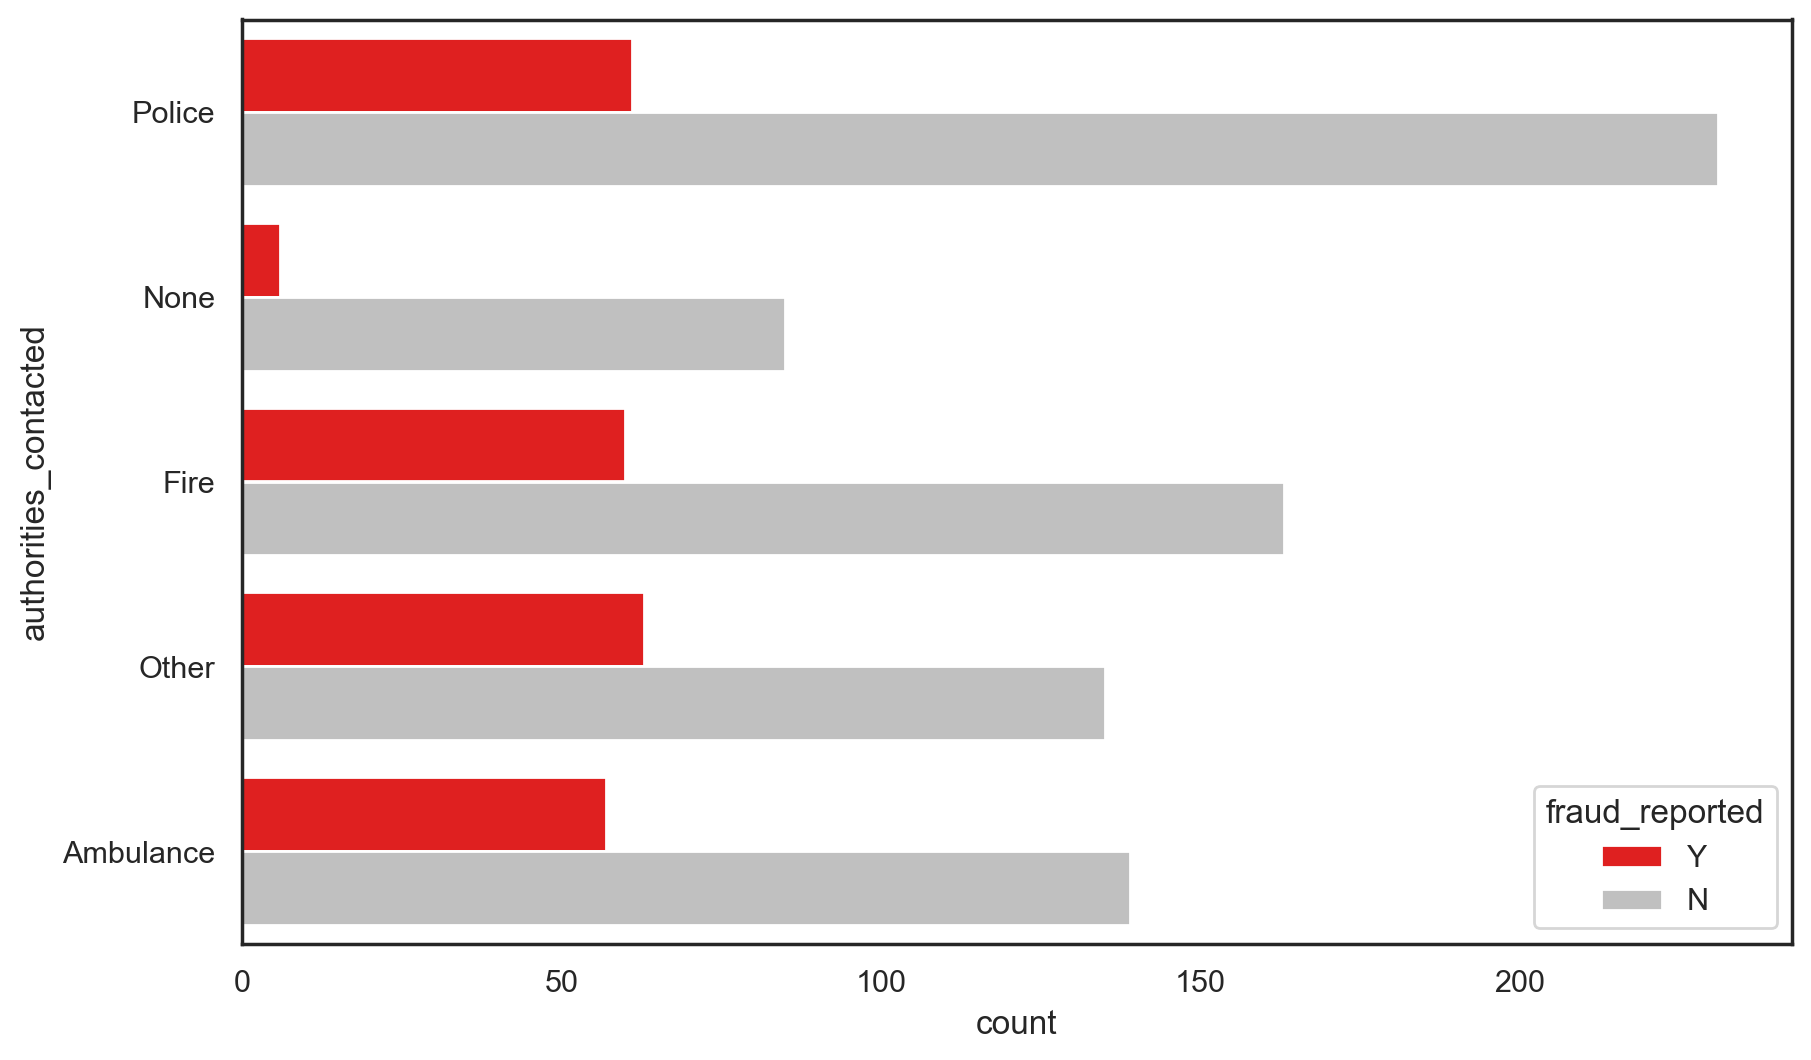

In [41]:
#each discrete var and fraud reported's dist

for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(10,6))
    sns.countplot(y=name, data=df, hue="fraud_reported", palette=['red','silver'])

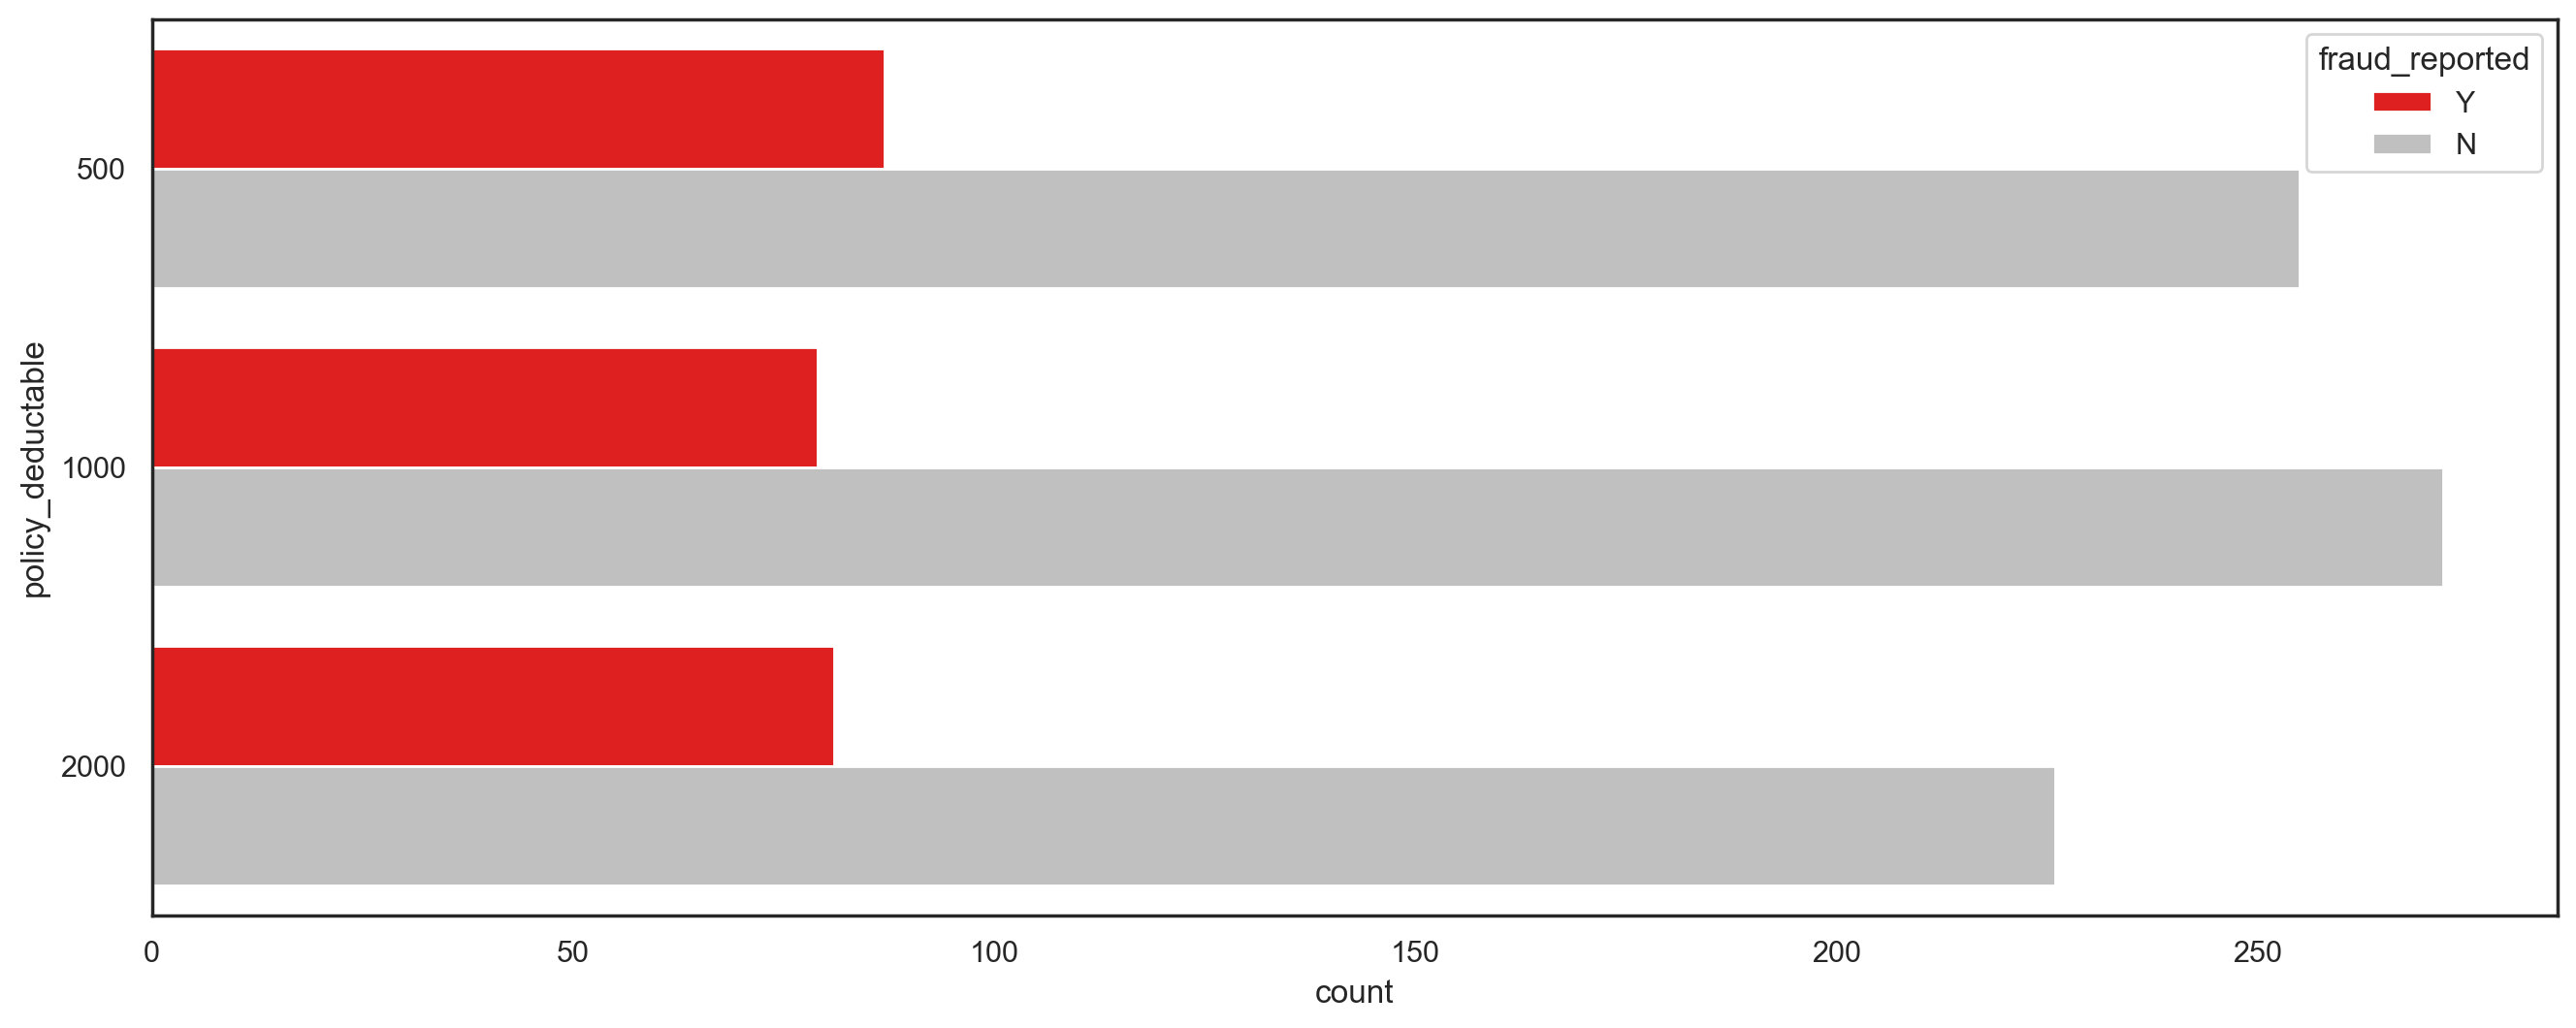

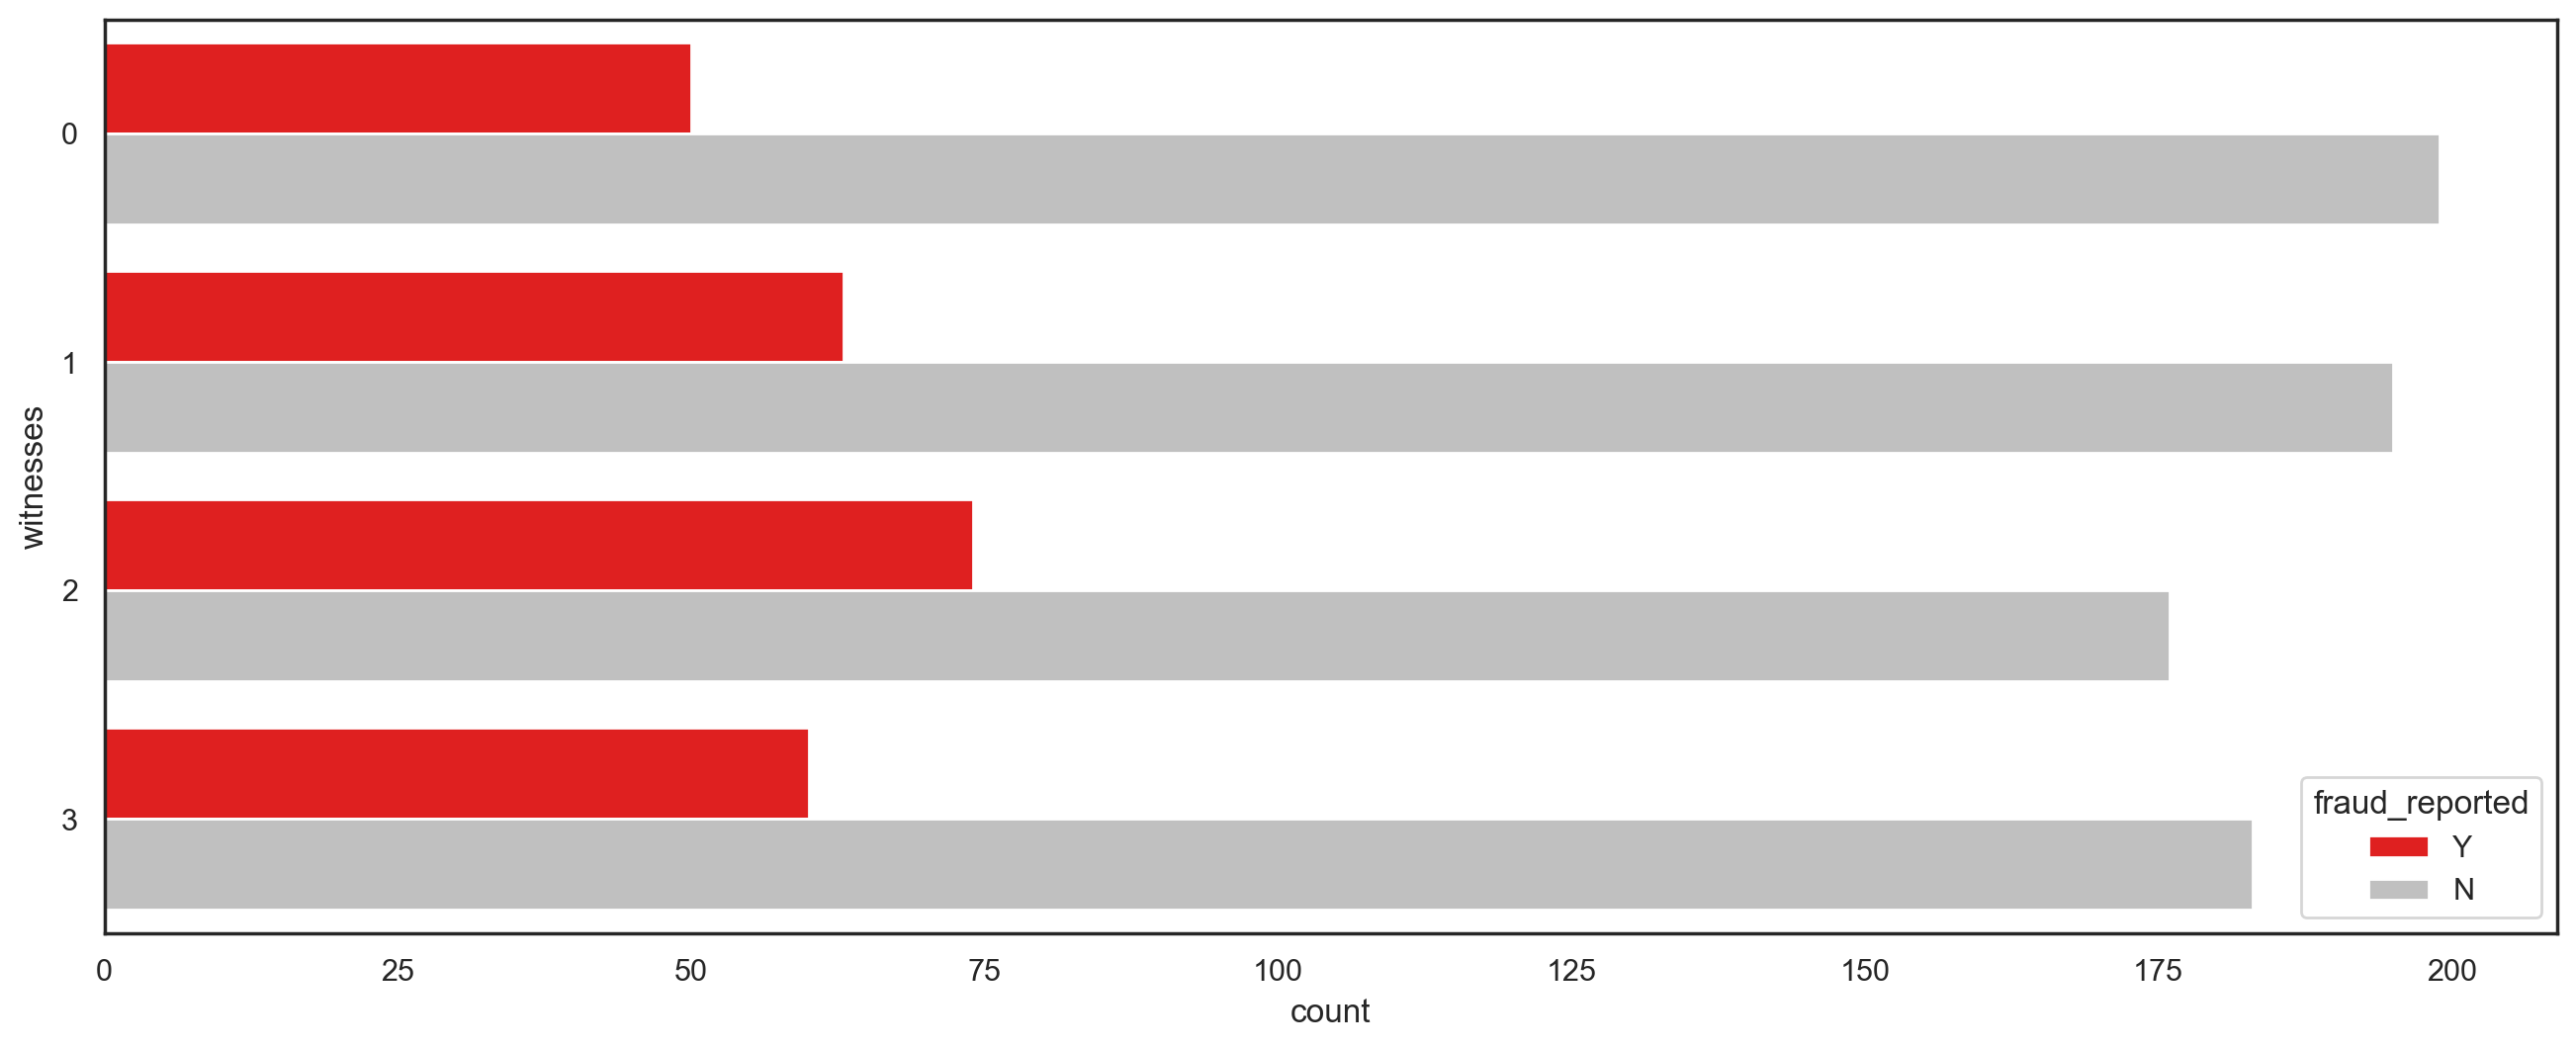

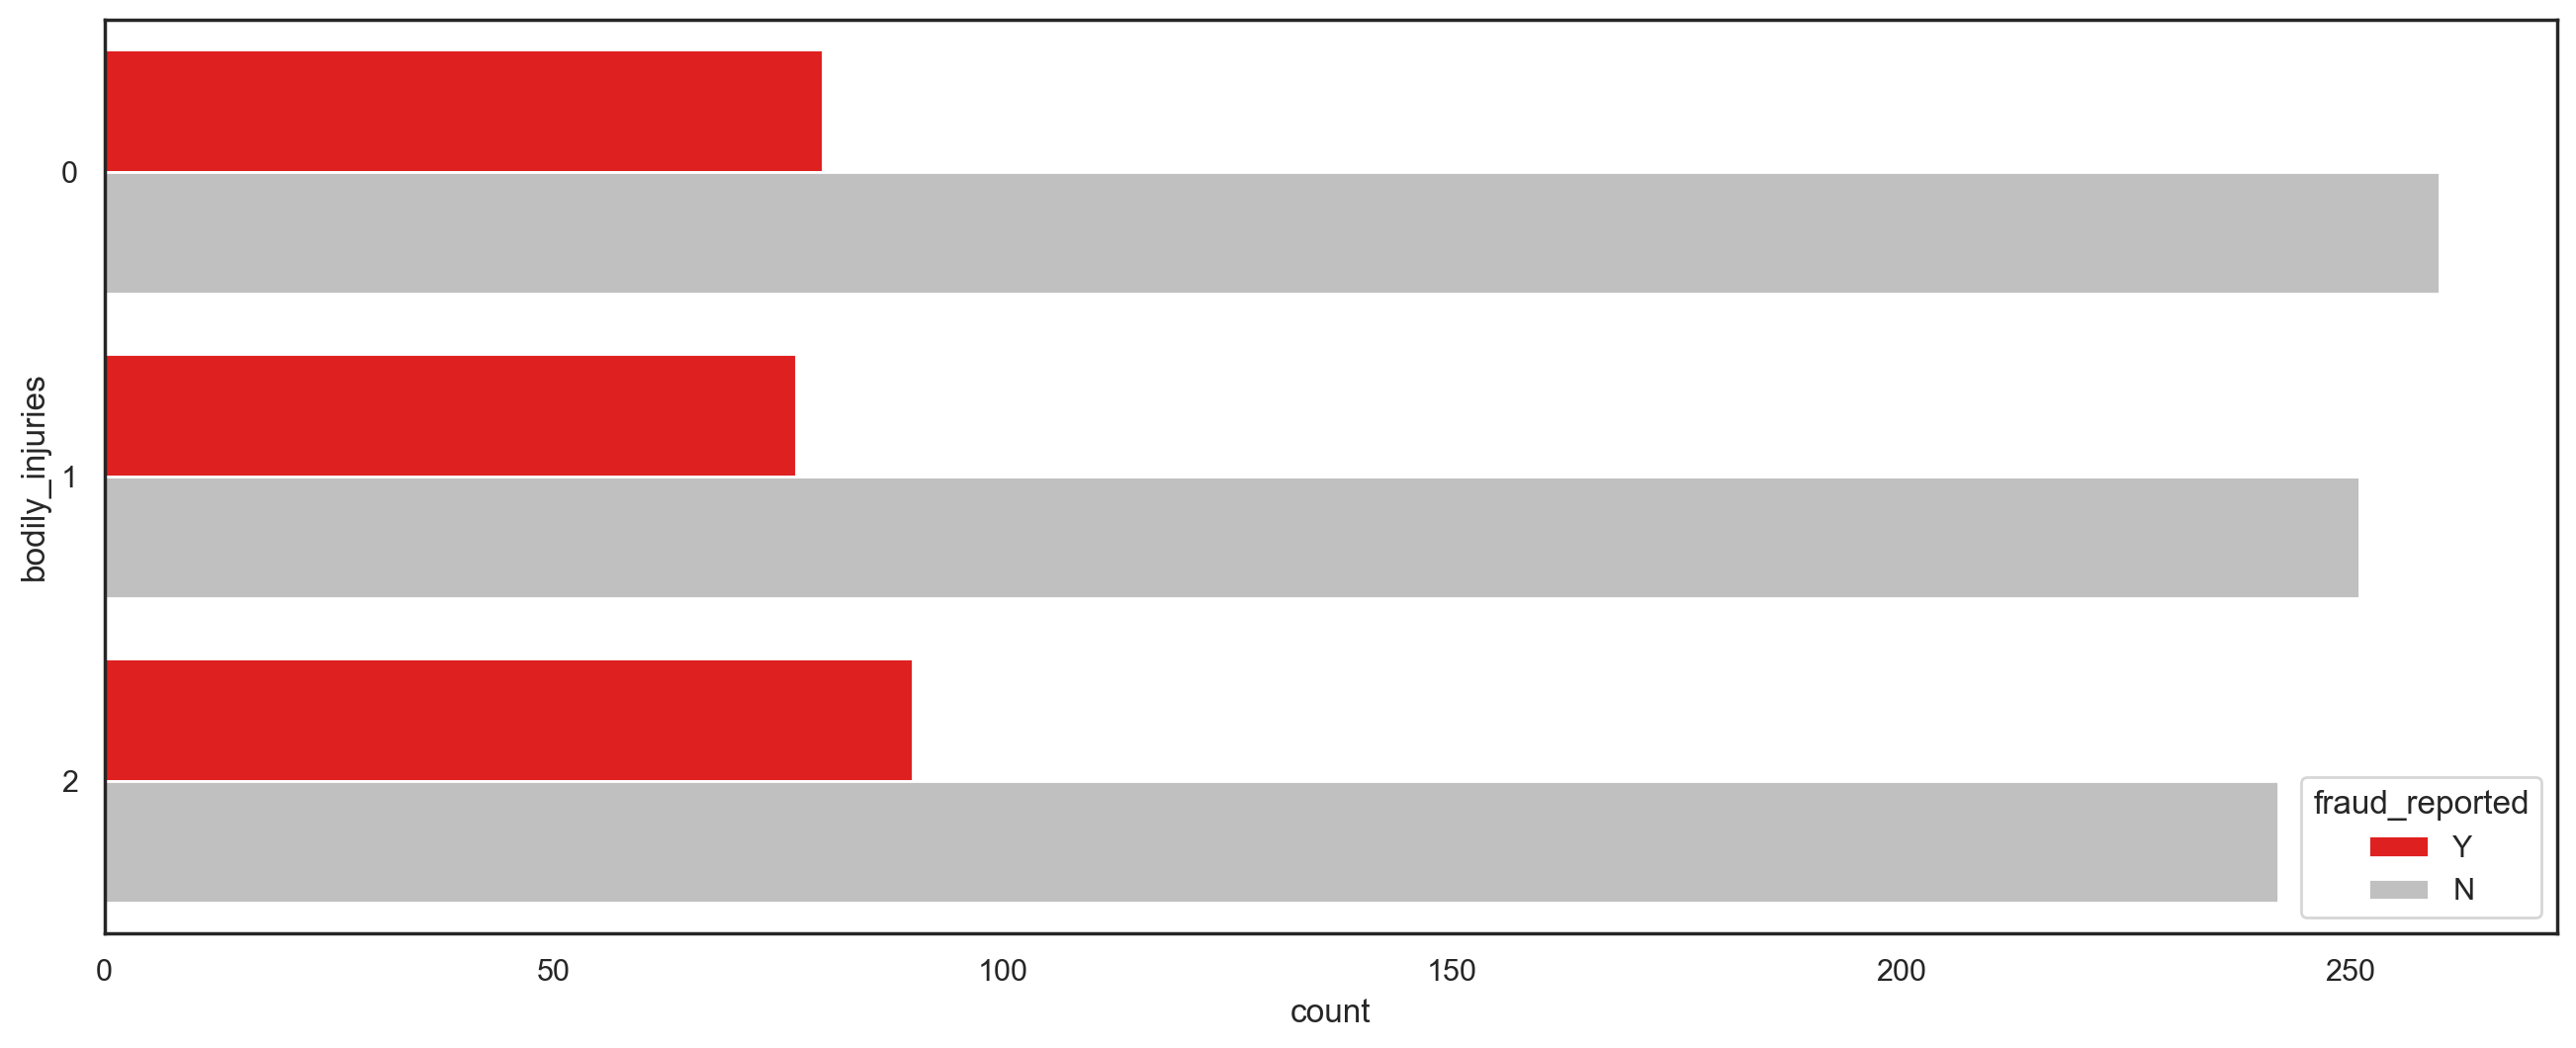

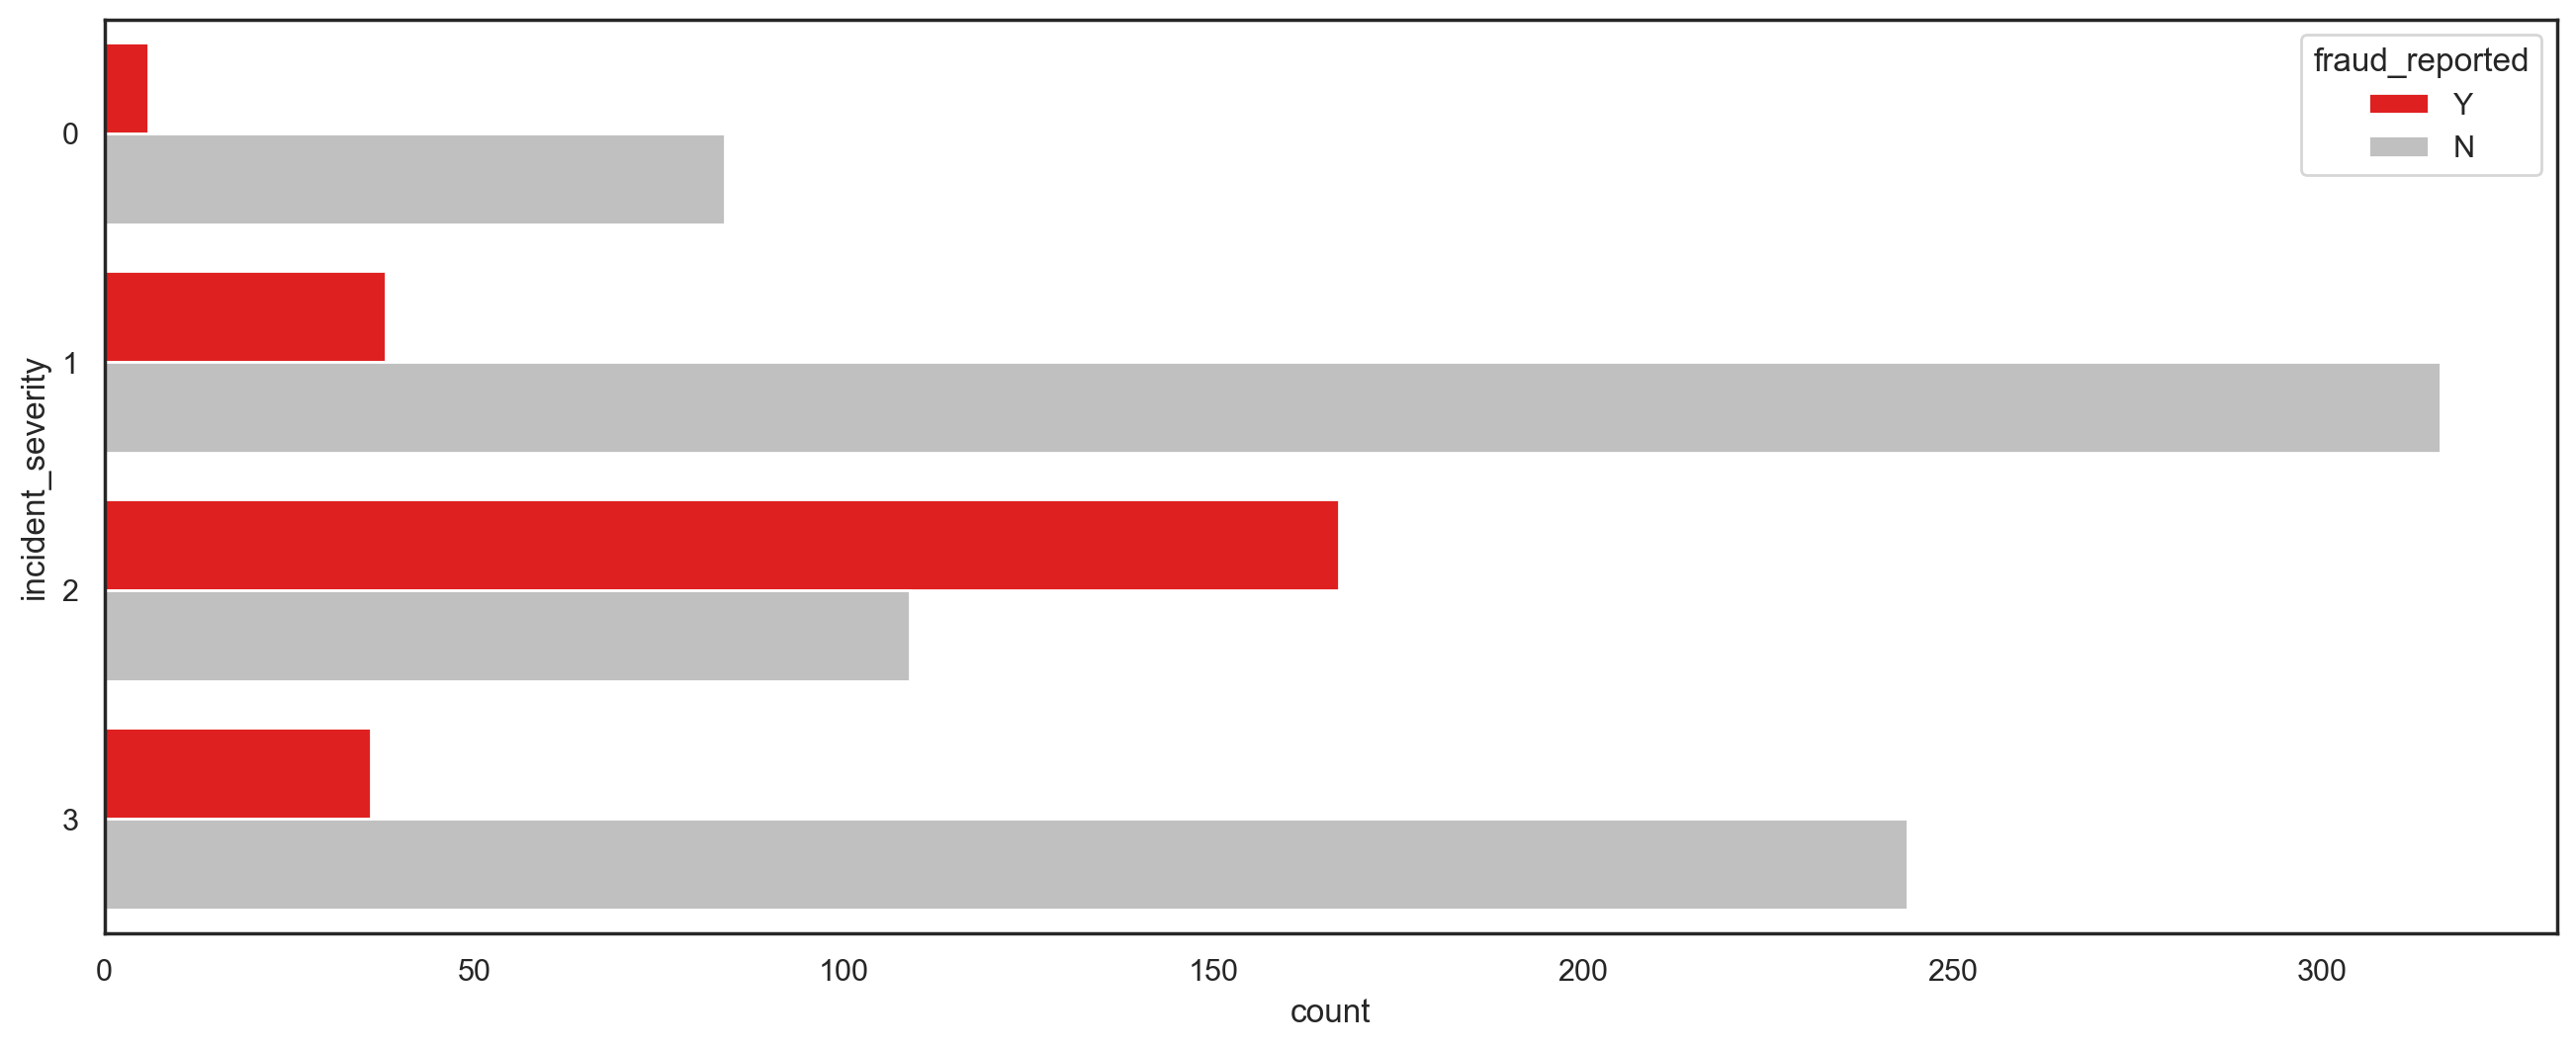

In [42]:
#each ordinal var and fraud reported's dist
#plt.style.use('dark_background')
#plt.style.use('default')


for i, name in enumerate(df[ord_var]):
    plt.figure(i,figsize=(16,6))
    sns.countplot(data=df, y=name, hue='fraud_reported', palette=['red','silver'])
    

<Figure size 1600x600 with 0 Axes>

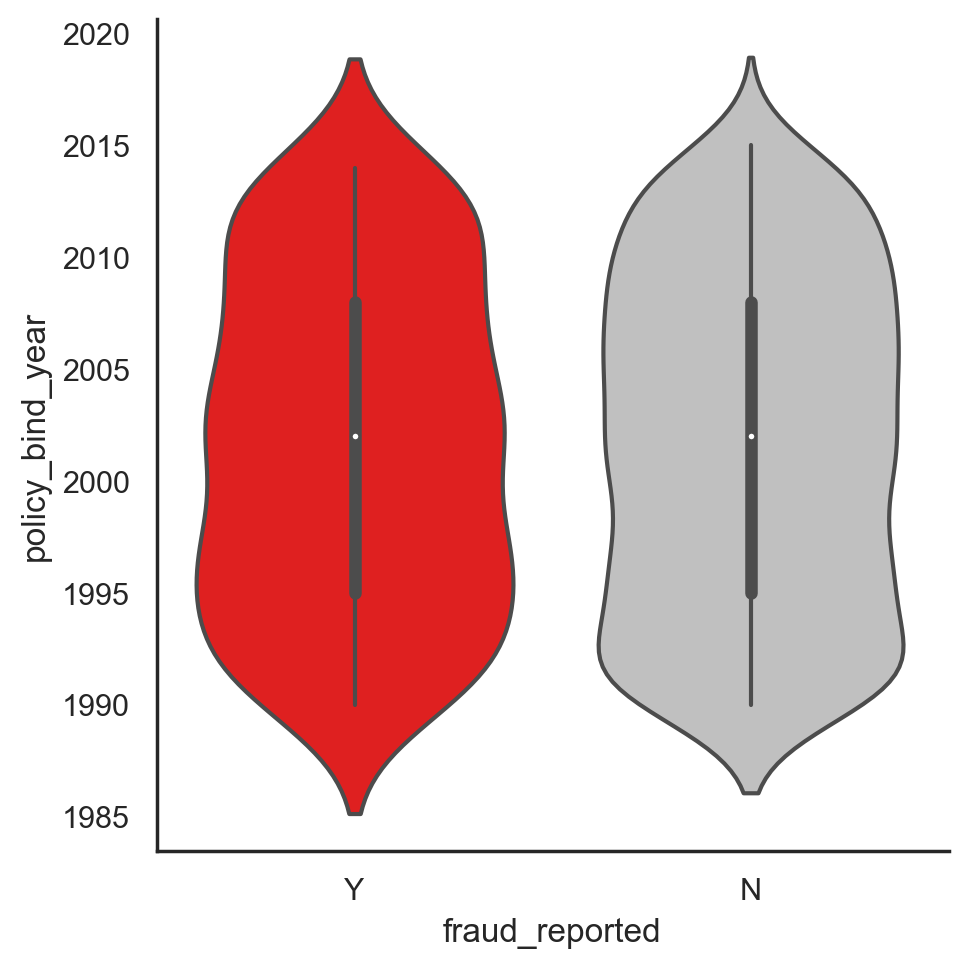

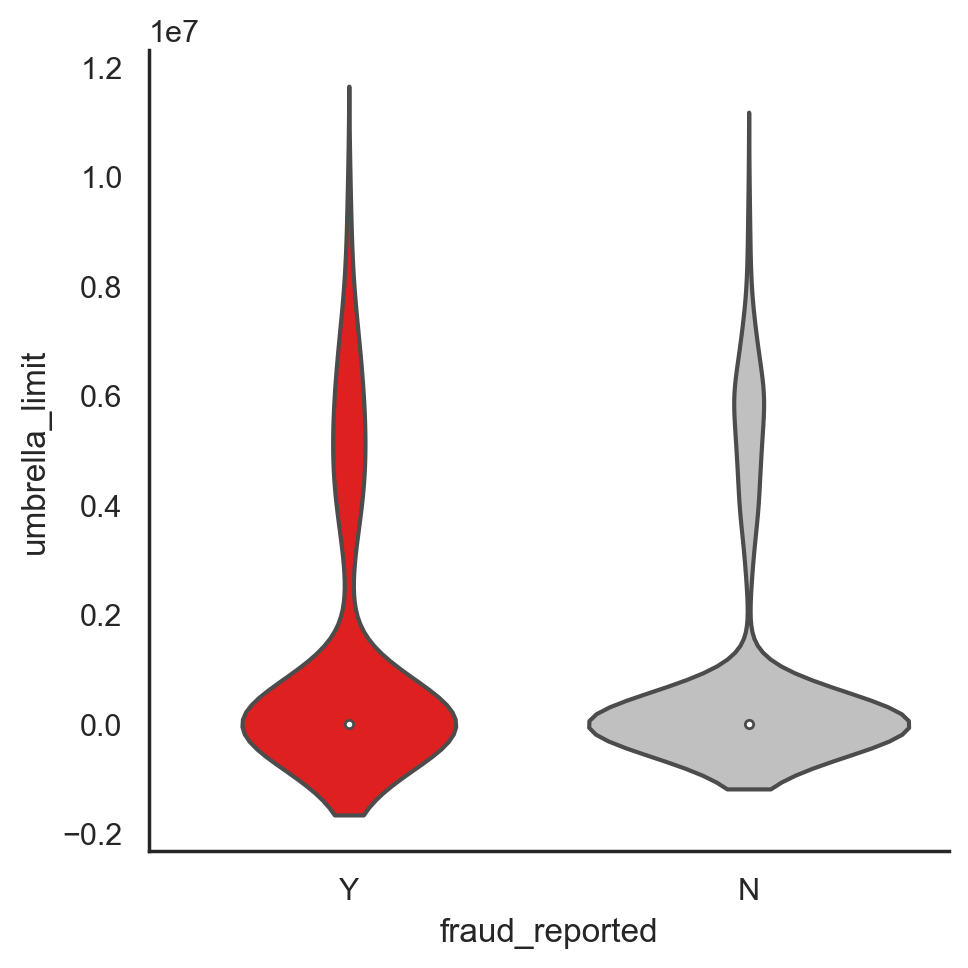

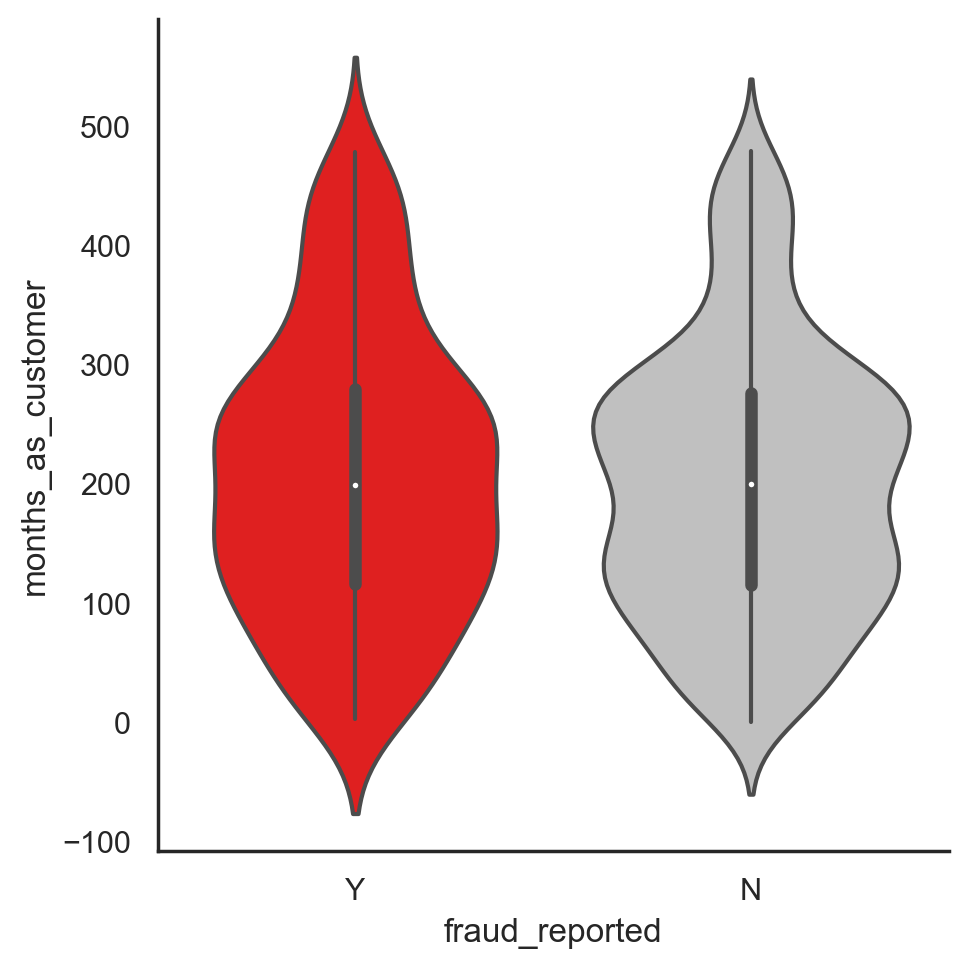

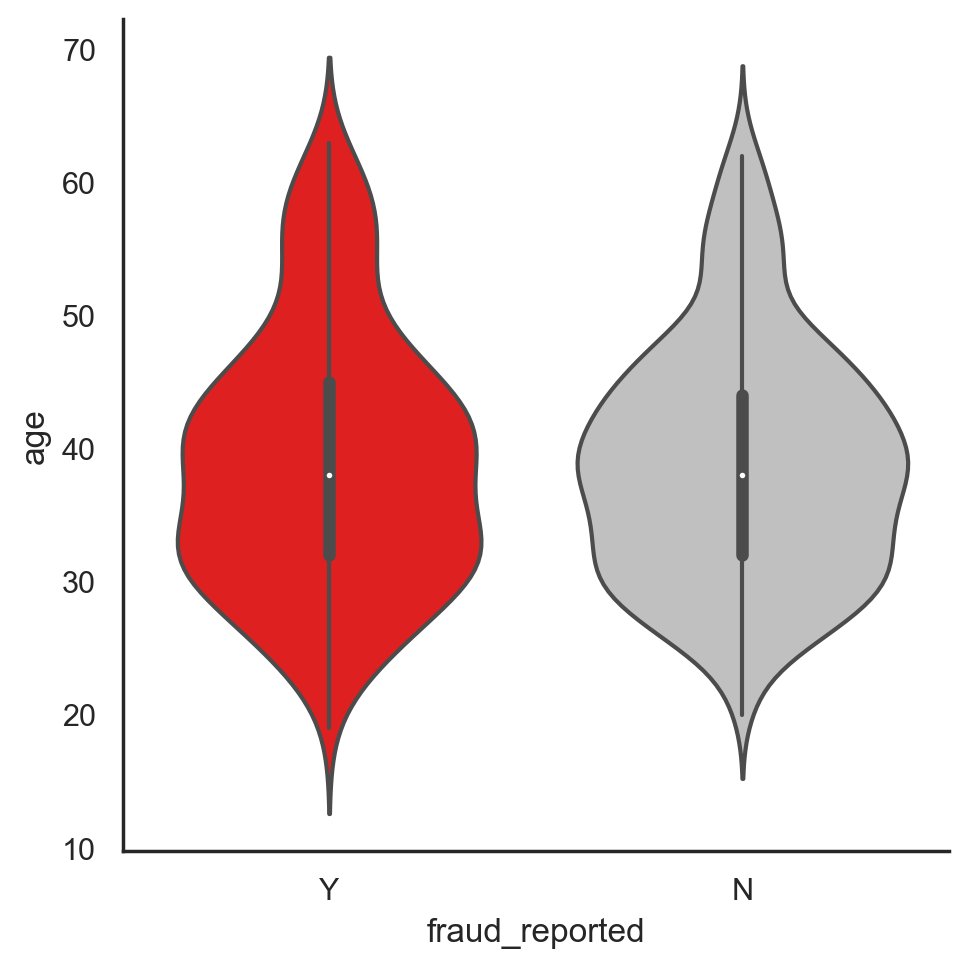

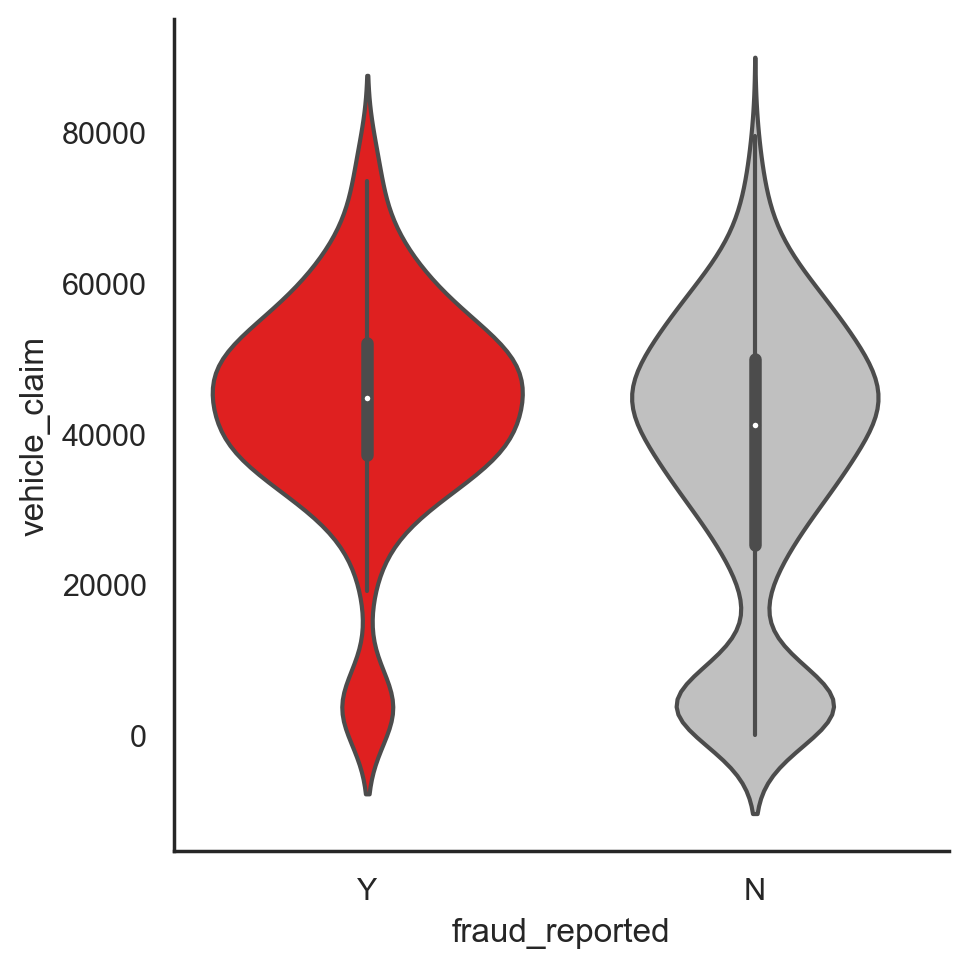

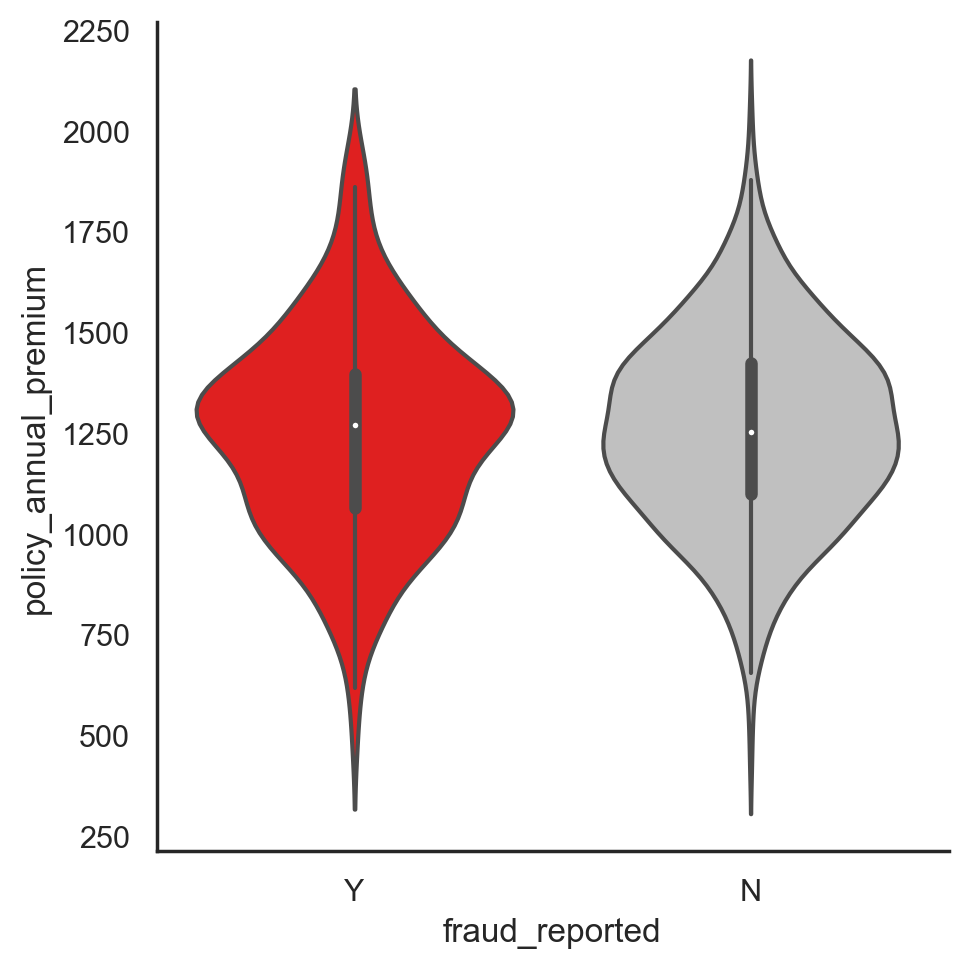

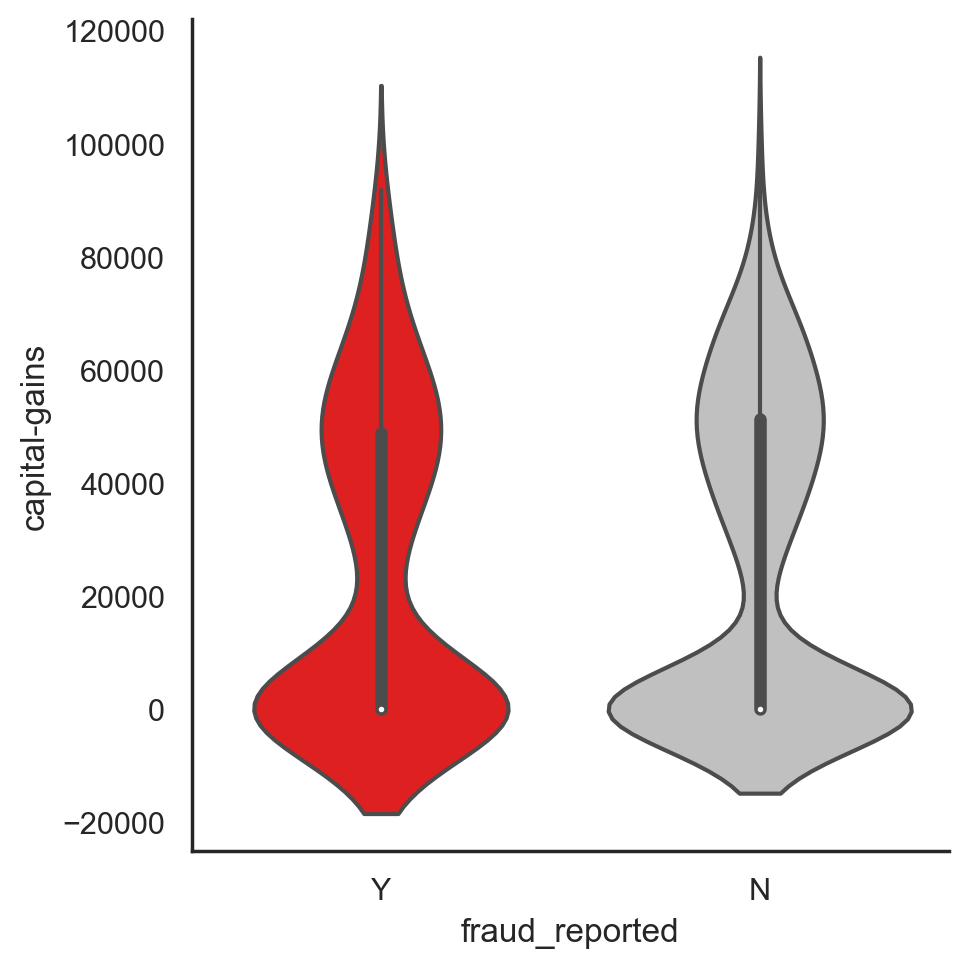

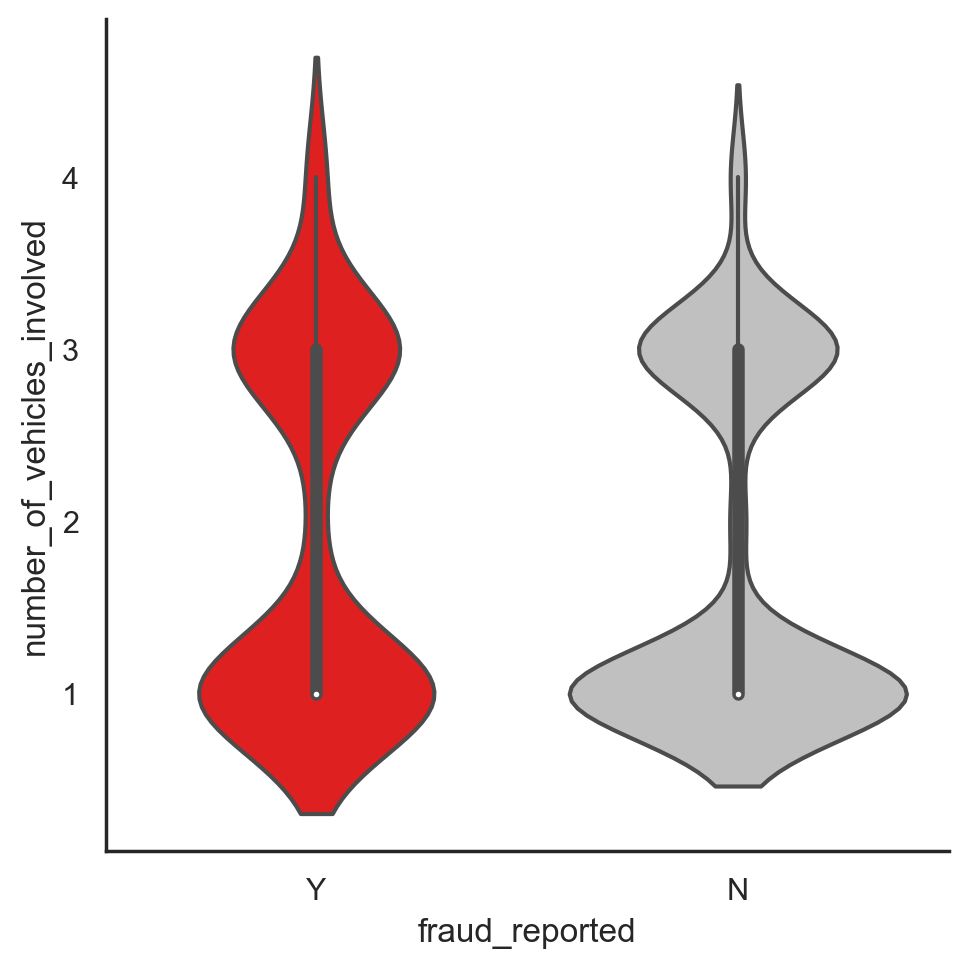

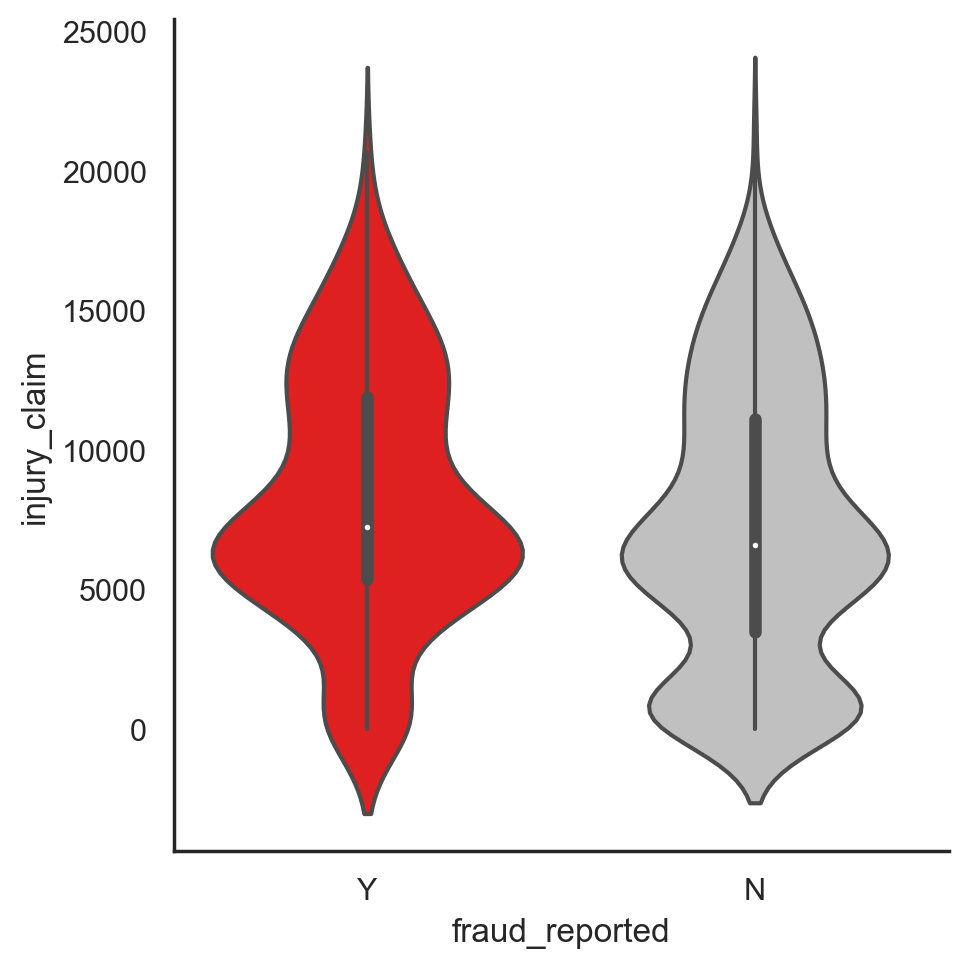

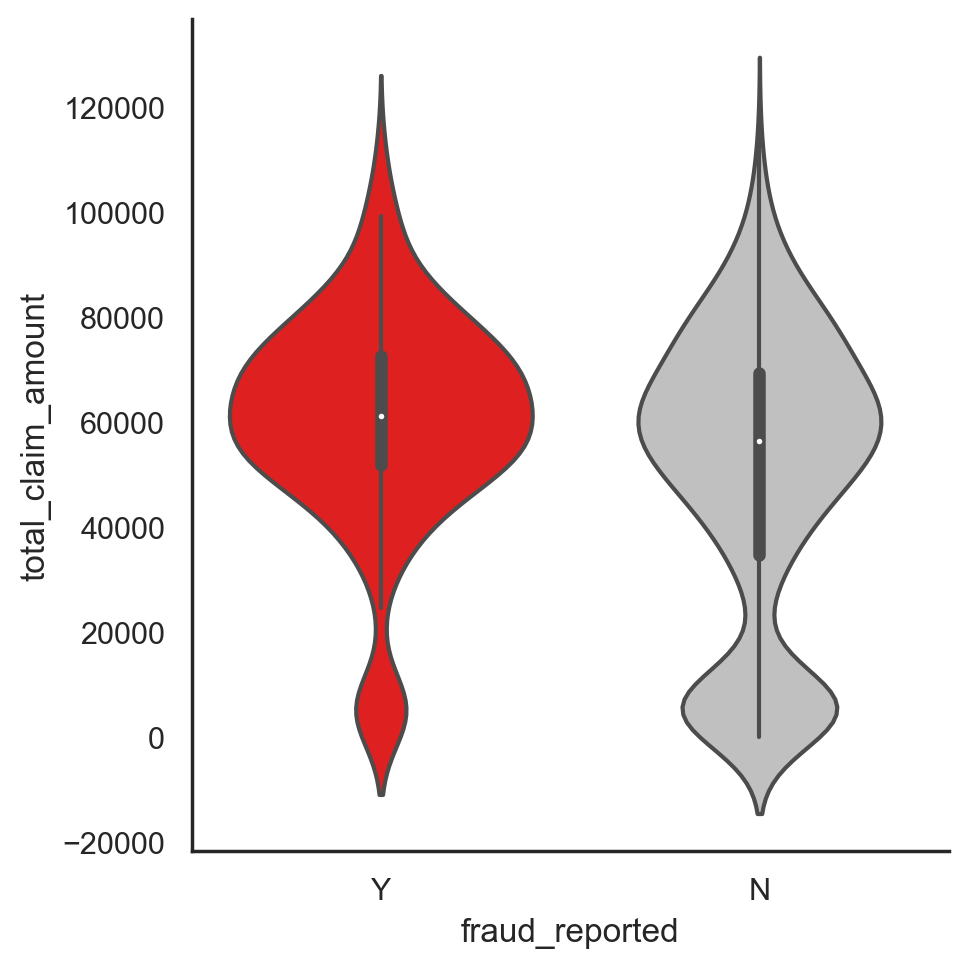

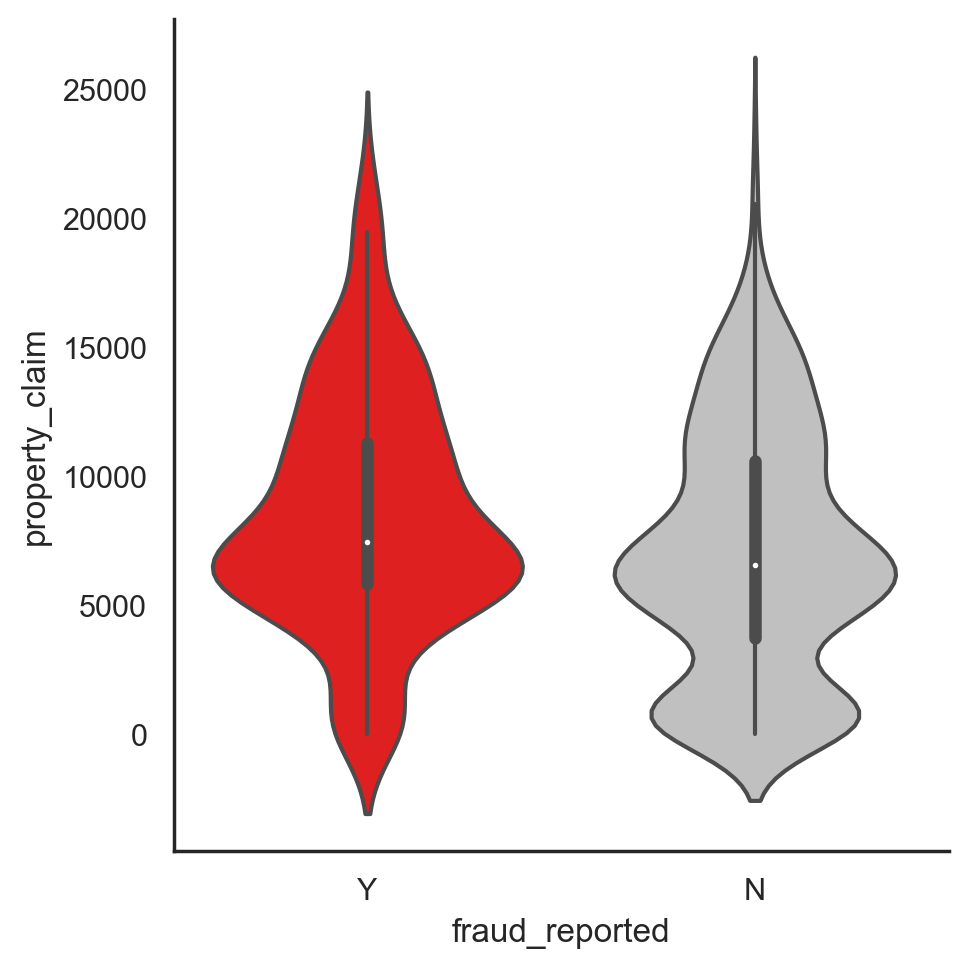

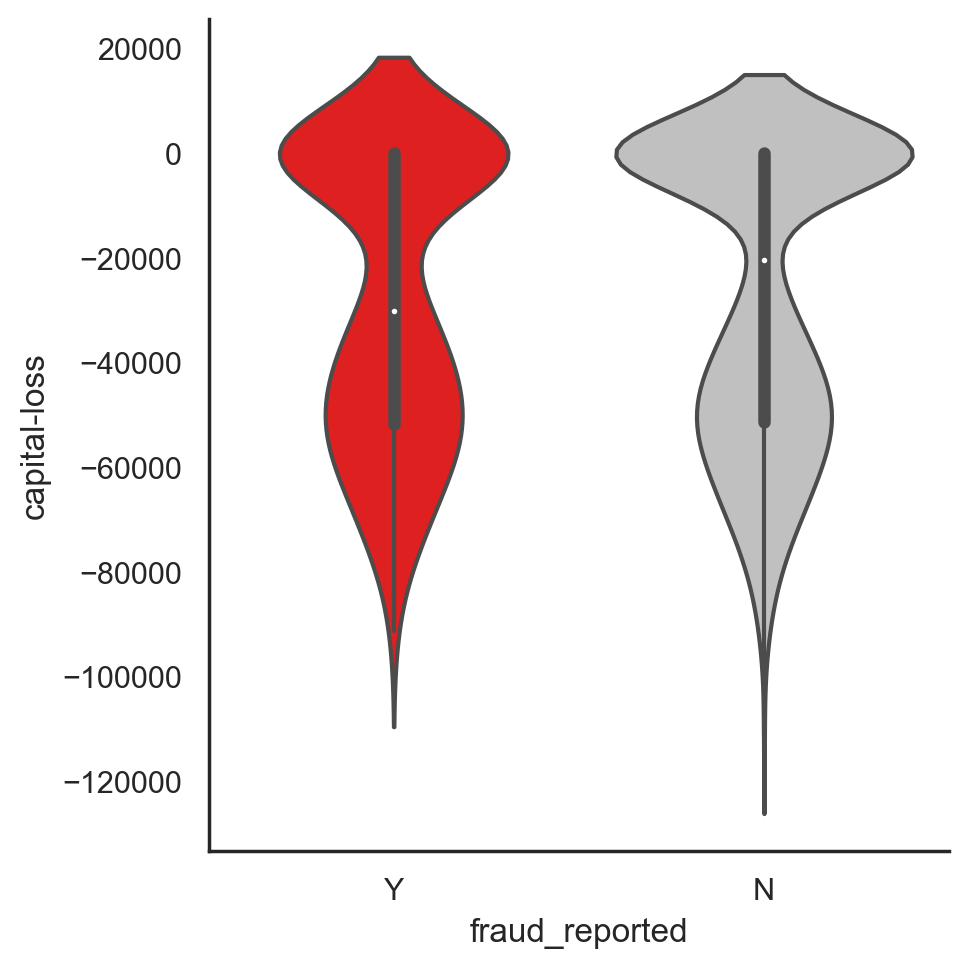

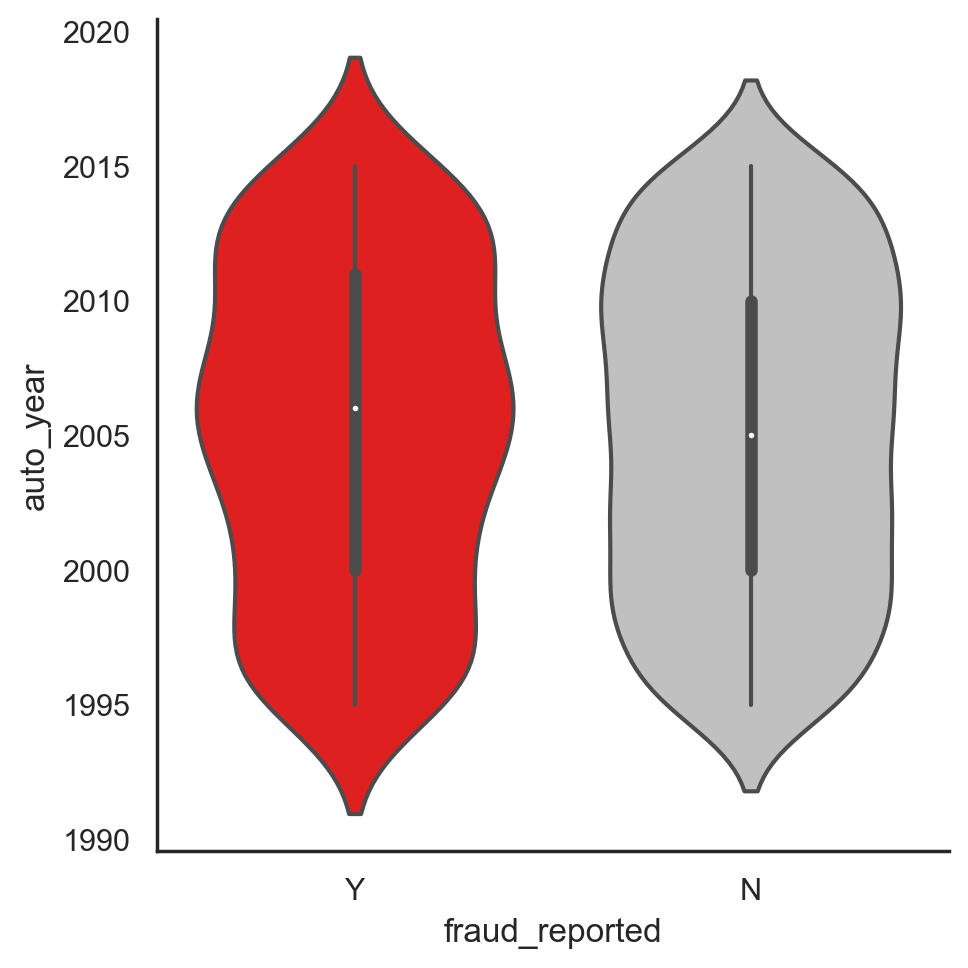

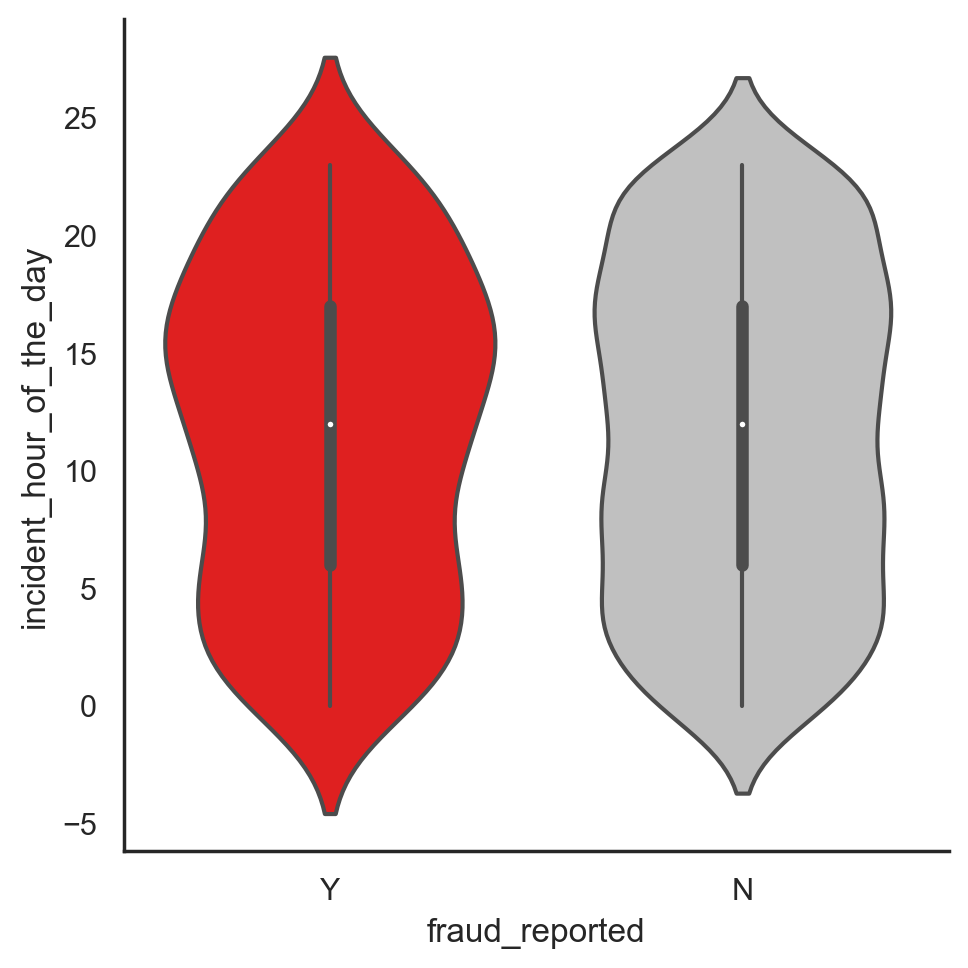

In [43]:
#each continous var and fraud reported's dist

for i, name in enumerate(df[quan_var]):
    plt.figure(i,figsize=(16,6))
    sns.catplot(data=df, x="fraud_reported", y=name, kind='violin', palette=['red','silver'])
    

**Observations**

Little have I suspected that fraud differed across hobbies. It seems like chess players and cross-fitters have higher tendencies of fraud. I stopped to think if the sports develop one to be inclined to fraud or that people with tendencies are drawn to it.

<br>
<details><summary>Drop down to jump to that graph</summary>

![](images/fig3.png)
    
</details>

Major incident severity seems to have highest fraud cases that exceed non fraud cases.

<br>
<details><summary>Drop down to jump to that graph</summary>

![](images/fig4.PNG)
    
</details>

There seem to be more frauds than non-fraud claims along the mean of total claims. 

<br>
<details><summary>Drop down to jump to that graph</summary>

![](images/fig5.PNG)
    
</details>


### Additional visualization and observations

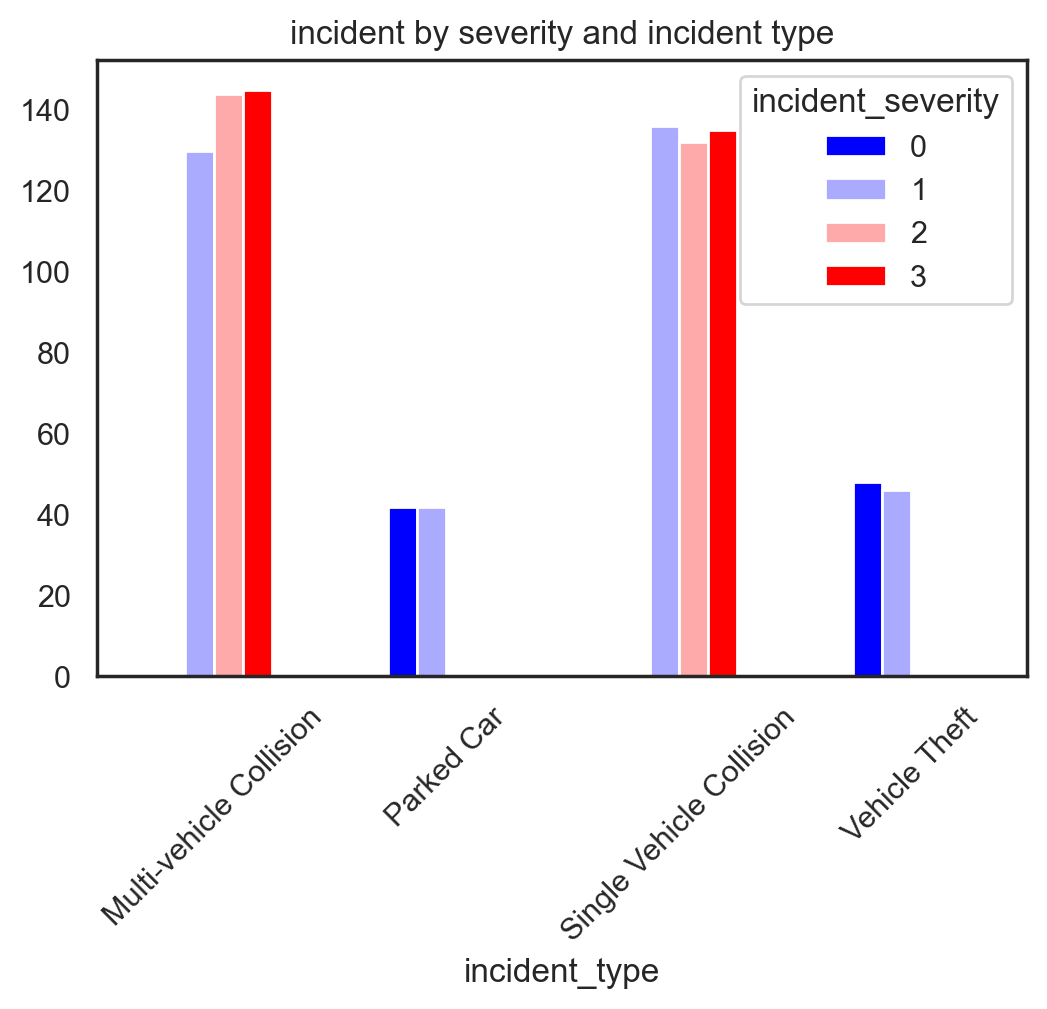

In [44]:
#cross tab of incident type and severity 
#more severe accidents seem to only be present with collision 

incident = pd.crosstab(df['incident_type'], df['incident_severity'])

incident.plot(kind='bar', colormap='bwr',figsize=(6,4))
plt.xticks(rotation=45)
plt.title("incident by severity and incident type");

More severe accidents seem to only be present with collision.

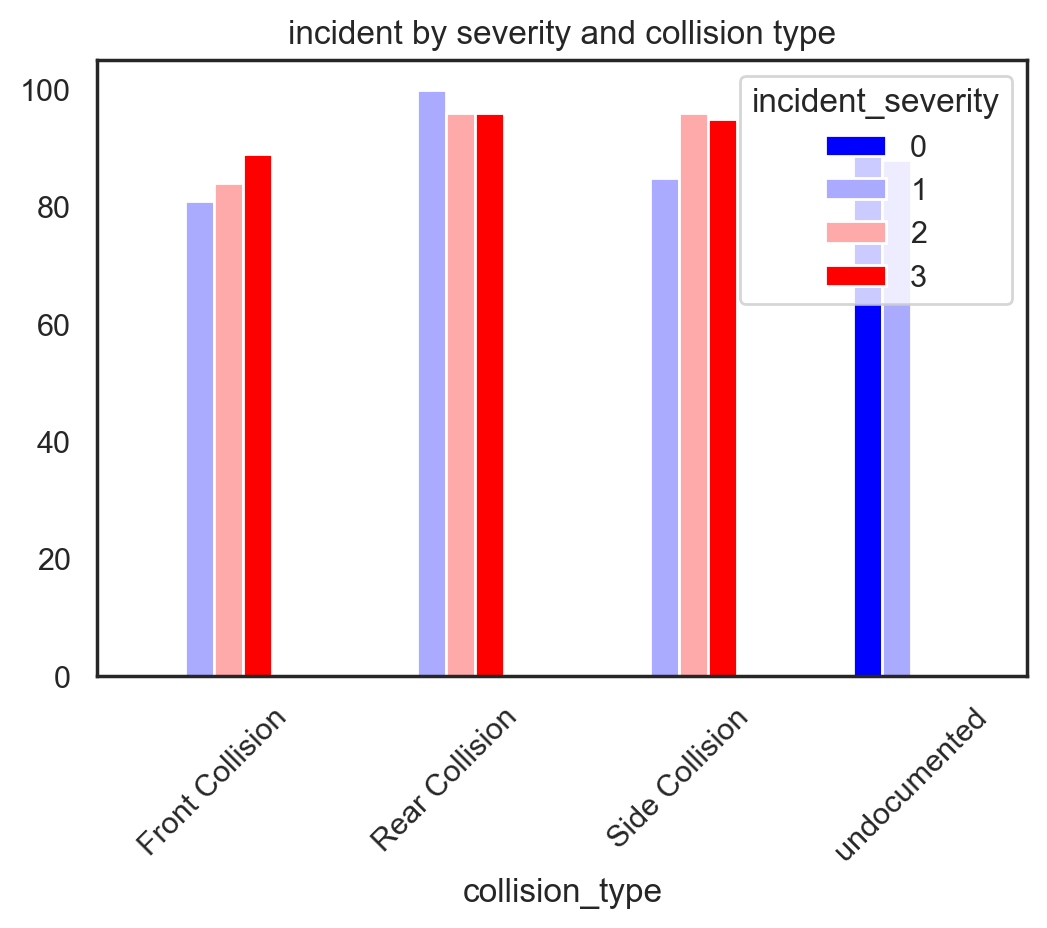

In [45]:
#undocumented collision types tend to be less severe

incident = pd.crosstab(df['collision_type'], df['incident_severity'])

incident.plot(kind='bar', colormap='bwr', figsize=(6,4))
plt.xticks(rotation=45)
plt.title("incident by severity and collision type");

Undocumented collision types tend to be less severe. Perhaps the drivers see no need to document since accidents are not major.

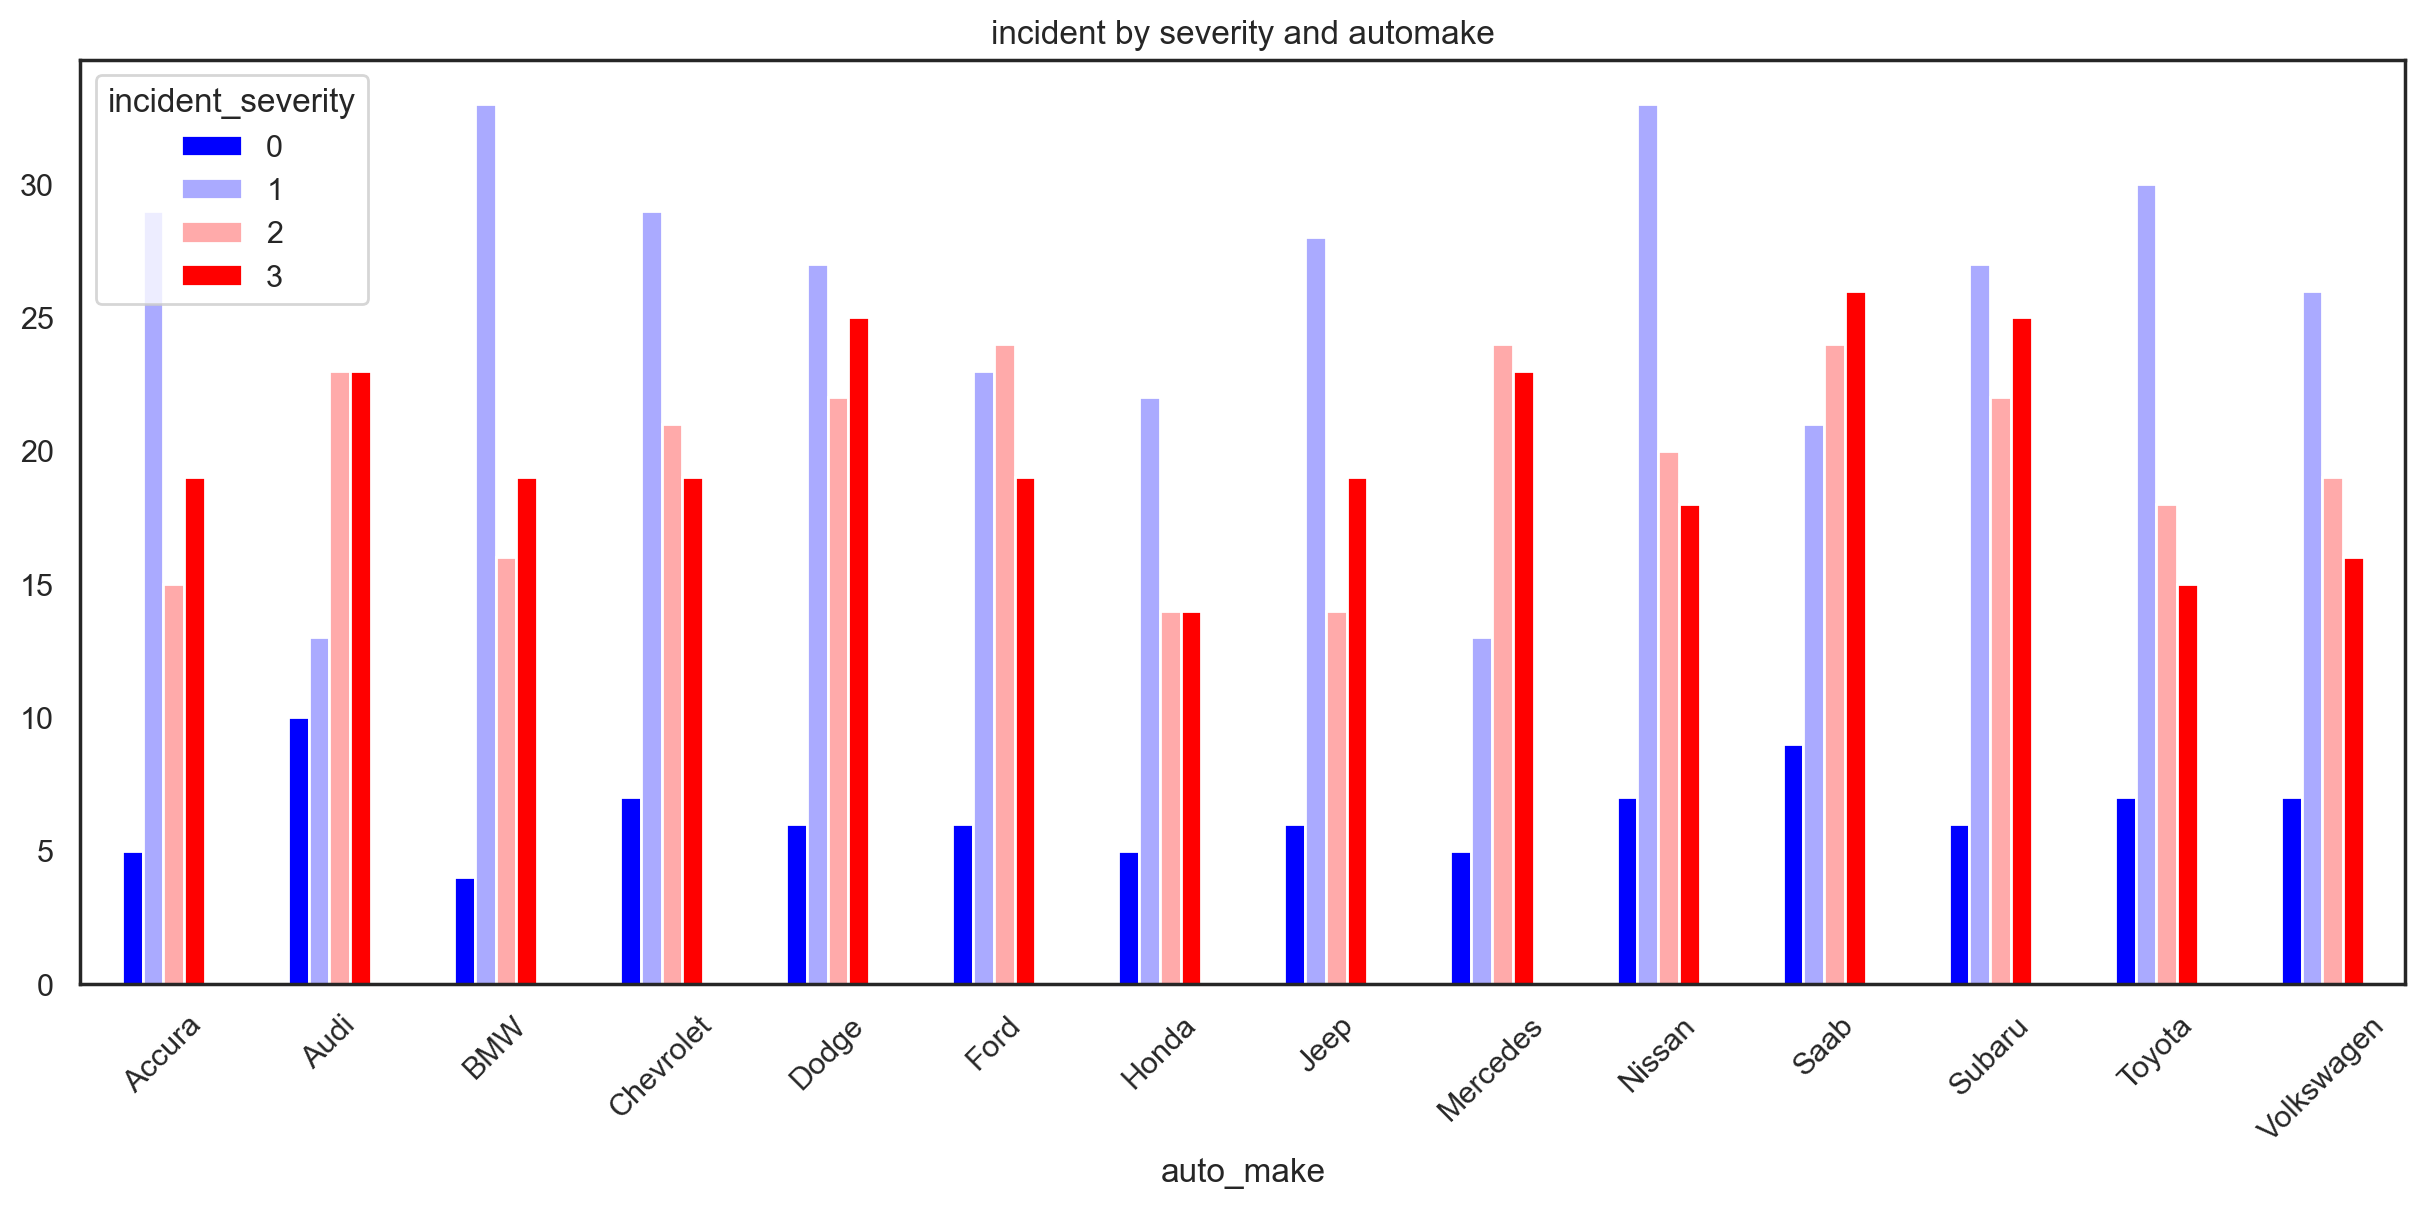

In [46]:
# seems like bmw and nissan gets a lot of minor accident
# fiercer cars like dodge, subaru, saab, merc get into mor severe accident

incident = pd.crosstab(df['auto_make'], df['incident_severity'])
incident.plot(kind='bar', colormap='bwr',figsize=(15,6))
plt.xticks(rotation=45)
plt.title("incident by severity and automake");

Seems like bmw and nissan gets a lot of minor accident
Fiercer cars like dodge, subaru, saab, merc get into mor severe accident

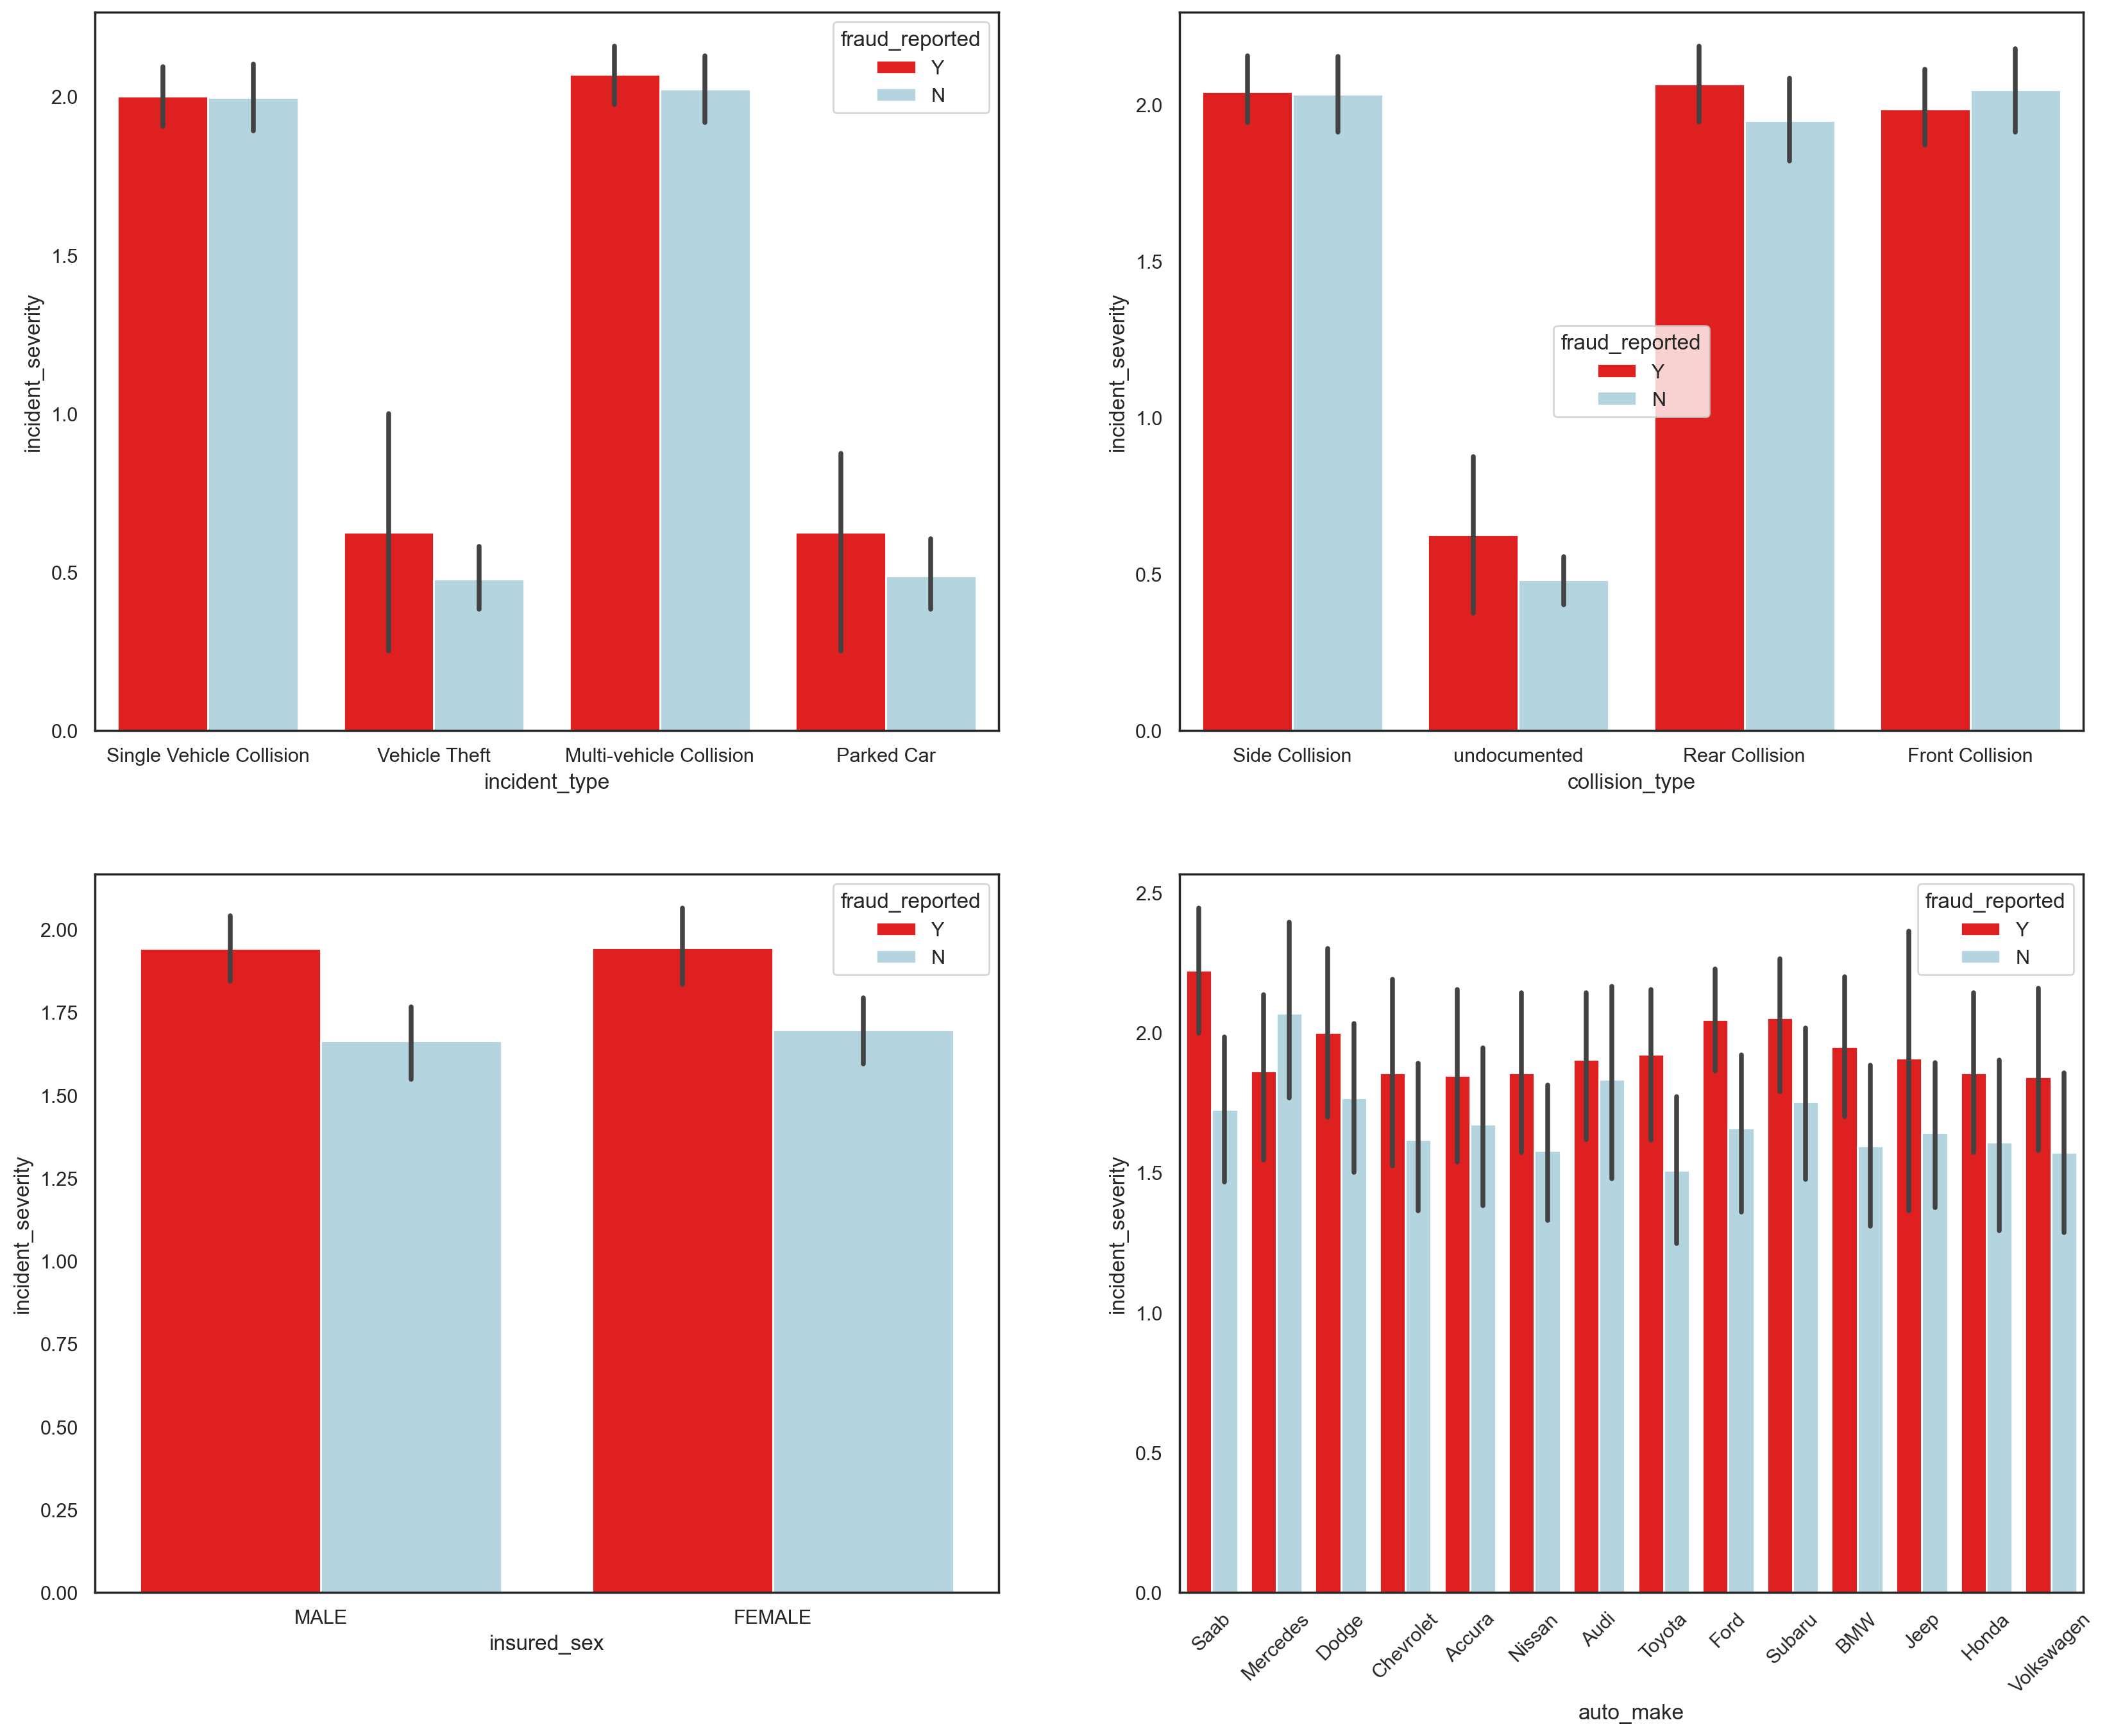

In [47]:
#severity and claims and fraud

fig, axes = plt.subplots(2,2, figsize=(20,16))

axes[0][0] = sns.barplot(x="incident_type", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[0][0]);

axes[0][1] = sns.barplot(x="collision_type", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[0][1]);

axes[1][0] = sns.barplot(x="insured_sex", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[1][0]);

axes[1][1] = sns.barplot(x="auto_make", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[1][1]);

plt.xticks(rotation=45);

# although theft and parked car are less severe, they have more fraud cases.. maybe acrimony and vengeful?
# rear collision and undocumented have more fraud.. again we see a trend that less severe accidetns more fraud (undoc)
# no obvious trend by sex 
#saab subaru ford seem to have more fraud cases

Although theft and parked car are less severe, they have more fraud cases. Perhaps due to acrimony and feelings of needing compensation for the perceived unfairness of an accident involving their vehicle while they were not involved or at fault. Rear collision and undocumented have more fraud. I see a trend that less severe accidents have more frauds. There is no obvious trend by sex. Saab, Subaru and Ford seem to have more fraud cases.

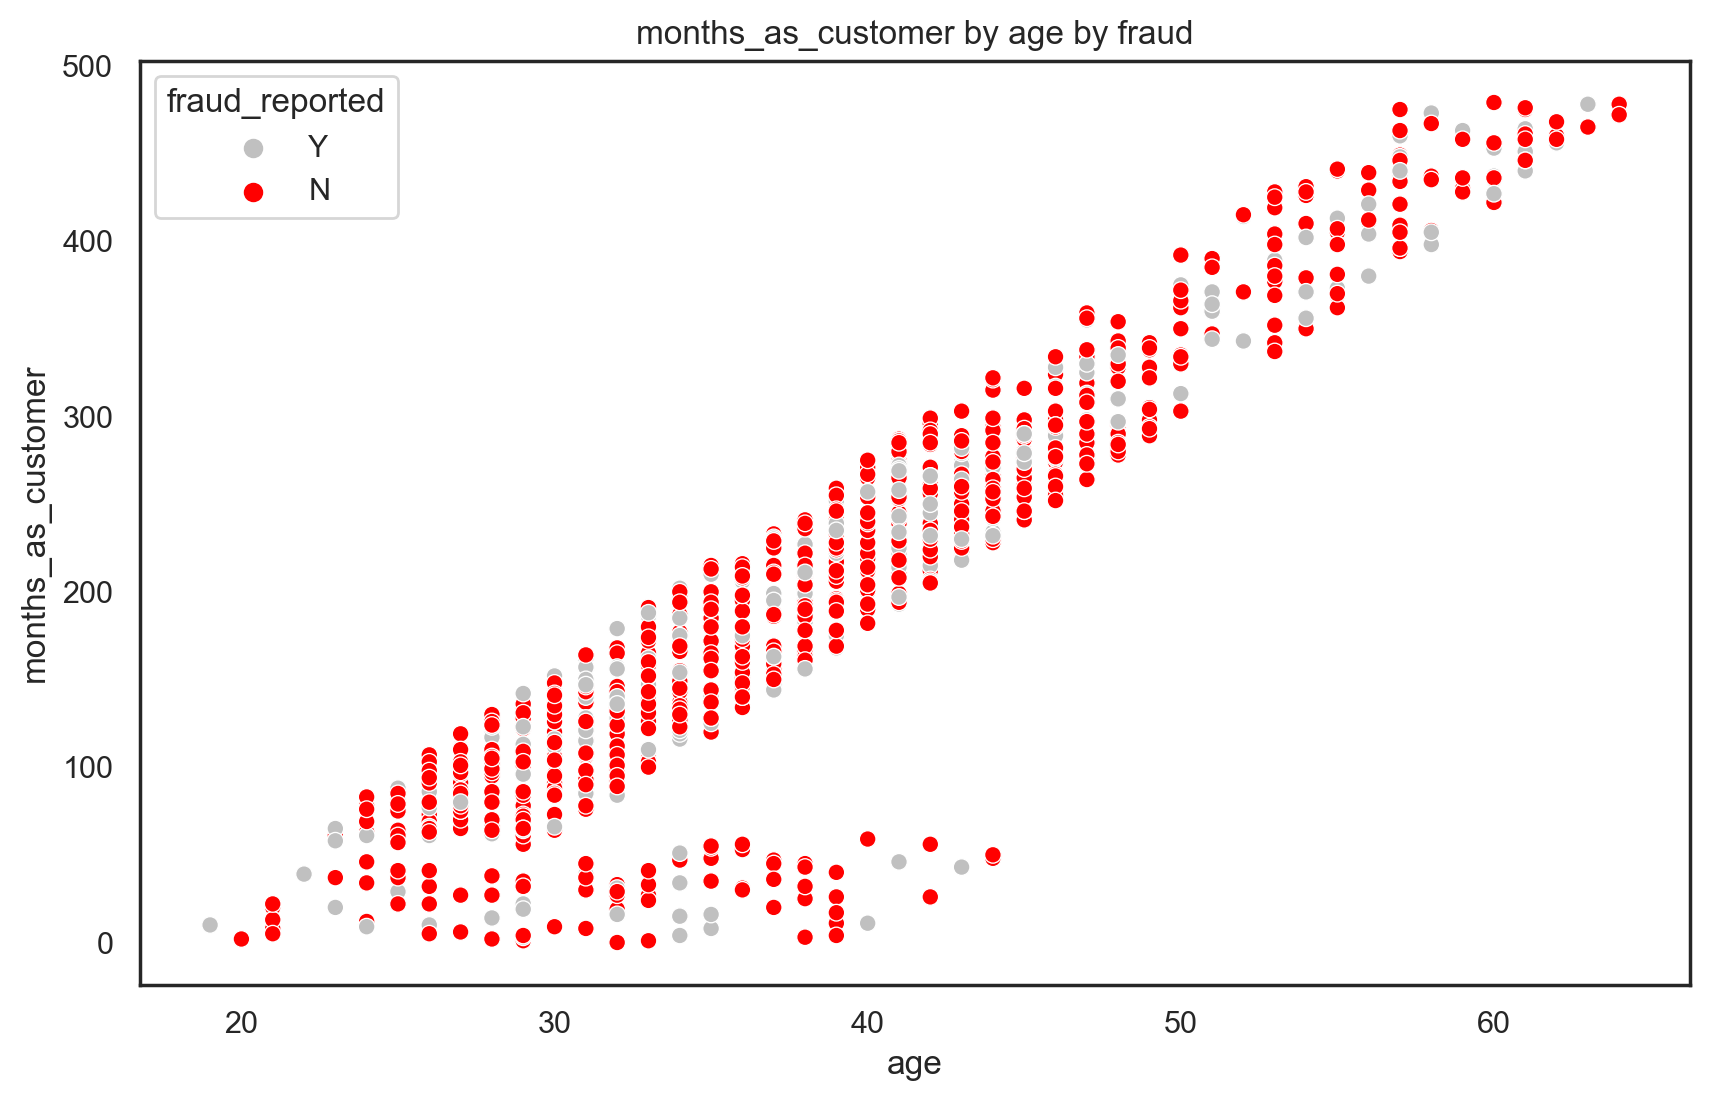

In [48]:
#try to see if there are any iteractions
#dont seem like it 
#a bunch of people across age are relatively new insurance  customers
#the rest are drivers that have insurance over the years.
#no clear pattern of interaction here

plt.figure(figsize=(10, 6))

sns.scatterplot(x="age", y="months_as_customer", 
            hue="fraud_reported", data=df,
            palette=['silver','red'])

plt.title("months_as_customer by age by fraud");

I tried to see if there are any interactions between months as customer and age on fraud but there don’t seem to be. From the graph we can see that a group of people across age are relatively new insurance customers while the rest are drivers that have insurance over the years.

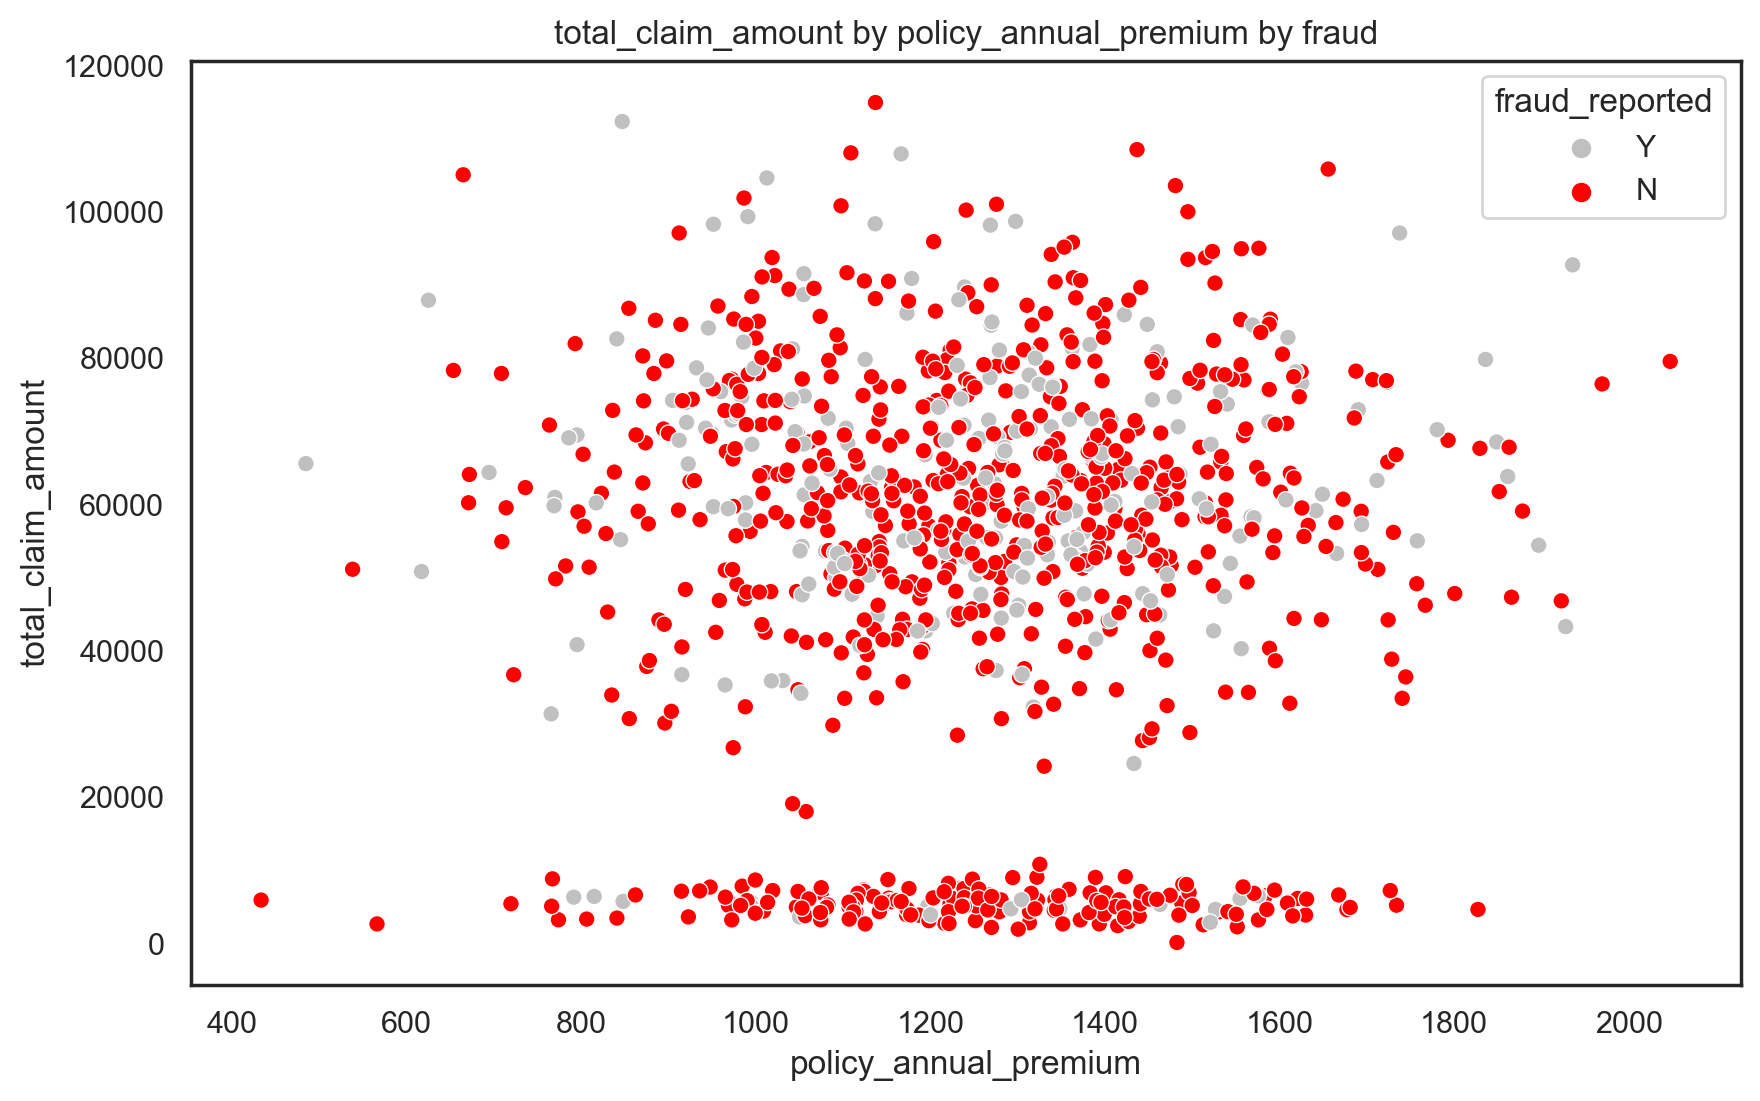

In [49]:
#no clear pattern but seems like claims close to 0 has most frauds

plt.figure(figsize=(10, 6))

sns.scatterplot(x="policy_annual_premium", y="total_claim_amount", 
            hue="fraud_reported", data=df,
            palette=['silver','red'])

plt.title("total_claim_amount by policy_annual_premium by fraud");

When plotted total claim amount and policy annual premium and fraud as a scatter plot, there were no clear patterns, but I noticed that there seem to be a high density of frauds at lower total claim amounts (lower than $20, 000).

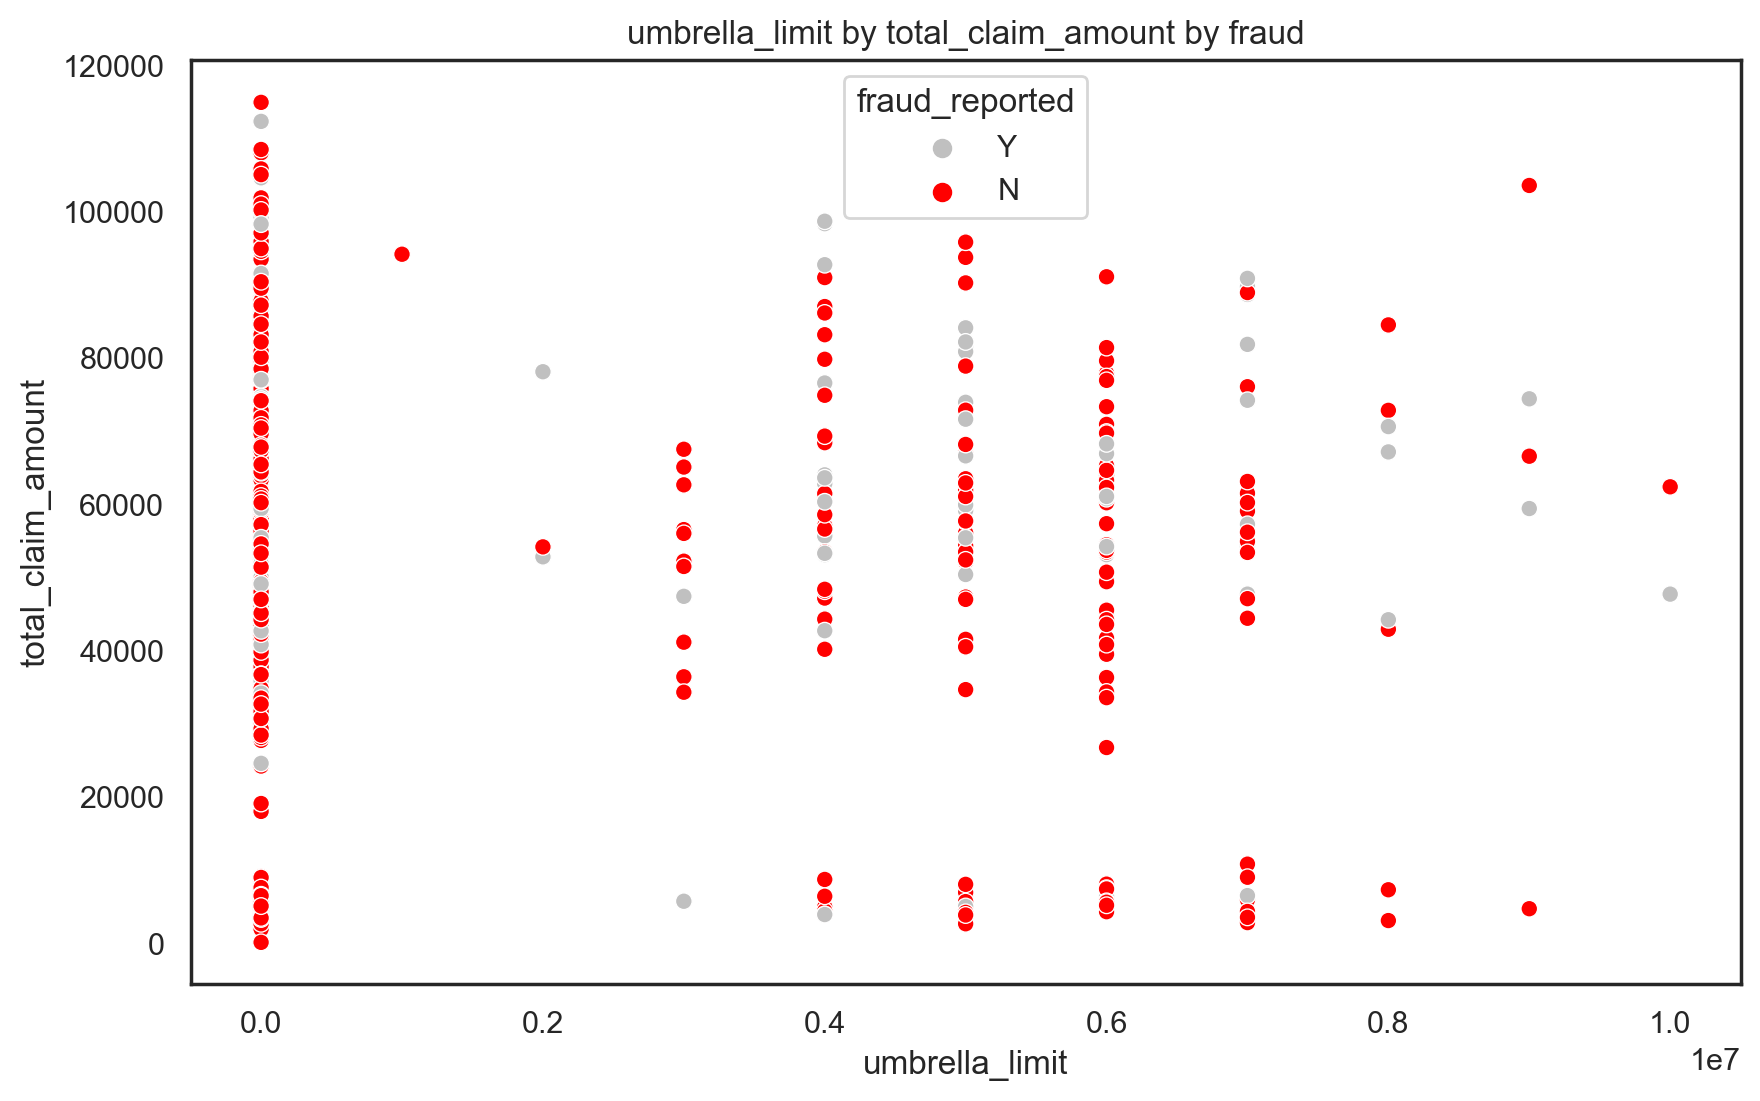

In [50]:
#seems like no umbrella limit more fraud?
#this people may have little to lose which is why they dont perchase umbrella 
#inversely, those who purchase have a lot of asset and a lot to lose so may be less prone to fraud?

plt.figure(figsize=(10, 6))

sns.scatterplot(x="umbrella_limit", y="total_claim_amount", 
            hue="fraud_reported", data=df,
            palette=['silver','red'])

plt.title("umbrella_limit by total_claim_amount by fraud");

When I plotted seems like no umbrella limit with total claim amount, I noticed that those without umbrella limit have more density of fraud? This people may have little to lose which is why they don't purchase umbrella. Inversely, those who purchase have a lot of asset and a lot to lose so may be less prone to fraud.

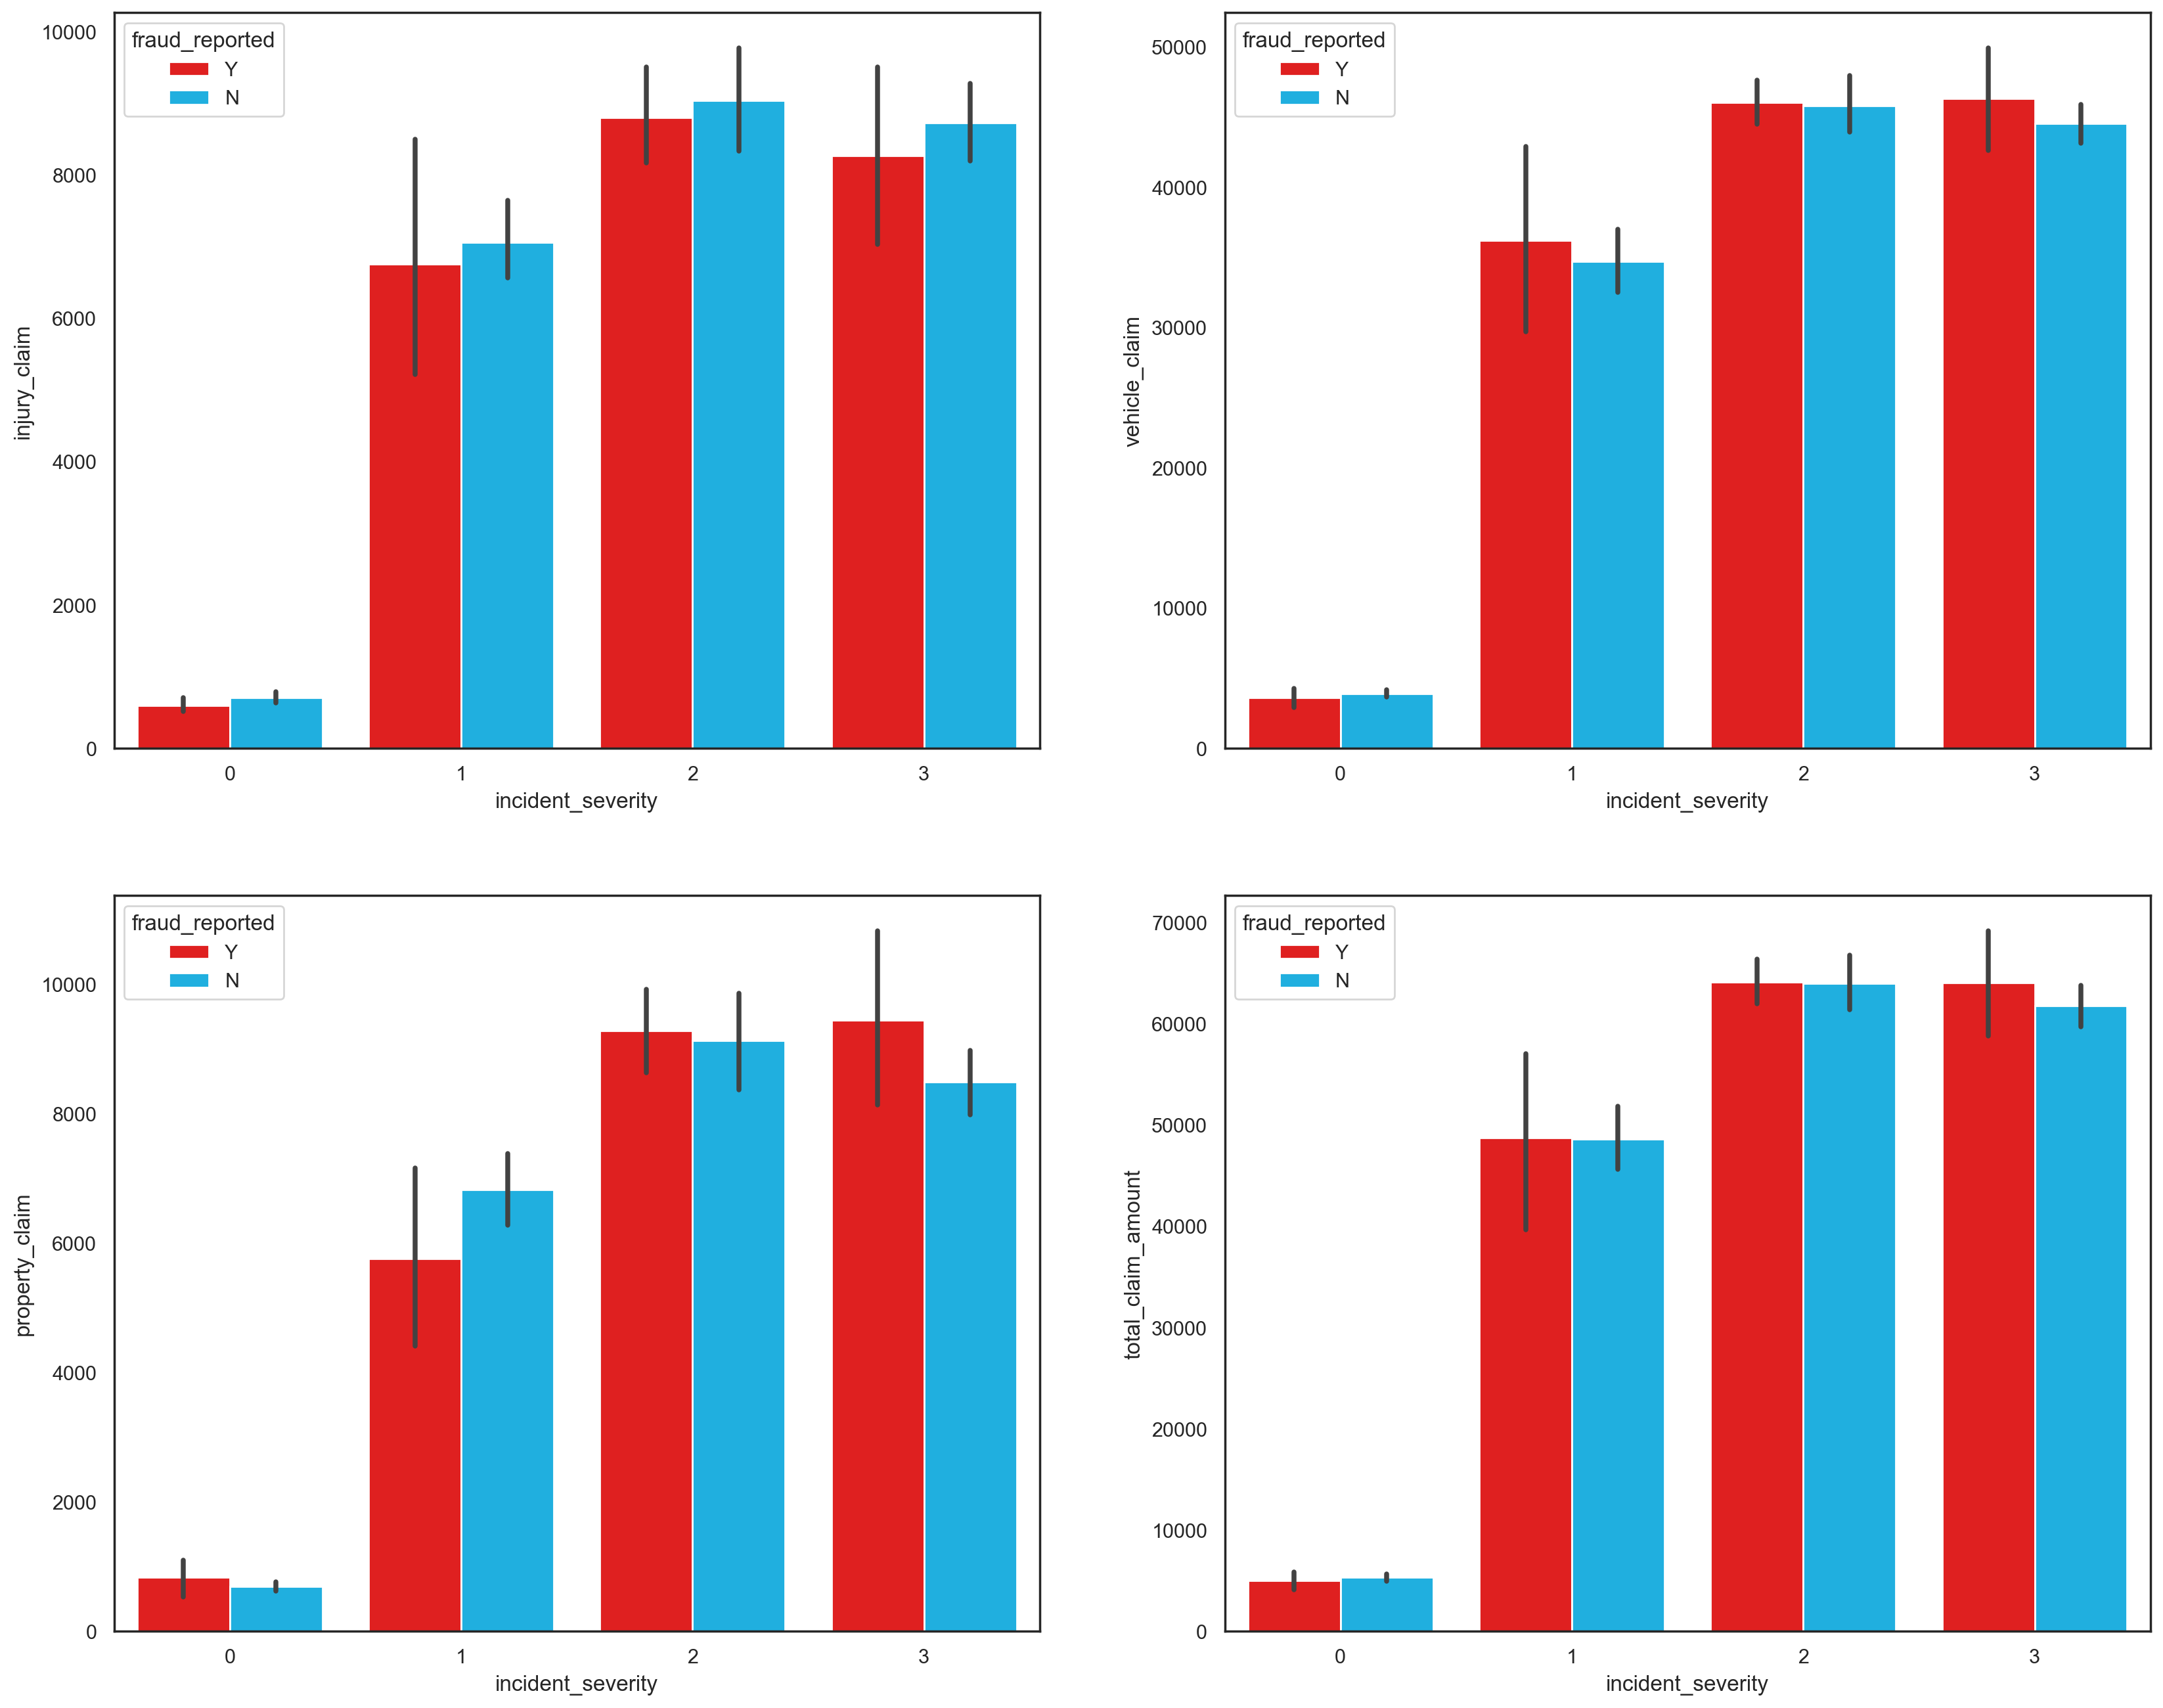

In [51]:
#severity and claims and fraud

fig, axes = plt.subplots(2,2, figsize=(20,16))

axes[0][0] = sns.barplot(x="incident_severity", y="injury_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[0][0]);

axes[0][1] = sns.barplot(x="incident_severity", y="vehicle_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[0][1]);

axes[1][0] = sns.barplot(x="incident_severity", y="property_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[1][0]);

axes[1][1] = sns.barplot(x="incident_severity", y="total_claim_amount",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[1][1]);

# vehicle claims and property claims have more frauds than injury claims
# does someone act more honestly after injury??

Next, I looked at different types of claims and incident severity and frauds. Vehicle claims and property claims have more frauds than injury claims. Perhaps damage of vehicles and property causes more perceived unfairness. Trend of fraud is less obvious in total claims against incident severity as after summing and aggregating across different types of claims, the variances cancel out each other.

### Losses by claims

Here, I define loss as simply money going out from the insurance company. Source of money coming in, on the other hand, are premiums. Although we know premiums and claims are not the only source of money going in or out of an insurance company, these 2 variables are used since they are the only information, we have from this data set. Typically, other source of money movement maybe investments made by the insurance company, for instance.

In [52]:
#create a variable that measure how much claims - how much premiums was paid by a client to indeicate a loss/profit

df['loss_by_claims'] = df['total_claim_amount'] - (df['policy_annual_premium'] * (2015 - df['policy_bind_year']))

C:\Users\parul\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


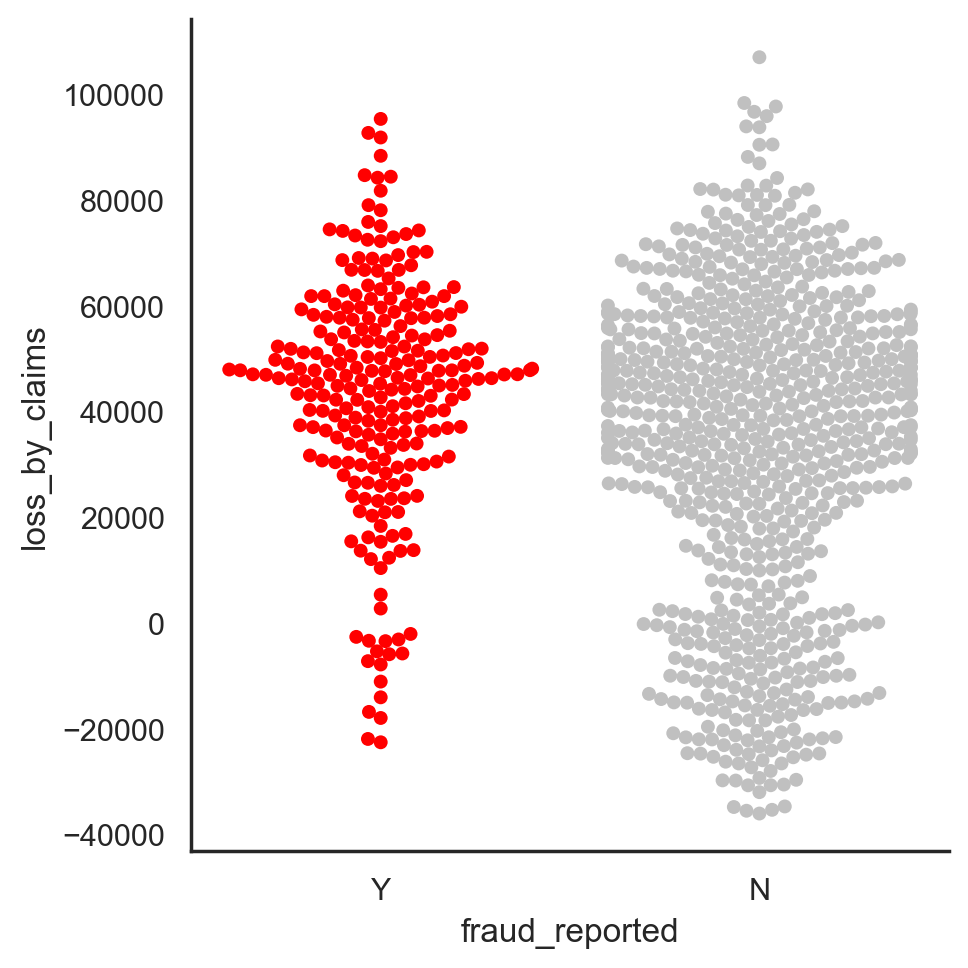

In [53]:
#note this is not how much the insurance company earns because there are a lot of other cars with no indicents 
sns.set_style("white") 

sns.catplot(data=df, y="loss_by_claims", x="fraud_reported", hue='fraud_reported', kind='swarm', palette=['red','silver']);

In [54]:
df[['capital-loss','capital-gains','loss_by_claims']]

capital-loss  capital-gains  loss_by_claims
0               0          53300        70203.09
1               0              0        -5704.98
2               0          35100        13452.90
3          -62400          48900        28006.50
4          -46000          66000         4916.09
..            ...            ...             ...
995             0              0        55740.80
996             0          70900       107043.21
997             0          35100        50898.12
998             0              0        41552.32
999             0              0        -9497.61

[1000 rows x 3 columns]

In [55]:
df.groupby('fraud_reported')['loss_by_claims'].sum()

fraud_reported
N    25126613.43
Y    10806751.60
Name: loss_by_claims, dtype: float64

In [56]:
df.groupby('fraud_reported')['loss_by_claims'].mean()

fraud_reported
N    33368.676534
Y    43752.030769
Name: loss_by_claims, dtype: float64

In [57]:
43752.030769-33368.676534

10383.354234999999

In [58]:
df.groupby('fraud_reported')['loss_by_claims'].std()

fraud_reported
N    29690.411374
Y    21812.675584
Name: loss_by_claims, dtype: float64

In [59]:
df[['fraud_reported', 'loss_by_claims']].isnull().sum()

fraud_reported    0
loss_by_claims    0
dtype: int64

In [60]:
df_ttest = df[['fraud_reported', 'loss_by_claims']]
df_ttest.head()

fraud_reported  loss_by_claims
0              Y        70203.09
1              Y        -5704.98
2              N        13452.90
3              Y        28006.50
4              N         4916.09

In [61]:
stats.ttest_ind(df_ttest.loc[df_ttest['fraud_reported']=='Y', 'loss_by_claims'], df_ttest.loc[df_ttest['fraud_reported']=='N', 'loss_by_claims'])

C:\Users\parul\AppData\Local\Temp\ipykernel_7192\2002800485.py:1: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.ttest_ind(df_ttest.loc[df_ttest['fraud_reported']=='Y', 'loss_by_claims'], df_ttest.loc[df_ttest['fraud_reported']=='N', 'loss_by_claims'])


Ttest_indResult(statistic=5.065425715463792, pvalue=4.852489023999467e-07)

I created a variable that measure how much claims minus how much premiums were paid by a client to indicate losses by claim. a positive will indicate a loss while a negative will be a profit. Every time a claim is more than the total premiums paid by a client; it is a loss for the insurance company.

In 2015, the insurance company lost \\$8,198,060.09 through fraudulent claims. The average lost for fraud is \\$43,752.03*(M =  43752.03, SD = 21812.68)*, which is \\$10,383.35 more (*p < .001*). than average lost through legit claims *(M =  33368.68, SD = 29690.41)*.

Note that this is not how much the insurance company earns because the data set only show incident claims. 

The national averages for having an at-fault accident in the past, in the United States, is approximately 12 percent of car owners. 


## Preprocessing
The DV, fraud_reported was coded 1 for fraud and 0 for non-fraud. 

Six interaction terms were created. Interaction between property claim amount and incident severity, vehicle claim amount and incident severity, injury claim amount and incident severity, total claim amount and incident severity, policy annual premium and total claim amount, umbrella limit and total claim amount.

Nominal variables were one-hot encoded, and the data set was split into 75% train and 25% test set, stratified on fraud reported. 

In [62]:
#DV numerical code
df['fraud_reported'] = df['fraud_reported'].map({"Y":1, "N":0})
df['fraud_reported']

0      1
1      1
2      0
3      1
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: fraud_reported, Length: 1000, dtype: int64

In [63]:
df['insured_sex'] = df['insured_sex'].map({"FEMALE":0,"MALE":1})

In [64]:
df['capital-loss']=df['capital-loss']*(-1)

In [65]:
df['capital-loss'].max()

111100

In [66]:
#check that they are coded

df['pclaim_severity_int'] = df['property_claim']*df['incident_severity']
df['vclaim_severity_int'] = df['vehicle_claim']*df['incident_severity']
df['iclaim_severity_int'] = df['injury_claim']*df['incident_severity']
df['tclaim_severity_int'] = df['total_claim_amount']*df['incident_severity']

df['prem_claim_int'] = df['policy_annual_premium']*df['total_claim_amount']
df['umlimit_tclaim_int'] = df['umbrella_limit']*df['total_claim_amount']


#### Dummy coding

In [67]:
rem = ['insured_sex','incident_month']
dum_list = [e for e in nom_var if e not in rem]
len(dum_list)

14

In [68]:
dum = pd.get_dummies(df[dum_list], drop_first=True)
dum.head()

insured_hobbies_basketball  insured_hobbies_board-games  \
0                           0                            0   
1                           0                            0   
2                           0                            1   
3                           0                            1   
4                           0                            1   

   insured_hobbies_bungie-jumping  insured_hobbies_camping  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               0                        0   
4                               0                        0   

   insured_hobbies_chess  insured_hobbies_cross-fit  insured_hobbies_dancing  \
0                      0                          0                        0   
1                      0                          0                        0   
2                      0                          0                        0   
3                      0                          0                        0   
4                      0                          0                        0   

   insured_hobbies_exercise  insured_hobbies_golf  insured_hobbies_hiking  \
0                         0                     0                       0   
1                         0                     0                       0   
2                         0                     0                       0   
3                         0                     0                       0   
4                         0                     0                       0   

   insured_hobbies_kayaking  insured_hobbies_movies  \
0                         0                       0   
1                         0                       0   
2                         0                       0   
3                         0                       0   
4                         0                       0   

   insured_hobbies_paintball  insured_hobbies_polo  insured_hobbies_reading  \
0                          0                     0                        0   
1                          0                     0                        1   
2                          0                     0                        0   
3                          0                     0                        0   
4                          0                     0                        0   

   insured_hobbies_skydiving  insured_hobbies_sleeping  \
0                          0                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   insured_hobbies_video-games  insured_hobbies_yachting  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   incident_type_Parked Car  incident_type_Single Vehicle Collision  \
0                         0                                       1   
1                         0                                       0   
2                         0                                       0   
3                         0                                       1   
4                         0                                       0   

   incident_type_Vehicle Theft  collision_type_Rear Collision  \
0                            0                              0   
1                            1                              0   
2                            0                              1   
3                            0                              0   
4                            1               

In [69]:
dum.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df_dummied = pd.concat([dum, df], axis=1)

In [70]:
df_dummied.drop(nom_var, axis=1, inplace=True)

In [71]:
df_dummied.head()

insured_hobbies_basketball  insured_hobbies_board-games  \
0                           0                            0   
1                           0                            0   
2                           0                            1   
3                           0                            1   
4                           0                            1   

   insured_hobbies_bungie-jumping  insured_hobbies_camping  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               0                        0   
4                               0                        0   

   insured_hobbies_chess  insured_hobbies_cross-fit  insured_hobbies_dancing  \
0                      0                          0                        0   
1                      0                          0                        0   
2                      0                          0                        0   
3                      0                          0                        0   
4                      0                          0                        0   

   insured_hobbies_exercise  insured_hobbies_golf  insured_hobbies_hiking  \
0                         0                     0                       0   
1                         0                     0                       0   
2                         0                     0                       0   
3                         0                     0                       0   
4                         0                     0                       0   

   insured_hobbies_kayaking  insured_hobbies_movies  \
0                         0                       0   
1                         0                       0   
2                         0                       0   
3                         0                       0   
4                         0                       0   

   insured_hobbies_paintball  insured_hobbies_polo  insured_hobbies_reading  \
0                          0                     0                        0   
1                          0                     0                        1   
2                          0                     0                        0   
3                          0                     0                        0   
4                          0                     0                        0   

   insured_hobbies_skydiving  insured_hobbies_sleeping  \
0                          0                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   insured_hobbies_video-games  insured_hobbies_yachting  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   incident_type_Parked Car  incident_type_Single Vehicle Collision  \
0                         0                                       1   
1                         0                                       0   
2                         0                                       0   
3                         0                                       1   
4                         0                                       0   

   incident_type_Vehicle Theft  collision_type_Rear Collision  \
0                            0                              0   
1                            1                              0   
2                            0                              1   
3                            0                              0   
4                            1               

In [72]:
df_dummied.isnull().sum().any()

False

In [73]:
df_dummied['umbrella_limit'].sort_values(ascending=True)

0             0
622           0
623           0
624           0
625           0
         ...   
700     9000000
88      9000000
975     9000000
115    10000000
430    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

In [74]:
dd = df_dummied.describe()
dd.loc['min']

insured_hobbies_basketball                     0.00
insured_hobbies_board-games                    0.00
insured_hobbies_bungie-jumping                 0.00
insured_hobbies_camping                        0.00
insured_hobbies_chess                          0.00
insured_hobbies_cross-fit                      0.00
insured_hobbies_dancing                        0.00
insured_hobbies_exercise                       0.00
insured_hobbies_golf                           0.00
insured_hobbies_hiking                         0.00
insured_hobbies_kayaking                       0.00
insured_hobbies_movies                         0.00
insured_hobbies_paintball                      0.00
insured_hobbies_polo                           0.00
insured_hobbies_reading                        0.00
insured_hobbies_skydiving                      0.00
insured_hobbies_sleeping                       0.00
insured_hobbies_video-games                    0.00
insured_hobbies_yachting                       0.00
incident_typ

#### Train Test Split

In [75]:
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

## Baseline accuracy score

As our dataset is imbalance, accuracy is not a good measure of success. A high accuracy can be achieved by a poor model that only selects the majority class, hence, not detecting and measuring the accuracy of classifying the class of interest. In fact, predicting only the majority class will give an accuracy of 75%, specificity of 100% but a sensitivity of 0%. 

If we make a naive prediction that all claims are frauds, so that no frauds escape our watch, we will have a score as shown below:

- Sensitivity: 1.0
- Specificity: 0.0
- Precision: 0.248
- F1 score: 0.397
- ROC AUC Score: 0.50

As identifying as many frauds as possible is the goal, the F1 score of 0.397 was used as a baseline. However, investigations into frauds can be time consuming and expensive and may even affect customer experience. Thus, ROC AUC score will also be used to measure how well we distinguish between Fraud and legit claims. The baseline ROC AUC score is 0.50. I am to have a ROC AUC of at least 0.70. 

In [77]:
#baseline accuracy = 75.2%

y_test.value_counts(normalize=True)

0    0.752
1    0.248
Name: fraud_reported, dtype: float64

In [78]:
y_test.value_counts()

0    188
1     62
Name: fraud_reported, dtype: int64

In [79]:
base_recall = 62/(62)
base_speci = 0/(188)
base_preci = 62/(250)
base_f1 = 2*base_recall*base_preci/(base_recall+base_preci)


df_prob = pd.DataFrame()
df_prob['y']=y_test
df_prob['pred']=1
auc_score = roc_auc_score(df_prob['y'], df_prob['pred'])


print("If we make a naive prediction that all claims are frauds, so that no frauds escape our watch, we will have an:")
print("")
print("Sensitivity:", base_recall)
print('Specificity:', base_speci)
print('Precision:', base_preci)
print('F1 score:', base_f1)
print('ROC AUC Score:', auc_score)


If we make a naive prediction that all claims are frauds, so that no frauds escape our watch, we will have an:

Sensitivity: 1.0
Specificity: 0.0
Precision: 0.248
F1 score: 0.3974358974358974
ROC AUC Score: 0.5


As our dataset is imbalance, accuracy is not a good measure of success. A high accuracy can be achieved by a poor model that only selects the majority class, hence, not detecting and measuring the accuracy of classifying the class of interest. In fact, predicting only the majority class will give an accuracy of 75%, specificity of 100% but a sensitivity of 0%. 

If we make a naive prediction that all claims are frauds, so that no frauds escape our watch, we will have a score as shown below:

- Sensitivity: 1.0
- Specificity: 0.0
- Precision: 0.248
- F1 score: 0.397
- ROC AUC Score: 0.50

As identifying as many frauds as possible is the goal, the F1 score of 0.397 was used as a baseline. However, investigations into frauds can be time consuming and expensive and may even affect customer experience. Thus, ROC AUC score will also be used to measure how well we distinguish between Fraud and legit claims. The baseline ROC AUC score is 0.50. I am to have a ROC AUC of at least 0.70.

## Modeling 

Five different classifiers were used in this project: 
- logistic regression
- K-nearest neighbours
- Random forest
- XGBoost 
- AdaBoost 

Hyperparameter tuning and selection was done for all the models using RandomizedSearch. Due to the number of parameters and models that were ran, RandomizedSearch is a faster more efficient choice as compared to gridsearch.

<br>
<details><summary>More about hyperparameters </summary>

Model hyperparameters are set by the data scientist ahead of training and control implementation aspects of the model. Hyperparameters can be thought of as model settings. These settings need to be tuned because the ideal settings for one data set will not be the same across all data sets. When tuning the hyperparameters of an estimator, Grid Search and Random Search are both popular methods.
    
</details>



After a 10-fold RandomizedSearchCV, the model with its selected hyperparameters were fitted on the training set. 

Mean accuracy scores for the best estimators of the RandomizedSearchCV, accuracy scores on the training set and accuracy scores on the test set was computed. Then, the sensitivity, specificity, precision, F1 score and ROC AUC scores were computed. 


<br>
<details><summary>More about RandomizedSearchCV </summary>

There are 2 types of search for hyperparameter tuning. Grid search and randomized search.

Grid Search can be thought of as an exhaustive search for selecting a model. In Grid Search, the data scientist sets up a grid of hyperparameter values and for each combination, trains a model and scores on the testing data. In this approach, every combination of hyperparameter values is tried which can be very inefficient. For example, searching 20 different parameter values for each of 4 parameters will require 160,000 trials of cross-validation. This equates to 1,600,000 model fits and 1,600,000 predictions if 10-fold cross validation is used. While Scikit Learn offers the GridSearchCV function to simplify the process, it would be an extremely costly execution both in computing power and time.
By contrast, Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score. This allows you to explicitly control the number of parameter combinations that are attempted. The number of search iterations is set based on time or resources. Scikit Learn offers the RandomizedSearchCV function for this process.

While it’s possible that RandomizedSearchCV will not find as accurate of a result as GridSearchCV, it surprisingly picks the best result often and in a fraction of the time it takes GridSearchCV would have taken. Given the same resources, Randomized Search can even outperform Grid Search. This can be visualized in the graphic below when continuous parameters are used.

Checkout the link for an experiment on RandomizedSearch Vs GridSearch (spoiler alert: RandomizedSearch won on 10, 50, 100, 500 trails by time and by cost function value BUT this is not always the case):

https://towardsdatascience.com/random-search-vs-grid-search-for-hyperparameter-optimization-345e1422899d

</details>


This section discusses how different blocks of models were ran. Evaluation of the models will be the evaluation section.

### 1. Model with class weighting and hyperparameter tuning

The five classifiers as per stated above were ran with hyperparameter tuning. Models that had option for class weighting had class weighting as one of the hyperparameters in this block of models. That is, the RandomizedSearch will test a weighted and non-weighted model to see which performed better. 

A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset. For example, the class distribution of the test dataset is a 1:100 ratio for the minority class to the majority class. The inversion of this ratio could be used with 1 for the majority class and 100 for the minority class; for example:{0:1.0, 1:100.0}. In our case, class weights were {0:0.246667, 1:0.75333}. In XGBoost, class weights are defined differently. XGBoost uses scale positive weight which is the total negative examples divided by the total positive examples. For an imbalanced binary classification dataset, the negative class refers to the majority class (class 0) and the positive class refers to the minority class (class 1). The scaled positive weight in this analysis is 3.054.

In [80]:
#function to use for scoring 

def scores(t, name):
    print (name, 'classification metric')
    print("CV scores:", round(t.best_score_,3))
    print("train score:", round(t.score(x_train, y_train),3))
    print("test score:", round(t.score(x_test, y_test),3))

    #Evaluation metrics
    predictions = t.predict(x_test)

    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

    sensi = TP/(TP + FN)
    speci= TN/(TN + FP)
    preci = TP/(TP + FP)
    f1= 2*(preci*sensi)/(preci+sensi)

    print(f'Sensitivity: {round(sensi,3)}')
    print(f'Specificity: {round(speci,3)}')
    print(f'Precision: {round(preci,3)}')
    print(f'F1: {round(f1,3)}')

    pred_proba = [i[1] for i in t.predict_proba(x_test)]
    auc_score = roc_auc_score(y_test, pred_proba)
    print('ROC AUC Score:', round(auc_score,3))

### Logistic regression

In [81]:
y_train.value_counts(normalize=True)

0    0.753333
1    0.246667
Name: fraud_reported, dtype: float64

A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset.
For example, the class distribution of the test dataset is a 1:100 ratio for the minority class to the majority class. The inversion of this ratio could be used with 1 for the majority class and 100 for the minority class; for example:{0:1.0, 1:100.0}

In [82]:
#ransearch log reg

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            'class_weight':[{0:0.246667, 1:0.75333},None]}

    
rs_lr = RandomizedSearchCV(lr, lr_values, cv=10, n_jobs = -1, random_state=42)
rs_lr.fit(x_train, y_train, )
print(rs_lr.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 910.2981779915227}


C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### KNN

In [83]:
# knn = KNeighborsClassifier()
# ss = StandardScaler()

knn_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))])

knn_values = {'knn__n_neighbors':[3,5,7,9,11],
              'knn__weights':['uniform', 'distance'],
              'knn__metric':['minkowski','euclidean','manhattan'],
              'knn__algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size':[1,2,3,4,5,6,7,8,9,10]
             }

    
rs_knn = RandomizedSearchCV(knn_pipe, knn_values, cv=10, n_jobs = -1, random_state=42)
rs_knn.fit(x_train, y_train)
print(rs_knn.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': 7, 'knn__metric': 'euclidean', 'knn__leaf_size': 7, 'knn__algorithm': 'brute'}


### Random forest

In [84]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'class_weight':[{0:0.246667, 1:0.75333},None]
              }


    
rs_rf = RandomizedSearchCV(rf, rf_values, cv=10, n_jobs = -1, random_state=42)
rs_rf.fit(x_train, y_train)
print(rs_rf.best_params_)

{'n_estimators': 350, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'class_weight': {0: 0.246667, 1: 0.75333}}


### XGBoost

scale_pos_weight = total_negative_examples / total_positive_examples

For an imbalanced binary classification dataset, the negative class refers to the majority class (class 0) and the positive class refers to the minority class (class 1).

In [85]:
y_train.value_counts()

0    565
1    185
Name: fraud_reported, dtype: int64

In [86]:
#scaled positive weight
565/185

3.054054054054054

In [87]:
xg = XGBClassifier(booster='gbtree', n_jobs=-1)

xg_values = {'max_depth': [3, 4, 5, 6],
             'eta': [0.05, 0.1, 0.15, 0.3],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0, 1, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'scale_pos_weight':[1, 3.054054054054054],
              }


    
rs_xg = RandomizedSearchCV(xg, xg_values, cv=10, n_jobs = -1, random_state=42)
rs_xg.fit(x_train, y_train)
print(rs_xg.best_params_)

{'scale_pos_weight': 3.054054054054054, 'reg_lambda': 0.1, 'reg_alpha': 0.05, 'n_estimators': 550, 'max_depth': 6, 'gamma': 3, 'eta': 0.05}


### AdaBoost

In [88]:
ab = AdaBoostClassifier()

ab_values = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,550,600],
            'learning_rate':[0.05,0.1,0.3,0.5]
              }


    
rs_ab = RandomizedSearchCV(ab, ab_values, cv=10, n_jobs = -1, random_state=42)
rs_ab.fit(x_train, y_train)
print(rs_rf.best_params_)

{'n_estimators': 350, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'class_weight': {0: 0.246667, 1: 0.75333}}


### Evaluate

In [89]:
classifiers={'logreg':rs_lr, 'knn':rs_knn, 'Ranfor':rs_rf, 
             'XGB':rs_xg, 'AdaBoost':rs_ab}

for key, value in classifiers.items(): 
    print(scores(value,key))
    print("__________________________")
    print(" ")
    


logreg classification metric
CV scores: 0.769
train score: 0.841
test score: 0.7
Sensitivity: 0.339
Specificity: 0.819
Precision: 0.382
F1: 0.359
ROC AUC Score: 0.643
None
__________________________
 
knn classification metric
CV scores: 0.772
train score: 1.0
test score: 0.74
Sensitivity: 0.161
Specificity: 0.931
Precision: 0.435
F1: 0.235
ROC AUC Score: 0.666
None
__________________________
 
Ranfor classification metric
CV scores: 0.795
train score: 0.983
test score: 0.8
Sensitivity: 0.548
Specificity: 0.883
Precision: 0.607
F1: 0.576
ROC AUC Score: 0.824
None
__________________________
 
XGB classification metric
CV scores: 0.841
train score: 0.967
test score: 0.844
Sensitivity: 0.806
Specificity: 0.856
Precision: 0.649
F1: 0.719
ROC AUC Score: 0.837
None
__________________________
 
AdaBoost classification metric
CV scores: 0.811
train score: 0.896
test score: 0.776
Sensitivity: 0.419
Specificity: 0.894
Precision: 0.565
F1: 0.481
ROC AUC Score: 0.829
None
_________________________

### 2. Modeling with Oversampling using SMOTE

The five classifiers were running on a SMOTE data set, with hyperparameter tuning. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbours for that example are found (typically k=5). A randomly selected neighbour is chosen, and a synthetic example is created at a randomly selected point between the two examples in feature space. SMOTE over sampling was done only to the training set. After SMOTE, both fraud and non-fraud have 565 samples in the training set. As SMOTE is designed to handle imbalanced classes, no weighting of classes was done. 

In [90]:
#have to redefine since the smote has already altered the data

x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

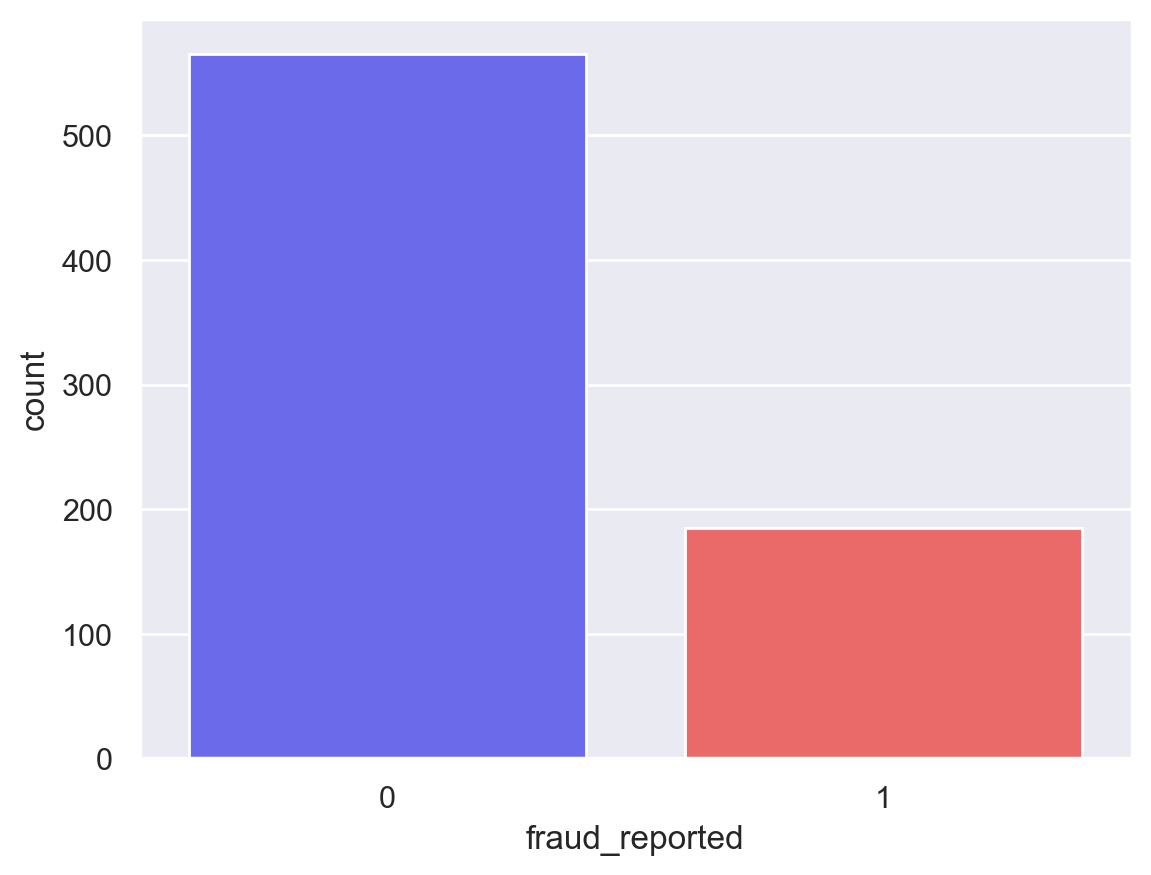

In [91]:
#dist of dv
sns.set()
sns.countplot(x=y_train, palette='seismic');

0    565
1    565
Name: fraud_reported, dtype: int64


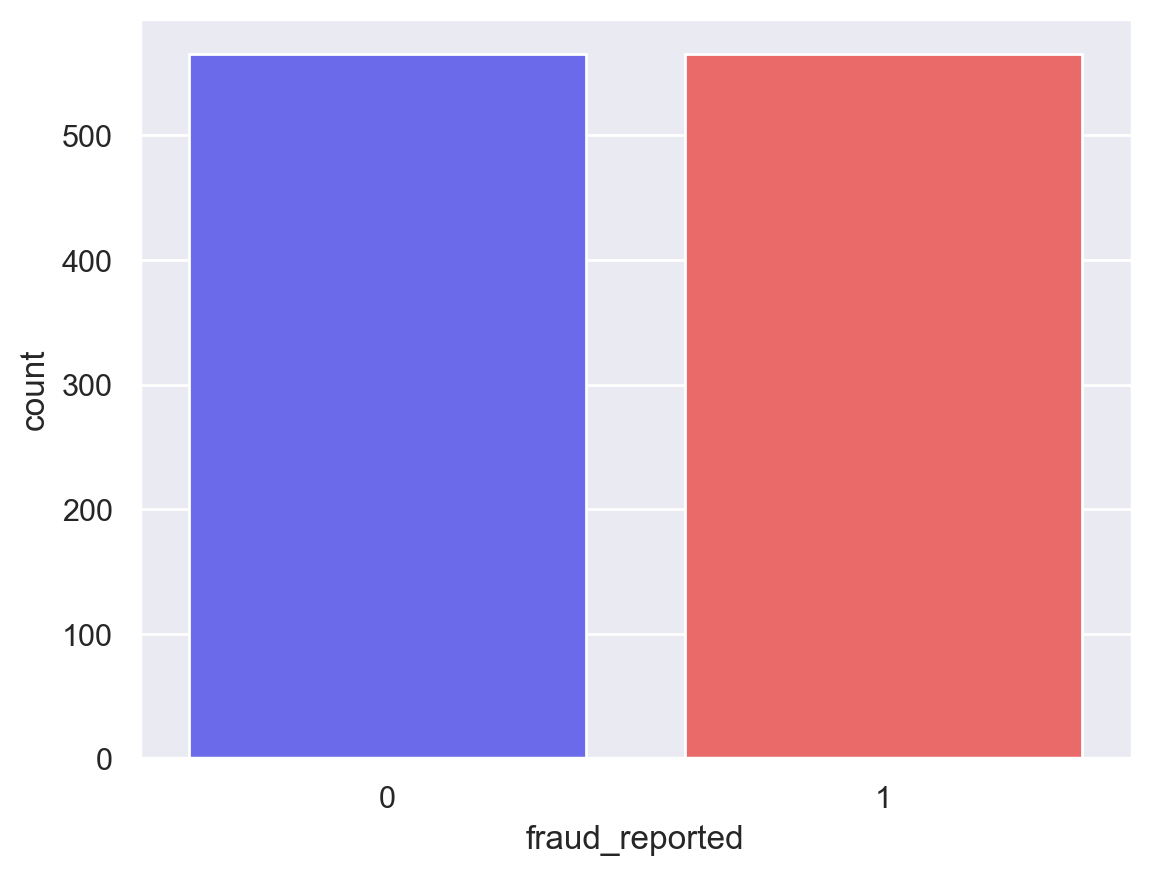

In [92]:
#SMOTE data for train set

oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)
print(y_train.value_counts())

sns.countplot(x=y_train, palette='seismic');

### Logistic regression

In [93]:
#ransearch log reg

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            }

    
rs_lr2 = RandomizedSearchCV(lr, lr_values, cv=10, n_jobs = -1, random_state=42)
rs_lr2.fit(x_train, y_train)
print(rs_lr2.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'C': 138.9495494373139}


C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### KNN

In [94]:
# knn = KNeighborsClassifier()
# ss = StandardScaler()

knn_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))])

knn_values = {'knn__n_neighbors':[3,5,7,9,11],
              'knn__weights':['uniform', 'distance'],
              'knn__metric':['minkowski','euclidean','manhattan'],
              'knn__algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size':[1,2,3,4,5,6,7,8,9,10]
             }

    
rs_knn2 = RandomizedSearchCV(knn_pipe, knn_values, cv=10, n_jobs = -1, random_state=42)
rs_knn2.fit(x_train, y_train)
print(rs_knn2.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': 3, 'knn__metric': 'minkowski', 'knn__leaf_size': 5, 'knn__algorithm': 'auto'}


### Random forest

In [95]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             
              }


    
rs_rf2 = RandomizedSearchCV(rf, rf_values, cv=10, n_jobs = -1, random_state=42)
rs_rf2.fit(x_train, y_train)
print(rs_rf2.best_params_)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 90}


### XGBoost

In [96]:
xg = XGBClassifier(booster='gbtree', n_jobs=-1)

xg_values = {'max_depth': [3, 4, 5, 6],
             'eta': [0.05, 0.1, 0.15, 0.3],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0, 1, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             
              }


    
rs_xg2 = RandomizedSearchCV(xg, xg_values, cv=10, n_jobs = -1, random_state=42)
rs_xg2.fit(x_train, y_train)
print(rs_xg2.best_params_)

{'reg_lambda': 0.05, 'reg_alpha': 0.5, 'n_estimators': 350, 'max_depth': 5, 'gamma': 0, 'eta': 0.05}


### AdaBoost

In [97]:
ab = AdaBoostClassifier()

ab_values = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,550,600],
            'learning_rate':[0.05,0.1,0.3,0.5]
              }


    
rs_ab2 = RandomizedSearchCV(ab, ab_values, cv=10, n_jobs = -1, random_state=42)
rs_ab2.fit(x_train, y_train)
print(rs_ab2.best_params_)

{'n_estimators': 200, 'learning_rate': 0.3}


In [98]:
classifiers2={'logreg2':rs_lr2, 'knn2':rs_knn2, 'Ranfor2':rs_rf2, 
             'XGB2':rs_xg2, 'AdaBoost2':rs_ab2} 

for key, value in classifiers2.items(): 
    print(scores(value,key))
    print("________________")
    print(" ")

logreg2 classification metric
CV scores: 0.825
train score: 0.883
test score: 0.7
Sensitivity: 0.387
Specificity: 0.803
Precision: 0.393
F1: 0.39
ROC AUC Score: 0.631
None
________________
 
knn2 classification metric
CV scores: 0.532
train score: 1.0
test score: 0.316
Sensitivity: 0.952
Specificity: 0.106
Precision: 0.26
F1: 0.408
ROC AUC Score: 0.562
None
________________
 
Ranfor2 classification metric
CV scores: 0.865
train score: 0.997
test score: 0.8
Sensitivity: 0.516
Specificity: 0.894
Precision: 0.615
F1: 0.561
ROC AUC Score: 0.807
None
________________
 
XGB2 classification metric
CV scores: 0.871
train score: 1.0
test score: 0.82
Sensitivity: 0.581
Specificity: 0.899
Precision: 0.655
F1: 0.615
ROC AUC Score: 0.824
None
________________
 
AdaBoost2 classification metric
CV scores: 0.867
train score: 0.93
test score: 0.804
Sensitivity: 0.581
Specificity: 0.878
Precision: 0.61
F1: 0.595
ROC AUC Score: 0.803
None
________________
 


### 3. Modeling with Oversampling using ADASYN

ADASYN does is same as SMOTE just with a minor improvement. After creating those sample, it adds a random small value to the points thus making it more realistic. In other words, instead of all the sample being linearly correlated to the parent they have a little more variance and noise in them and are a bit scattered. ADASYN over sampling was done only to the training set. After ADASYN, both fraud and non-fraud have 565 samples in the training set. The five classifiers were running on the ADASYN data set, with hyperparameter tuning.

In [99]:
#have to redefine since the smote has already altered the data

x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

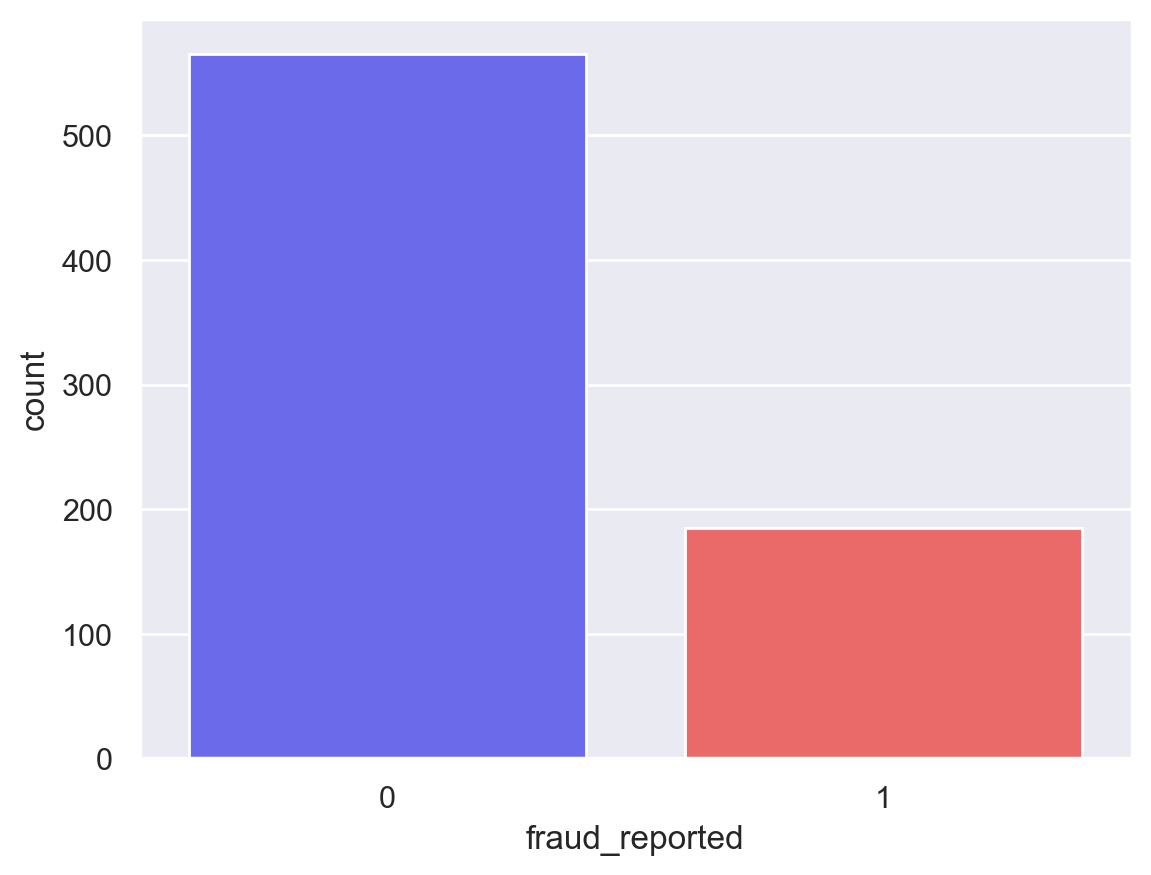

In [100]:
#dist of dv
sns.countplot(x=y_train, palette='seismic');

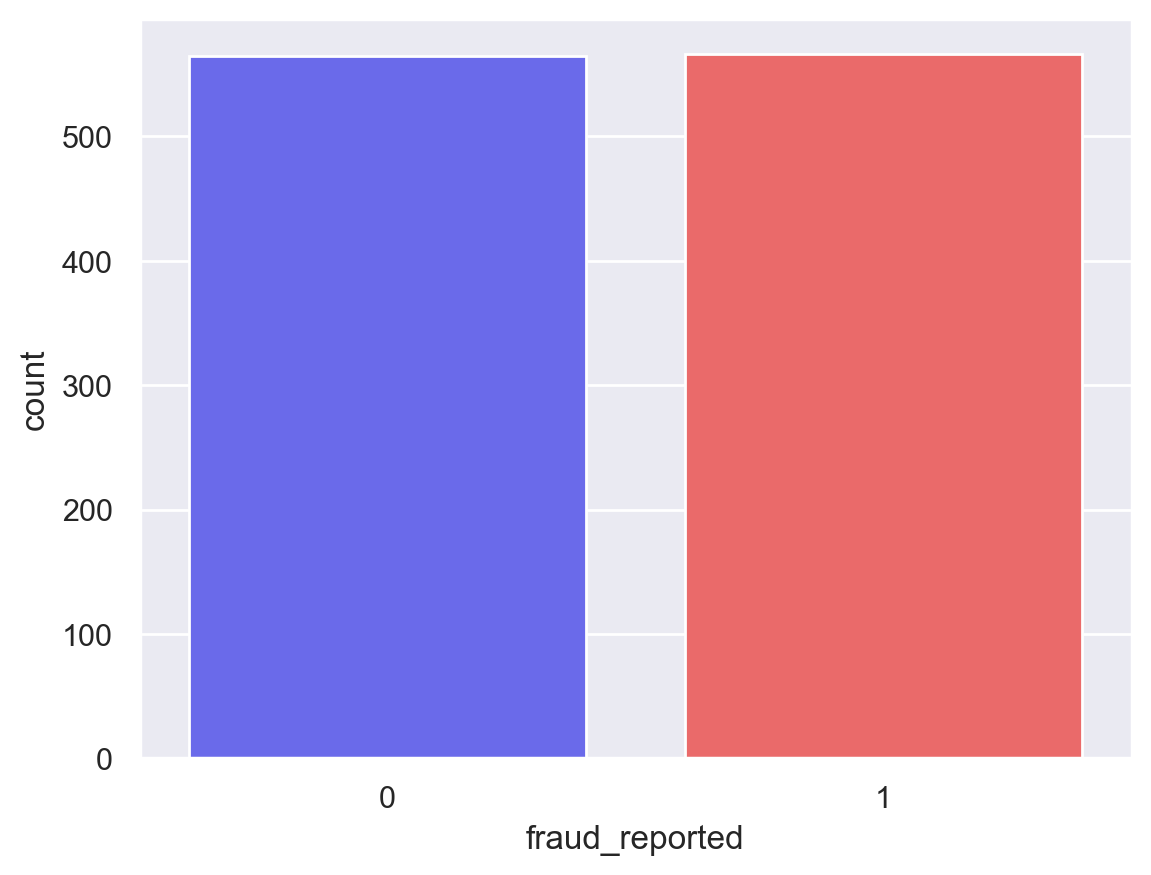

In [101]:
#adasyn data for train set

oversample = ADASYN()
x_train, y_train = oversample.fit_resample(x_train, y_train)
sns.countplot(x=y_train, palette='seismic');

### Logistic regression

In [102]:
#ransearch log reg

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            }

    
rs_lr4 = RandomizedSearchCV(lr, lr_values, cv=10, n_jobs = -1, random_state=42)
rs_lr4.fit(x_train, y_train)
print(rs_lr4.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'C': 138.9495494373139}


C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### KNN

In [103]:
# knn = KNeighborsClassifier()
# ss = StandardScaler()

knn_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))])

knn_values = {'knn__n_neighbors':[3,5,7,9,11],
              'knn__weights':['uniform', 'distance'],
              'knn__metric':['minkowski','euclidean','manhattan'],
              'knn__algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size':[1,2,3,4,5,6,7,8,9,10]
             }

    
rs_knn4 = RandomizedSearchCV(knn_pipe, knn_values, cv=10, n_jobs = -1, random_state=42)
rs_knn4.fit(x_train, y_train)
print(rs_knn4.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': 3, 'knn__metric': 'minkowski', 'knn__leaf_size': 5, 'knn__algorithm': 'auto'}


### Random forest

In [104]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
              }


rs_rf4 = RandomizedSearchCV(rf, rf_values, cv=10, n_jobs = -1, random_state=42)
rs_rf4.fit(x_train, y_train)
print(rs_rf4.best_params_)

{'n_estimators': 500, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30}


### XGBoost

In [105]:
xg = XGBClassifier(booster='gbtree', n_jobs=-1)

xg_values = {'max_depth': [3, 4, 5, 6],
             'eta': [0.05, 0.1, 0.15, 0.3],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0, 1, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             
              }


    
rs_xg4 = RandomizedSearchCV(xg, xg_values, cv=10, n_jobs = -1, random_state=42)
rs_xg4.fit(x_train, y_train)
print(rs_xg4.best_params_)

{'reg_lambda': 0.05, 'reg_alpha': 0.01, 'n_estimators': 250, 'max_depth': 5, 'gamma': 1, 'eta': 0.1}


### AdaBoost

In [106]:
ab = AdaBoostClassifier()

ab_values = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,550,600],
            'learning_rate':[0.05,0.1,0.3,0.5]
              }


    
rs_ab4 = RandomizedSearchCV(ab, ab_values, cv=10, n_jobs = -1, random_state=42)
rs_ab4.fit(x_train, y_train)
print(rs_ab4.best_params_)

{'n_estimators': 150, 'learning_rate': 0.3}


In [107]:
classifiers4={'logreg4':rs_lr4, 'knn4':rs_knn4, 'Ranfor4':rs_rf4, 
             'XGB4':rs_xg4, 'AdaBoost4':rs_ab4} 

for key, value in classifiers2.items(): 
    print(scores(value,key))
    print("________________")
    print(" ")

logreg2 classification metric
CV scores: 0.825
train score: 0.882
test score: 0.7
Sensitivity: 0.387
Specificity: 0.803
Precision: 0.393
F1: 0.39
ROC AUC Score: 0.631
None
________________
 
knn2 classification metric
CV scores: 0.532
train score: 1.0
test score: 0.316
Sensitivity: 0.952
Specificity: 0.106
Precision: 0.26
F1: 0.408
ROC AUC Score: 0.562
None
________________
 
Ranfor2 classification metric
CV scores: 0.865
train score: 0.982
test score: 0.8
Sensitivity: 0.516
Specificity: 0.894
Precision: 0.615
F1: 0.561
ROC AUC Score: 0.807
None
________________
 
XGB2 classification metric
CV scores: 0.871
train score: 0.998
test score: 0.82
Sensitivity: 0.581
Specificity: 0.899
Precision: 0.655
F1: 0.615
ROC AUC Score: 0.824
None
________________
 
AdaBoost2 classification metric
CV scores: 0.867
train score: 0.926
test score: 0.804
Sensitivity: 0.581
Specificity: 0.878
Precision: 0.61
F1: 0.595
ROC AUC Score: 0.803
None
________________
 


### 4. Modeling with Oversampling using bootstrapping

Unlike SMOTE or ADASYN, bootstrap draws from the already existing distribution and does not create synthetic data. Thus, data are simply repeating of existing and are perceived by many to be less biased. Bootstrap oversampling was conducted by randomly drawing from the existing fraud dataset with replacement until both fraud and non-frauds had the same sample size of 565. Bootstrap was only done on the training set. The five classifiers were running on the bootstrapped data set, with hyperparameter tuning.

In [108]:
#have to redefine since the smote has already altered the data

x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

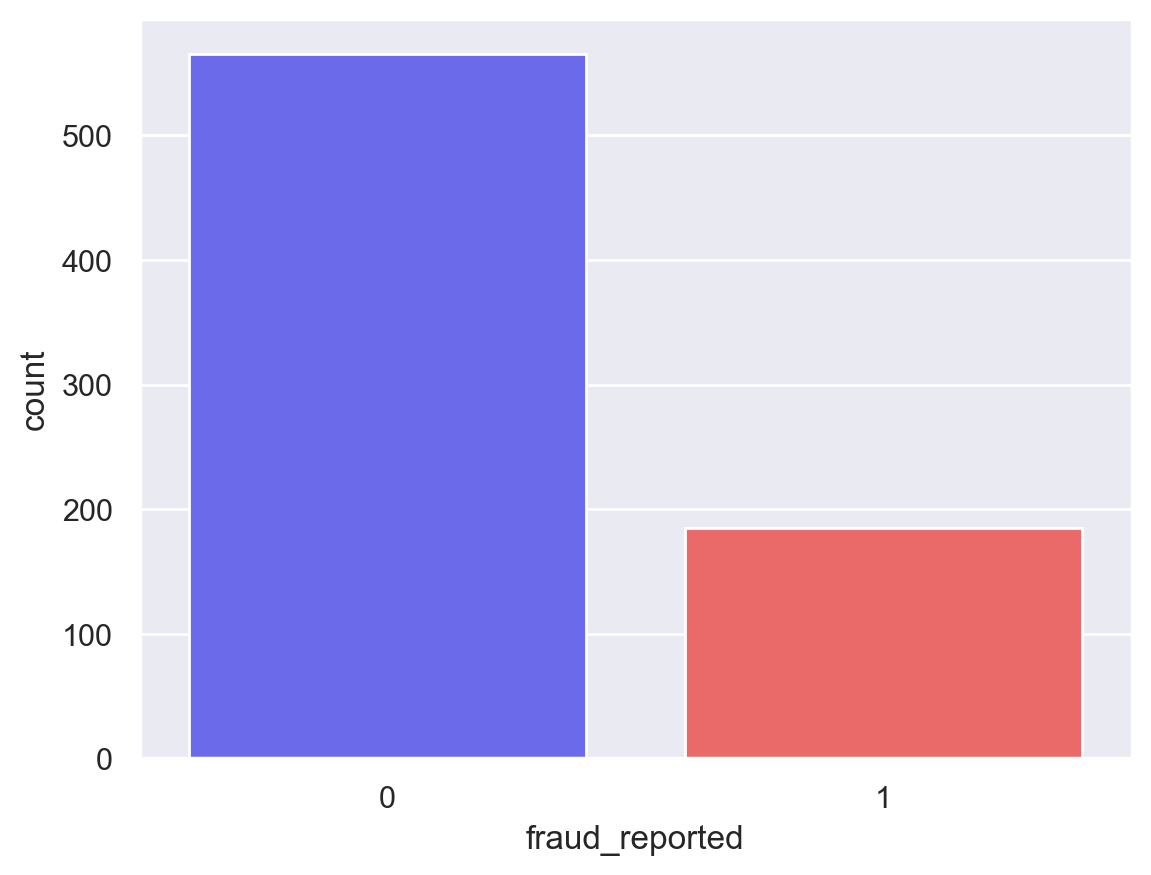

In [109]:
#dist of dv
sns.countplot(x=y_train, palette='seismic');

565 185


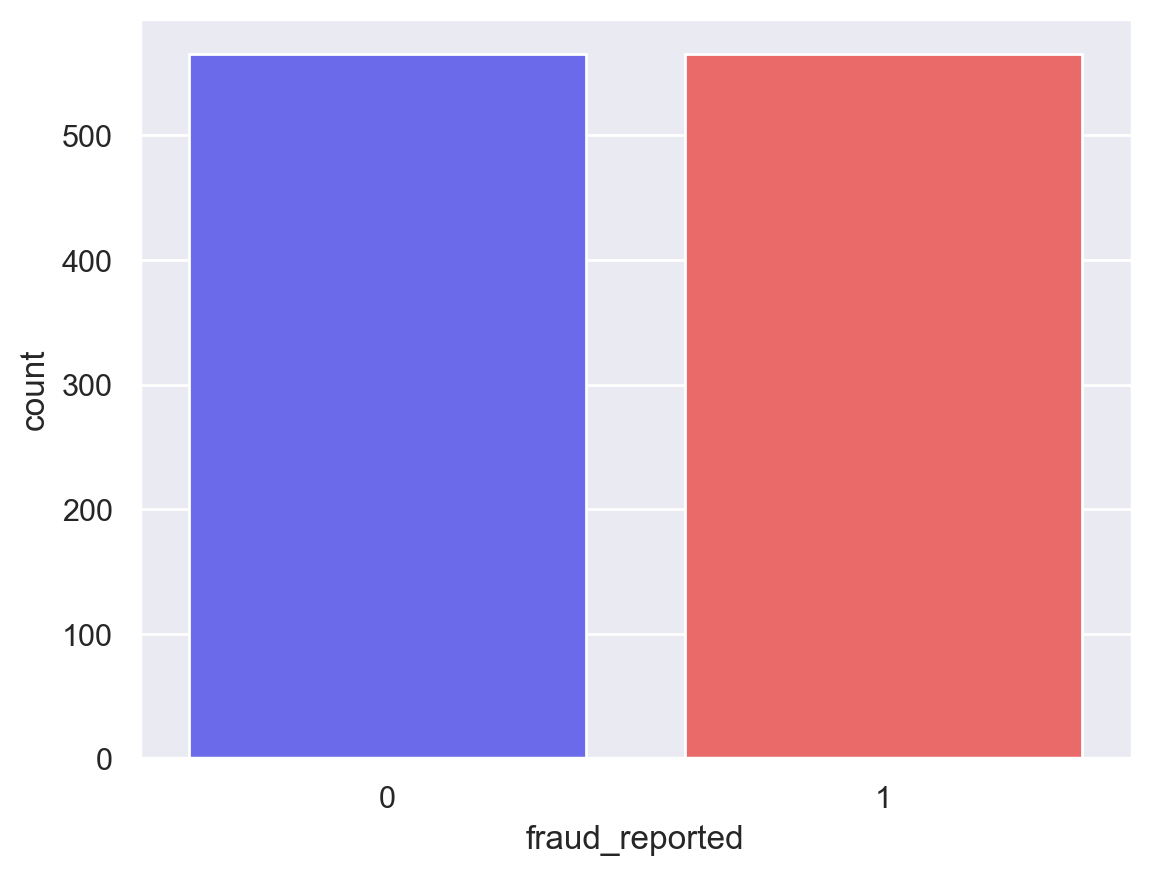

In [110]:
df = pd.concat([x_train, y_train], axis=1)

#count class
count_class_0, count_class_1 = df['fraud_reported'].value_counts()
print(count_class_0, count_class_1)

# Divide by class
df_class_0 = df[df['fraud_reported'] == 0]
df_class_1 = df[df['fraud_reported'] == 1]

#bootstrap into a new df
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

#resplit them
x_train = df_over.drop(columns='fraud_reported')
y_train = df_over.fraud_reported

sns.countplot(x=y_train, palette='seismic');

### Logistic regression

In [111]:
#ransearch log reg

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            
            }

    
rs_lr3 = RandomizedSearchCV(lr, lr_values, cv=10, n_jobs = -1, random_state=42)
rs_lr3.fit(x_train, y_train)
print(rs_lr3.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'C': 138.9495494373139}


C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### KNN

In [112]:
# knn = KNeighborsClassifier()
# ss = StandardScaler()

knn_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))])

knn_values = {'knn__n_neighbors':[3,5,7,9,11],
              'knn__weights':['uniform', 'distance'],
              'knn__metric':['minkowski','euclidean','manhattan'],
              'knn__algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size':[1,2,3,4,5,6,7,8,9,10]
             }

    
rs_knn3 = RandomizedSearchCV(knn_pipe, knn_values, cv=10, n_jobs = -1, random_state=42)
rs_knn3.fit(x_train, y_train)
print(rs_knn3.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': 3, 'knn__metric': 'minkowski', 'knn__leaf_size': 5, 'knn__algorithm': 'auto'}


### Random forest

In [113]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             
              }


    
rs_rf3 = RandomizedSearchCV(rf, rf_values, cv=10, n_jobs = -1, random_state=42)
rs_rf3.fit(x_train, y_train)
print(rs_rf3.best_params_)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 90}


### XGBoost

In [114]:
xg = XGBClassifier(booster='gbtree', n_jobs=-1)

xg_values = {'max_depth': [3, 4, 5, 6],
             'eta': [0.05, 0.1, 0.15, 0.3],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0, 1, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             
              }


    
rs_xg3 = RandomizedSearchCV(xg, xg_values, cv=10, n_jobs = -1, random_state=42)
rs_xg3.fit(x_train, y_train)
print(rs_xg3.best_params_)

{'reg_lambda': 0.05, 'reg_alpha': 0.5, 'n_estimators': 350, 'max_depth': 5, 'gamma': 0, 'eta': 0.05}


### AdaBoost

In [115]:
ab = AdaBoostClassifier()

ab_values = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,550,600],
            'learning_rate':[0.05,0.1,0.3,0.5]
              }


    
rs_ab3 = RandomizedSearchCV(ab, ab_values, cv=10, n_jobs = -1, random_state=42)
rs_ab3.fit(x_train, y_train)
print(rs_ab3.best_params_)

{'n_estimators': 400, 'learning_rate': 0.5}


In [116]:
classifiers3={'logreg3':rs_lr3, 'knn3':rs_knn3, 'Ranfor3':rs_rf3, 
             'XGB3':rs_xg3, 'AdaBoost3':rs_ab3, }

for key, value in classifiers3.items(): 
    print(scores(value,key))
    print("_________________")
    print(" ")

logreg3 classification metric
CV scores: 0.757
train score: 0.812
test score: 0.648
Sensitivity: 0.548
Specificity: 0.681
Precision: 0.362
F1: 0.436
ROC AUC Score: 0.643
None
_________________
 
knn3 classification metric
CV scores: 0.809
train score: 1.0
test score: 0.62
Sensitivity: 0.516
Specificity: 0.654
Precision: 0.33
F1: 0.403
ROC AUC Score: 0.604
None
_________________
 
Ranfor3 classification metric
CV scores: 0.917
train score: 1.0
test score: 0.812
Sensitivity: 0.565
Specificity: 0.894
Precision: 0.636
F1: 0.598
ROC AUC Score: 0.83
None
_________________
 
XGB3 classification metric
CV scores: 0.926
train score: 1.0
test score: 0.808
Sensitivity: 0.629
Specificity: 0.867
Precision: 0.609
F1: 0.619
ROC AUC Score: 0.827
None
_________________
 
AdaBoost3 classification metric
CV scores: 0.895
train score: 0.956
test score: 0.768
Sensitivity: 0.532
Specificity: 0.846
Precision: 0.532
F1: 0.532
ROC AUC Score: 0.789
None
_________________
 


## Ensemble

Ensemble models in machine learning combine the decisions from multiple models to improve the overall performance and stability of the predictions.

Before ensembling, correlations of the predictions were ran. XGB, Random forest and AdaBoost have high correlation, perhaps as they all are CARTs (classification and regression tress). Other than that, models seem to capture different aspects of the feature space, as shown by the small to average correlation (Pearson’s heuristics) of their predictions.


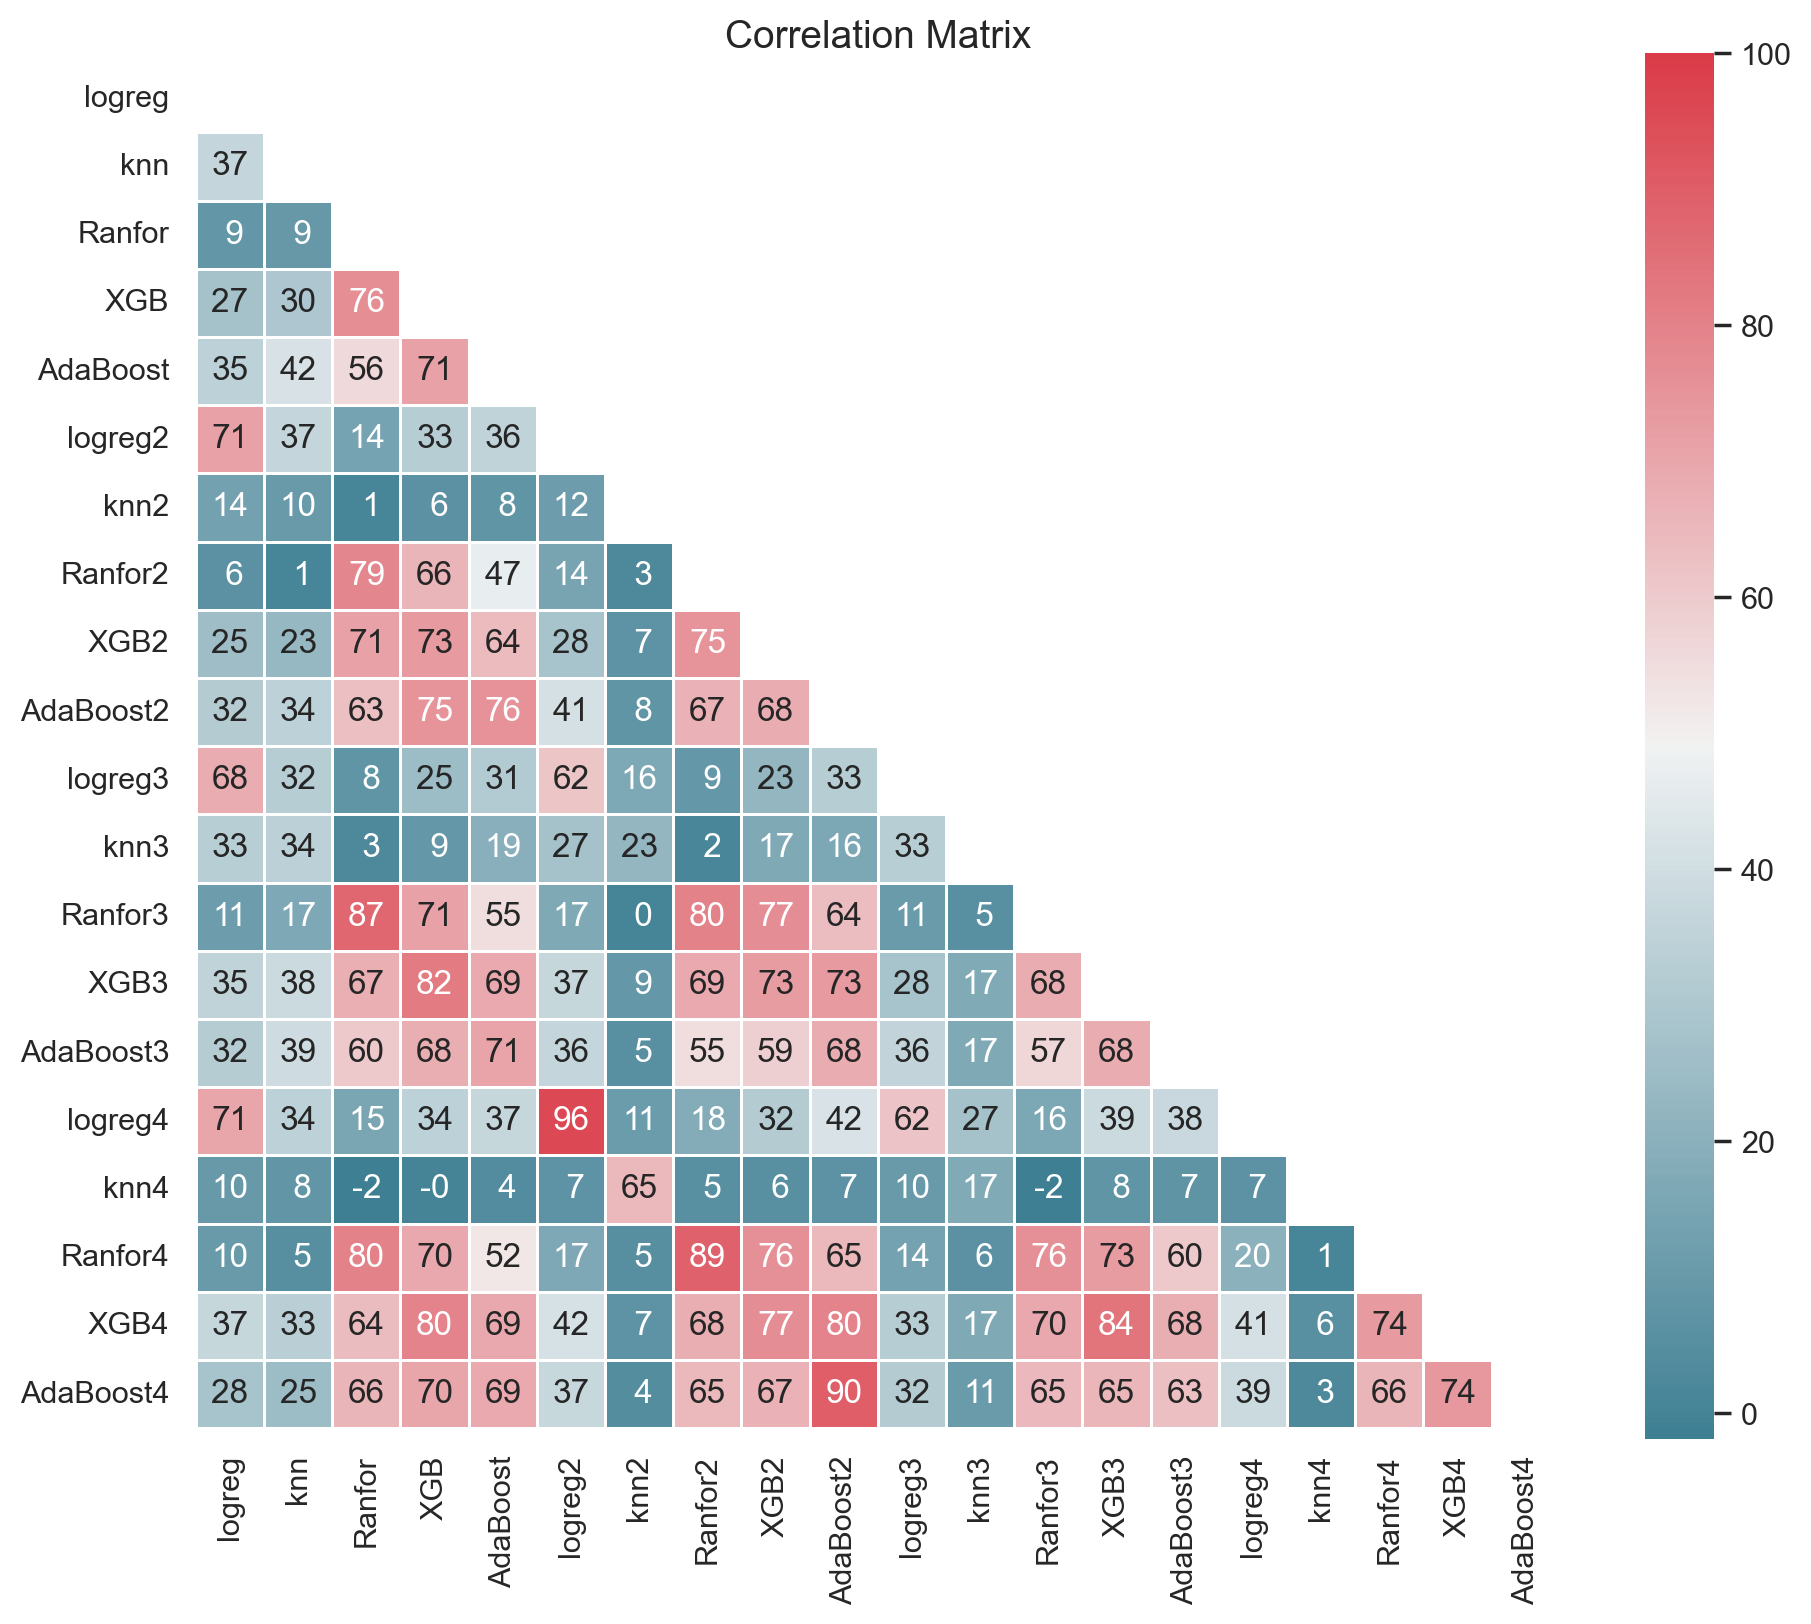

In [117]:
### see correlation of their predictions 

class_dict = {**classifiers, **classifiers2, **classifiers3, **classifiers4}

Pr = pd.DataFrame(columns=['logreg', 'knn', 'Ranfor', 'XGB', 'AdaBoost',
                           'logreg2', 'knn2', 'Ranfor2', 'XGB2', 'AdaBoost2',
                           'logreg3', 'knn3', 'Ranfor3', 'XGB3', 'AdaBoost3',
                           'logreg4', 'knn4', 'Ranfor4', 'XGB4', 'AdaBoost4'])

for key, value in class_dict.items():
    
    Pred = value.best_estimator_.predict(x_test)
    Pr[key] = Pred
    

sns.set_style("white")    
ax = corrmat(Pr.corr())

An ensemble may be able to outperform any single model by learning to combine their respective strength. However, the models we select for the ensemble should not be highly correlated. Else, our model will not be explaining unique variances and thus, unlikely to improve. The ensemble model will use the best logistic regression, KNN and the best of XGB, Random forest and AdaBoost (ensemble 3 model), based on F1 scores, from the models with class weighting, models with oversampling by SMOTE, ADASYN and Bootstrapping. 

The tree models selected are:
- Logistic regression with SMOTE (F1: 0.41)
- KNN with bootstrapping (F1: 0.42)
- Weighted XGBoost (F1: 0.72)

### 1. Max voting without oversampling 

The max voting method is generally used for classification problems. In this technique, multiple models are used to make predictions for each data point. The predictions by each model are considered as a ‘vote’. The predictions which we get from the majority of the models are used as the final prediction. The three selected models fitted together in a voting classifier. 

10-fold cross validation was performed with its mean scores printed, followed by computing of train and test accuracy scores. Then, the sensitivity, specificity, precision, F1 score and ROC AUC scores were computed. 


In [118]:
#have to redefine since the bootstap has already altered the data
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [119]:
#fit best estimators into selected model
model_1 = rs_lr2.best_estimator_
model_2 = rs_knn3.best_estimator_
model_3= rs_xg.best_estimator_


In [120]:
model = VotingClassifier(estimators=[('lr', model_1), 
                                     ('knn', model_2), 
                                     ('xg', model_3),
                                    ], 
                         voting='soft')

model.fit(x_train,y_train)
print("fitted")

C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


fitted


In [121]:
print("Max vote w oversampling")
kf=KFold(n_splits=10, shuffle=True, random_state=42)
print("cross val score:", round(cross_val_score(model, x_train, y_train, cv= kf).mean(),3))
print("train score:", round(model.score(x_train, y_train),3))
print("test score:", round(model.score(x_test, y_test),3))

#Evaluation metrics
predictions = model.predict(x_test)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

sensi = TP/(TP + FN)
speci= TN/(TN + FP)
preci = TP/(TP + FP)
f1= 2*(preci*sensi)/(preci+sensi)


# print("True Negatives: %s" % TN)
# print("False Positives: %s" % FP)
# print("False Negatives: %s" % FN)
# print("True Positives: %s" % TP)
# print('-----------------------')
print(f'Sensitivity: {round(sensi,3)}')
print(f'Specificity: {round(speci,3)}')
print(f'Precision: {round(preci,3)}')
print(f'F1: {round(f1,3)}')

pred_proba = [i[1] for i in model.predict_proba(x_test)]
auc_score = roc_auc_score(y_test, pred_proba) 
print('ROC AUC Score:', round(auc_score,3))

Max vote w oversampling


C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

cross val score: 0.805
train score: 0.999
test score: 0.78
Sensitivity: 0.371
Specificity: 0.915
Precision: 0.59
F1: 0.455
ROC AUC Score: 0.804


### 2. Max voting with oversampling 

As bootstrapping in general produced the best F1 scores out of the other oversampling technique in this project, it was used here for the max voting ensemble. After the training set was bootstrapped, the process is the same as the max voting without oversampling

In [122]:
#have to redefine since the bootstap has already altered the data

x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

565 185


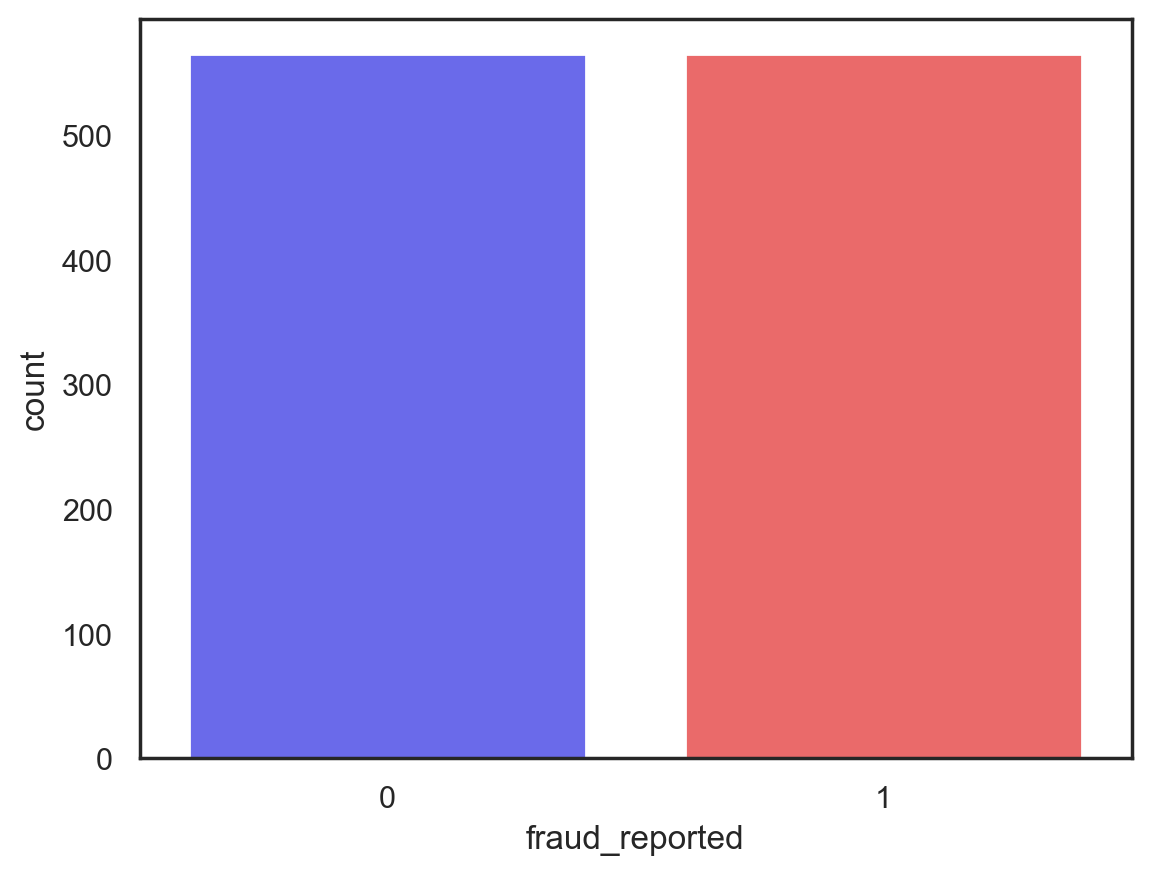

In [123]:
df = pd.concat([x_train, y_train], axis=1)

#count class
count_class_0, count_class_1 = df['fraud_reported'].value_counts()
print(count_class_0, count_class_1)

# Divide by class
df_class_0 = df[df['fraud_reported'] == 0]
df_class_1 = df[df['fraud_reported'] == 1]

#bootstrap into a new df
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

#resplit them
x_train = df_over.drop(columns='fraud_reported')
y_train = df_over.fraud_reported

sns.countplot(x=y_train, palette='seismic');

In [124]:
#best estimator
model_1 = rs_lr3.best_estimator_
model_2 = rs_knn3.best_estimator_
model_3= rs_xg.best_estimator_

In [125]:
#soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, 


model_mv2 = VotingClassifier(estimators=[('lr', model_1), 
                                     ('knn', model_2), 
                                     ('xg', model_3),
                                    ], 
                         voting='soft')

model_mv2.fit(x_train,y_train)
print("fitted")

C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


fitted


In [126]:
print("Max vote w oversampling")
kf=KFold(n_splits=10, shuffle=True, random_state=42)
print("cross val score:", round(cross_val_score(model_mv2, x_train, y_train, cv= kf).mean(),3))
print("train score:", round(model_mv2.score(x_train, y_train),3))
print("test score:", round(model_mv2.score(x_test, y_test),3))

#Evaluation metrics
predictions = model_mv2.predict(x_test)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

sensi = TP/(TP + FN)
speci= TN/(TN + FP)
preci = TP/(TP + FP)
f1= 2*(preci*sensi)/(preci+sensi)

print(f'Sensitivity: {round(sensi,3)}')
print(f'Specificity: {round(speci,3)}')
print(f'Precision: {round(preci,3)}')
print(f'F1: {round(f1,3)}')

pred_proba = [i[1] for i in model_mv2.predict_proba(x_test)]
auc_score = roc_auc_score(y_test, pred_proba) 
print('ROC AUC Score:', round(auc_score,3))

Max vote w oversampling


C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\parul\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

cross val score: 0.898
train score: 0.997
test score: 0.788
Sensitivity: 0.613
Specificity: 0.846
Precision: 0.567
F1: 0.589
ROC AUC Score: 0.787


### 3. Blending without oversampling

In the first step of the blending method, the training set is broken down into 2 parts, a new training set and a holdout set called validation set by a ratio of 75:25 respectively. The blending method fits the 3 selected model onto the new training set and make predictions on the validation and test set concurrently. The 3 different prediction of the validation set is stacked into one long column. Same is done for the predictions of the test set. A meta model, logistic regression in this case, is then fitted on the stacked validation predictions and scored on the stacked test predictions.

<br>
<details><summary>Here is an illustration of what I did for my blending ensemble:</summary>

![](images/figen.PNG)
    
</details>



10-fold cross validation was performed with its mean scores printed, followed by computing of train and test accuracy scores. Then, the sensitivity, specificity, precision, F1 score and ROC AUC scores were computed. 

<br>
<details><summary>More about Blending </summary>
The simplest kind of ensemble is the unweighted average of the predictions of the models that form a model library. For example, if a model library includes three models for an interval target (as shown in the following figure), the unweighted average would entail dividing the sum of the predicted values of the three candidate models by three. In an unweighted average, each model takes the same weight when an ensemble model is built.

More generally, you can think about using weighted averages. For example, you might believe that some of the models are better or more accurate and you want to manually assign higher weights to them. But an even better approach might be to estimate these weights more intelligently by using another layer of learning algorithm. This approach is called model stacking or blending.
    
This second-layer algorithm is trained to optimally combine the model predictions to form a new set of predictions. For example, when linear regression is used as second-layer modeling, it estimates these weights by minimizing the least square errors. 
    
Blending is a word introduced by the Netflix competition winners. It is closely related to stacked generalization, but simpler and less risk of an information leak. 

Some researchers and data scientist use “stacked ensembling” and “blending” interchangeably. With blending, instead of creating out-of-fold predictions for the train set, you create a small holdout set of the training set. Predictions are then used as features and a meta-model, usually a linear model, is used to make the final and actual scoring and predictions. The meta-model used in this model is a logistic regression. 

Blending has a few benefits:
- Simpler than stacking.
- Wards against an information leak: The generalizers and stackers use different data.
- You do not need to share a seed for stratified folds with your teammates. 

The cons are:
- You use less data overall, compared to stacking.
- Final model usually overfits to the holdout set.

</details>

In [127]:
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [128]:
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, stratify=y_train, random_state=42)

In [129]:
#model has been fitted above
model_1 = rs_lr3.best_estimator_
model_2 = rs_knn3.best_estimator_
model_3= rs_xg.best_estimator_

#make predictions for each val data 
pred_1 = model_1.predict(x_val)
pred_2 = model_2.predict(x_val)
pred_3 = model_3.predict(x_val)


#make predictions for test data
test_pred_1 = model_1.predict(x_test)
test_pred_2 = model_2.predict(x_test)
test_pred_3 = model_3.predict(x_test)


#form a new dataset for validation and test via stacking the prediction
stack_preds = np.column_stack((pred_1, pred_2, pred_3))

stack_test_preds = np.column_stack((test_pred_1, test_pred_2, test_pred_3))


In [130]:
#specify meta model
meta_model = LogisticRegression()

lr_values = {'solver': ['liblinear'],
               'penalty': ['l1', 'l2'],
               'C': np.logspace(-10, 10, 100)}
              
    
meta_rs = RandomizedSearchCV(meta_model, lr_values, cv=10, n_jobs = -1, random_state=42)
meta_rs.fit(stack_preds, y_val)
print(meta_rs.best_params_)

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.31257158496882353}


In [131]:
#Evaluation metrics
best_meta = meta_rs.best_estimator_
predictions = best_meta.predict(stack_test_preds)

print("Stack Ensemble w/o oversampling")
kf=KFold(n_splits=10, shuffle=True, random_state=42)
print("cross val score:", cross_val_score(best_meta, stack_preds, y_val, cv= kf).mean())
print("val score:", best_meta.score(stack_preds, y_val))
print("test score:", best_meta.score(stack_test_preds, y_test))

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

sensi = TP/(TP + FN)
speci= TN/(TN + FP)
preci = TP/(TP + FP)
f1= 2*(preci*sensi)/(preci+sensi)

print(f'Sensitivity: {round(sensi,3)}')
print(f'Specificity: {round(speci,3)}')
print(f'Precision: {round(preci,3)}')
print(f'F1: {round(f1,3)}')

pred_proba = [i[1] for i in meta_rs.predict_proba(stack_test_preds)]
auc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC Score:', auc_score)

Stack Ensemble w/o oversampling
cross val score: 0.9947368421052631
val score: 0.9946808510638298
test score: 0.728
Sensitivity: 0.452
Specificity: 0.819
Precision: 0.452
F1: 0.452
ROC AUC Score: 0.7534317089910776


### 4. Blending with oversampling

As bootstrapping in general produced the best F1 scores out of the other oversampling technique in this project, it was used here for the blending ensemble. After the training set was bootstrapped, the process is the same as the blending ensemble without oversampling

In [132]:
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

565 185


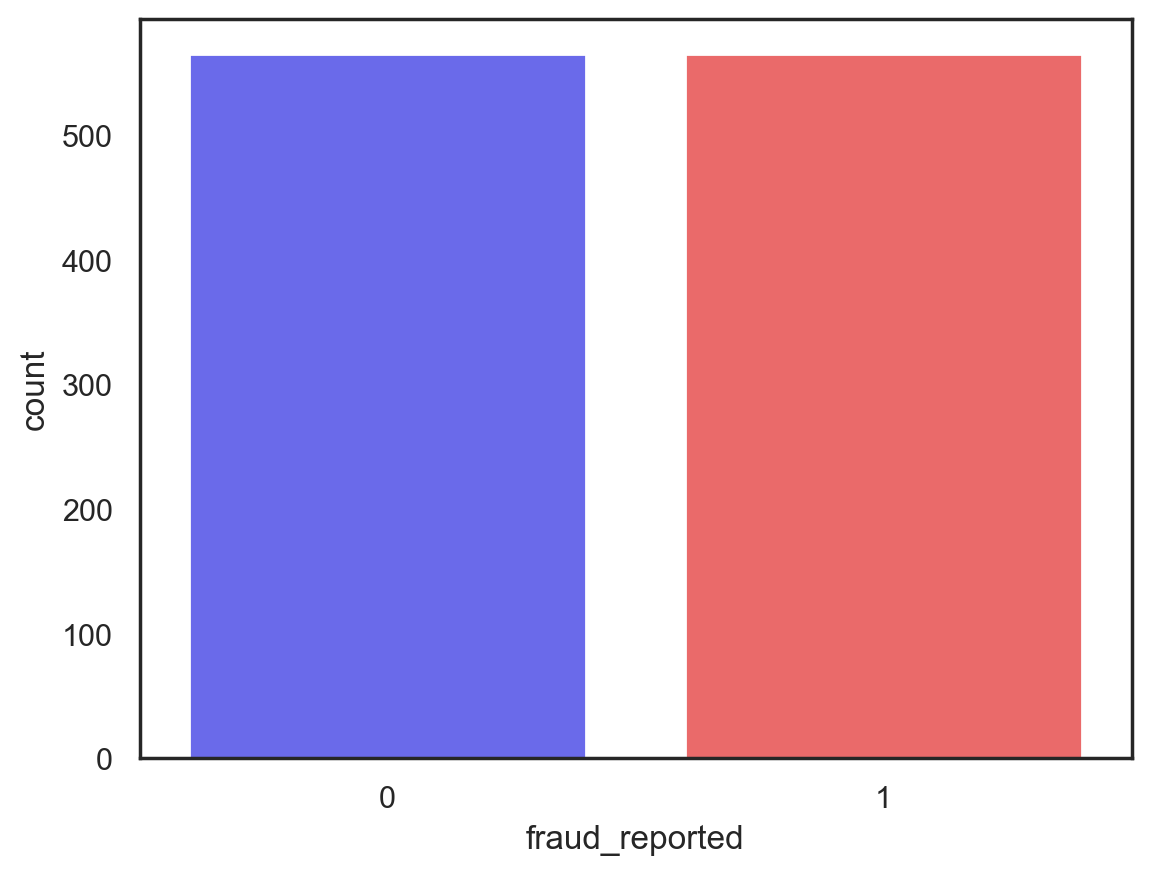

In [133]:
df = pd.concat([x_train, y_train], axis=1)

#count class
count_class_0, count_class_1 = df['fraud_reported'].value_counts()
print(count_class_0, count_class_1)

# Divide by class
df_class_0 = df[df['fraud_reported'] == 0]
df_class_1 = df[df['fraud_reported'] == 1]

#bootstrap into a new df
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

#resplit them
x_train = df_over.drop(columns='fraud_reported')
y_train = df_over.fraud_reported

sns.countplot(x=y_train, palette='seismic');

In [134]:
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, stratify=y_train, random_state=42)

In [135]:
#model has been fitted above
model_1 = rs_lr3.best_estimator_
model_2 = rs_knn3.best_estimator_
model_3= rs_xg.best_estimator_

#make predictions for each val data 
pred_1 = model_1.predict(x_val)
pred_2 = model_2.predict(x_val)
pred_3 = model_3.predict(x_val)


#make predictions for test data
test_pred_1 = model_1.predict(x_test)
test_pred_2 = model_2.predict(x_test)
test_pred_3 = model_3.predict(x_test)


#form a new dataset for validationa and test via stacking the prediction
stack_preds = np.column_stack((pred_1, pred_2, pred_3))

stack_test_preds = np.column_stack((test_pred_1, test_pred_2, test_pred_3))

In [136]:
#specify meta model
meta_model = LogisticRegression()

lr_values = {'solver': ['liblinear'],
               'penalty': ['l1', 'l2'],
               'C': np.logspace(-10, 10, 100)}
              


    
meta_rs = RandomizedSearchCV(meta_model, lr_values, cv=10, n_jobs = -1, random_state=42)
meta_rs.fit(stack_preds, y_val)
print(meta_rs.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'C': 911162.7561154868}


In [137]:
#Evaluation metrics
best_meta = meta_rs.best_estimator_
predictions = best_meta.predict(stack_test_preds)

print("Stack Ensemble w oversampling")
kf=KFold(n_splits=10, shuffle=True, random_state=42)
print("cross val score:", cross_val_score(best_meta, stack_preds, y_val, cv= kf).mean())
print("val score:", best_meta.score(stack_preds, y_val))
print("test score:", best_meta.score(stack_test_preds, y_test))

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

sensi = TP/(TP + FN)
speci= TN/(TN + FP)
preci = TP/(TP + FP)
f1= 2*(preci*sensi)/(preci+sensi)


# print("True Negatives: %s" % TN)
# print("False Positives: %s" % FP)
# print("False Negatives: %s" % FN)
# print("True Positives: %s" % TP)
# print('-----------------------')
print(f'Sensitivity: {round(sensi,3)}')
print(f'Specificity: {round(speci,3)}')
print(f'Precision: {round(preci,3)}')
print(f'F1: {round(f1,3)}')

pred_proba = [i[1] for i in meta_rs.predict_proba(stack_test_preds)]
auc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC Score:', auc_score)

Stack Ensemble w oversampling
cross val score: 0.9895320197044335
val score: 0.9893992932862191
test score: 0.62
Sensitivity: 0.516
Specificity: 0.654
Precision: 0.33
F1: 0.403
ROC AUC Score: 0.7537748798901853


## Evaluation 

Cross validation accuracy scores, accuracy scores on training set, accuracy scores on test set, sensitivity, specificity, precision, F1 score and ROC AUC was computed and printed as shown in the table below. 

**Observations:**

- Comparing across models that were fitted on no oversampling dataset, on SMOTE dataset, on ADASYN dataset and on bootstrapped dataset, I picked the best logistic regression, KNN and CART model.
- The best logistic regression model was the one trained on the SMOTE dataset. It had a F1 score of 0.41 and an AUC of 0.64
- The best KNN model was the one trained on the bootstrap dataset. It had a F1 score of 0.42 and an AUC of 0.60. 
- CARTs performed very well on this data set. However, since CARTs' predictions are all highly correlated, the best of them were selected. The best CART model was the weighted XGBoost on the dataset with no oversampling. It yields a F1 score of 0.72 and an AUC of 0.84.
- Overall, the bootstrapping method seem to have the best F1 scores when compared to the other oversampling methods. 
- The max voting model that was trained on the bootstrapped dataset performed the best out of all ensemble models with an F1 score of 0.55 and an AUC of 0.77. 
- The ensemble models did not perform better than the weighted XGBoost on the dataset with no oversampling. This may be because the difference in scores of the XGBoost and the 2 other selected model were big, and its scores were already high. The other 2 models had much lower F1 and AUC scores and thus may have hindered performance of the ensemble. Ensemble models may perform better when all models perform averagely well instead.

![](images/e1.PNG)

![](images/e2.PNG)

## Final Model: Weighted XGBoost

The final fitted model is the weighted XGBoost on the dataset with no oversampling. The best estimators of the model are as follows:

- Scale_pos_weight: 3.054054054054054, 
- Reg_lambda (L2 regularization weight): 0.1, 
- Reg_alpha (L1 regularization weight): 0.05, 
- N_estimators: 550, 
- Max_depth: 6, 
- Gamma: 3, 
- Eta: 0.05

<br>
<details><summary>More information on XGBoost</summary>

XGBoost stands for extreme gradient boost.
XGBoost is a form of gradient boosted CART.

The Gradient Boosting algorithm involves three elements:

- A loss function to be optimized, such as cross entropy for classification or mean squared error for regression problems.
- A weak learner to make predictions, such as a greedily constructed decision tree.
- An additive model used to add weak learners to minimize the loss function.

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. 

It optimizes a cost function over function space by iteratively choosing a function (weak hypothesis) that points in the negative gradient direction. Small steps towards the right direction make gradient boosting accurate and generalizable. 

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance and allows for L1 and L2 (or both) regularization. 

More information about these parameters can be found at: iihttps://xgboost.readthedocs.io/en/latest/parameter.html

More information on XGBoost can be found in Tianqi Chen's (main author of XGB) lecture: https://www.youtube.com/watch?v=Vly8xGnNiWs&feature=emb_logo

</details>


In [138]:
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [140]:
print("Final Model: Weighted XGBoost")
print("train score:", round(rs_xg.best_estimator_.score(x_train, y_train),3))
print("test score:", round(rs_xg.best_estimator_.score(x_test, y_test),3))


Final Model: Weighted XGBoost
train score: 0.967
test score: 0.844


### Final fitted model's performance

The model had a training accuracy score of 0.967 and a test accuracy of 0.844. The high accuracy score hint of a low bias (it is only a hint as accuracy is not a good measure of bias in imbalance class problems).
An accuracy score difference of 0.123 between train and test is relatively small. Thus, this model can be said to have low variance and is generalizable on unseen data. 

The number of cases for each class of the test set is shown in the confusion matrix below. The y-axis shows the actual classes while the x-axis shows the predicted classes. 
- True negative refers to non-fraud cases that are classified as non-fraud cases (161 cases, which makes up 64.40% of the test set's size).
- True positive refers to fraud cases that are correctly classified as fraud cases (50 cases, which makes up 20.00% of the test set's size).
- False negative are fraud cases that are classified as non-fraud cases (12 cases, which makes up 4.80% of the test set's size).
- False positive are non-fraud cases that are classified as fraud cases (27 cases, which makes up 10.80% of the test set's size). 

Percentage out of total sample size of the test set is printed on each quadrant. 

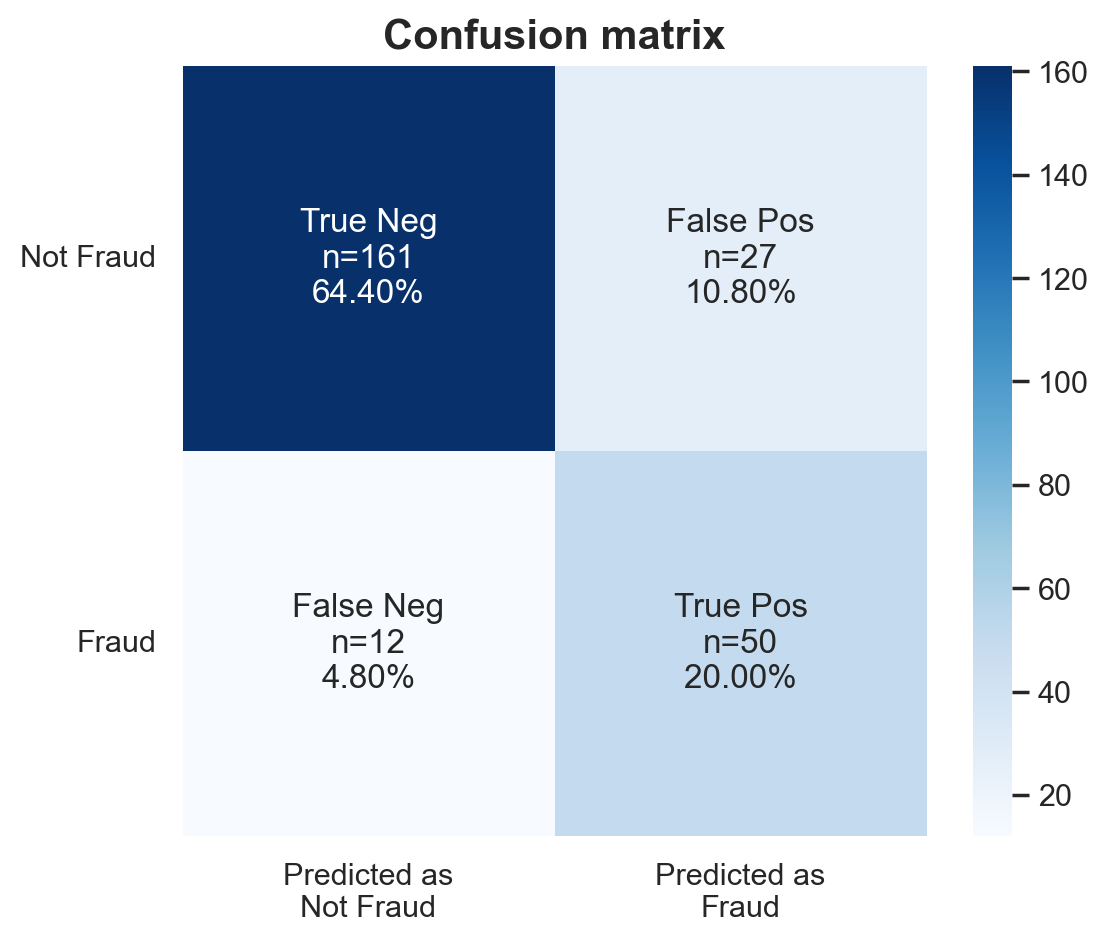

In [141]:
#confusion matrix
predictions = rs_xg.best_estimator_.predict(x_test)
cf_matrix = confusion_matrix(y_test, predictions)

#labels for the inside of heatmap
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['n={0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

#put them next line
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

#in array 2,2 cos the heatmap will be 2,2
labels = np.asarray(labels).reshape(2,2)

#class labeling
yticklabels=['Not Fraud','Fraud']
xticklabels=['Predicted as\nNot Fraud','Predicted as\nFraud']


# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(6,5))

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.set()
ax = sns.heatmap(cf_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

# Resize the labels.
ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

The summary of the classification report is presented below. 


- Sensitivity (recall of fraud cases) is derived from:
    - True positive/(True positive + False negative)
    - Sensitivity summarizes our true positive rate, which is how many we got correct out of all the positive cases.
    - Sensitivity for the final model is 81%.


- Specificity (recall of non-fraud cases) is derived from:
    - True negative/(True negative + False positive)
    - Specificity summarizes our true negative rate, which is how many we got correct out of all the negative cases.
    - Specificity for the final model is 86%


- Precision of fraud cases are derived from:
    - True positive/(True positive + False positive)
    - Precision of fraud cases summarize the accuracy of fraud cases detected. That is, out of all that I predicted as fraud, how many are correct.
    - Precision of fraud detection is 65%.


- Precision of non-fraud cases are derived from:
    - True negative/(True negative + False negative)
    - Precision of non-fraud cases summarize the accuracy of non-fraud cases detected. That is, out of all that I predicted as non-fraud, how many are correct. 
    - Precision of non-fraud detection is 93%.


- F1 scores are the harmonic mean of recall and precision and is derived from:
    - (2 x recall x precision)\(recall + precision)
    - As we are interested in fraud cases, only the F1 scores on fraud cases are reported. 
    - The F1 score of the model is 72%. 
    

In sum, the model has outperformed the baseline F1 scores by a huge margin. 


In [142]:
#classification report

predictions = rs_xg.best_estimator_.predict(x_test)
print(classification_report(y_test, predictions, target_names=['Not Fraud',"Fraud"]))


              precision    recall  f1-score   support

   Not Fraud       0.93      0.86      0.89       188
       Fraud       0.65      0.81      0.72        62

    accuracy                           0.84       250
   macro avg       0.79      0.83      0.81       250
weighted avg       0.86      0.84      0.85       250



The ROC curve below summarizes how well our model is at balancing between the true positive rate(sensitivity) and the false positive rate(1-specificity). Ideally, we want to have a 100% true positive rate of predicting fraud and a 100% true negative rate of predicting non-frauds (or a 0% false positive which is 100% - 100% true negative rate). This means we have perfect prediction for both classes. However, in imbalance class problems, this is extremely hard to achieve in the real world. On top of that, there is a trade of between the true positive rate and the true negative rate and conversely the false positive rate. 

This graph summarizes how well we can distinguish between two classes at each threshold of the true positive and false positive rate. The area under curve is used as a summary percentage of this metric. In sum, the model has outperformed the baseline ROC AUC scores by a huge margin. 

C:\Users\parul\AppData\Local\Temp\ipykernel_7192\2354503572.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifiers':cls.__class__.__name__,
C:\Users\parul\AppData\Local\Temp\ipykernel_7192\2354503572.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifiers':cls.__class__.__name__,
C:\Users\parul\AppData\Local\Temp\ipykernel_7192\2354503572.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifiers':cls.__class__.__name__,
C:\Users\parul\AppData\Local\Temp\ipykernel_7192\2354503572.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

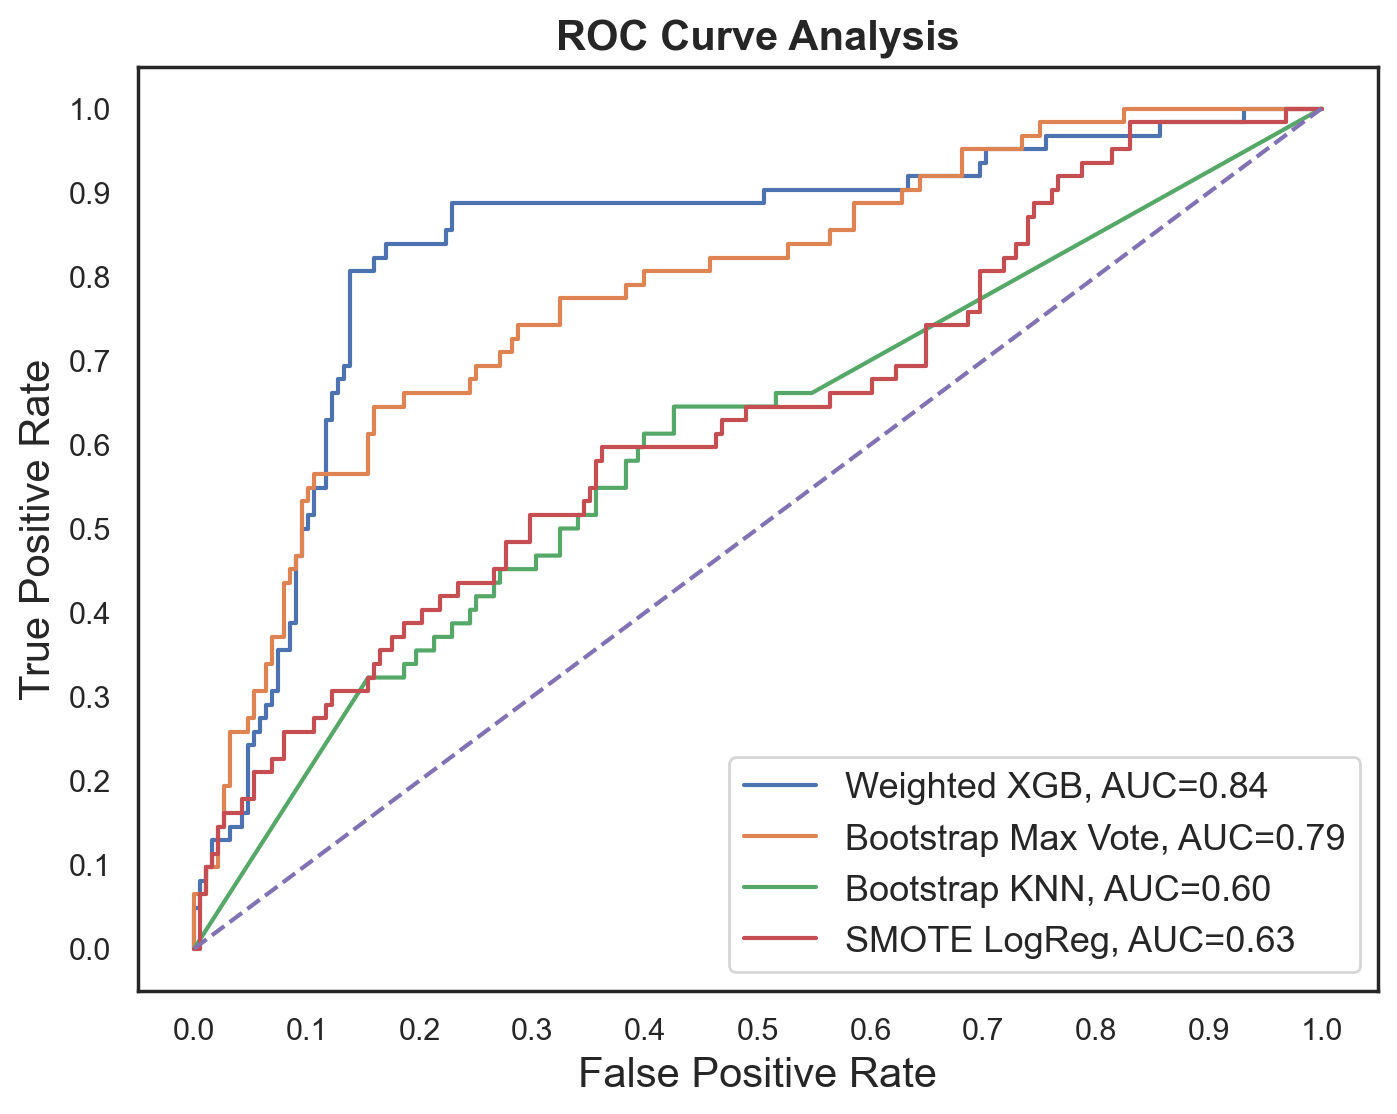

In [143]:
# Instantiate the classfiers and make a list
classifiers_name = [rs_xg.best_estimator_, 
                   model_mv2, 
                   rs_knn3.best_estimator_,
                   rs_lr2.best_estimator_]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers_name:
    yproba = cls.predict_proba(x_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table['names'] = ['Weighted XGB', 'Bootstrap Max Vote', 'Bootstrap KNN','SMOTE LogReg']
result_table.set_index('names', inplace=True)

#Plot the figure
fig = plt.figure(figsize=(8,6))

sns.set_style("white")

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.2f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='m', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Although our model performed better in predicting non-fraud cases, the model has performed very well on fraud cases as well. We have a higher false alarm than frauds escaping the detection. It is better in our case to identify more frauds than to let fraud cases escape detection. Thus, this model has succeeded in its purpose to detect fraud claims. Unlike the baseline model that sacrifices too much resources into investigations and hinder customer experience, we are also able to balance this out in this model. We can detect more fraud and we are able to balance this with correct prediction of non-fraud cases. 

### Top features

Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance. This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

**Weight:**

The number of times a feature is used to split the data across all trees. The final measure, implemented exclusively in XGBoost, is counting the number of samples affected by the splits based on a feature.

The figure below summarizes the top 20 ranked by feature importance, based on weight. Drivers with hobbies such as chess, cross-fit seemed to be more prone to frauds. Incident severity and property claim are amongst the highest as well. Interaction terms such as premium and total claim amount, vehicle claim amount and incident severity were also top features by weight. 

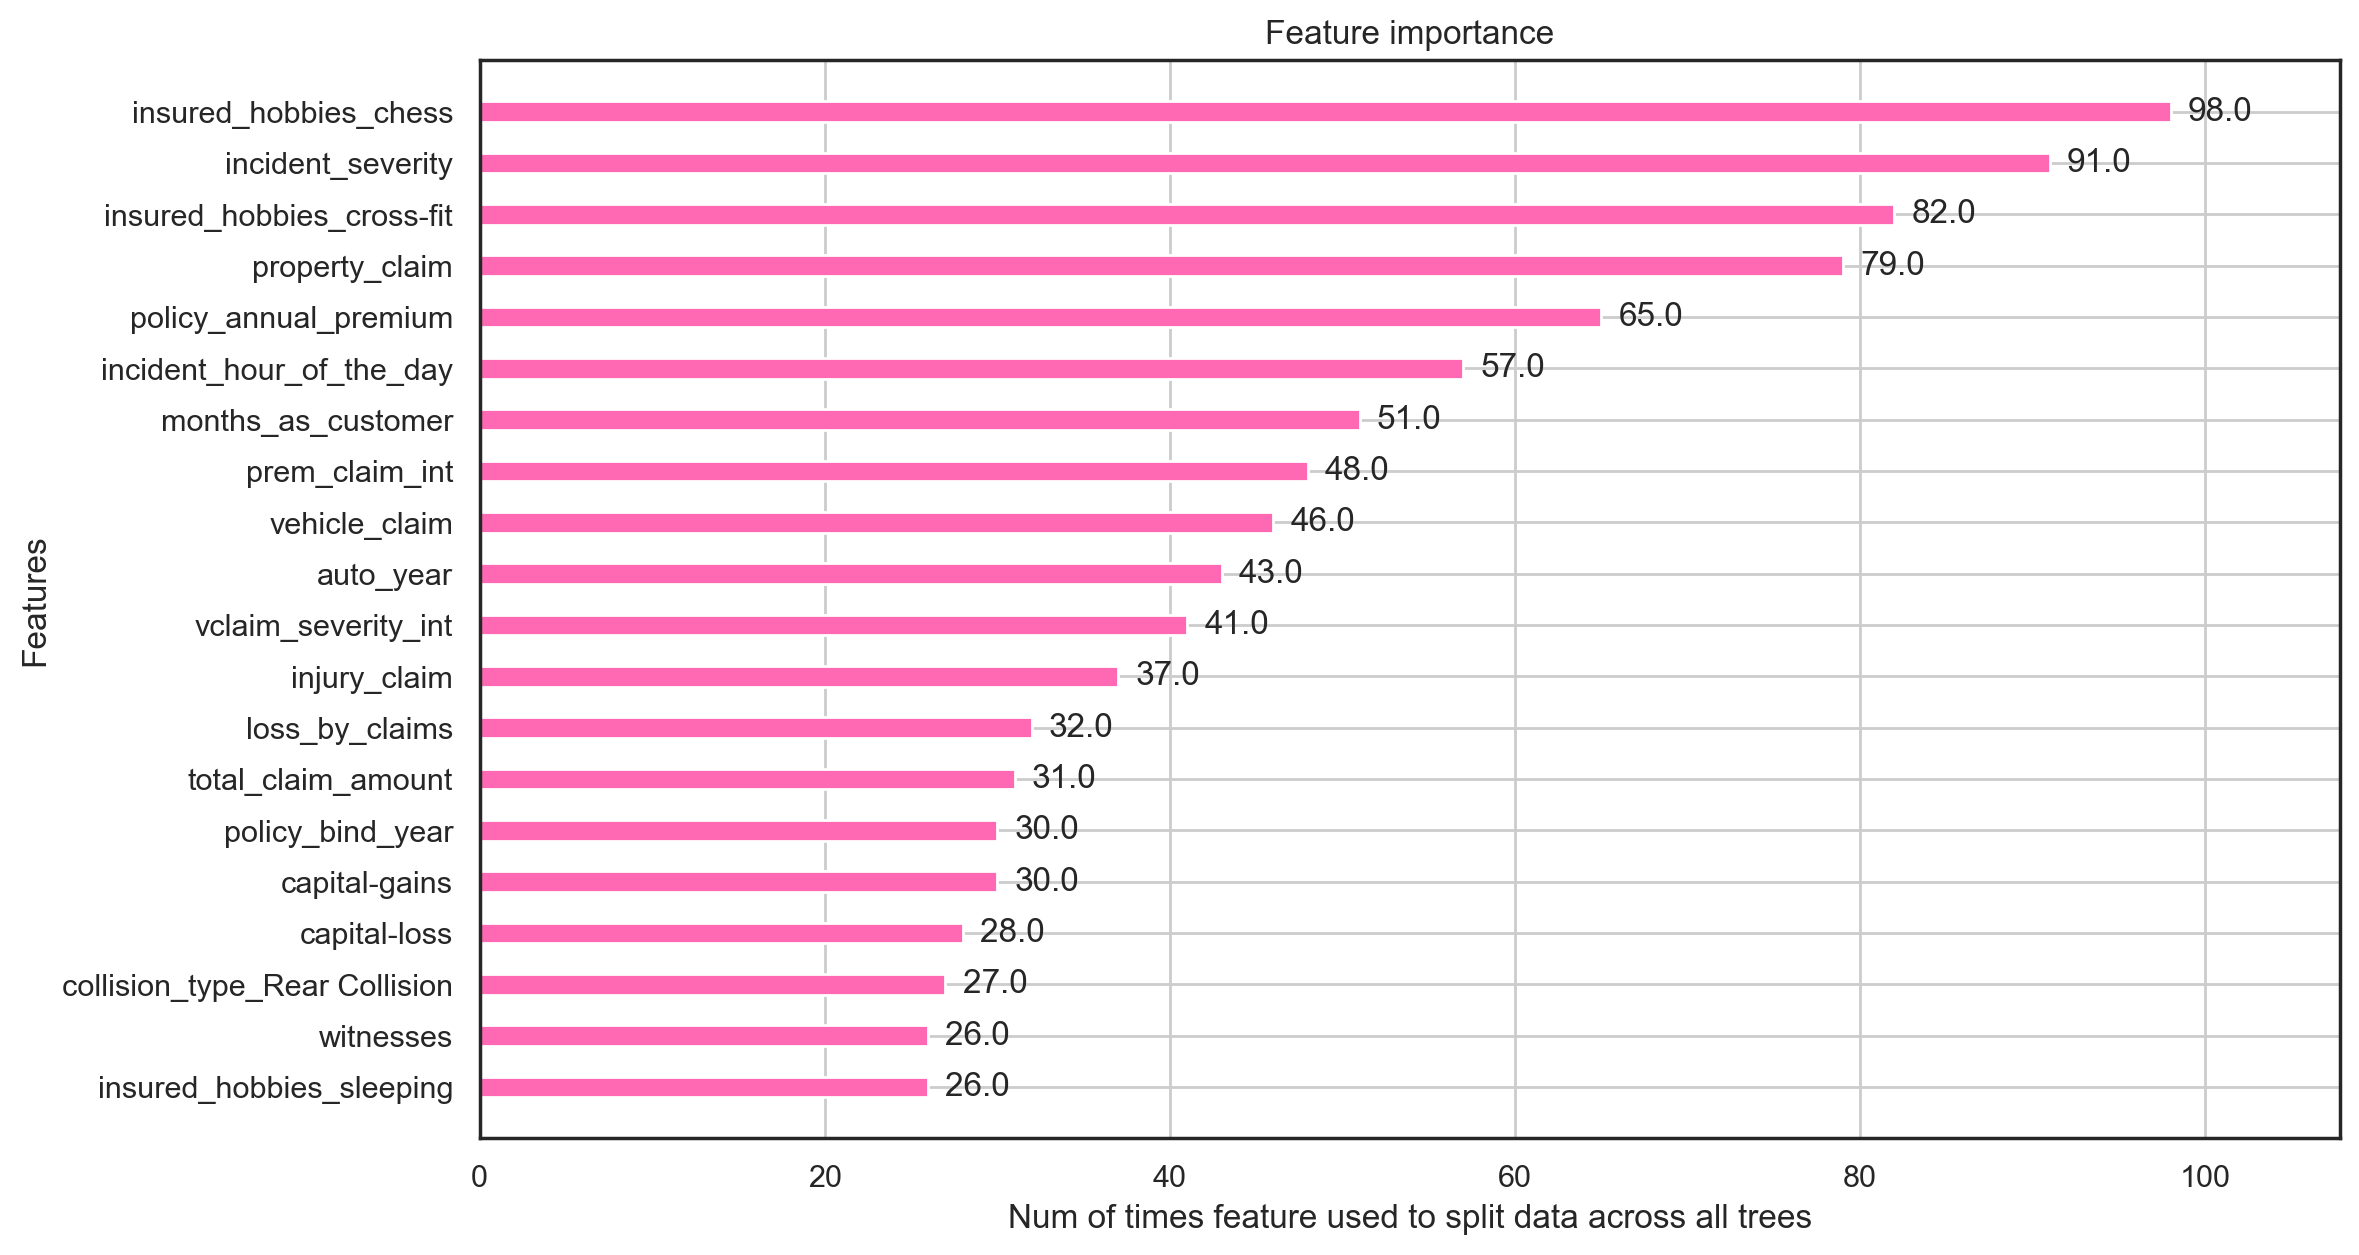

In [144]:
# plot feature importance

fig, ax = plt.subplots(figsize=(12, 7))
plot_importance(rs_xg.best_estimator_, importance_type='weight', 
                max_num_features=20, height=0.4, ax=ax, xlabel='Num of times feature used to split data across all trees',
               color='hotpink');


**Gain:**

It is sometimes called “Gini importance” or “mean decrease impurity” and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node) averaged over all trees of the ensemble.

<br>
<details><summary>More information on mean decrease in impurity:</summary>

Gini Impurity measures how often a randomly chosen record from the data set used to train the model will be incorrectly labelled if it was randomly labelled according to the distribution of labels in the subset (e.g., if half of the records in a group are "A" and the other half of the records are "B", a record randomly labelled based on the composition of that group has a 50% chance of being labelled incorrectly). Gini Impurity reaches zero when all records in a group fall into a single category (i.e., if there is only one possible label in a group, a record will be given that label 100% of the time). This measure is essentially the probability of a new record being incorrectly classified at a given node in a Decision Tree, based on the training data.

Gini Importance can be leveraged to calculate Mean Decrease in Gini, which is a measure of variable importance for estimating a target variable. Mean Decrease in Gini is the average (mean) of a variable’s total decrease in node impurity, weighted by the proportion of samples reaching that node in each individual decision tree in the random forest. This is effectively a measure of how important a variable is for estimating the value of the target variable across all the trees that make up the forest. A higher Mean Decrease in Gini indicates higher variable importance.

The most important variables to the model will be highest in the plot and have the largest Mean Decrease in Gini Values, conversely, the least important variable will be lowest in the plot and have the smallest Mean Decrease in Gini values.
    
</details>

The figure below summarizes the top 20 ranked by feature importance, based on weight. Incident severity is once again amongst the most important. Hobbies such as chess and CrossFit are also amongst the top features when looking at mean decrease in impurity. Interaction terms such as total claims and incident severity are top features as well. 

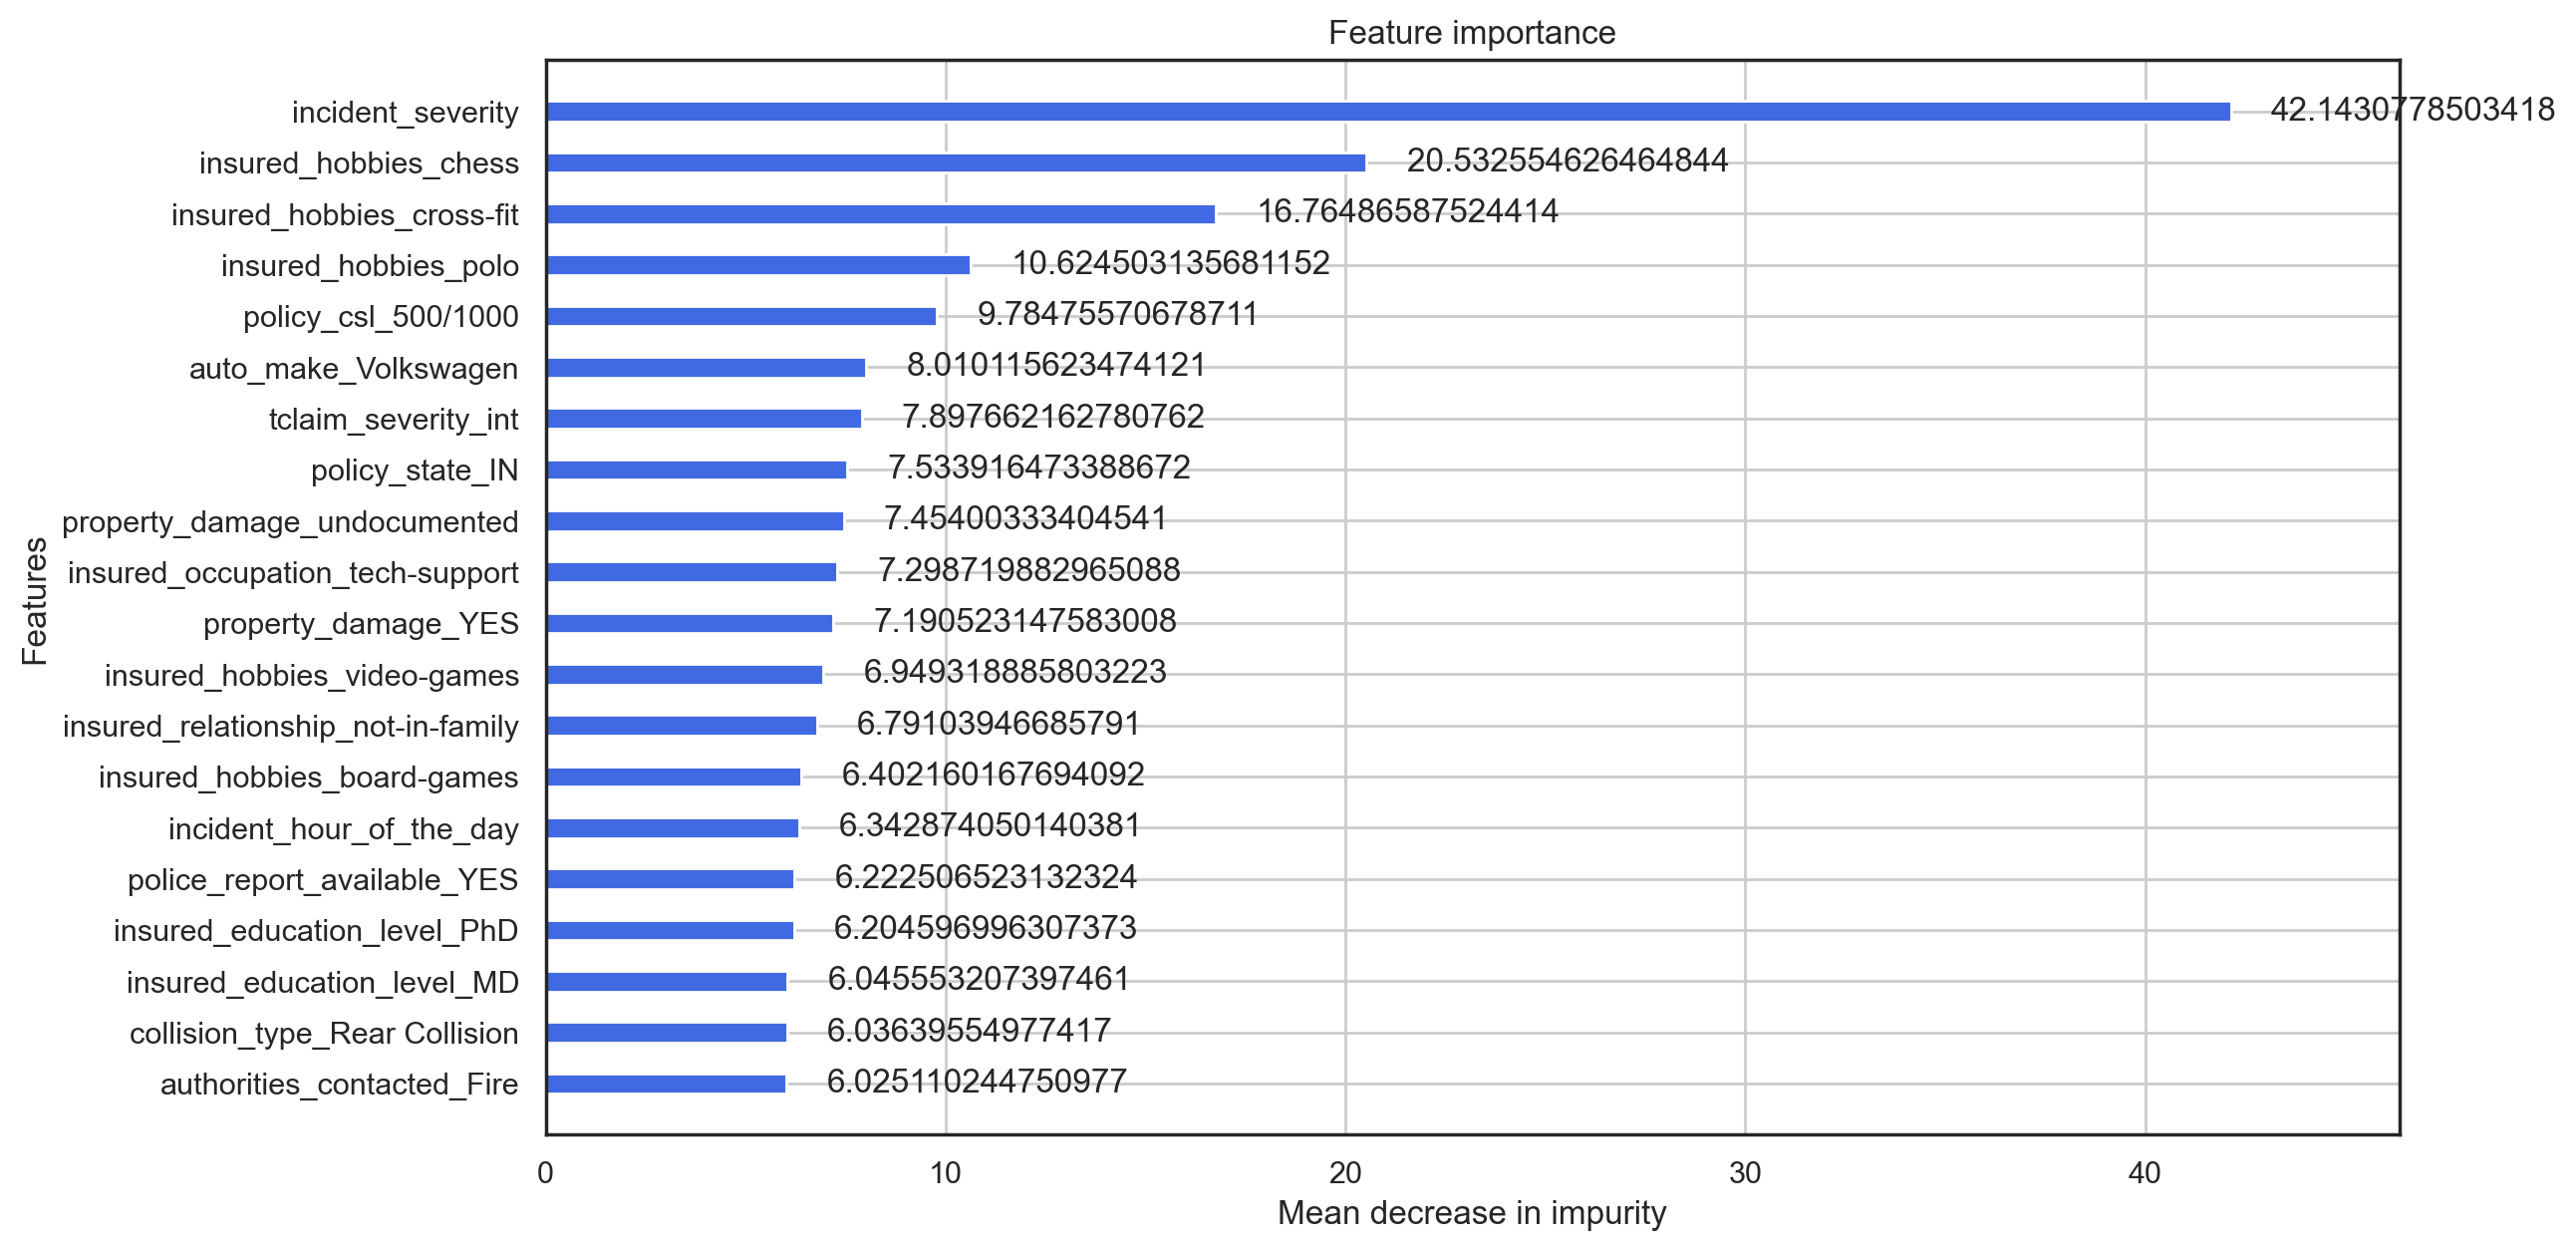

In [145]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12, 7))
plot_importance(rs_xg.best_estimator_, importance_type='gain', 
                max_num_features=20, height=0.4, ax=ax, xlabel='Mean decrease in impurity', color='royalblue');

 ## Conclusion and Limitations

Fraud accounted for between 15 percent and 17 percent of total claims payments for auto insurance bodily injury in 2012, according to an Insurance Research Council (IRC) study. The study estimated that between \\$5.6 billion and \\$7.7 billion was fraudulently added to paid claims for auto insurance bodily injury payments in 2012, compared with a range of \\$4.3 billion to \\$5.8 billion in 2002.

This project has built a model that can detect auto insurance fraud. In doing so, the model can reduces loses for insurance companies. The challenge behind fraud detection in machine learning is that frauds are far less common as compared to legit insurance claims. 

Five different classifiers were used in this project: logistic regression, K-nearest neighbours, Random forest, XGBoost, AdaBoost. Four different ways of handling imbalance classes were tested out with these five classifiers: model with class weighting and hyperparameter tuning, oversampling with SMOTE, oversampling with ADASYN and oversampling with bootstrapping. On top of that two max vote ensembles were built. One on the train set and one on the bootstrapped train set. Two blending ensembles were also performed. One on the train set and one on the bootstrapped train set as well. 

The best and final fitted model was a weighted XGBoost what yelled a F1 score of 0.72 and a ROC AUC of 0.84. The model performed far better than the baseline F1 score of 0.397 and ROC AUC target of 0.7. The model's F1 score and ROC AUC scores were the highest amongst the other models. In conclusion, the model was able to correctly distinguish between fraud claims and legit claims with high accuracy. 

The study is not without limitations. Firstly, this study is restricted by its small sample size. Statistical models are more stable when data sets are larger. It also generalizes better as it takes a bigger proportion of the actual population. Furthermore, the data only capture incident claims of 3 states from 01 January 2015 to 01 March 2015. This means that we do not know the proportion of auto insurance policy holder who had no incidents compared to those who had incidents. We are also restricted to incidents between 2 months which may not be an accurate picture of the year. This is important as certain time of the year may correlate to higher incident rates such as St. Patrick’s Day or other holidays. Future studies may investigate acquiring a larger data set with multiple years. However, due to the sensitive nature of fraud and confidential information tagged to such data, this may remain a challenge.
